In [117]:
from numpy import array,load,where,arange,copy,linspace,append
import numpy as np
from matplotlib.pyplot import plot,title,show,figure,legend,xticks,xlabel,ylabel,xlim
import keras
from keras.utils import np_utils
from keras.models import Sequential,load_model,Model
from keras.layers import Dense, Dropout, Activation, Flatten,    \
                         Conv2D, MaxPooling2D, ZeroPadding2D,    \
                         AveragePooling2D, Conv3D, MaxPooling3D, \
                         Convolution3D, Dense, Activation,       \
                         Convolution2D, MaxPooling2D, Flatten,   \
                         BatchNormalization, Input
from keras.optimizers import adam


from sklearn.utils import shuffle

In [2]:
train_data_path = '../20191127_after_t=05/20200512_G_eigenvector_ver8_test/train/'
test_data_path = '../20191127_after_t=05/20200512_G_eigenvector_ver8_test/test/'

date = '20200512'
N = 5
NN = N
N = 'N={}'.format(N)
delta = 0.5
delta = 'delta={}'.format(delta)

print(NN,N,delta)

5 N=5 delta=0.5


get_train_data / get_test_data 獲取資料的函數並將資料照data的dictionary回覆  
transform_phase_into_onehot 將資料的label轉為keras可以使用的向量（詳細可參考to_categorical的說明）  
將[5, 1, 3, 7] 轉成[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0],[0, 0, 0, 1]

In [3]:
def get_train_data(train_data_path, date, N, delta):
    
    path = train_data_path + '{},G_eigenvector_train,{},{}.npz'.format(date, N, delta)
    
    train_data = load(path)
    label = train_data.files
    
    phase = train_data['phase']
    delta = train_data['delta']
    mu = train_data['mu']
    eigenvector_r_theta_4D = train_data['eigenvector_r_theta_4D']
    eigenvector_r_3D = train_data['eigenvector_r_3D']
    eigenvector_r_theta_3D = train_data['eigenvector_r_theta_3D']

    return label, phase, delta, mu, eigenvector_r_theta_4D, eigenvector_r_3D, eigenvector_r_theta_3D

def get_test_data(test_data_path, date, N, delta):
    
    path = test_data_path + '{},G_eigenvector_test,{},{}.npz'.format(date, N, delta)
    
    test_data = load(path)
    label = test_data.files
    
    phase = test_data['phase']
    delta = test_data['delta']
    mu = test_data['mu']
    eigenvector_r_theta_4D = test_data['eigenvector_r_theta_4D']
    eigenvector_r_3D = test_data['eigenvector_r_3D']
    eigenvector_r_theta_3D = test_data['eigenvector_r_theta_3D']

    return label, phase, delta, mu, eigenvector_r_theta_4D, eigenvector_r_3D, eigenvector_r_theta_3D

def transform_phase_into_onehot(phase):
    
    phase[phase == 5] = 0
    phase[phase == 1] = 1
    phase[phase == 3] = 2
    phase[phase == 7] = 3
    #phase[phase == 6] = 0
    #phase[phase == 2] = 1
    #phase[phase == 4] = 2
    #phase[phase == 8] = 3
    
    phase = np_utils.to_categorical(phase,4)
    
    return phase

# eigenvector_r_theta_3D

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [4]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 150, 5, 5)
(4000,)
(4000, 4)
(28001, 150, 5, 5)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [5]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [6]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 150, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 150, 5, 5)
(3200, 4)
Number validation data = 
(800, 150, 5, 5)
(800, 4)


開始架構網路

In [9]:
channel = 2*(NN**2)*3

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 300, 5, 5)         405300    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 300, 3, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 450, 3, 3)         1215450   
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 450, 2, 2)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               922112    
_________________________________________________________________
dense_4 (Dense)              (None, 4)                

In [10]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [11]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 7s 2ms/step - loss: 0.0995 - accuracy: 0.9862 - val_loss: 1.9673e-04 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 136us/step - loss: 1.4083e-04 - accuracy: 1.0000 - val_loss: 1.0020e-04 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 117us/step - loss: 7.9340e-05 - accuracy: 1.0000 - val_loss: 6.0663e-05 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 130us/step - loss: 4.9778e-05 - accuracy: 1.0000 - val_loss: 3.9652e-05 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 157us/step - loss: 3.3495e-05 - accuracy: 1.0000 - val_loss: 2.7501e-05 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 169us/step - loss: 2.3744e-05 - accuracy: 1.0000 - val_loss: 1.9889e-05 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [=============

訓練完成  
開始提取模型資料

In [12]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


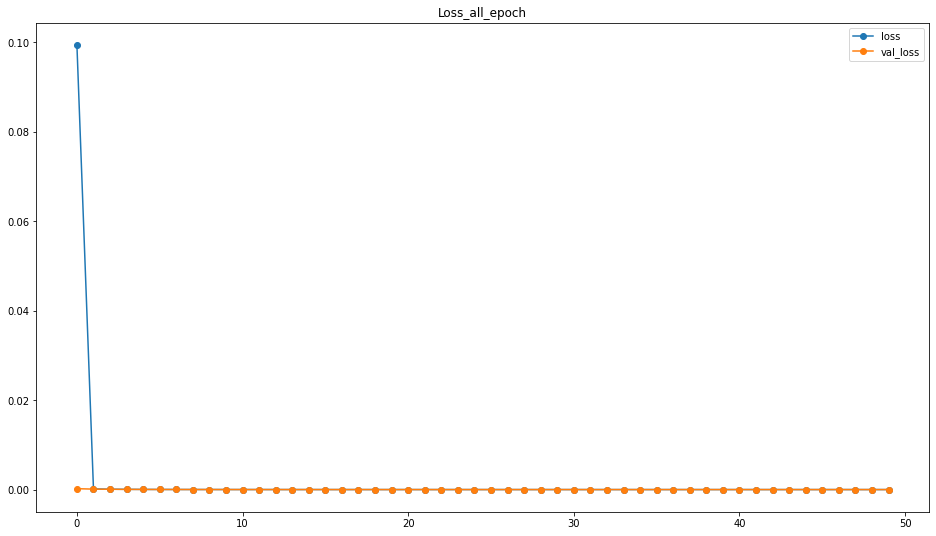

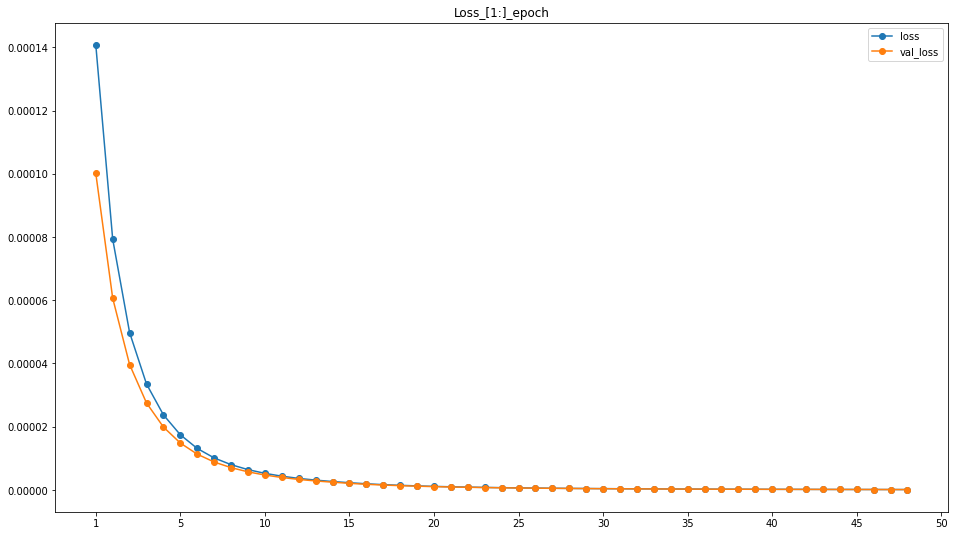

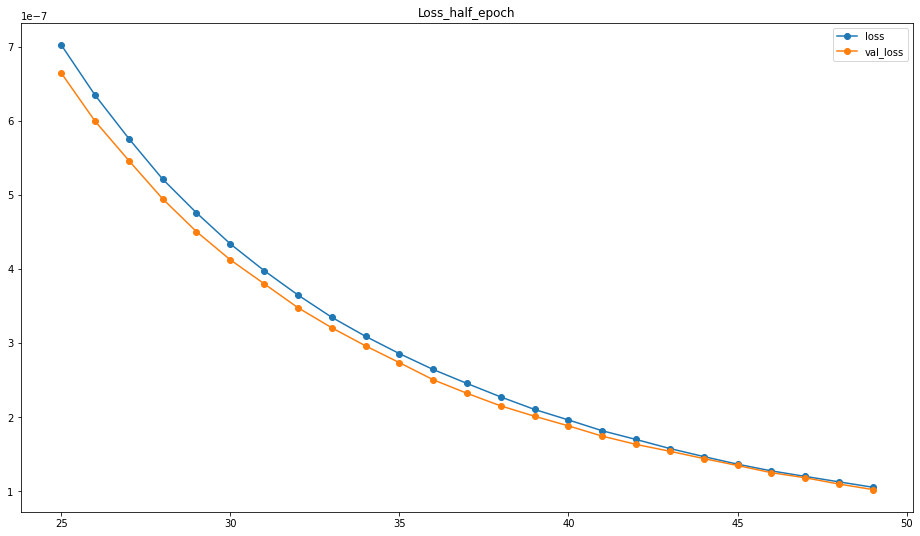

In [13]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [14]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 3s 94us/step


In [15]:
print (scores)

[0.014213111260519402, 0.9946787357330322]


In [16]:
prediction = model.predict(test_data)

In [17]:
print(prediction)

[[9.9999928e-01 3.1331348e-07 5.9570276e-08 2.9368280e-07]
 [9.9999750e-01 1.8172243e-06 1.8413589e-07 5.0379356e-07]
 [9.9999809e-01 9.7293650e-07 6.8438673e-08 9.3307352e-07]
 ...
 [3.2380686e-07 2.9814078e-07 8.2596347e-07 9.9999857e-01]
 [2.5027910e-07 2.5048206e-07 1.1926185e-06 9.9999833e-01]
 [3.1776949e-07 6.9108793e-08 3.2524096e-07 9.9999928e-01]]


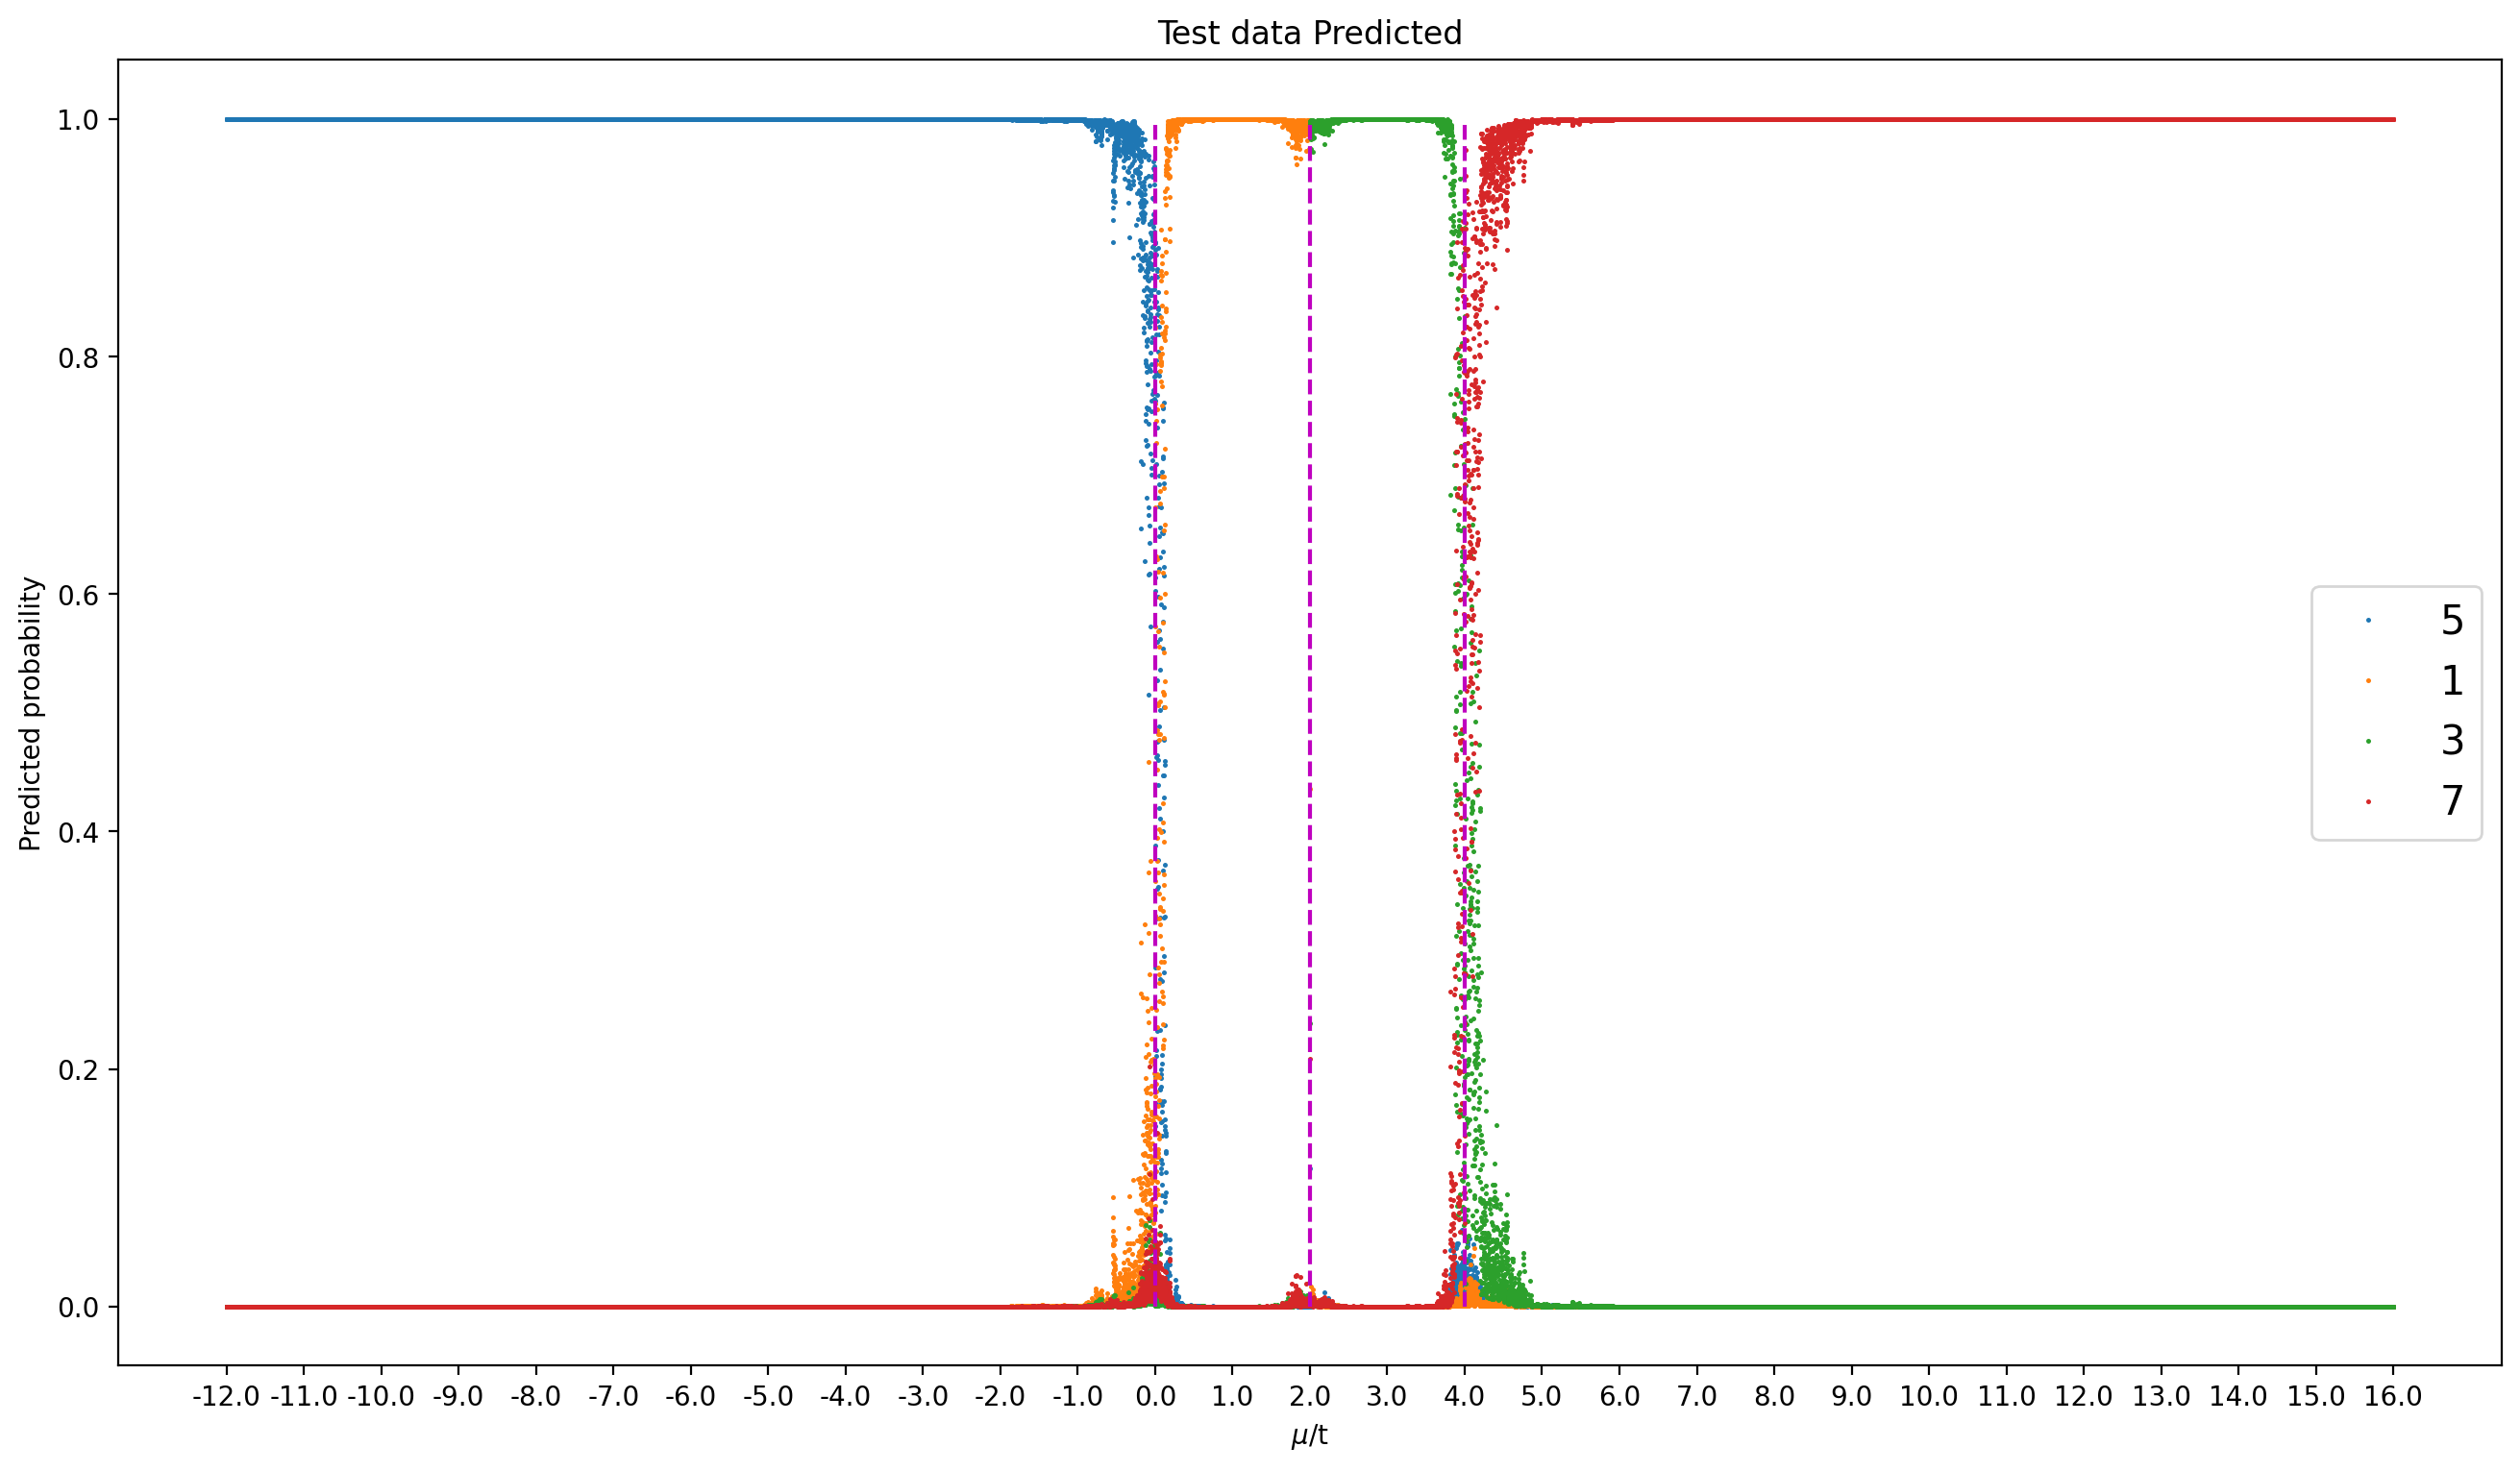

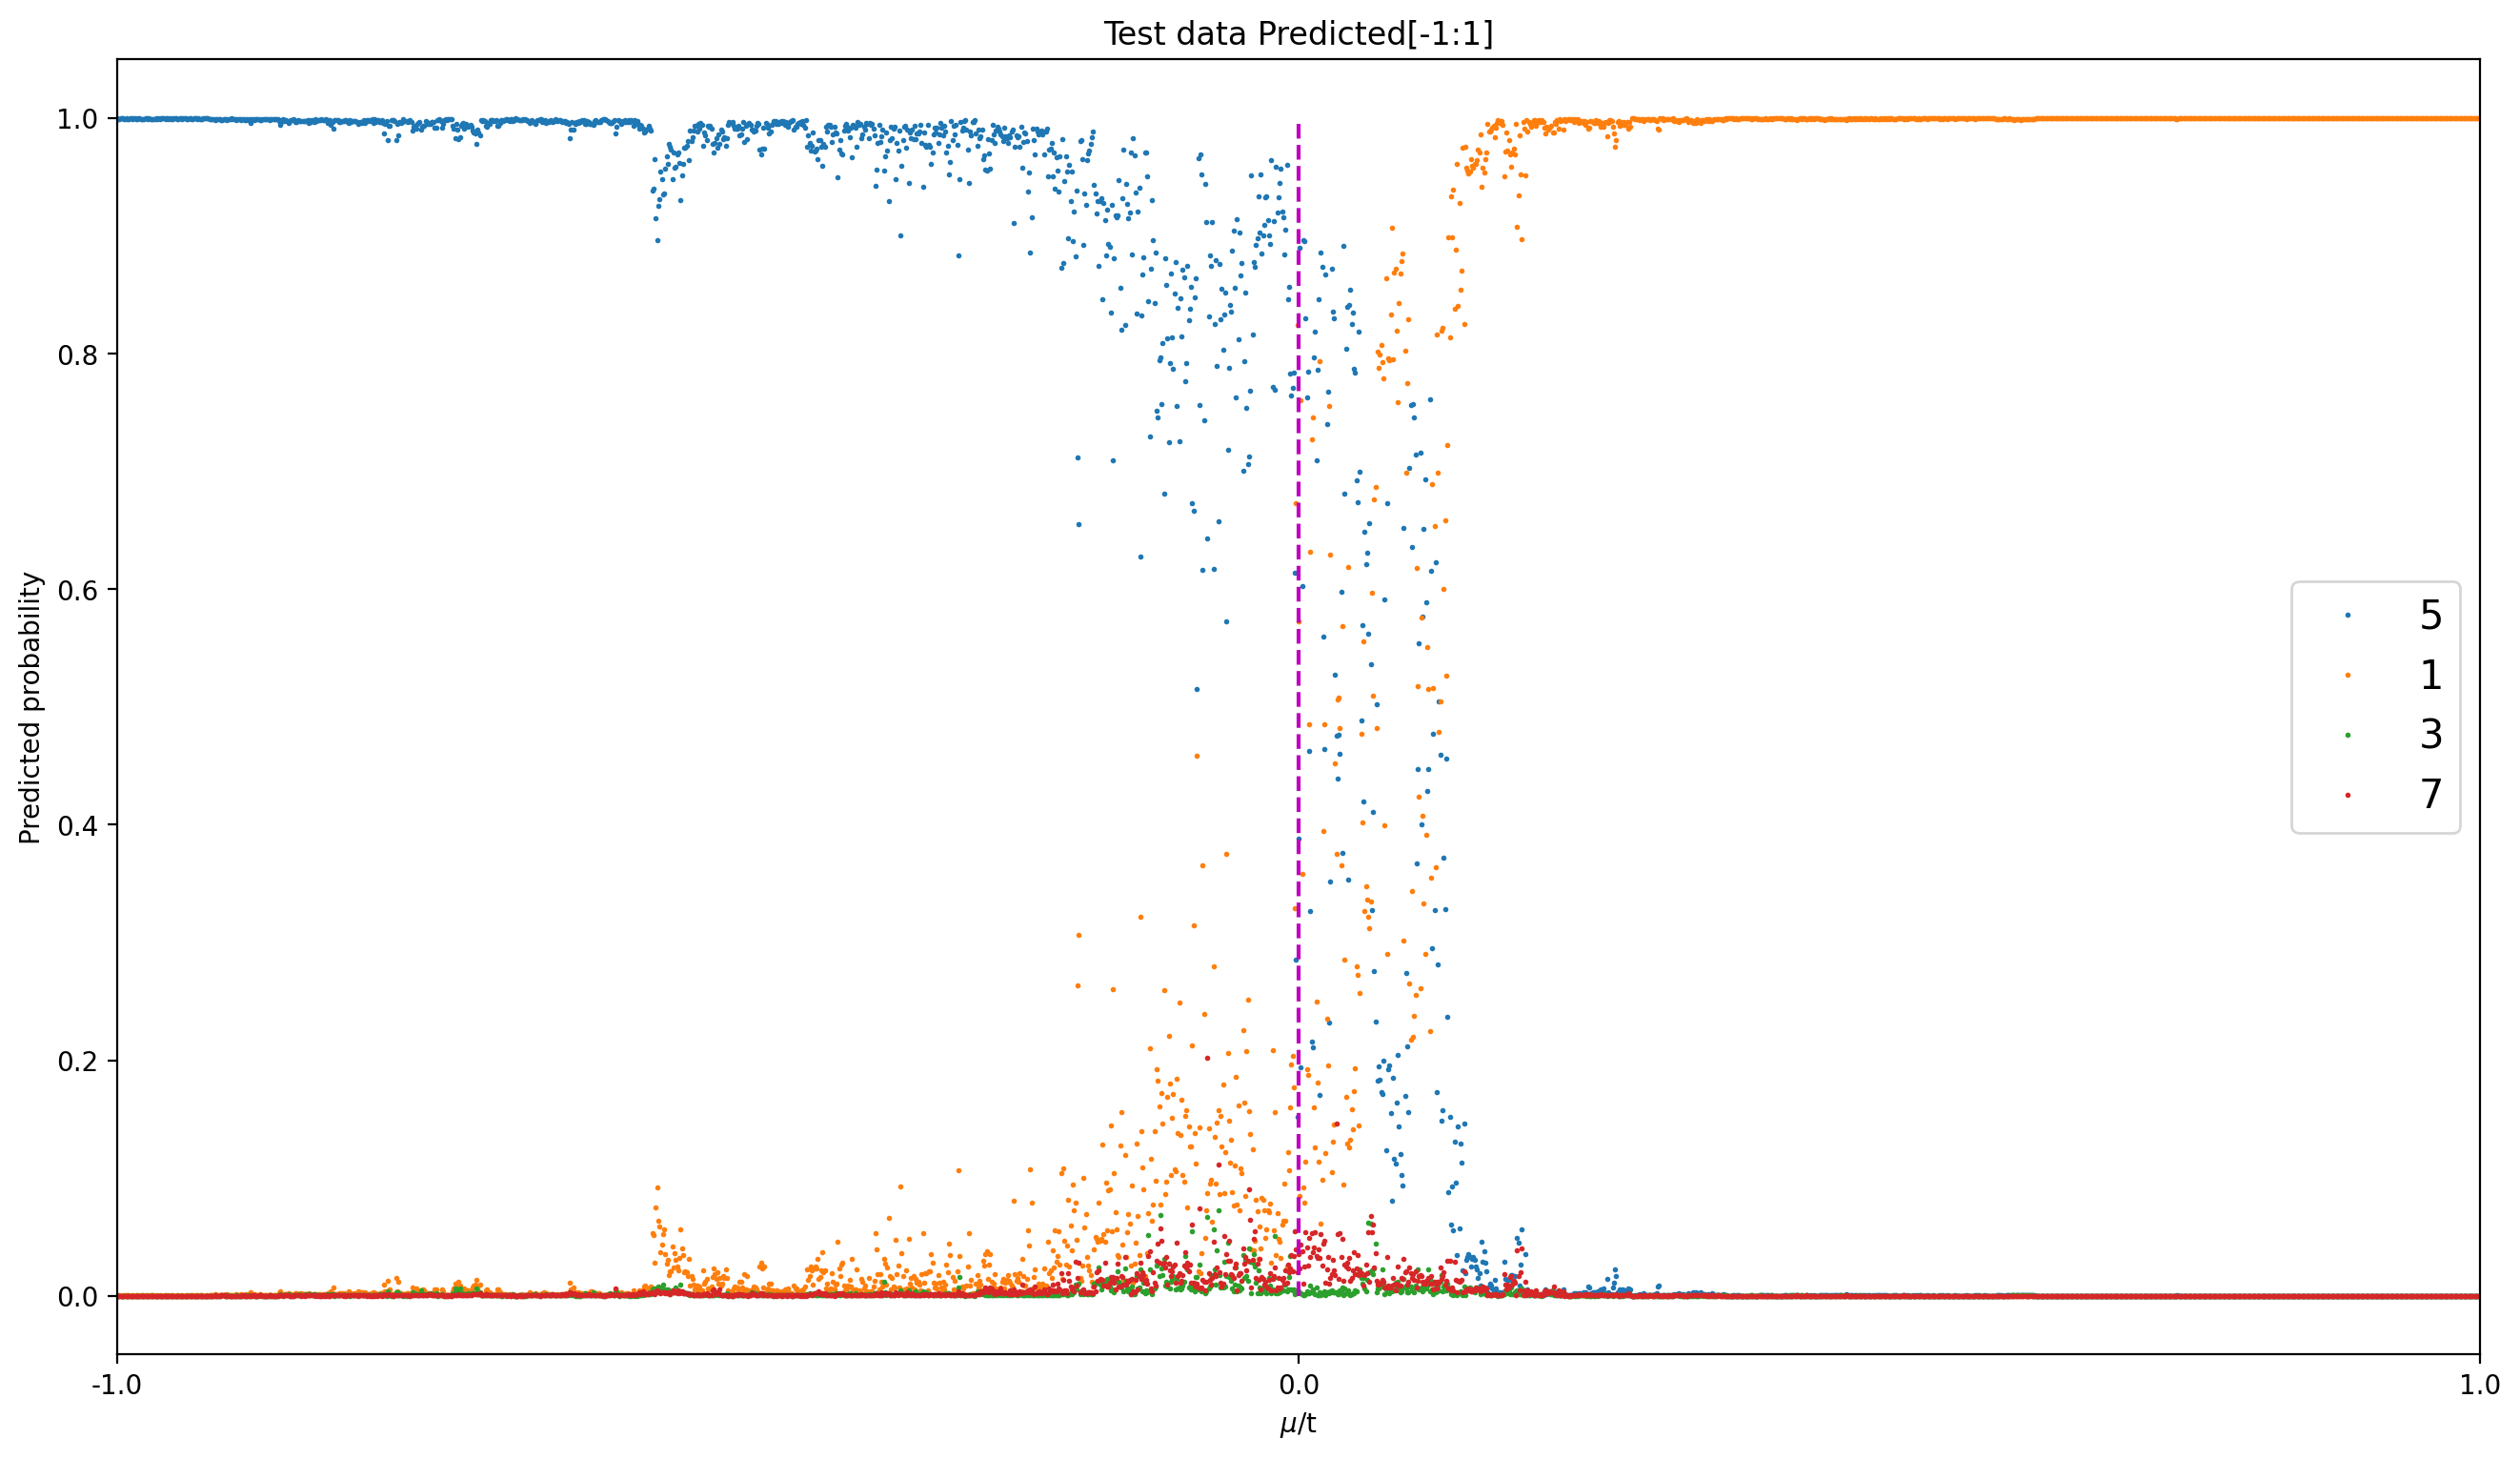

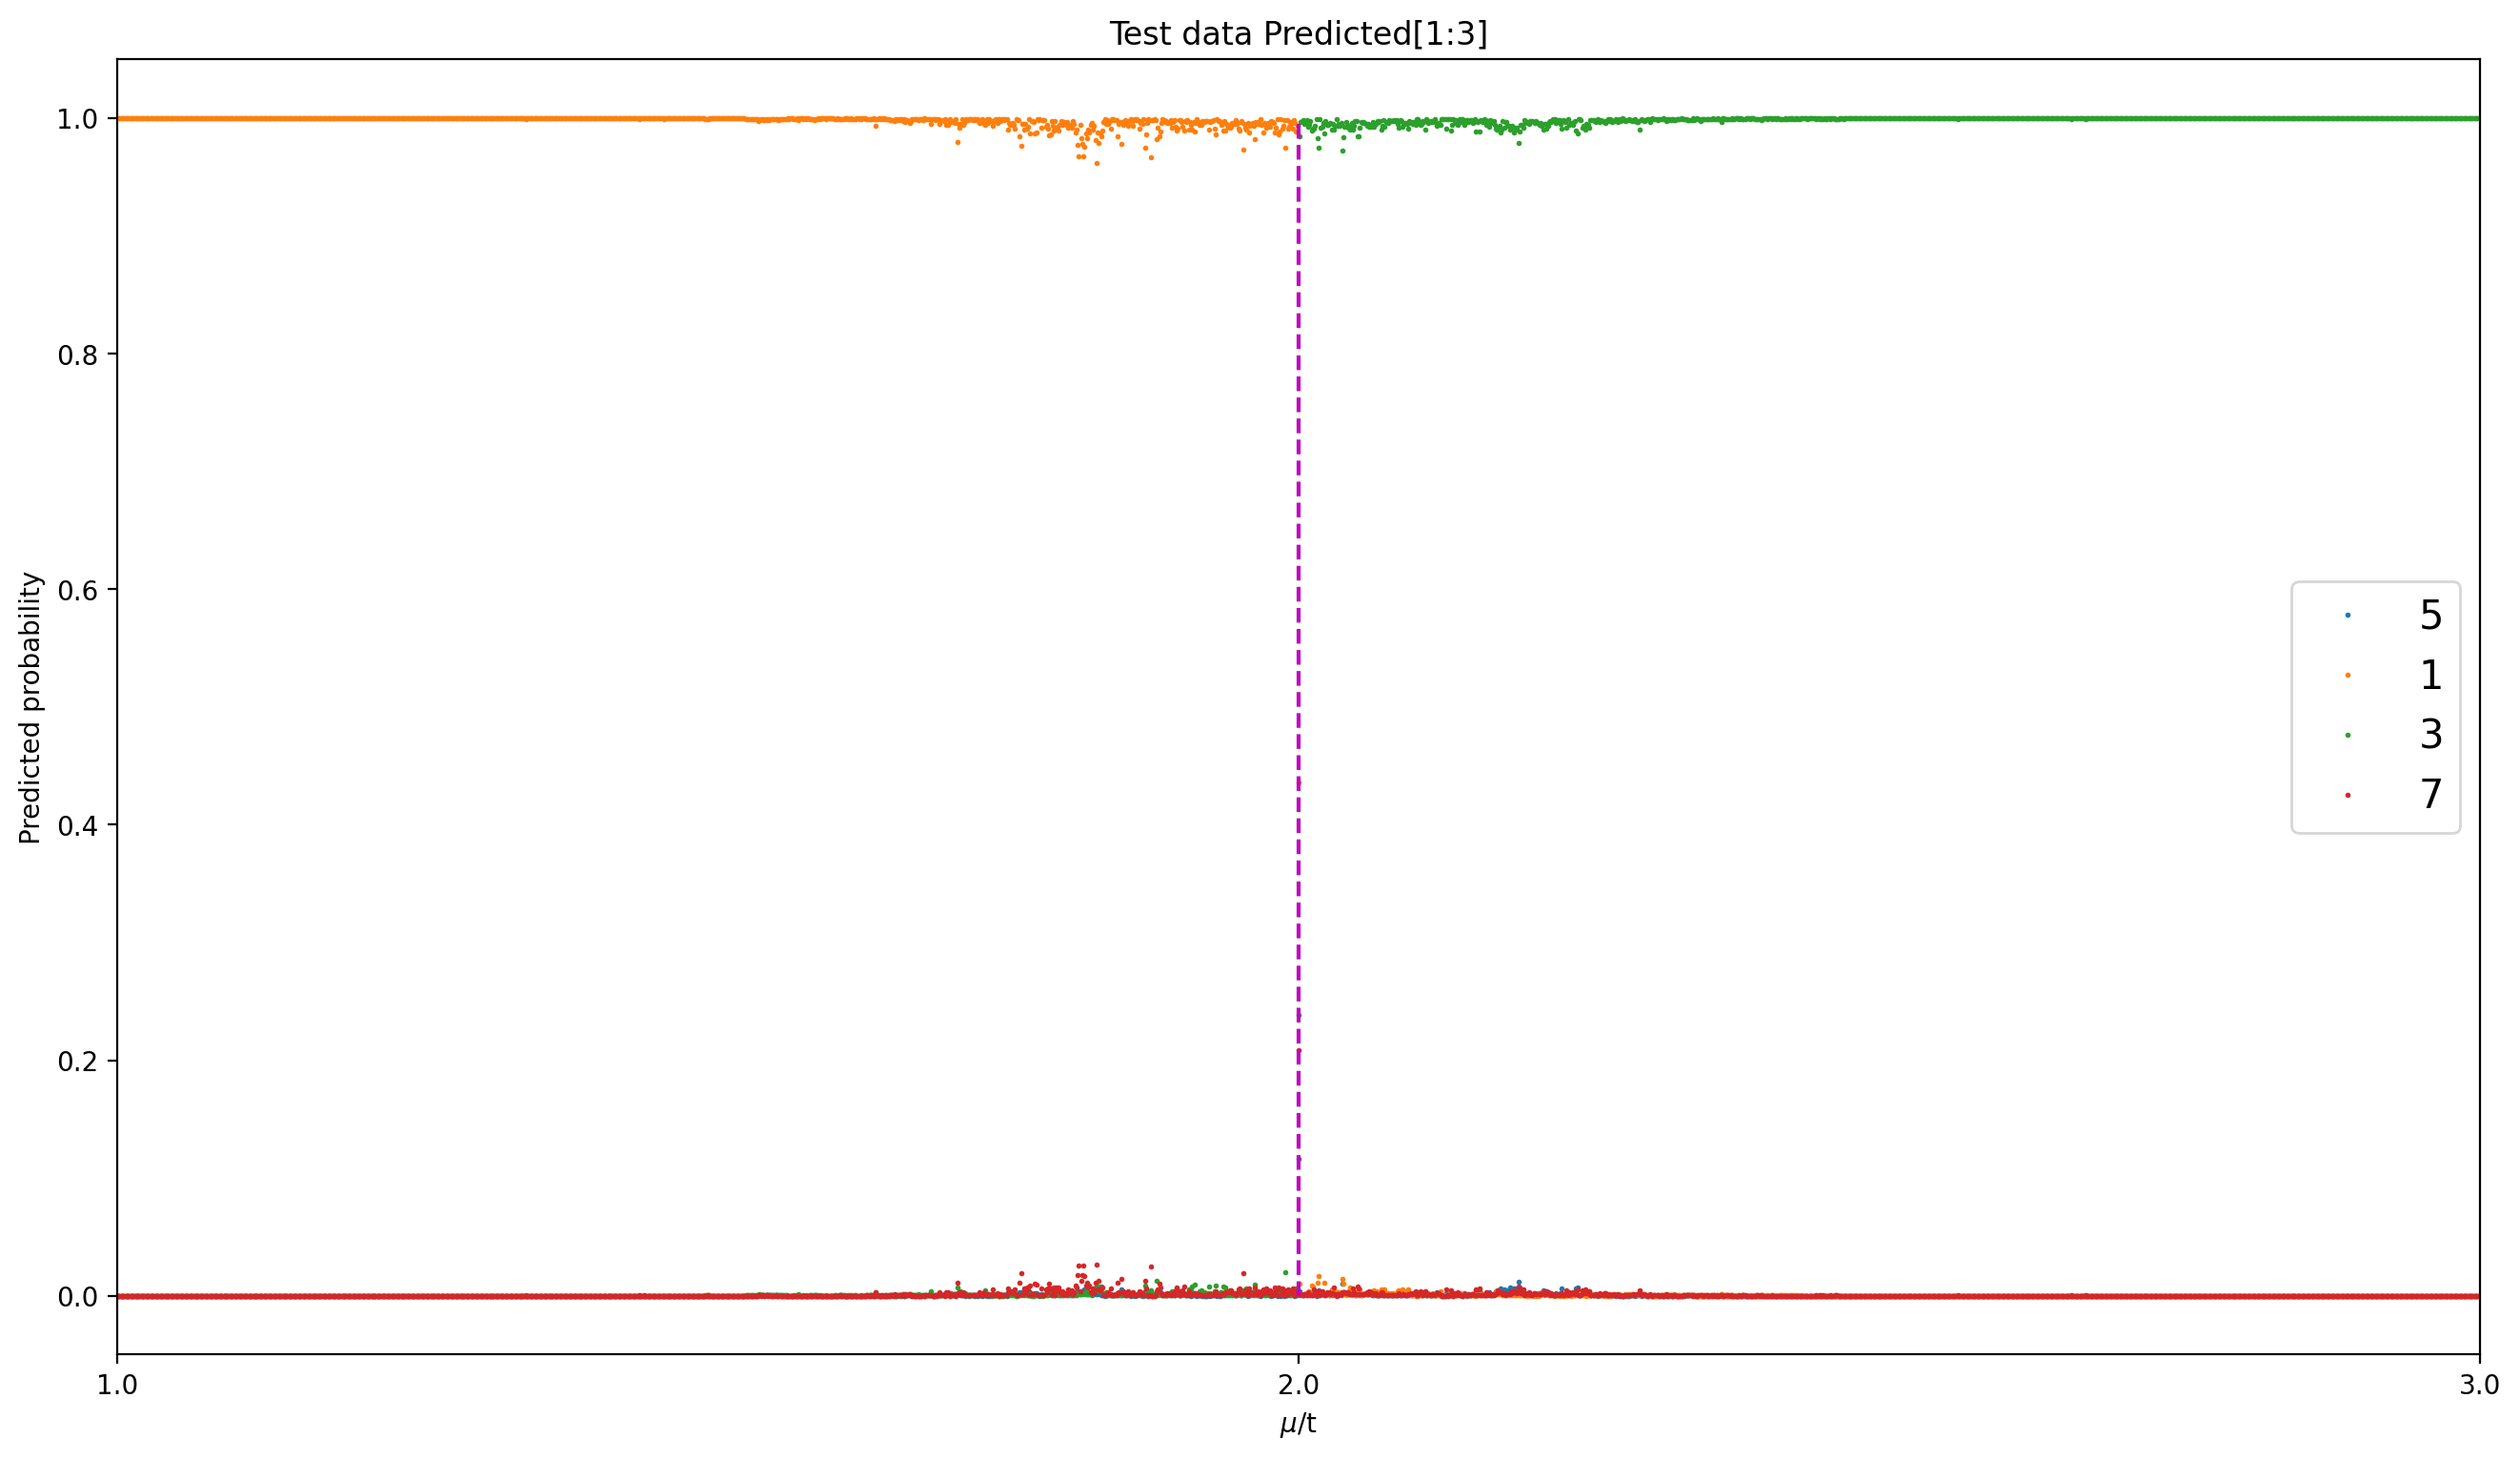

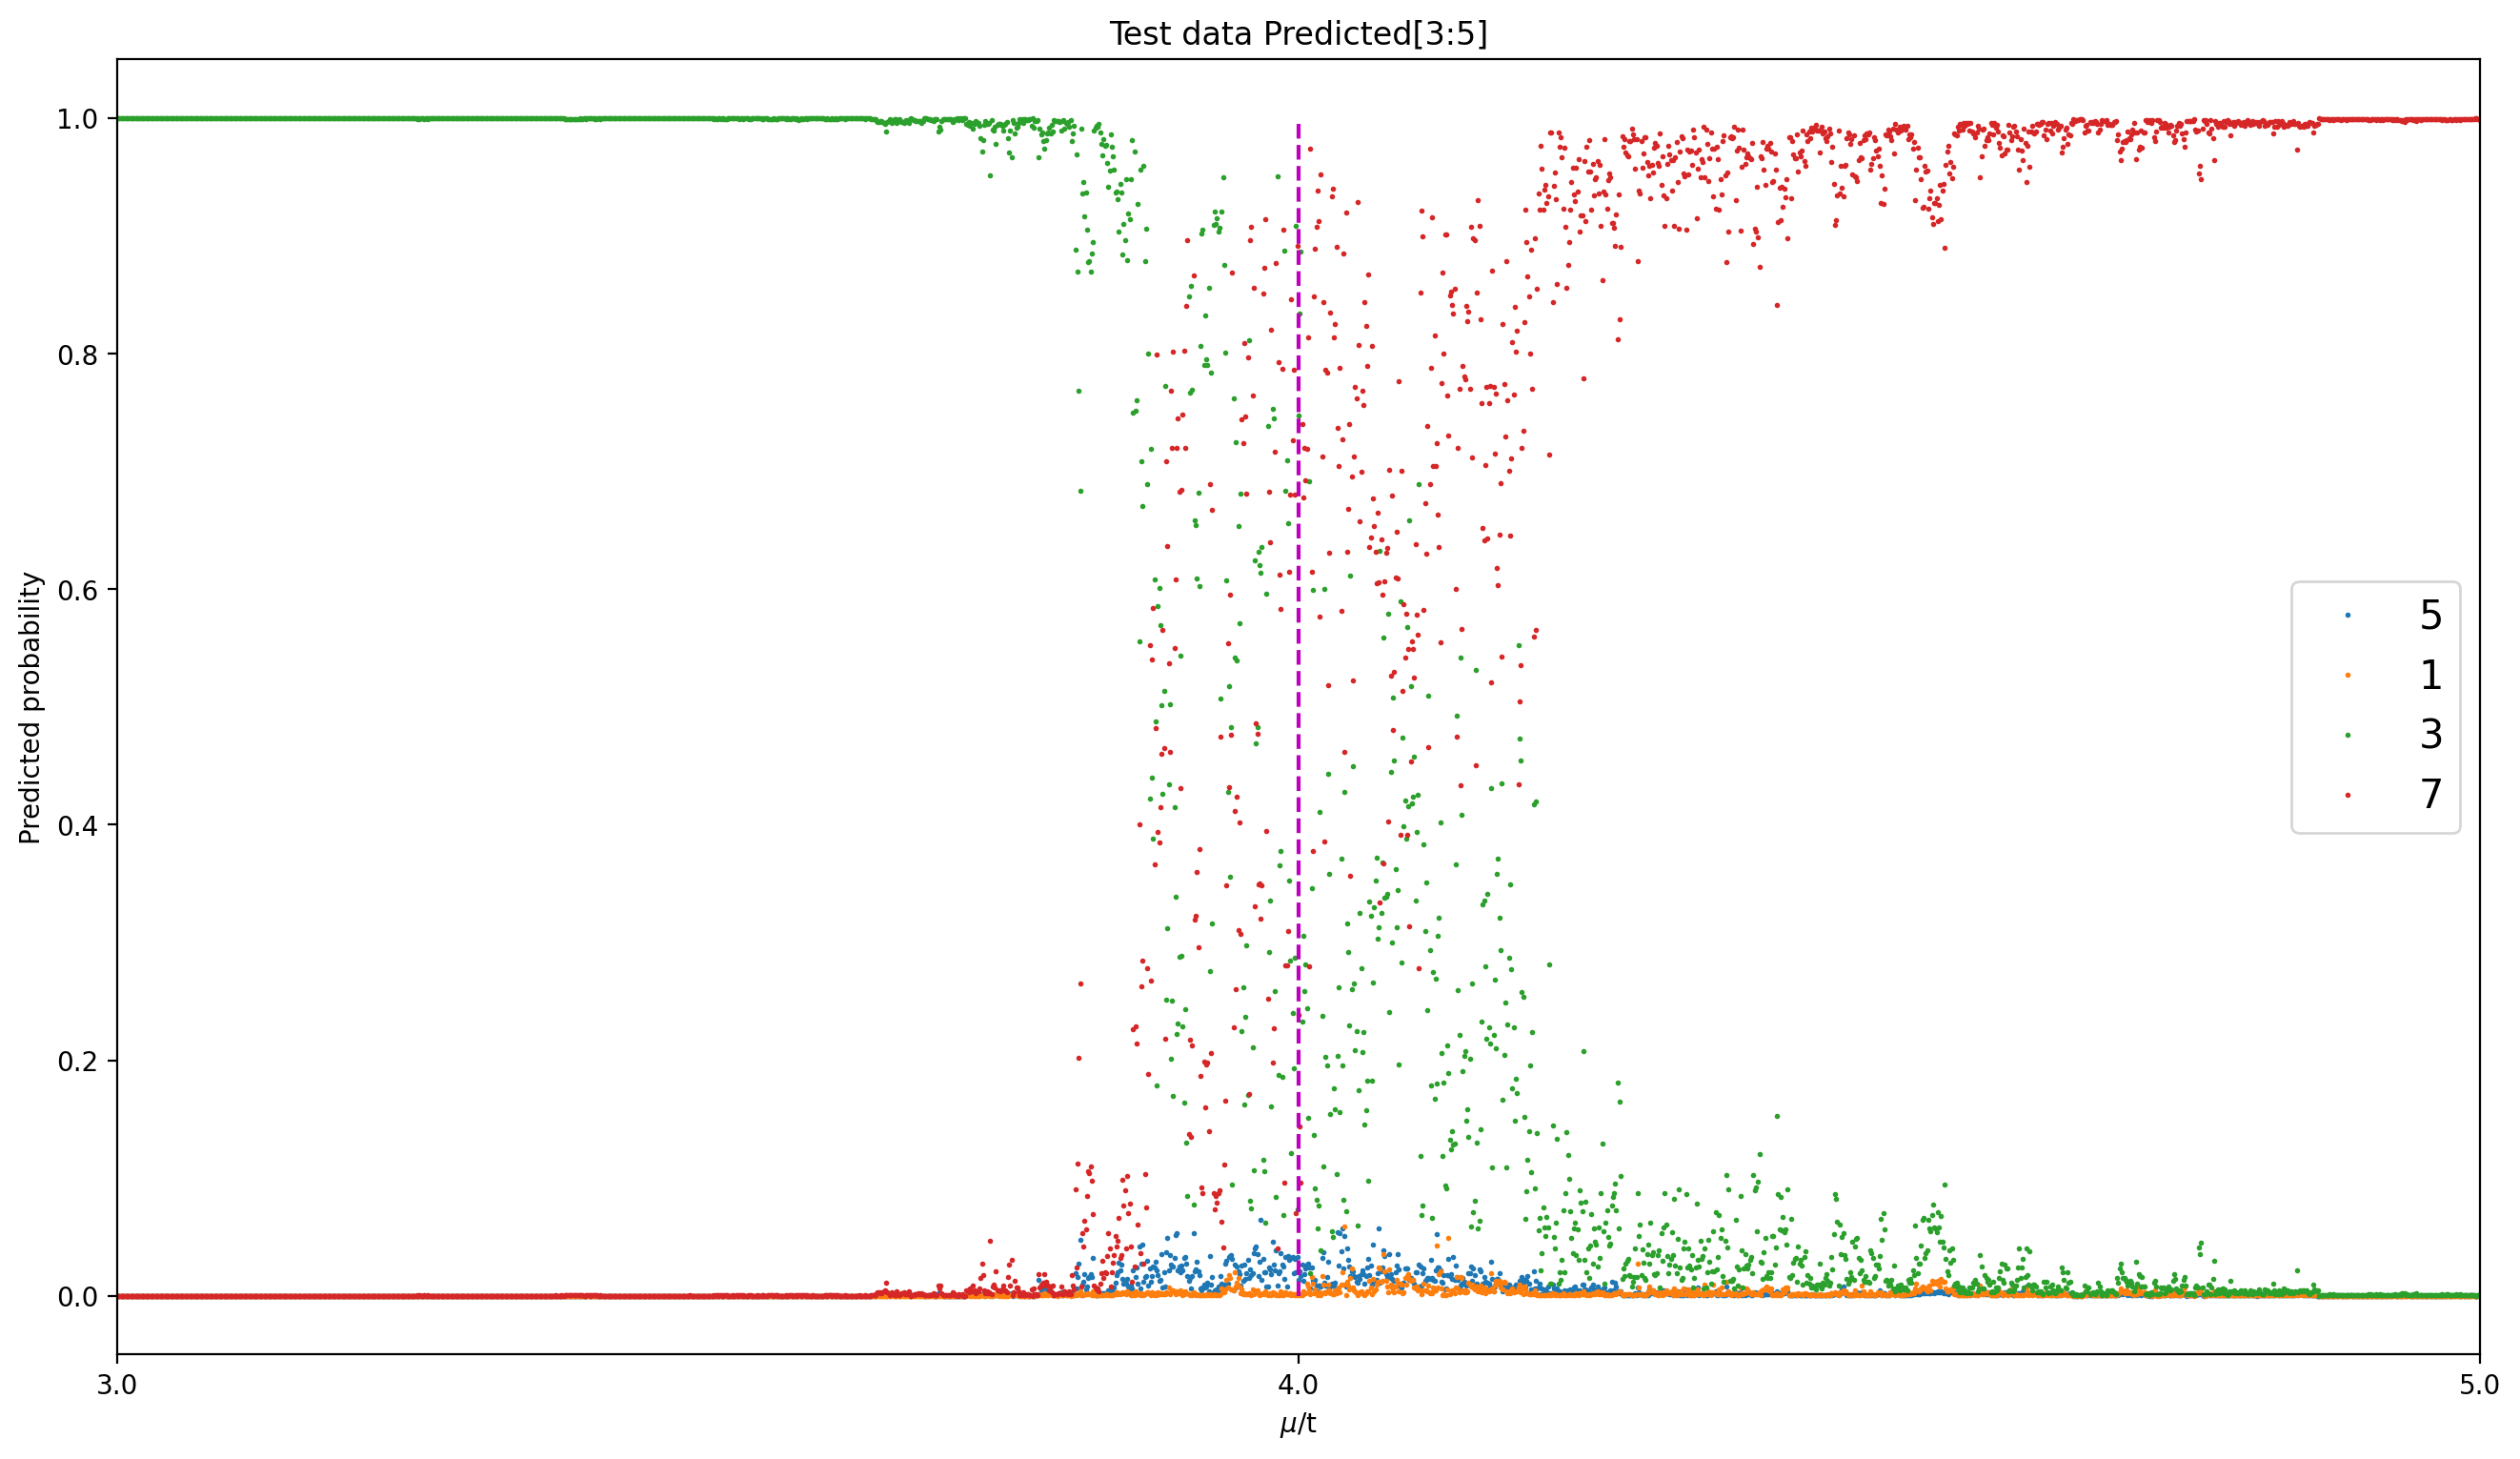

In [18]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_3D

開始獲取eigenvector_r_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [19]:
train_data = get_train_data(train_data_path, date, N, delta)[5]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[5]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 50, 5, 5)
(4000,)
(4000, 4)
(28001, 50, 5, 5)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [20]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [21]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 50, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 50, 5, 5)
(3200, 4)
Number validation data = 
(800, 50, 5, 5)
(800, 4)


開始架構網路

In [22]:
channel = 2*(NN**2)

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 100, 5, 5)         45100     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 3, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 150, 3, 3)         135150    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 150, 2, 2)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               307712    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                

In [23]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [24]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 180us/step - loss: 1.1299 - accuracy: 0.4809 - val_loss: 0.8272 - val_accuracy: 0.5088
Epoch 2/50
3200/3200 [==============================] - 0s 108us/step - loss: 0.7368 - accuracy: 0.5000 - val_loss: 0.7028 - val_accuracy: 0.4913
Epoch 3/50
3200/3200 [==============================] - 0s 109us/step - loss: 0.7027 - accuracy: 0.5003 - val_loss: 0.6988 - val_accuracy: 0.4888
Epoch 4/50
3200/3200 [==============================] - 0s 105us/step - loss: 0.7007 - accuracy: 0.4994 - val_loss: 0.6992 - val_accuracy: 0.4888
Epoch 5/50
3200/3200 [==============================] - 0s 111us/step - loss: 0.6988 - accuracy: 0.4919 - val_loss: 0.7042 - val_accuracy: 0.4888
Epoch 6/50
3200/3200 [==============================] - 0s 115us/step - loss: 0.6992 - accuracy: 0.5041 - val_loss: 0.6998 - val_accuracy: 0.5113
Epoch 7/50
3200/3200 [==============================] - 0s 108us/step - loss:

訓練完成  
開始提取模型資料

In [25]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


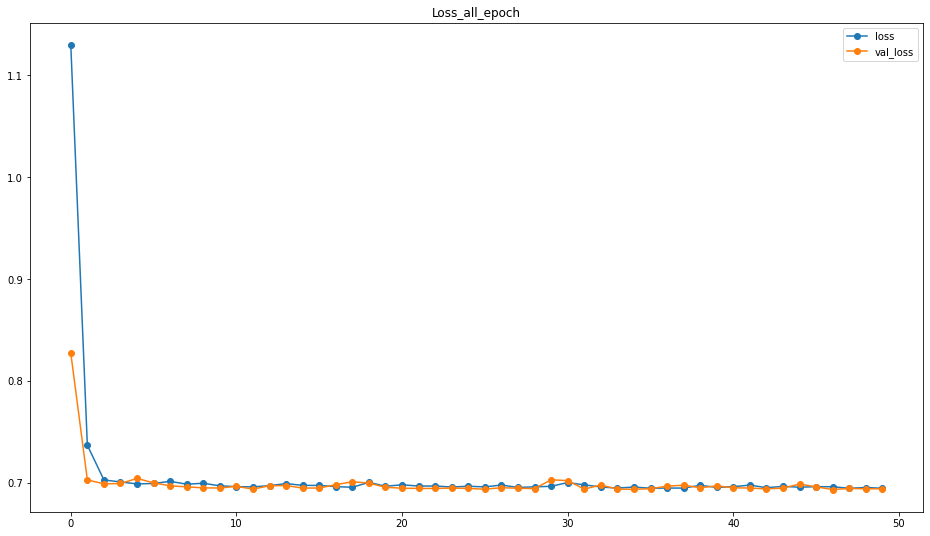

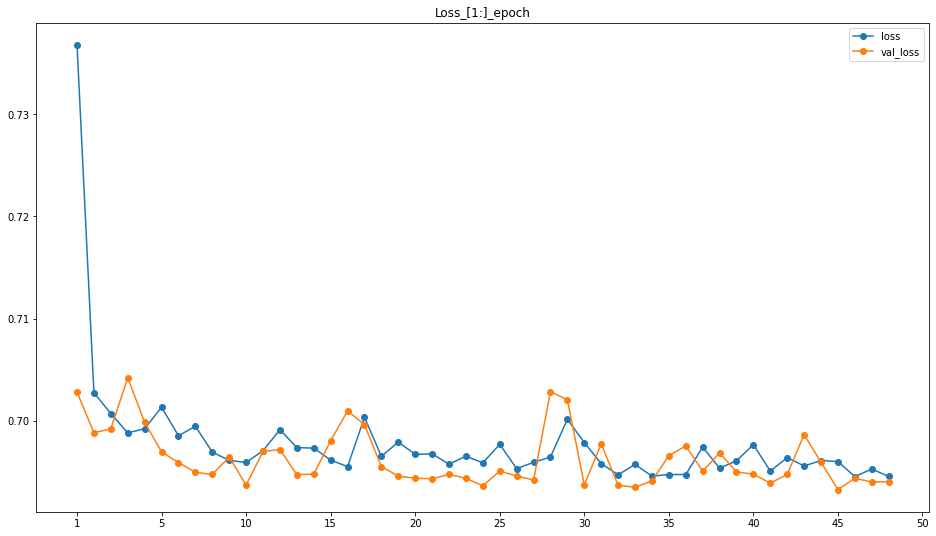

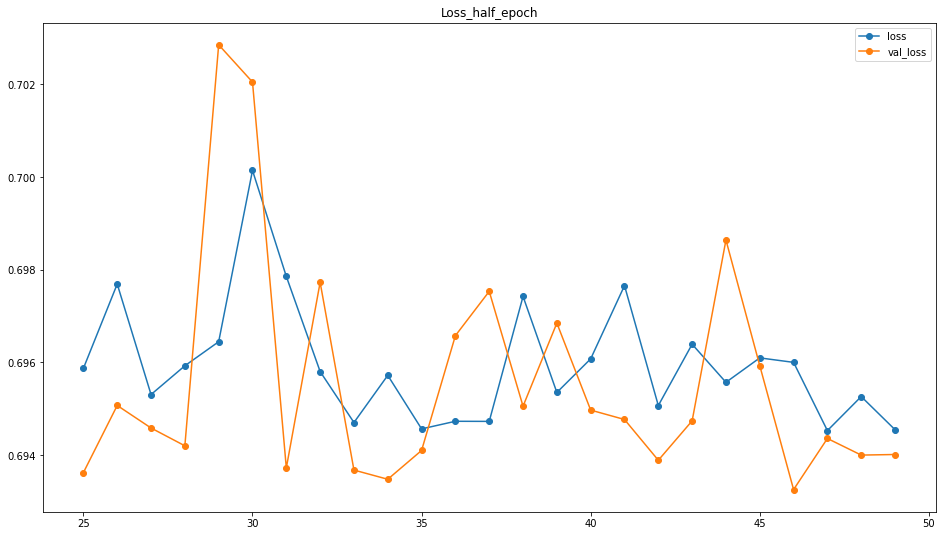

In [26]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [27]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 70us/step


In [28]:
print (scores)

[0.8379664815458621, 0.4704117774963379]


In [29]:
prediction = model.predict(test_data)

In [30]:
print(prediction)

[[4.91407096e-01 1.05028608e-04 8.30672725e-05 5.08404732e-01]
 [4.91408408e-01 1.05040963e-04 8.30776771e-05 5.08403420e-01]
 [4.91408527e-01 1.05055864e-04 8.30918434e-05 5.08403301e-01]
 ...
 [4.91407543e-01 1.05031526e-04 8.30699064e-05 5.08404315e-01]
 [4.91406828e-01 1.05043298e-04 8.30794452e-05 5.08405030e-01]
 [4.91406858e-01 1.05033869e-04 8.30721401e-05 5.08404970e-01]]


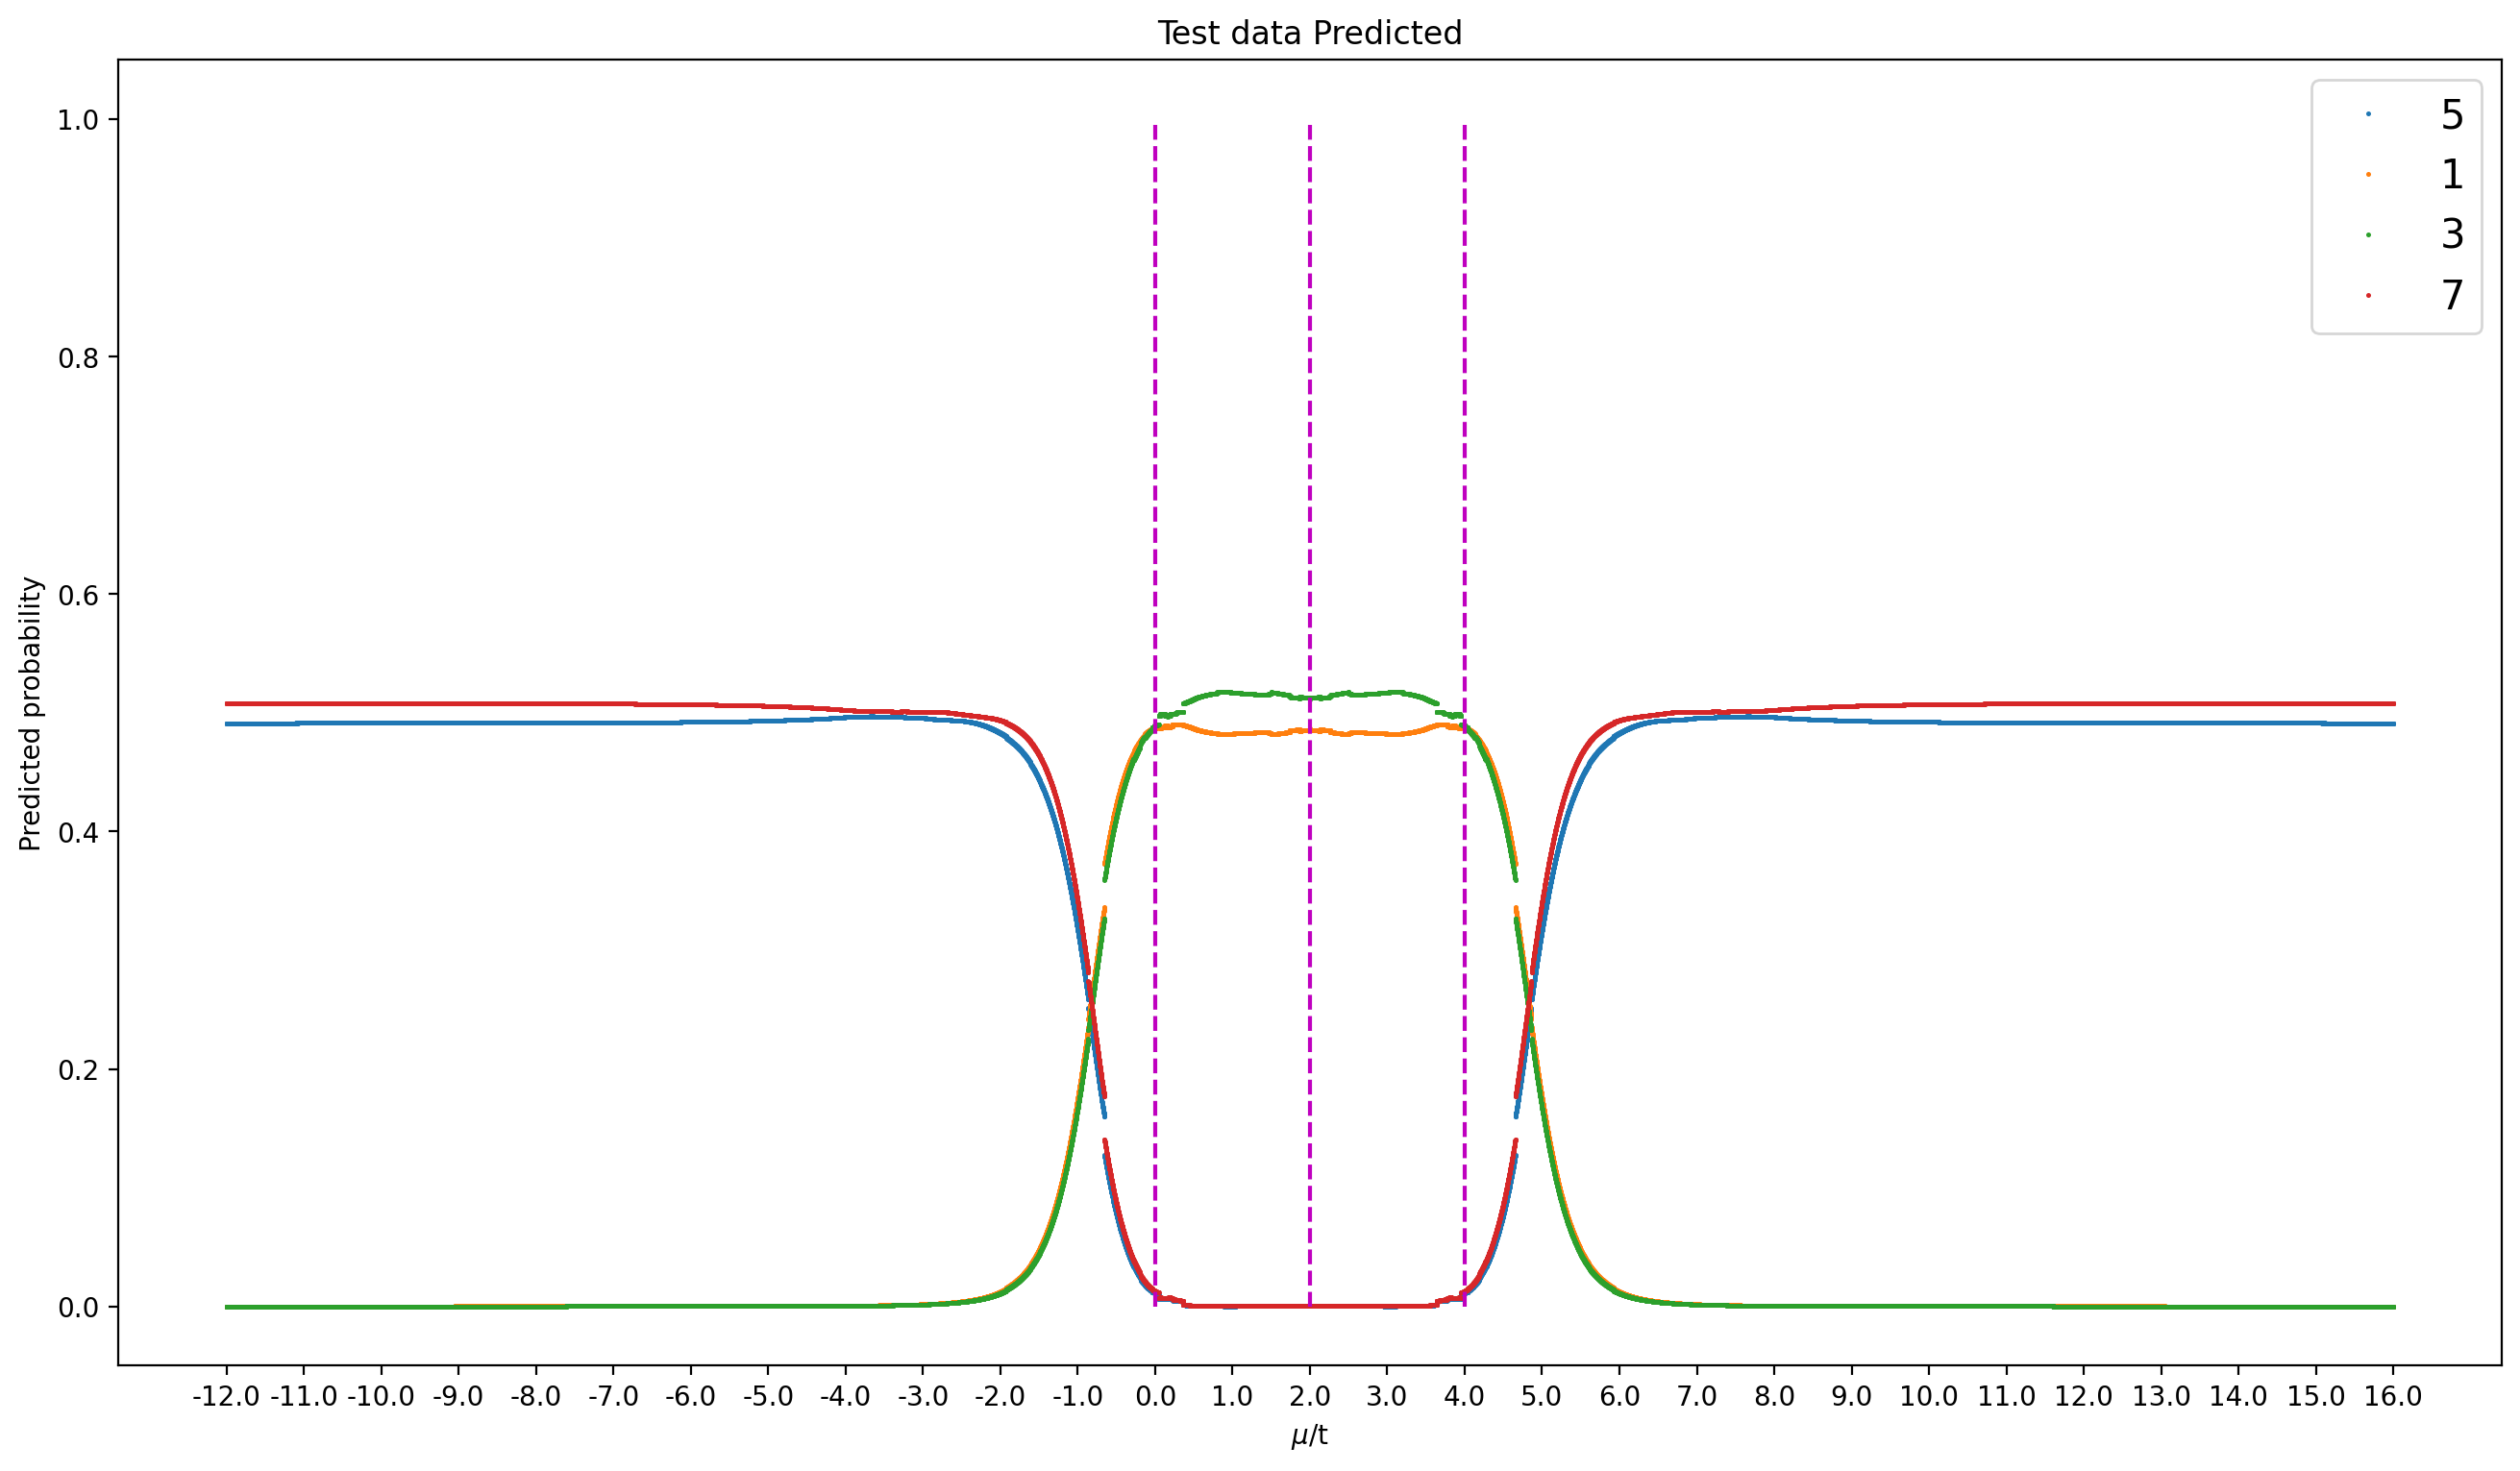

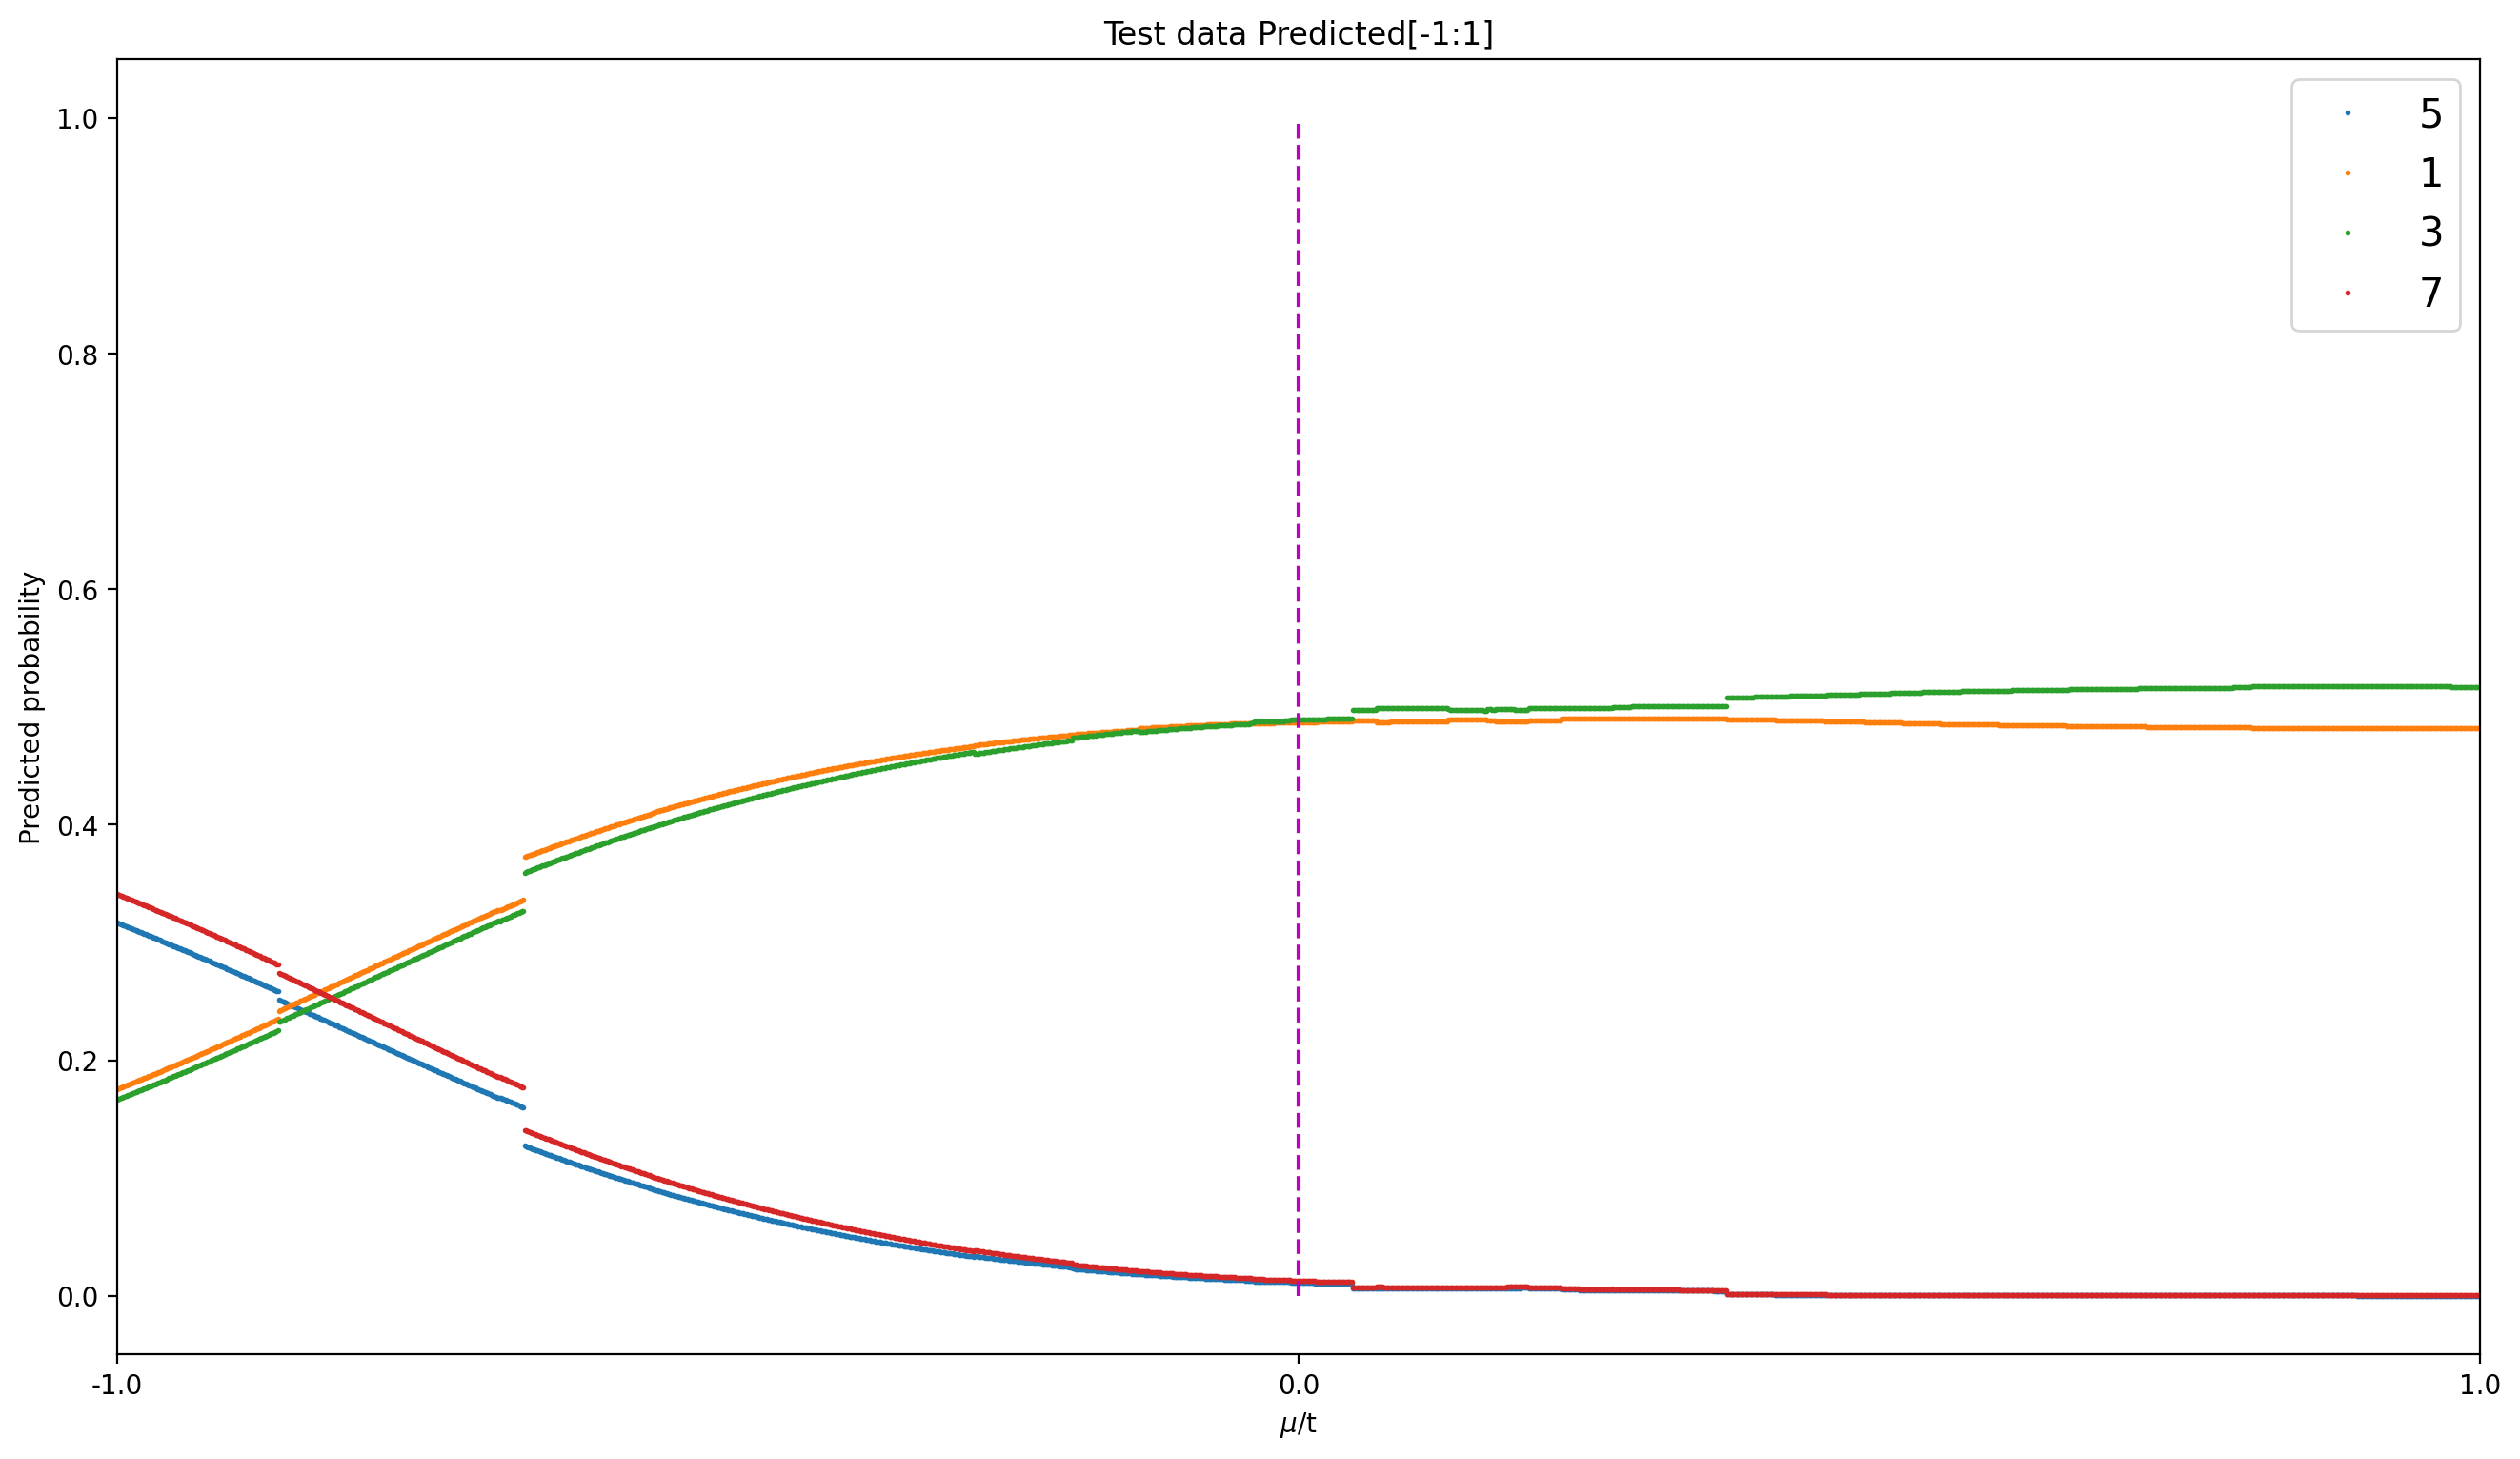

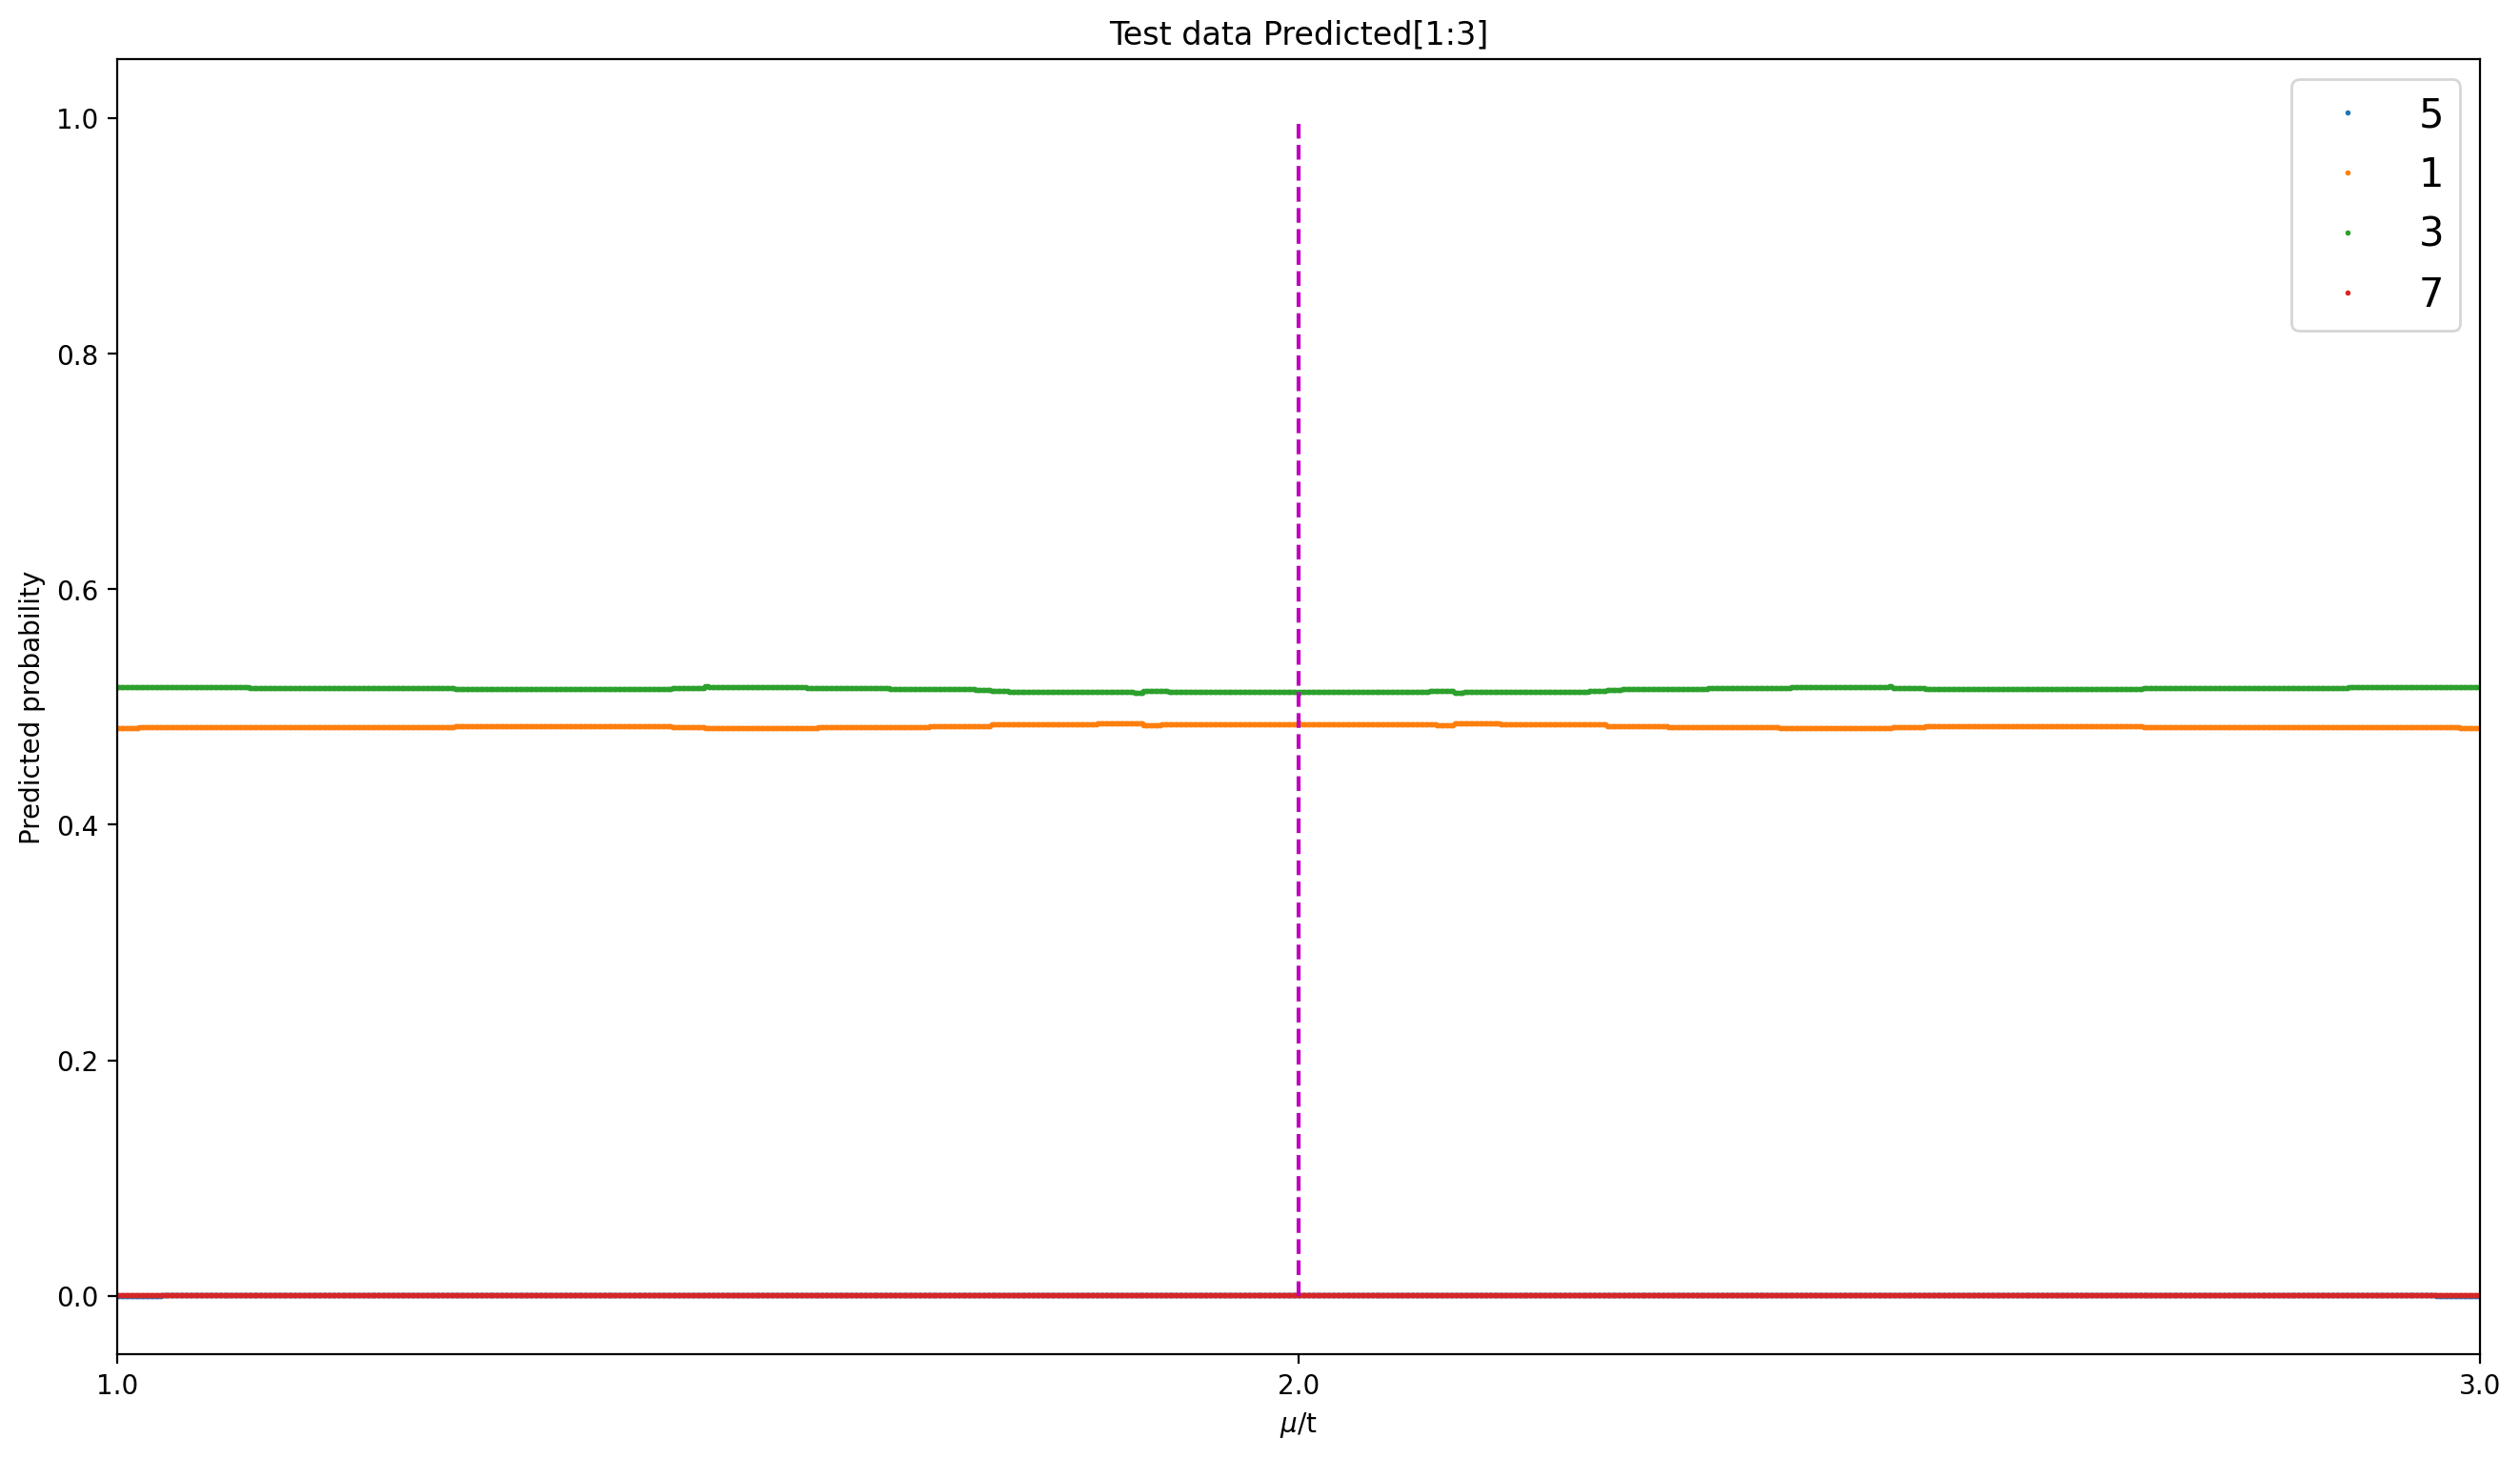

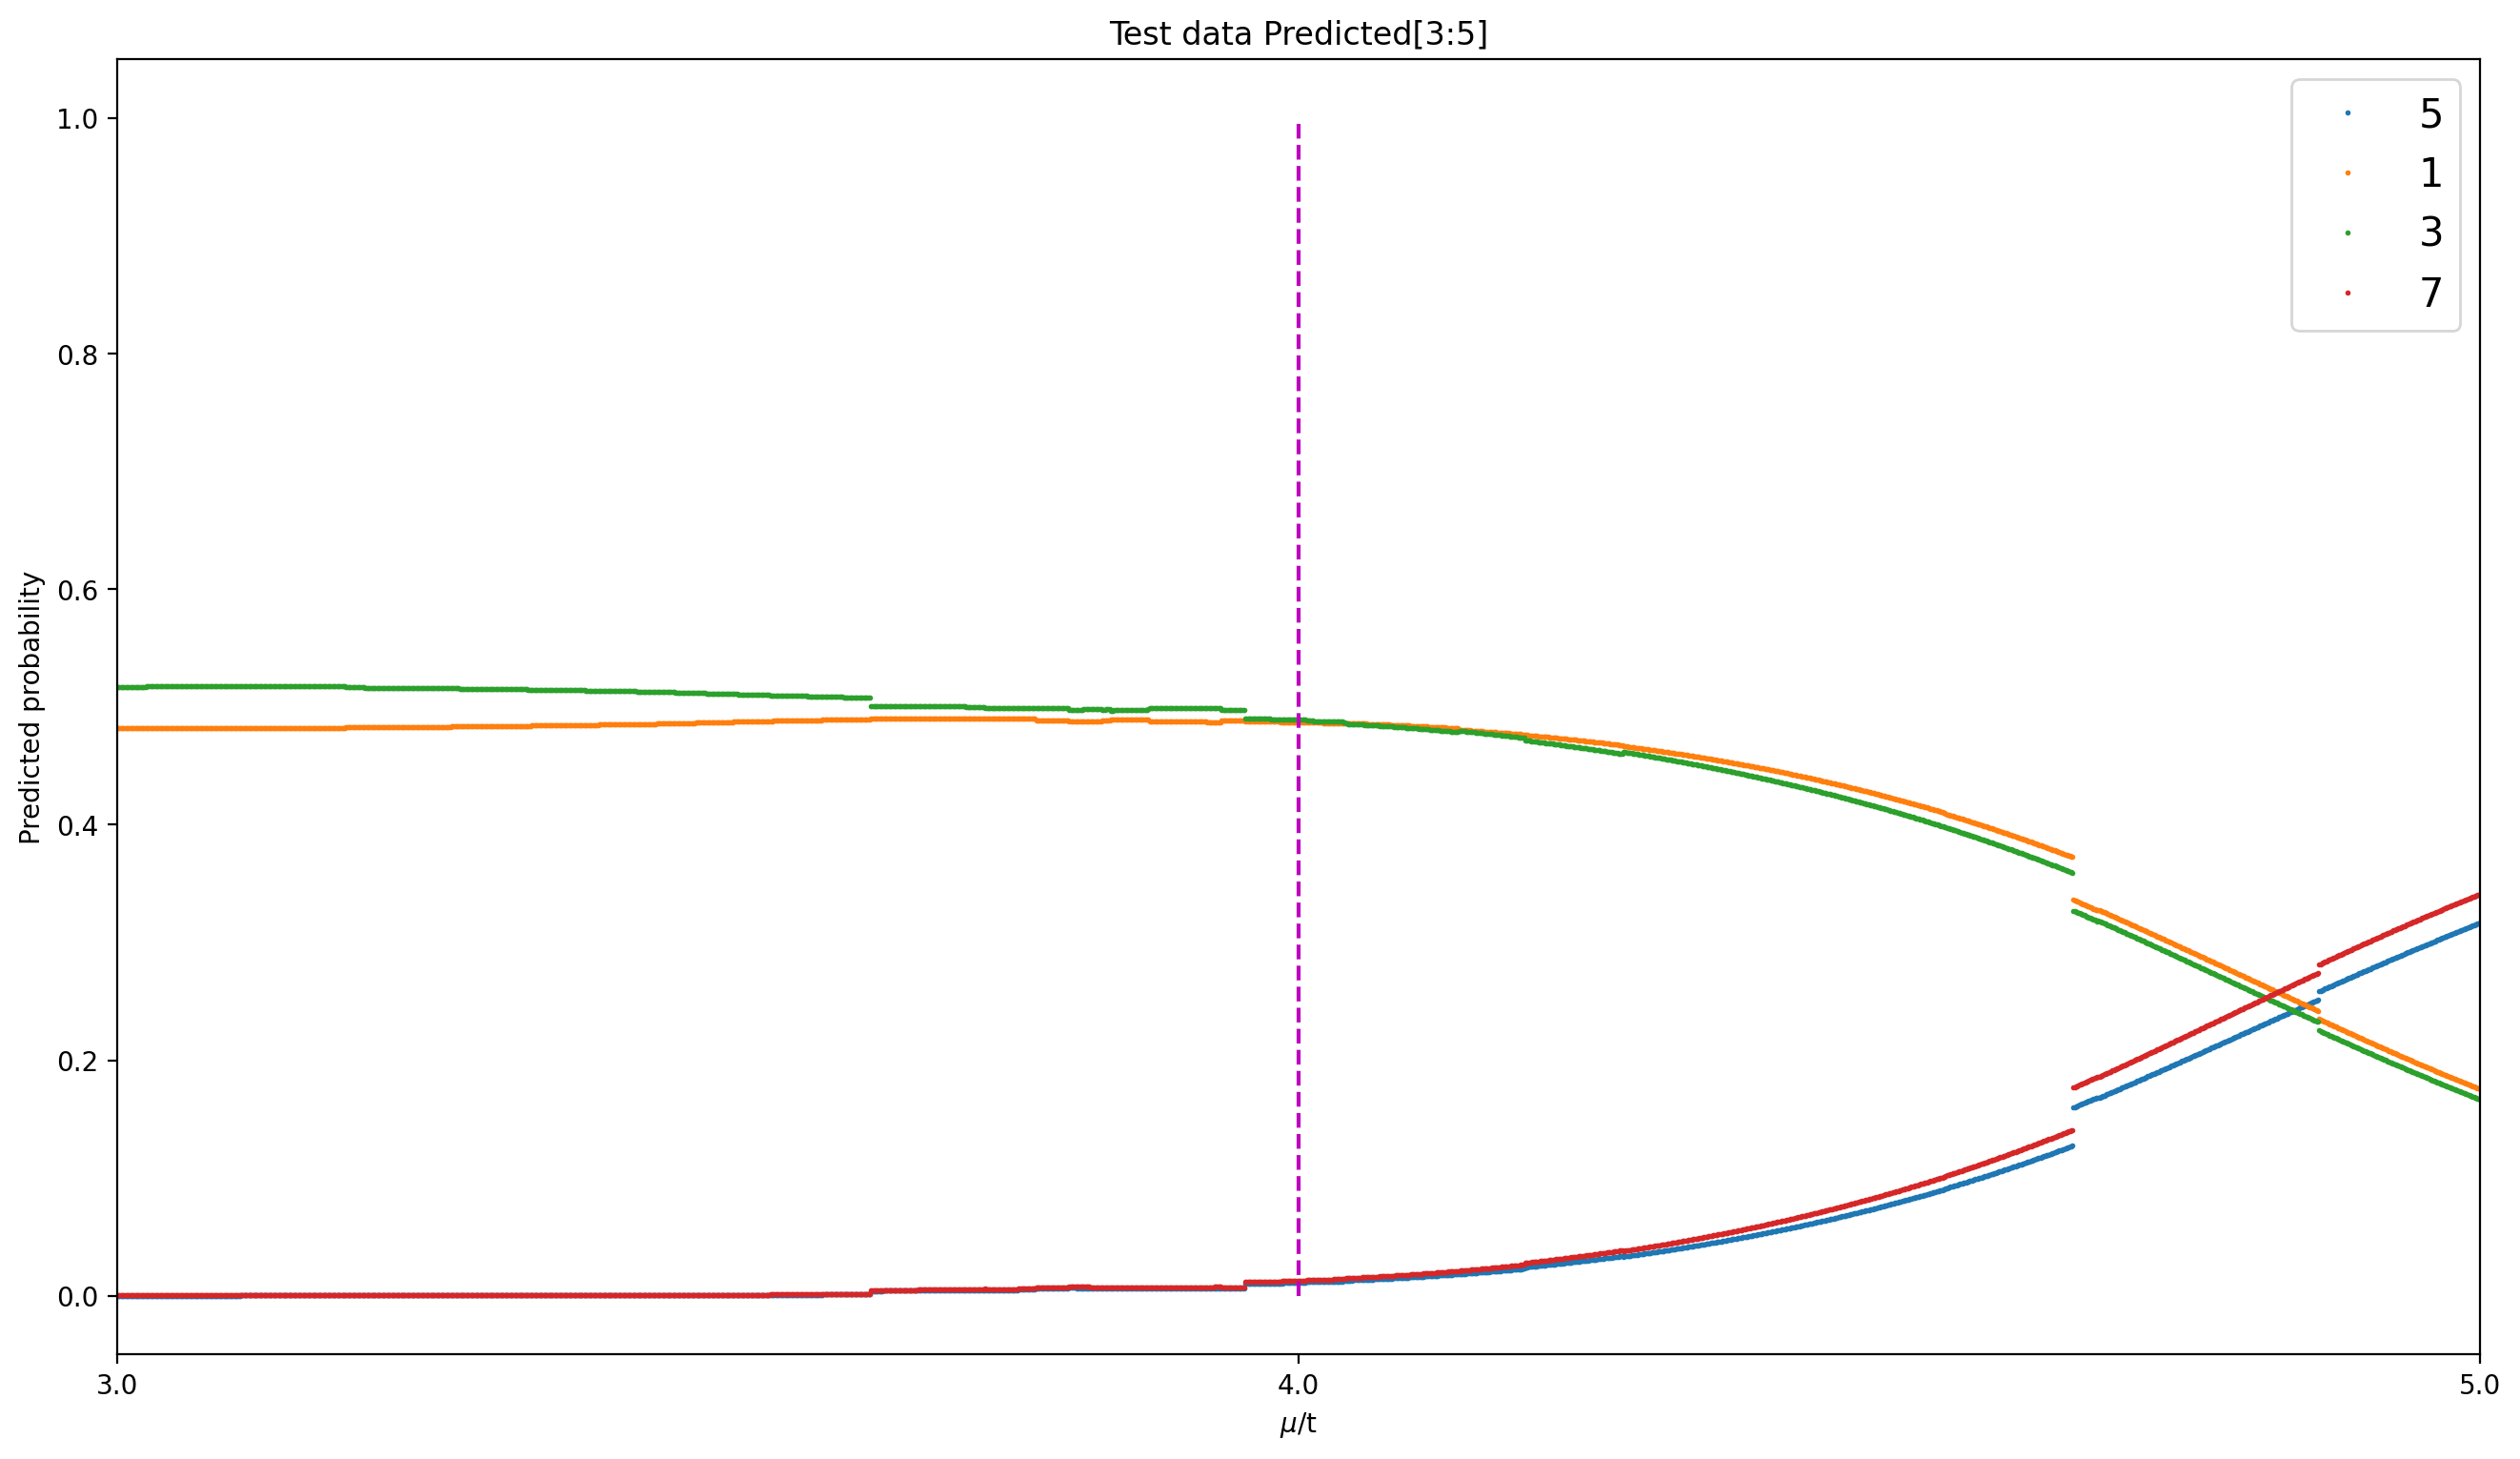

In [31]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D

開始獲取eigenvector_r_theta_4D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [32]:
train_data = get_train_data(train_data_path, date, N, delta)[4]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 50, 5, 5, 3)
(4000,)
(4000, 4)
(28001, 50, 5, 5, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [33]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [34]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 50, 5, 5, 3)
(4000, 4)
Number of real trian data = 
(3200, 50, 5, 5, 3)
(3200, 4)
Number validation data = 
(800, 50, 5, 5, 3)
(800, 4)


開始架構網路

In [35]:
channel = 2*(NN**2)

model = Sequential()

model.add(Conv3D(batch_input_shape = (None, channel, NN, NN, 3),
                 filters = 2*channel,
                 kernel_size = (3,3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size = (2,2,2),
                       data_format = 'channels_first',
                       padding = 'same')
         )

model.add(Conv3D(filters = 3*channel, 
                 kernel_size = (3,3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size=(2,2,2),
                       data_format='channels_first',
                       padding = 'same')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 100, 5, 5, 3)      135100    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 100, 3, 3, 2)      0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 150, 3, 3, 2)      405150    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 150, 2, 2, 1)      0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 600)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               307712    
_________________________________________________________________
dense_8 (Dense)              (None, 4)                

In [36]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [37]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 217us/step - loss: 0.2209 - accuracy: 0.9841 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 128us/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 9.4708e-04 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 133us/step - loss: 6.9734e-04 - accuracy: 1.0000 - val_loss: 4.9794e-04 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 134us/step - loss: 3.8402e-04 - accuracy: 1.0000 - val_loss: 2.8835e-04 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 131us/step - loss: 2.3240e-04 - accuracy: 1.0000 - val_loss: 1.8252e-04 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 135us/step - loss: 1.5322e-04 - accuracy: 1.0000 - val_loss: 1.2500e-04 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===================

訓練完成  
開始提取模型資料

In [38]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


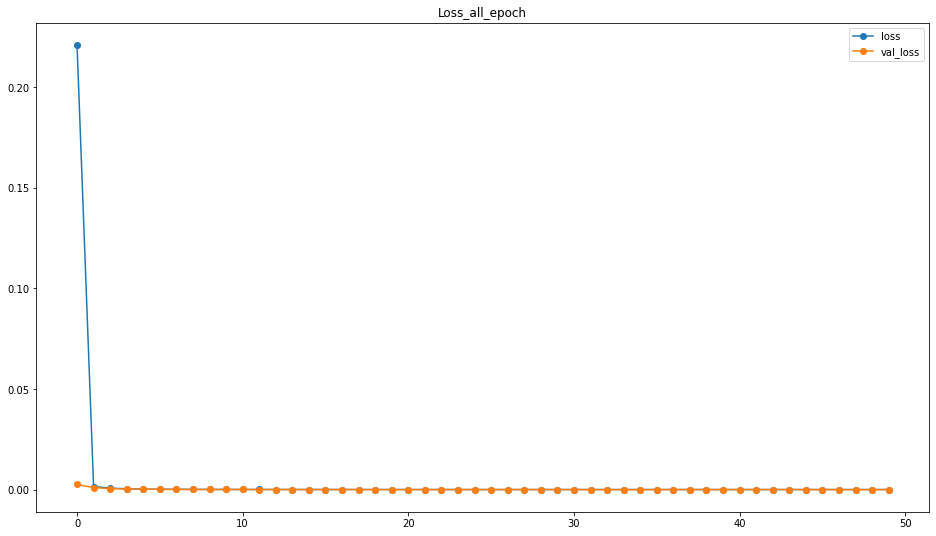

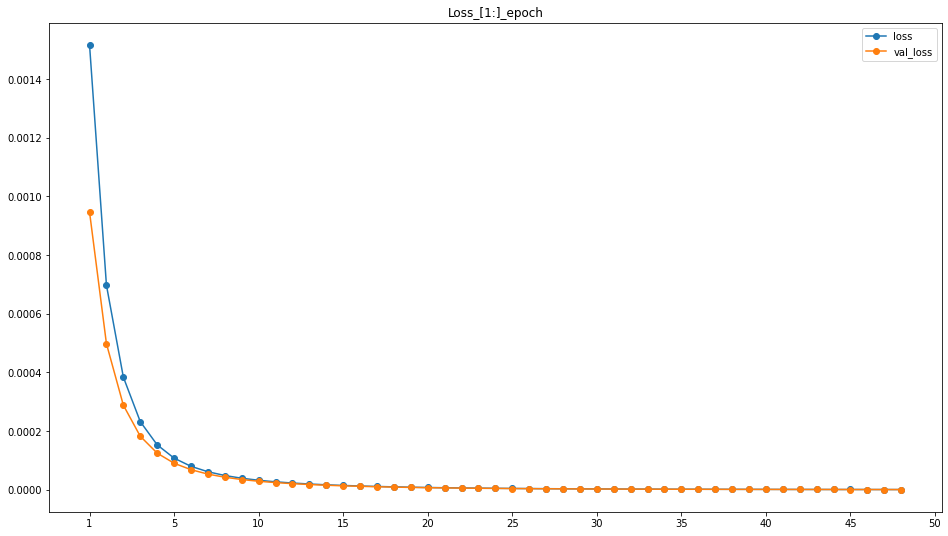

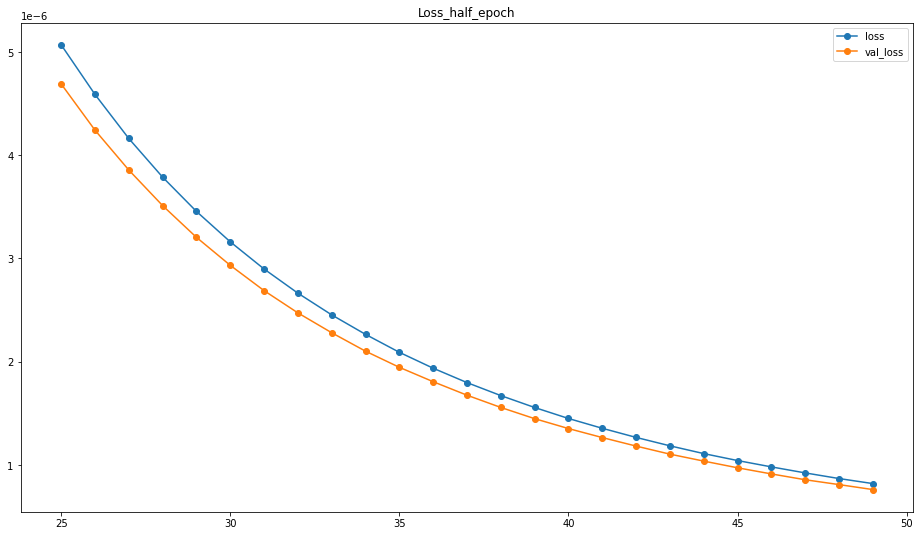

In [39]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [40]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 80us/step


In [41]:
print (scores)

[0.019622481732692796, 0.9928930997848511]


In [42]:
prediction = model.predict(test_data)

In [43]:
print(prediction)

[[9.9999738e-01 8.1372337e-07 5.9998371e-07 1.1763276e-06]
 [9.9999571e-01 1.3466731e-06 1.5340994e-06 1.4080265e-06]
 [9.9999726e-01 1.2695622e-06 6.0596403e-07 8.4836768e-07]
 ...
 [8.5476620e-07 5.8856182e-07 4.2845431e-06 9.9999428e-01]
 [1.4268672e-06 1.3285121e-06 5.4896782e-06 9.9999177e-01]
 [4.2801082e-07 1.8073133e-07 8.8757486e-07 9.9999857e-01]]


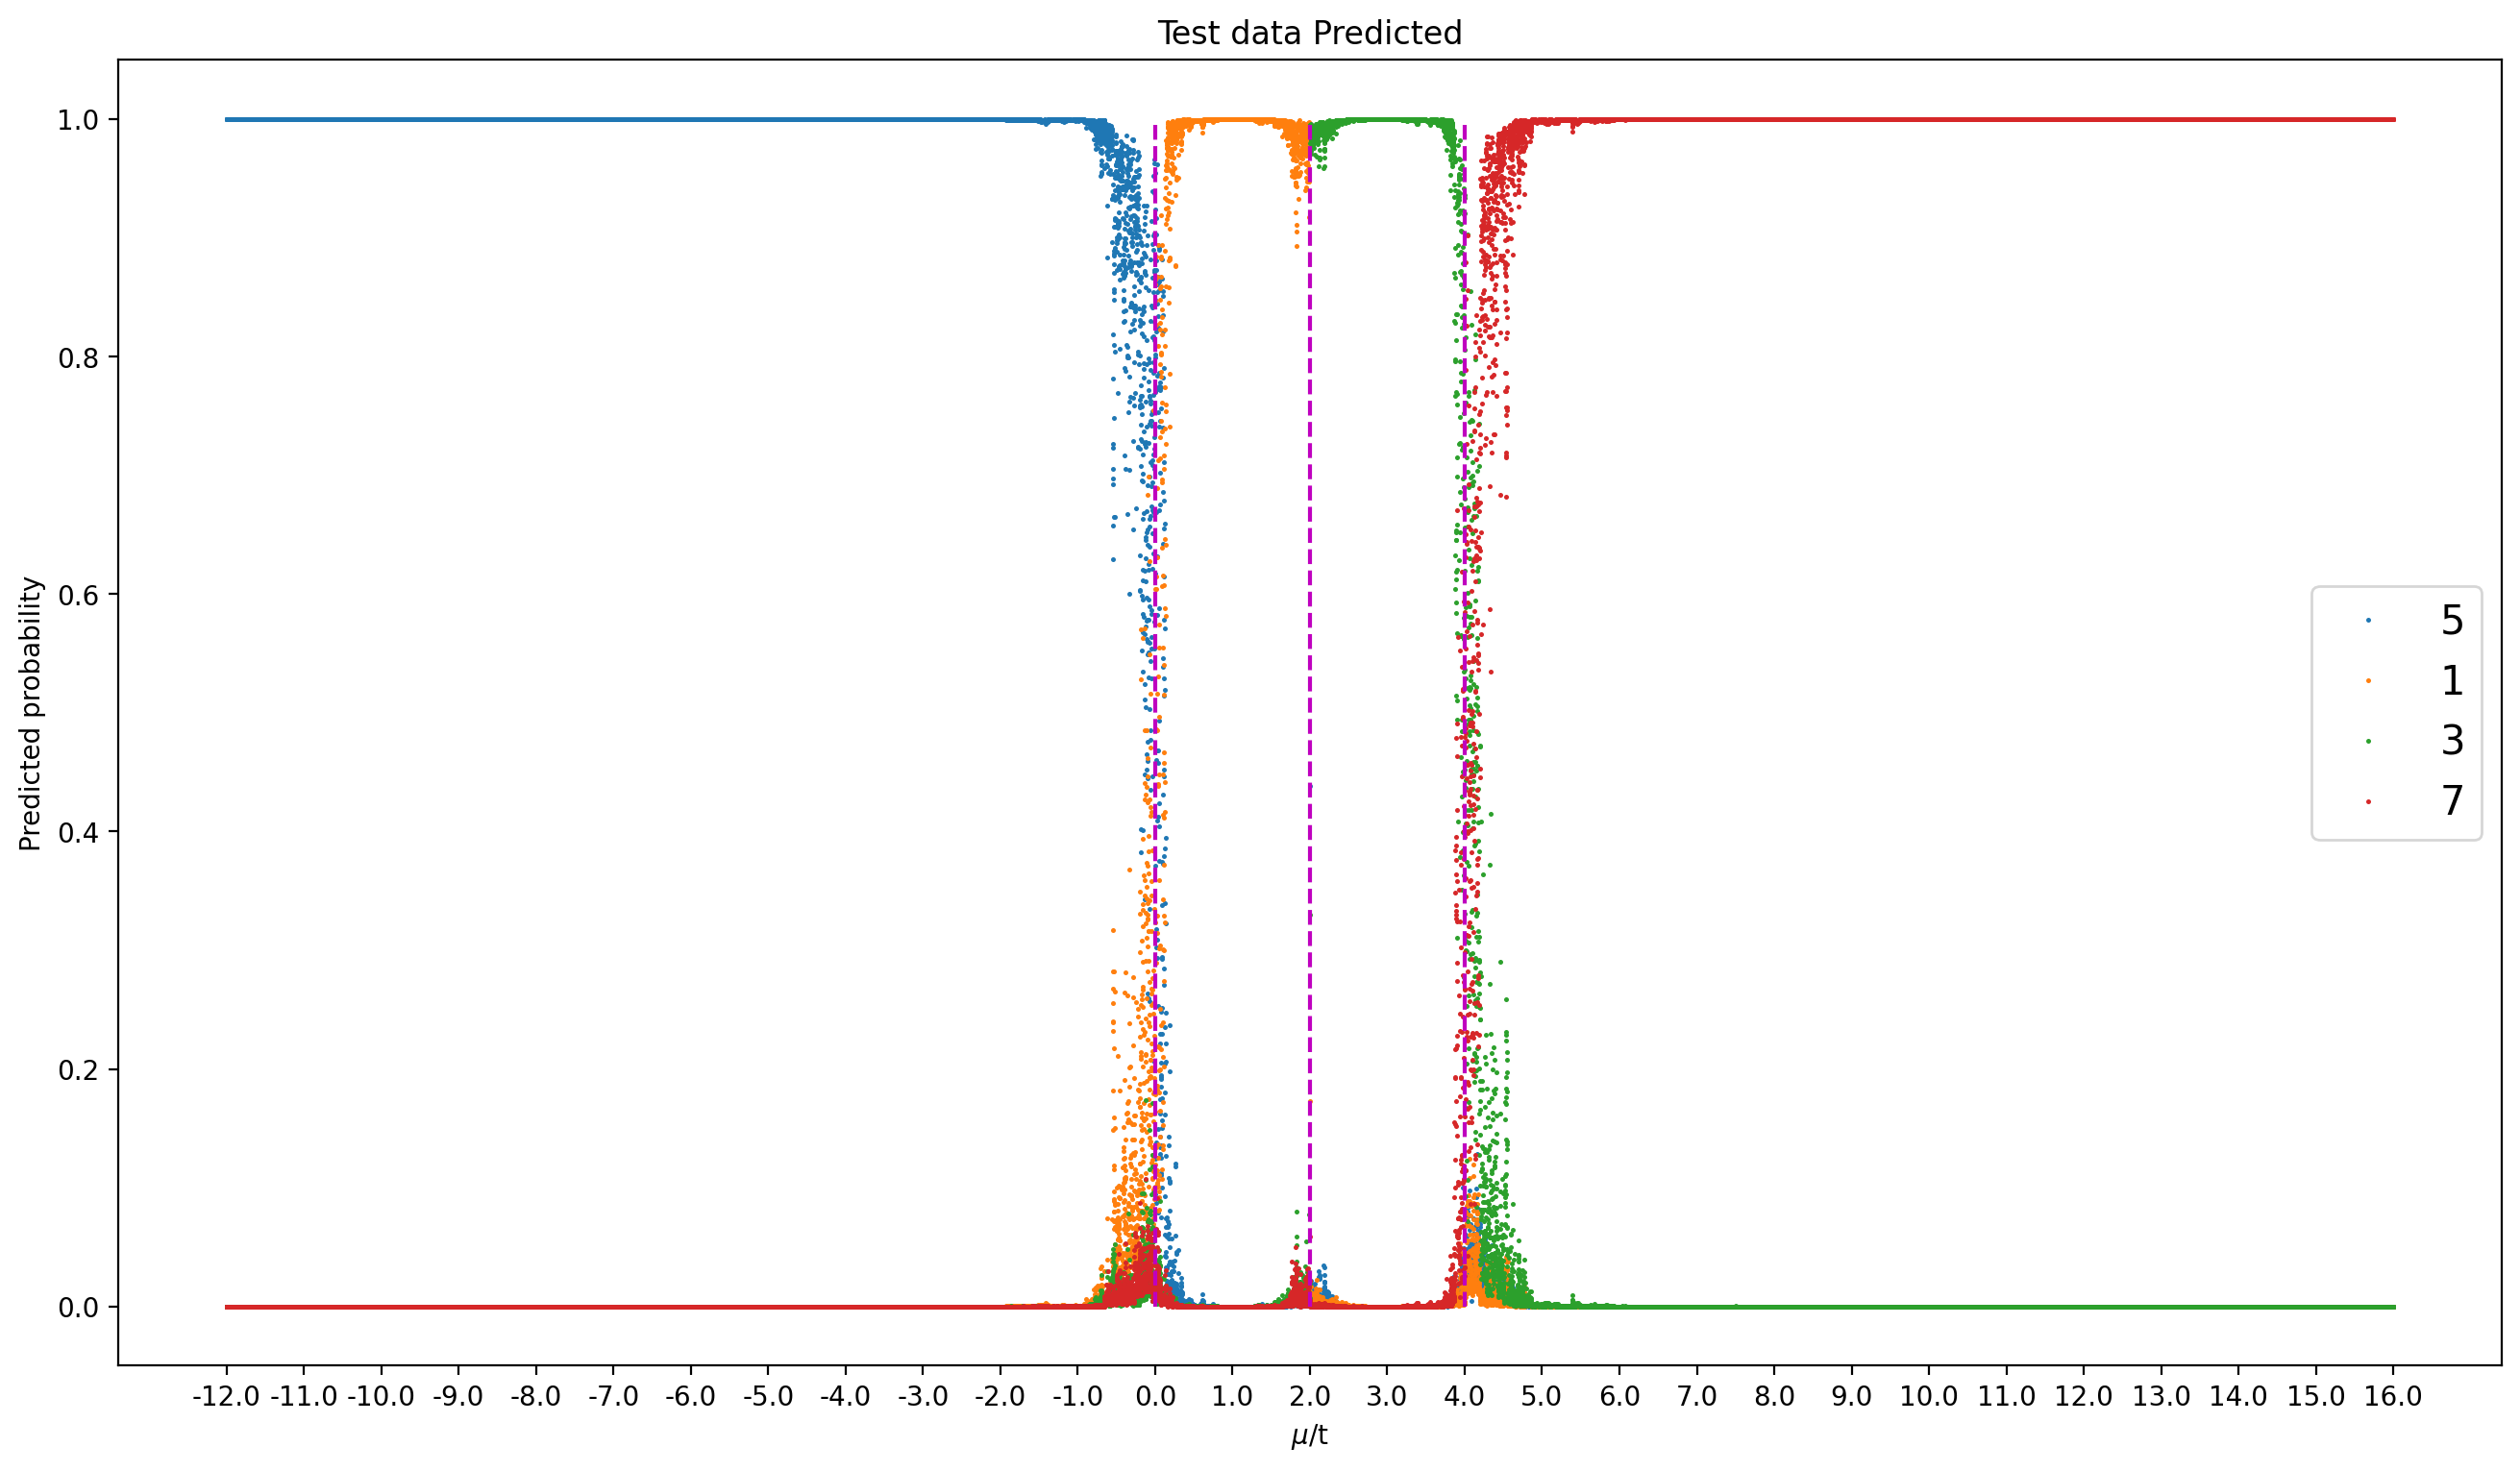

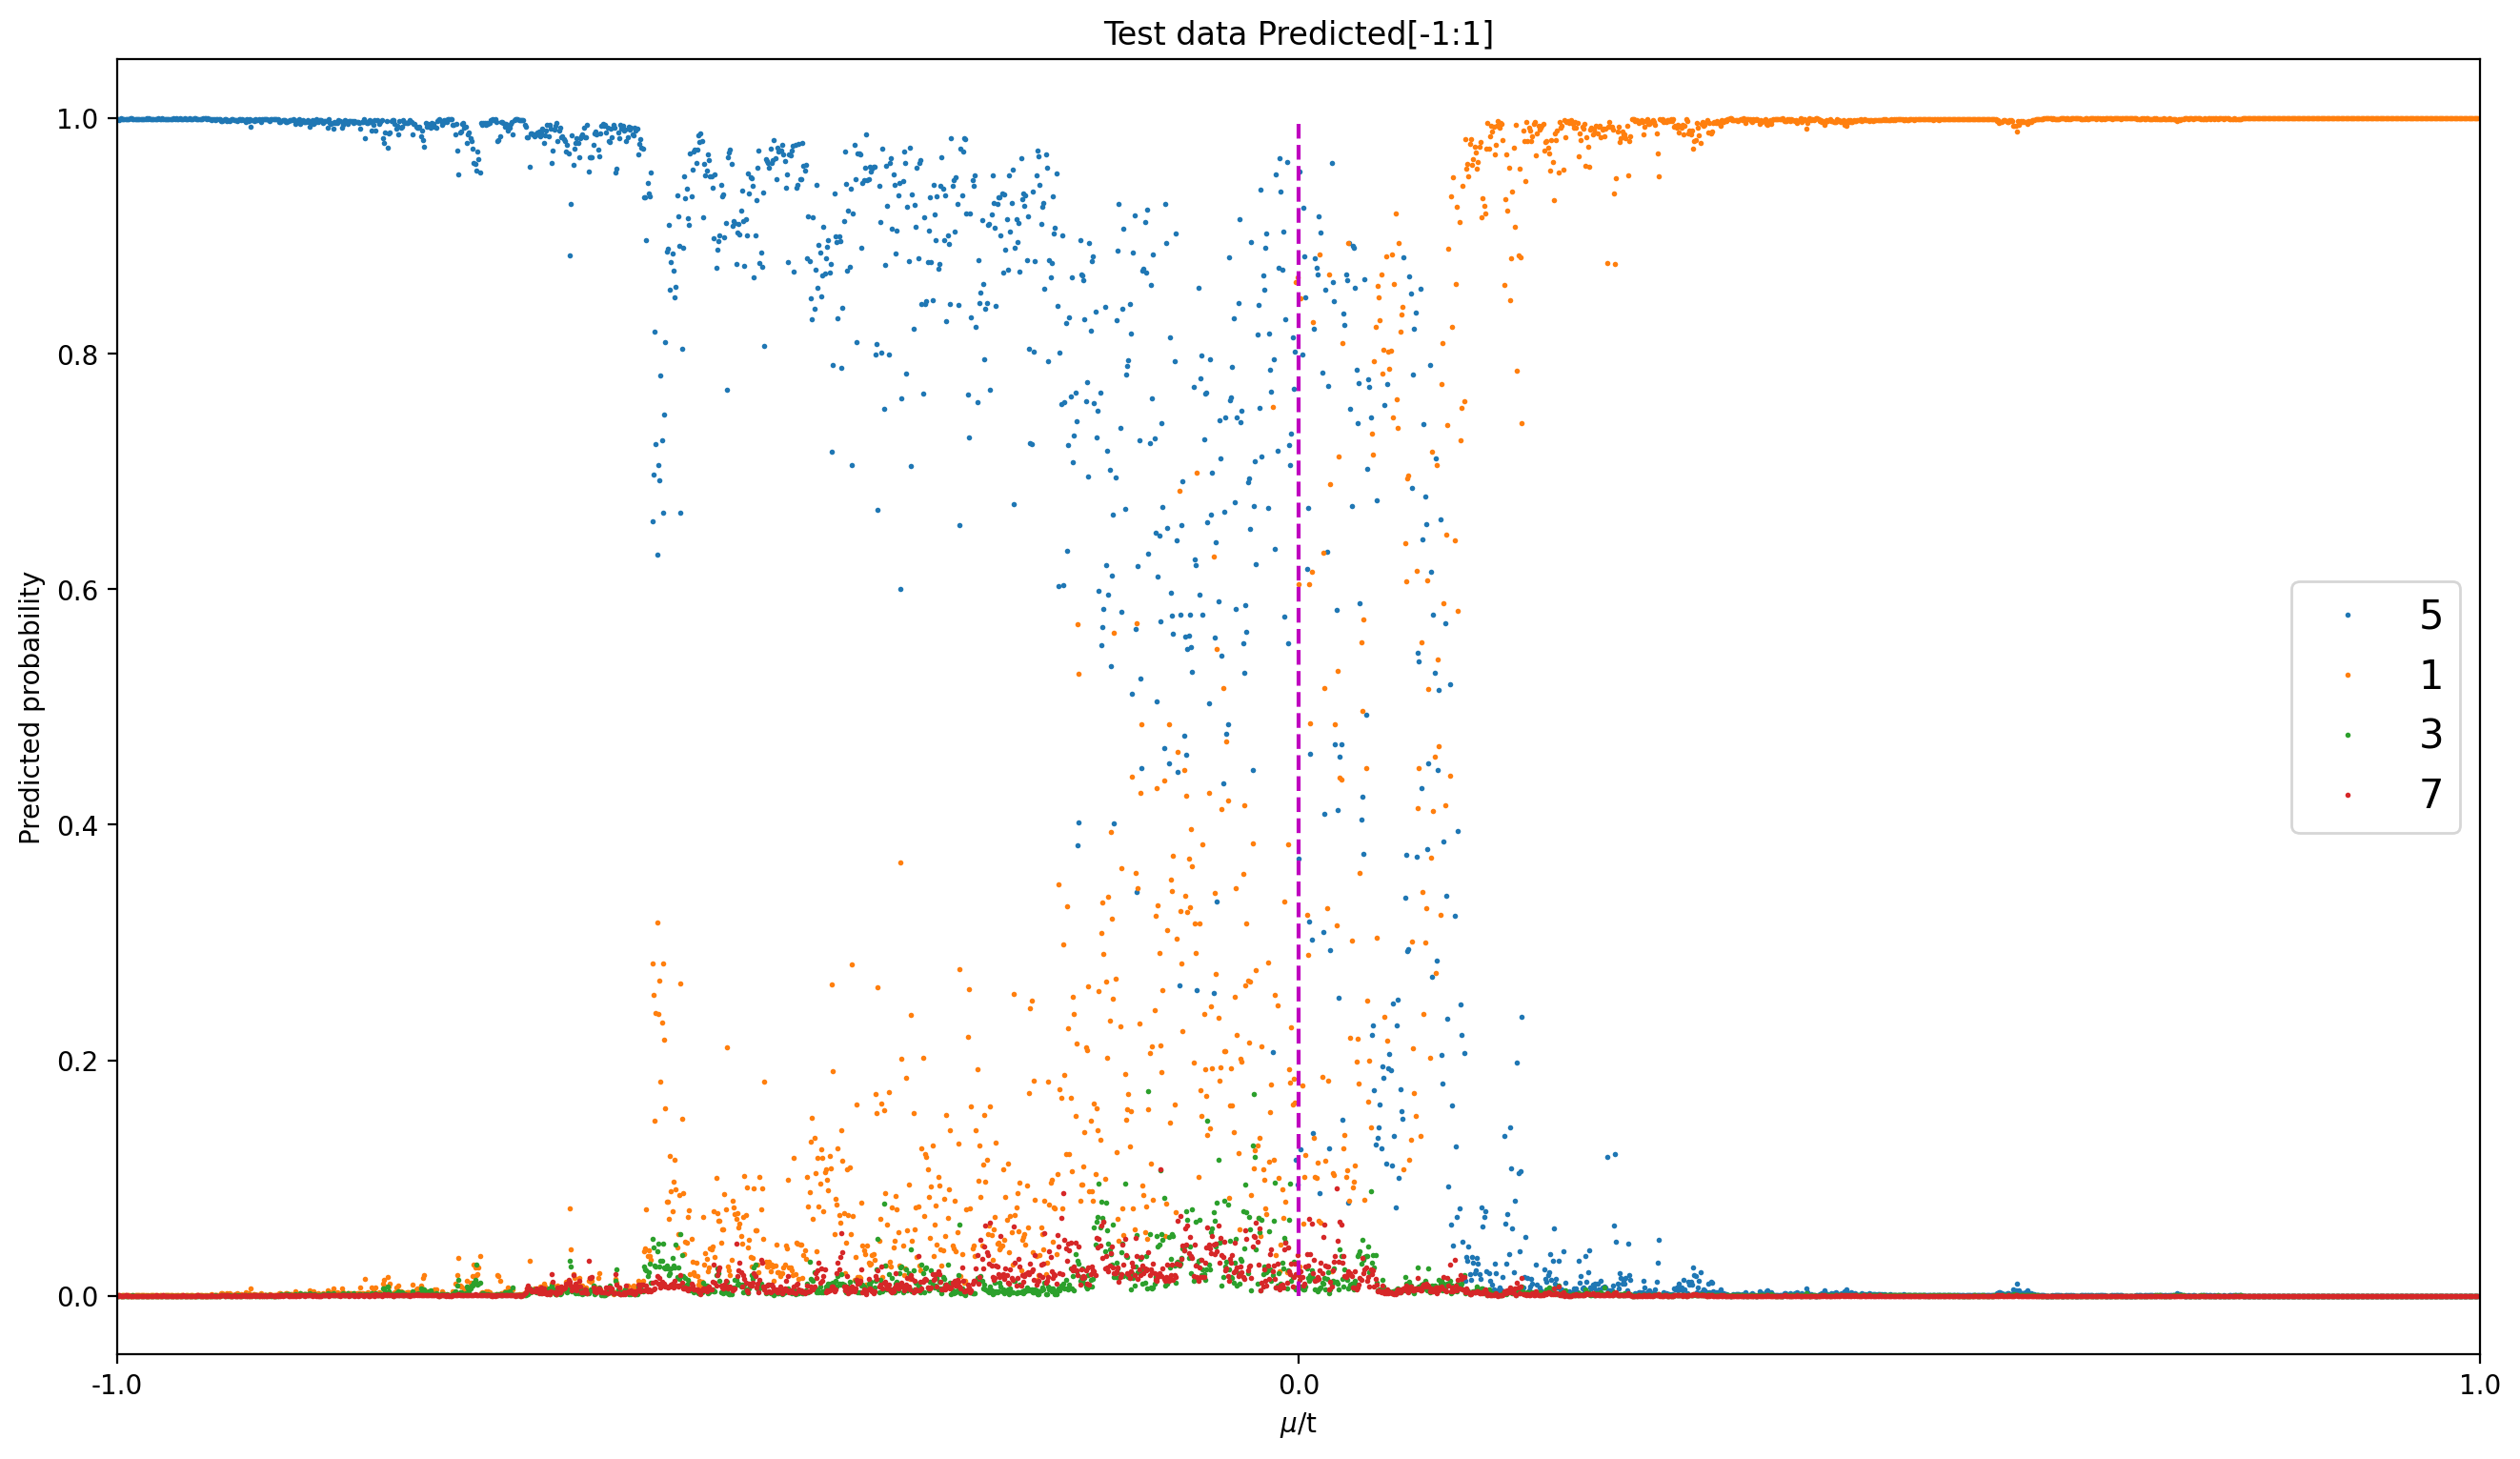

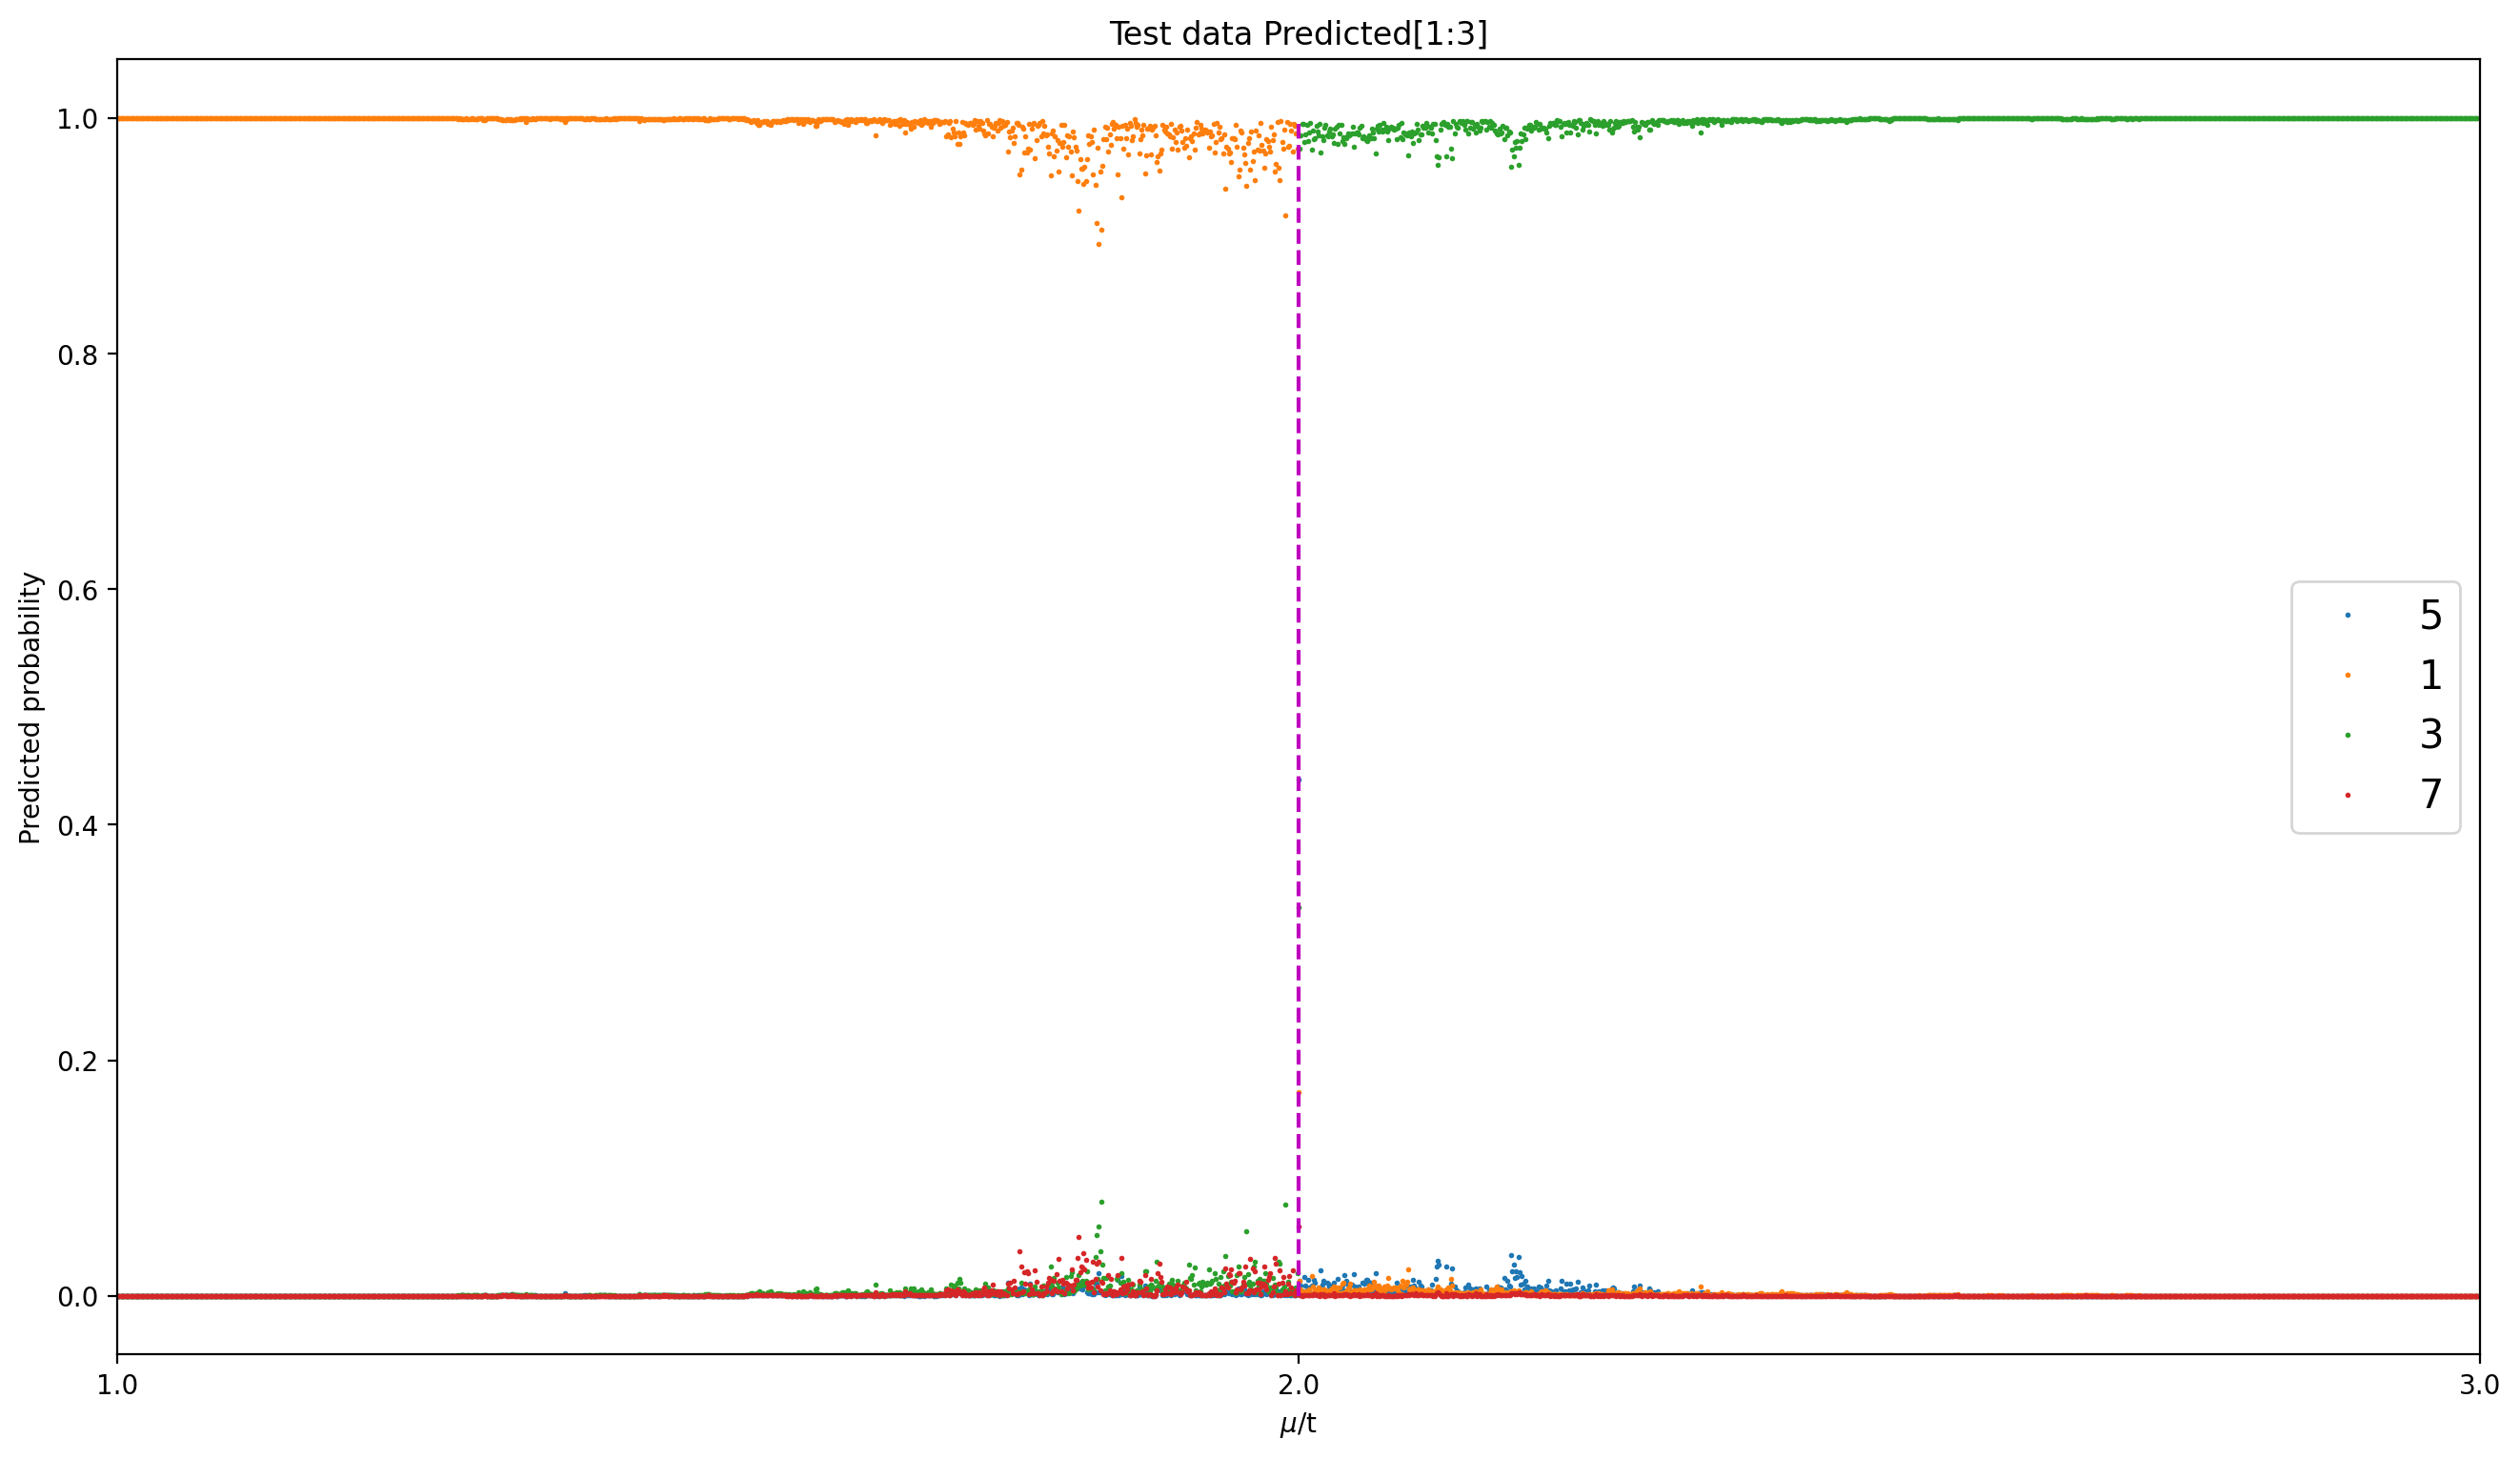

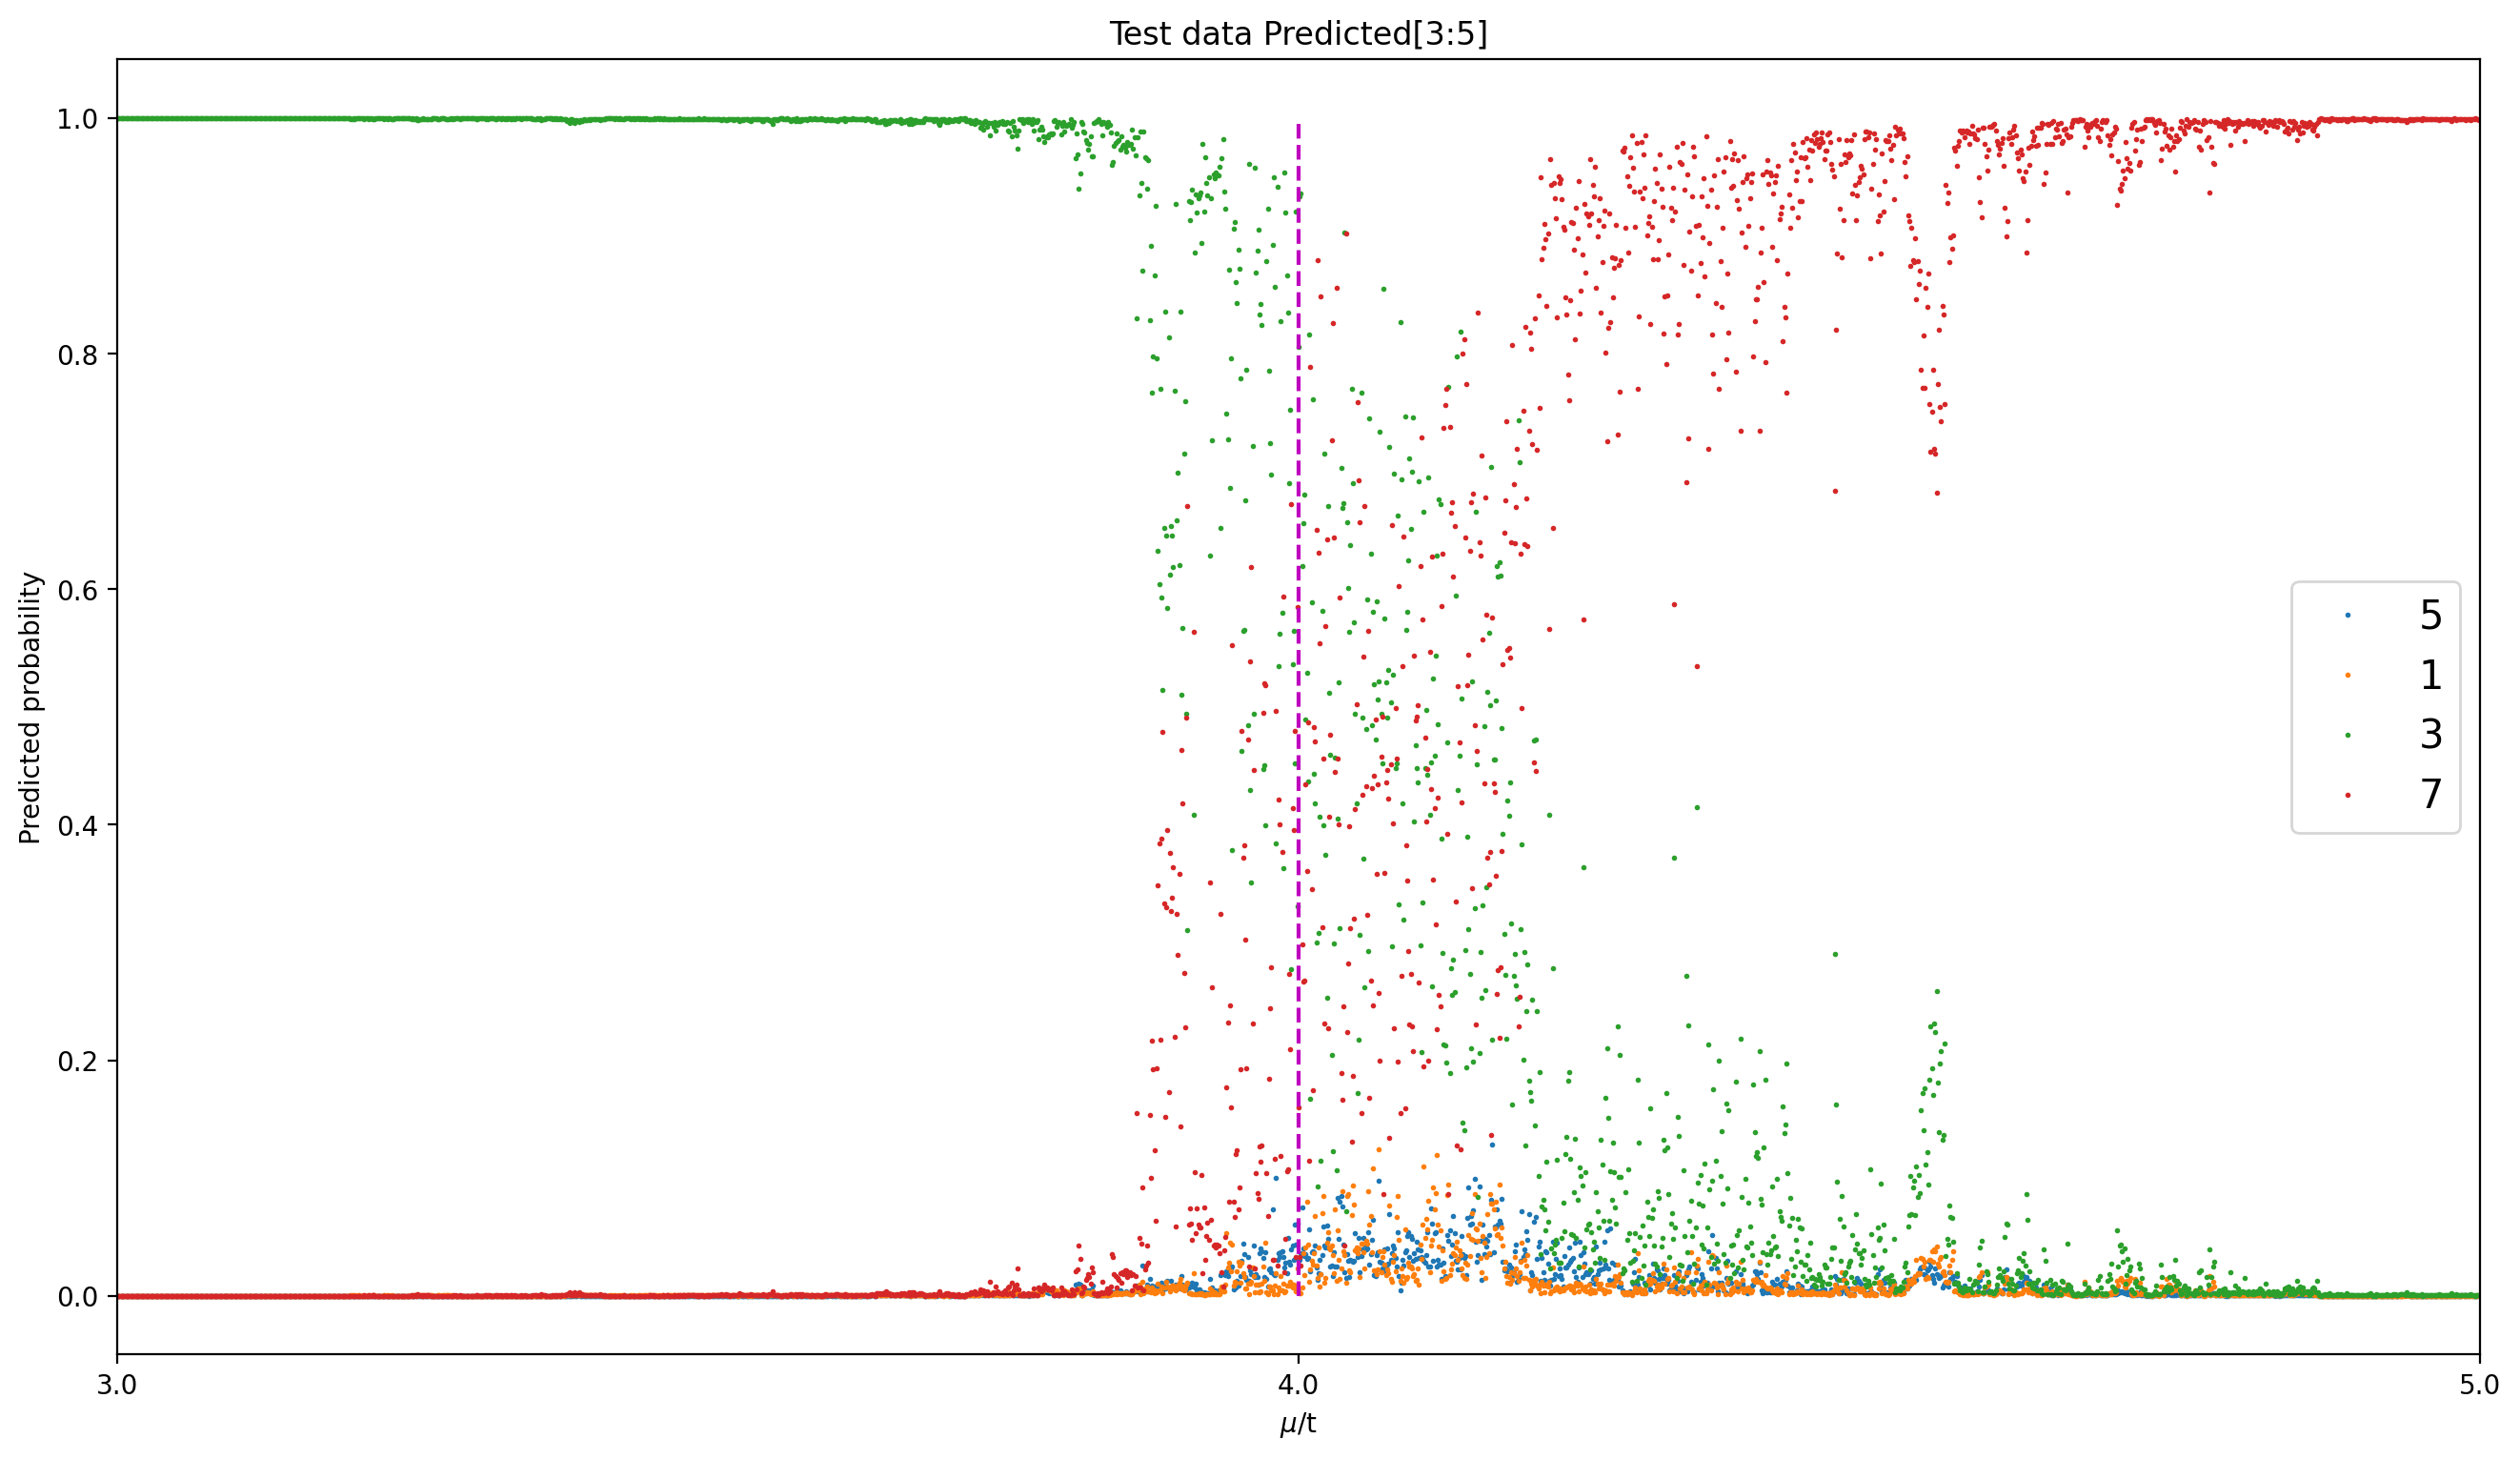

In [44]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_3D 抽中間兩根eigenvector

開始獲取eigenvector_r_theta_3D的資料，並抽出中間兩根eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [45]:
draw_out_parameters = int(((2*(NN**2)/2)-1)*3)

train_data = get_train_data(train_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)
print('draw_out_parameters = ' + str(draw_out_parameters))

(4000, 6, 5, 5)
(4000,)
(4000, 4)
(28001, 6, 5, 5)
(28001,)
(28001, 4)
draw_out_parameters = 72


將train data, train_one_hot_label 同步打亂

In [46]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [47]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 6, 5, 5)
(3200, 4)
Number validation data = 
(800, 6, 5, 5)
(800, 4)


開始架構網路

In [48]:
channel = 6

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 32,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 64, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 5, 5)          1760      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 3, 3)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 3, 3)          18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 2, 2)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               131584    
_________________________________________________________________
dense_10 (Dense)             (None, 4)                

In [49]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [50]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 192us/step - loss: 1.0118 - accuracy: 0.9394 - val_loss: 0.5807 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 106us/step - loss: 0.2629 - accuracy: 1.0000 - val_loss: 0.0783 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 103us/step - loss: 0.0410 - accuracy: 1.0000 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 104us/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 0.0089 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 104us/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 104us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 0s 104us/step - loss:

訓練完成  
開始提取模型資料

In [51]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


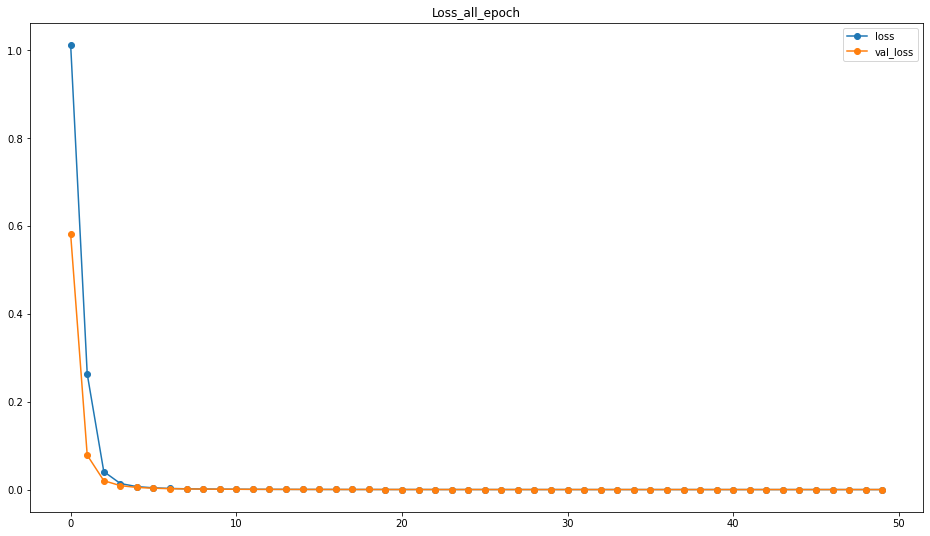

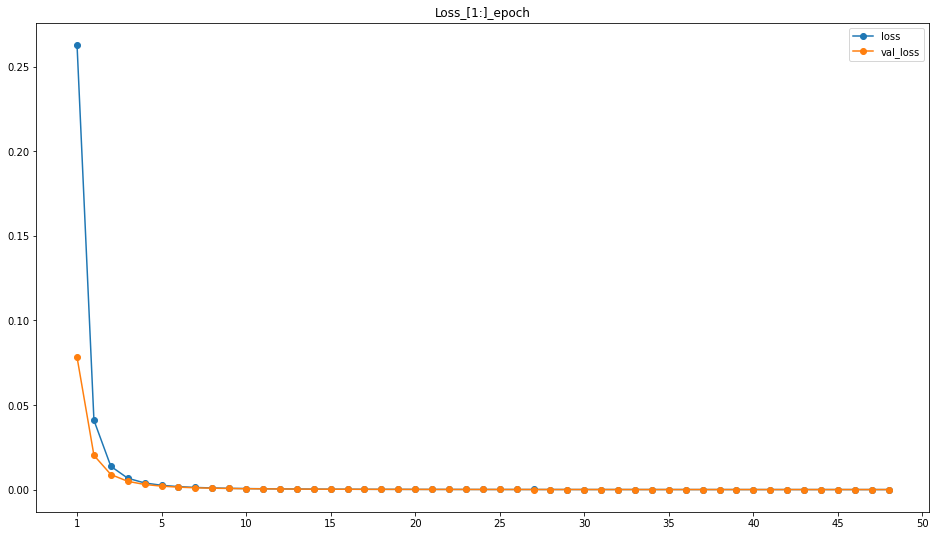

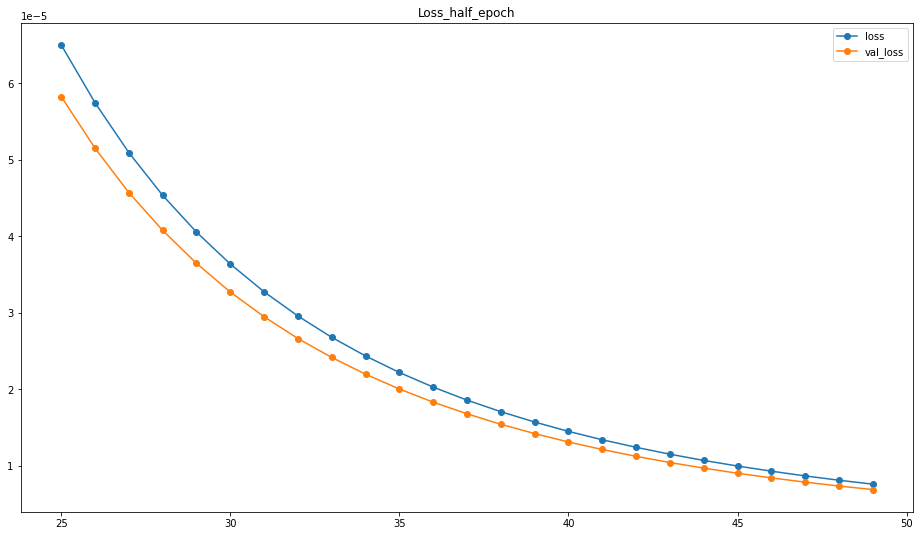

In [52]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [53]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 69us/step


In [54]:
print (scores)

[0.499994688783578, 0.9608228206634521]


In [55]:
prediction = model.predict(test_data)

In [56]:
print(prediction)

[[9.9999678e-01 7.5743188e-08 9.3604461e-07 2.1063395e-06]
 [9.9999654e-01 3.9830116e-08 1.6083018e-06 1.8620686e-06]
 [9.9999702e-01 6.1335790e-08 2.7322064e-06 1.1720110e-07]
 ...
 [1.7794657e-06 2.0330667e-06 2.4972755e-06 9.9999368e-01]
 [2.3005684e-06 1.3718732e-06 6.9129137e-06 9.9998939e-01]
 [5.7964377e-07 8.3389518e-09 2.6822974e-07 9.9999917e-01]]


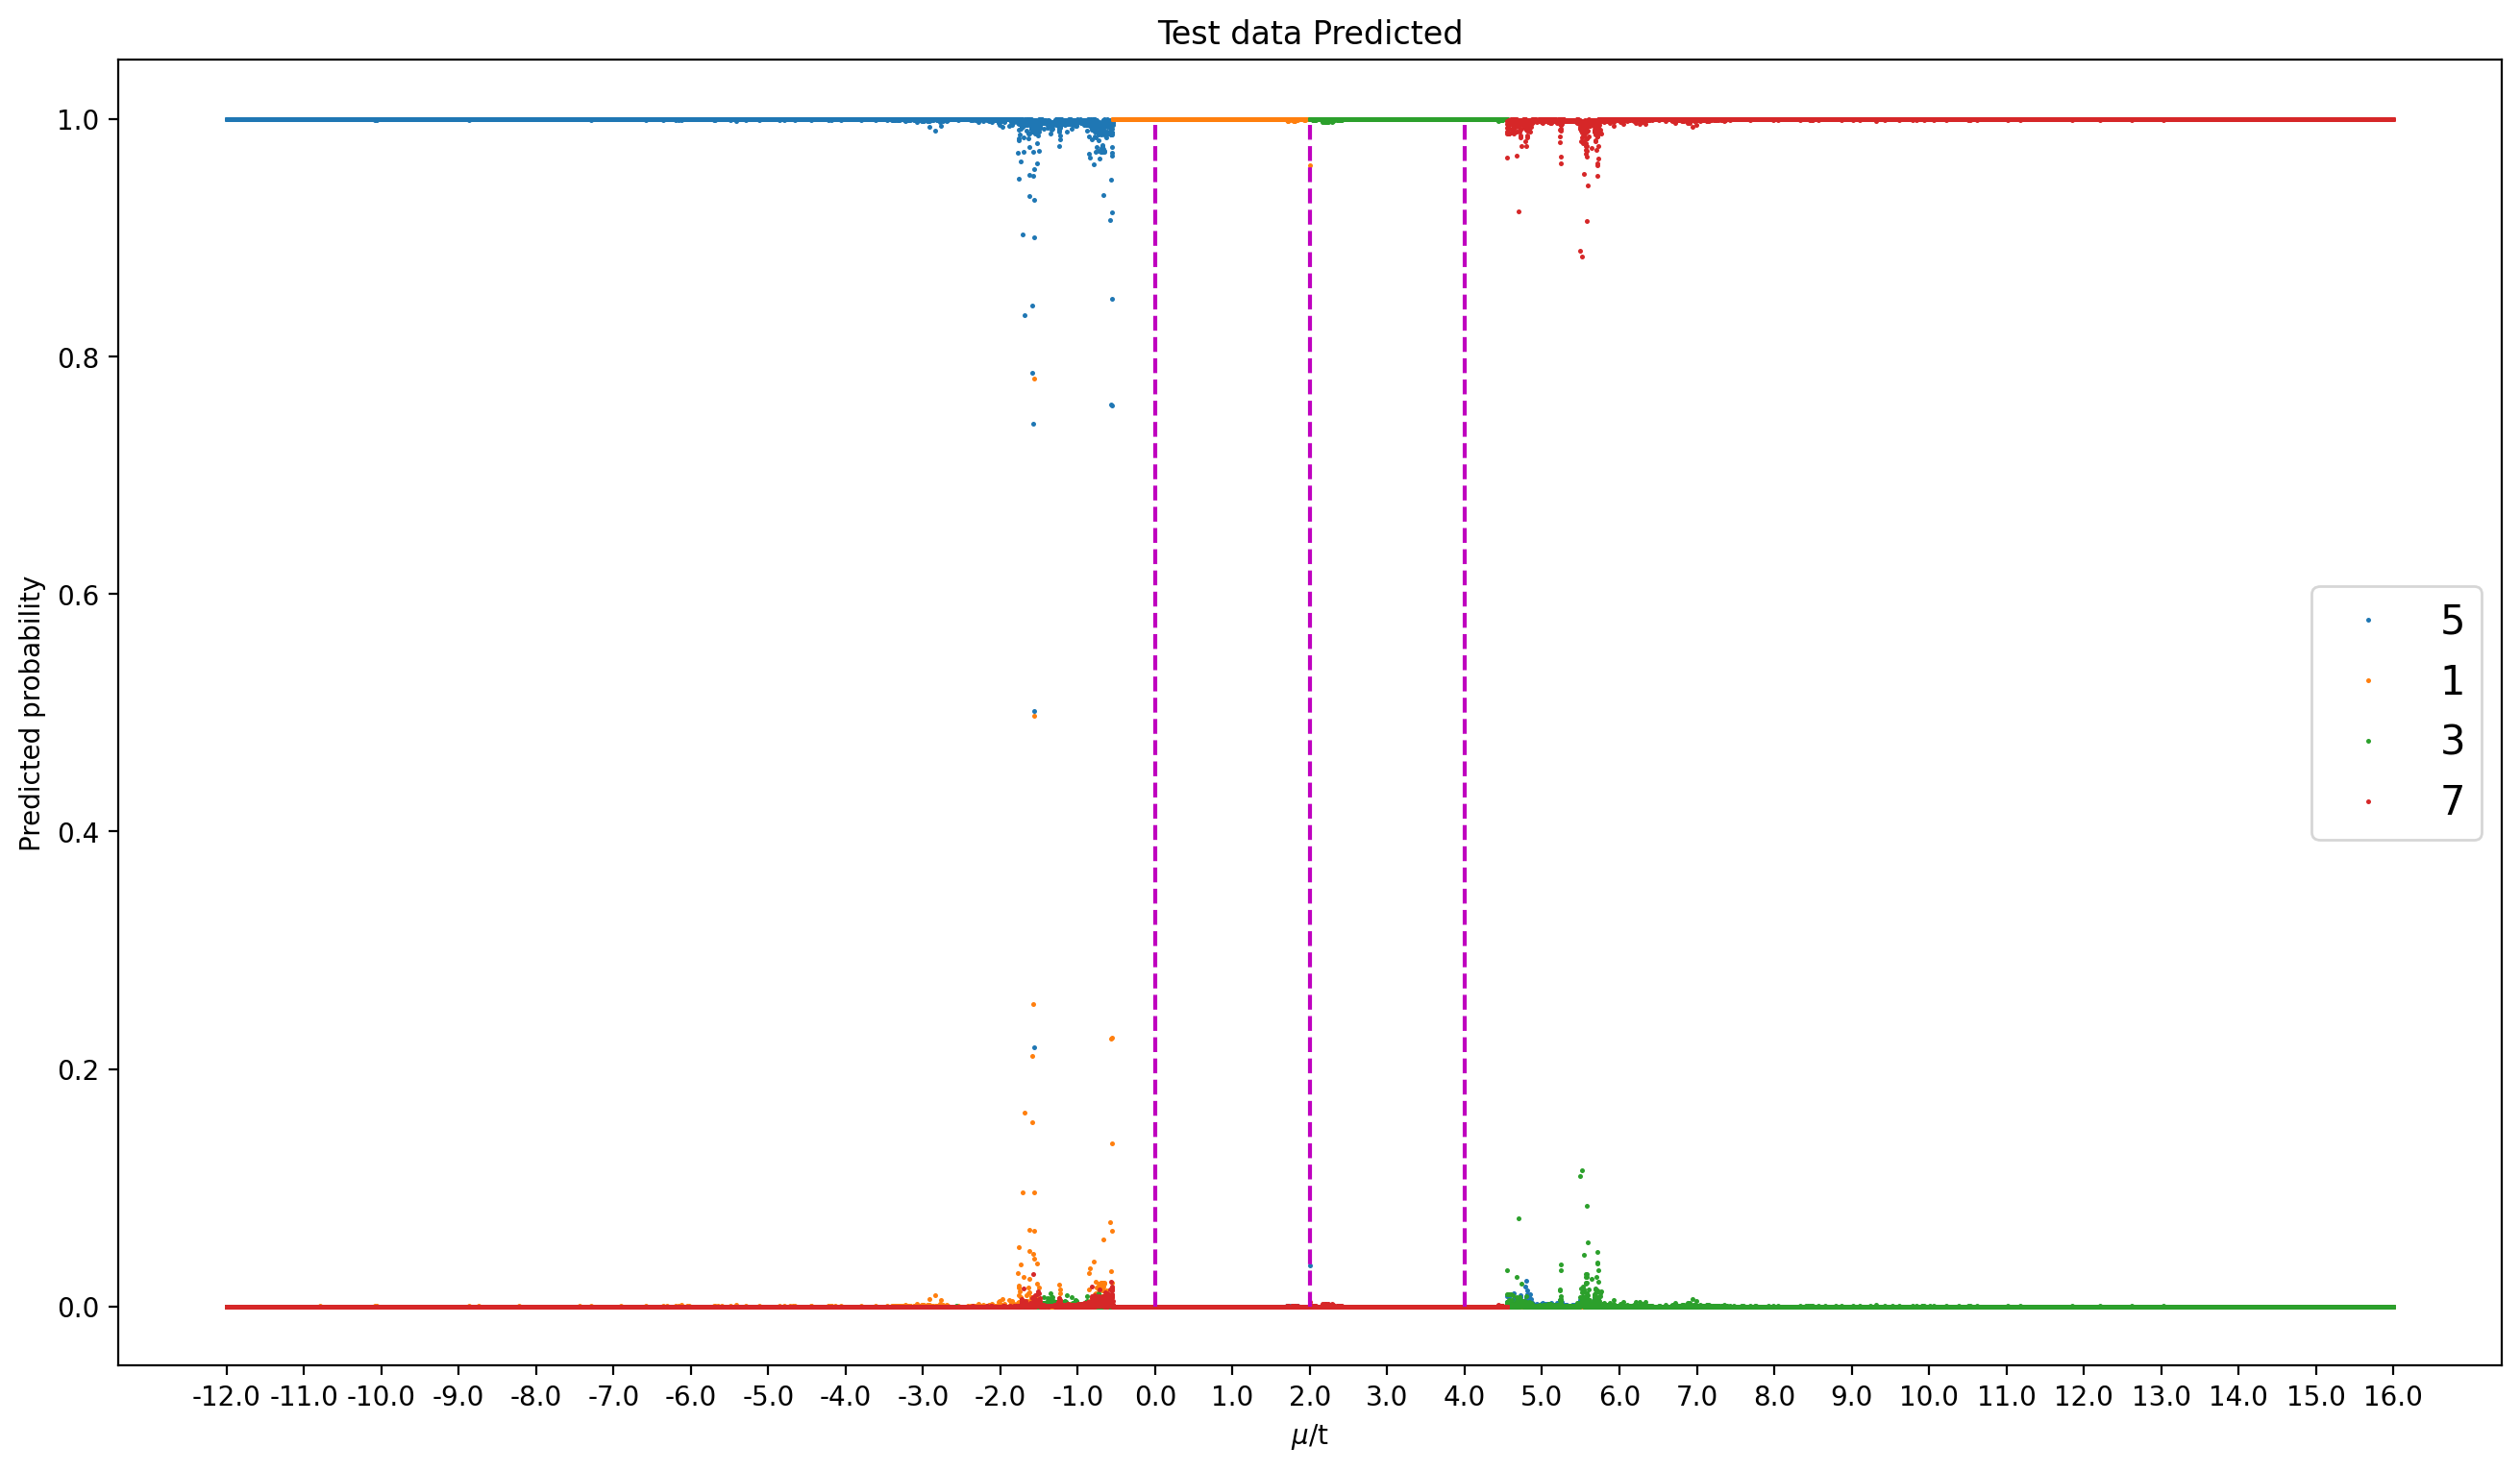

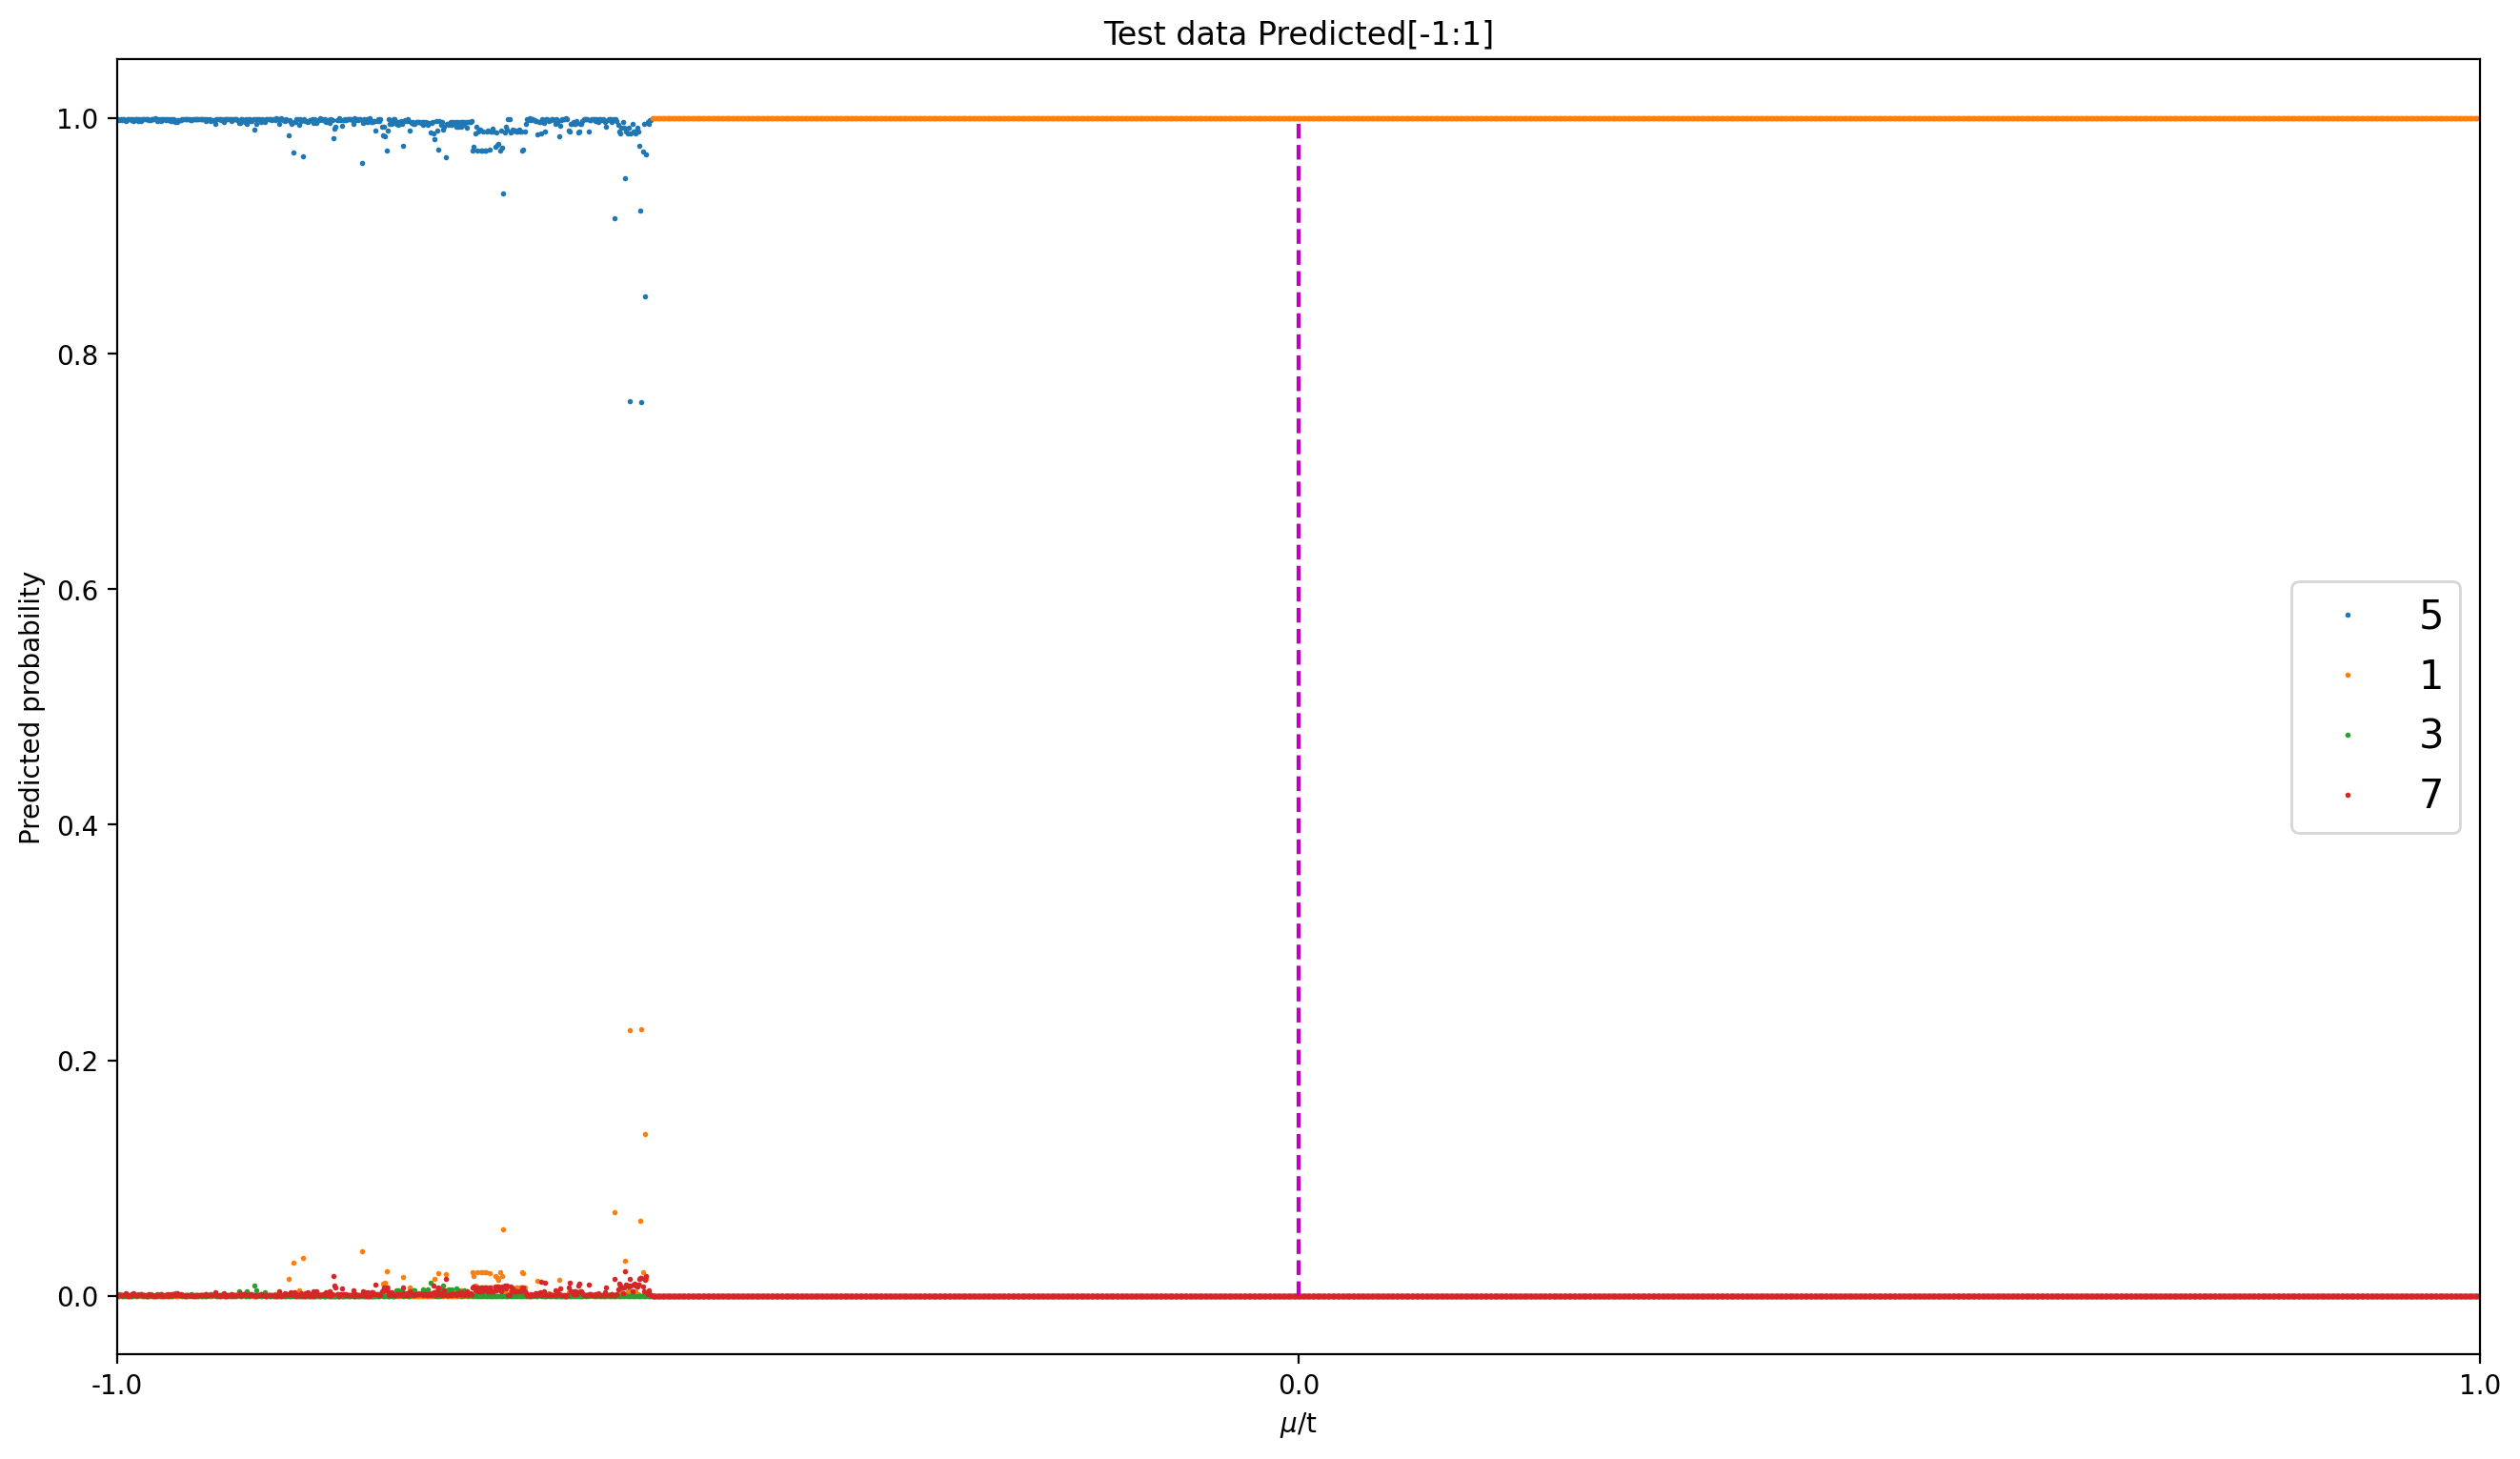

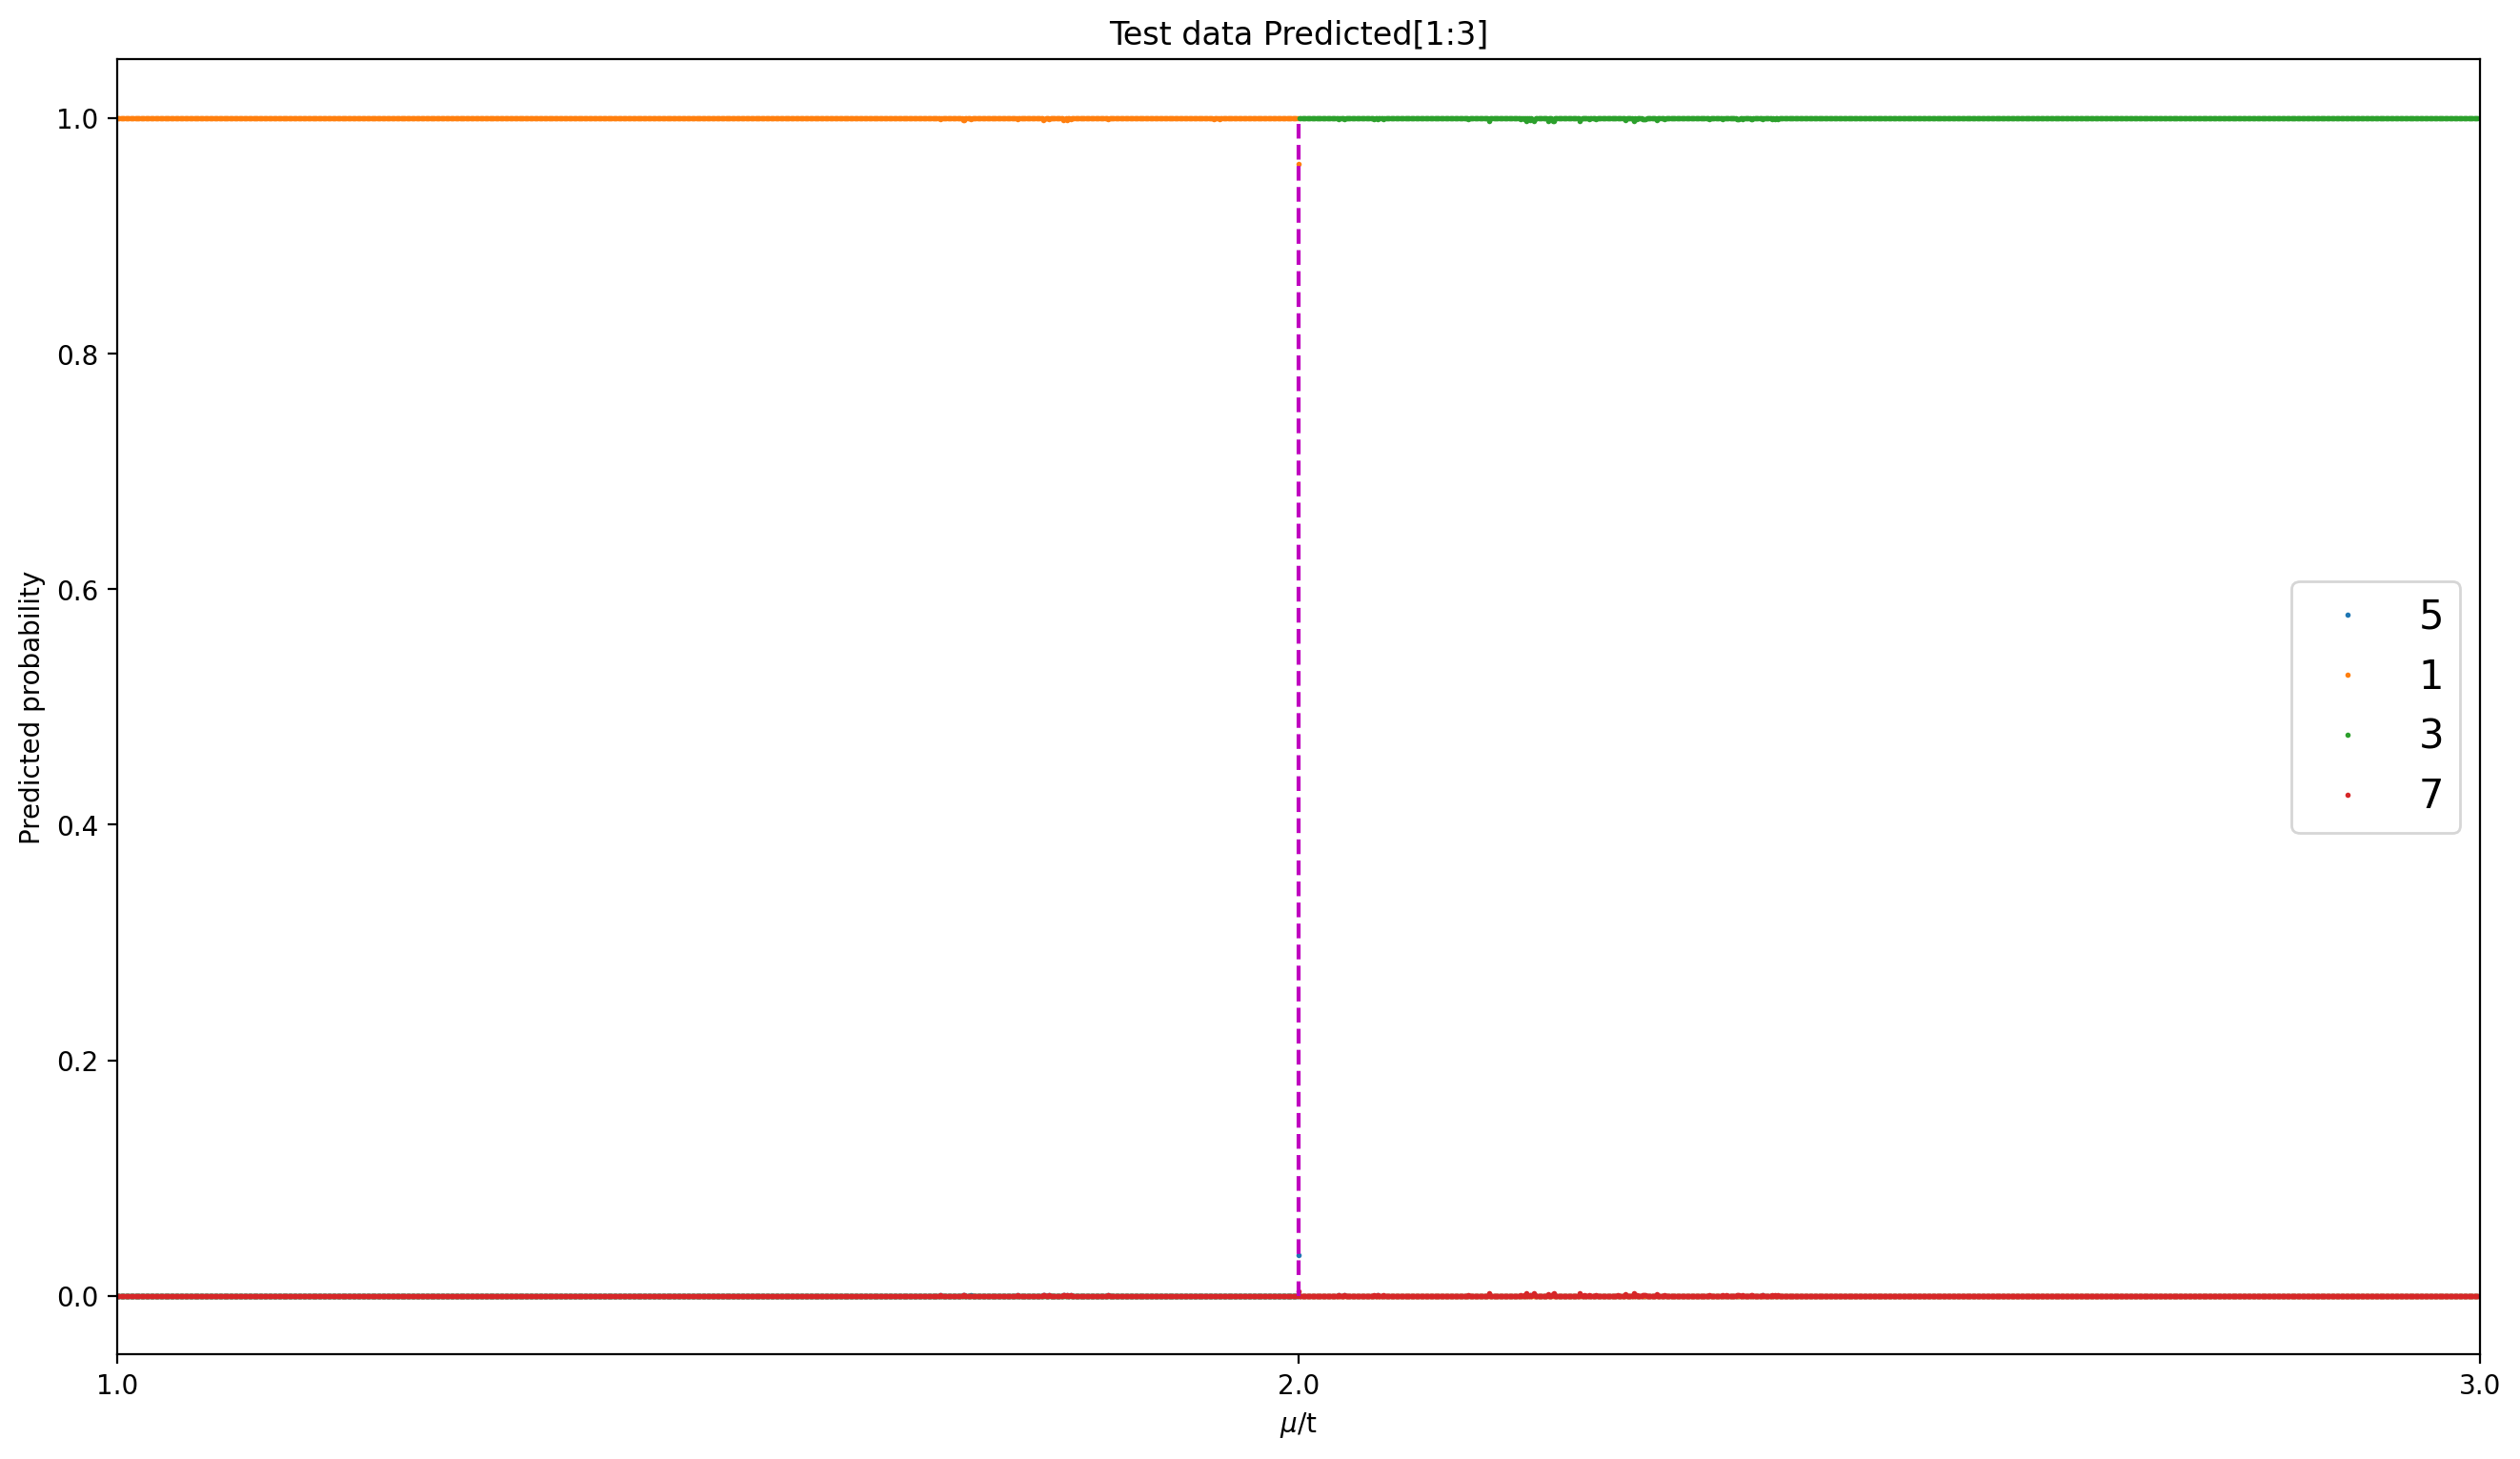

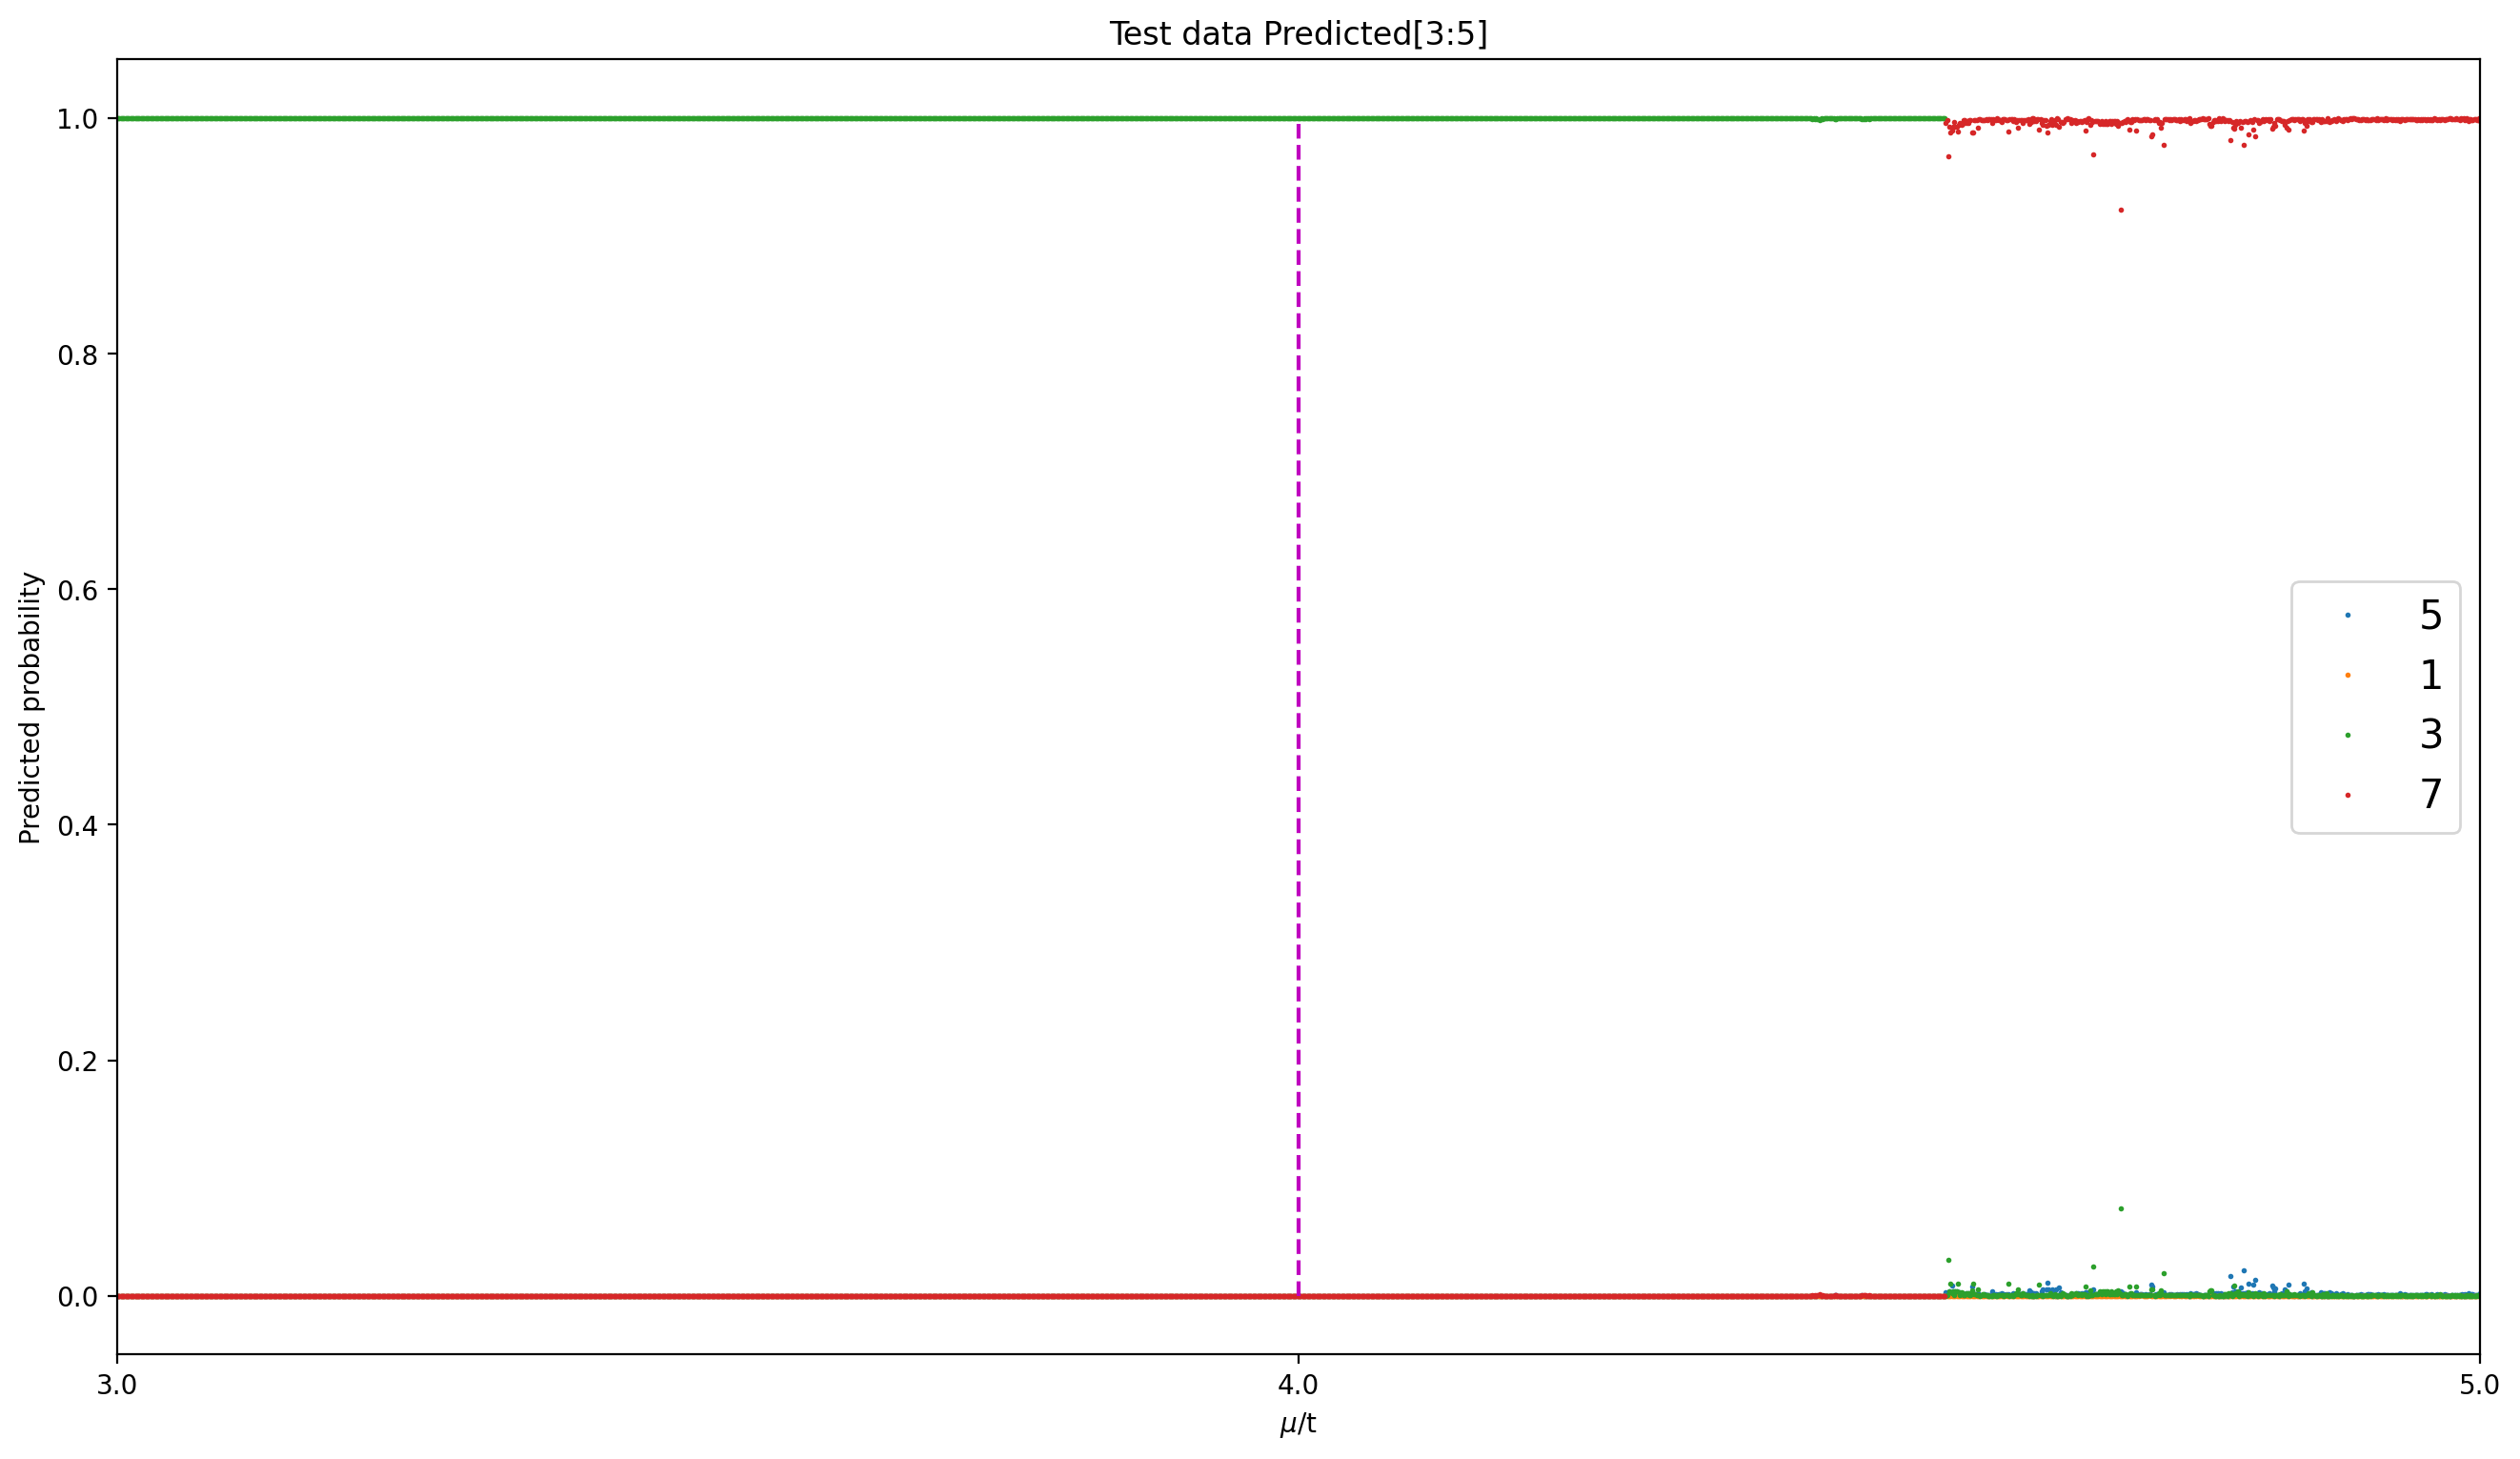

In [57]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D  抽中間兩包eigenvector

開始獲取eigenvector_r_theta_4D的資料，並抽出中間兩包eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [58]:
draw_out_parameters = int(((2*(NN**2)/2)-1))

train_data = get_train_data(train_data_path, date, N, delta)[4][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 6, 5, 5, 3)
(4000,)
(4000, 4)
(28001, 6, 5, 5, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [59]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [60]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 5, 5, 3)
(4000, 4)
Number of real trian data = 
(3200, 6, 5, 5, 3)
(3200, 4)
Number validation data = 
(800, 6, 5, 5, 3)
(800, 4)


開始架構網路

In [61]:
channel = 6

model = Sequential()

model.add(Conv3D(batch_input_shape = (None, channel, NN, NN, 3),
                 filters = 32,
                 kernel_size = (3,3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size = (2,2,2),
                       data_format = 'channels_first',
                       padding = 'same')
         )

model.add(Conv3D(filters = 64, 
                 kernel_size = (3,3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling3D(pool_size=(2,2,2),
                       data_format='channels_first',
                       padding = 'same')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_3 (Conv3D)            (None, 32, 5, 5, 3)       5216      
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 32, 3, 3, 2)       0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 64, 3, 3, 2)       55360     
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 64, 2, 2, 1)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_12 (Dense)             (None, 4)                

In [62]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [63]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 167us/step - loss: 0.8593 - accuracy: 0.9481 - val_loss: 0.2952 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 107us/step - loss: 0.0978 - accuracy: 1.0000 - val_loss: 0.0256 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 109us/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 0.0088 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 108us/step - loss: 0.0062 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 110us/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 0.0025 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 108us/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 0s 107us/step - loss:

訓練完成  
開始提取模型資料

In [64]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


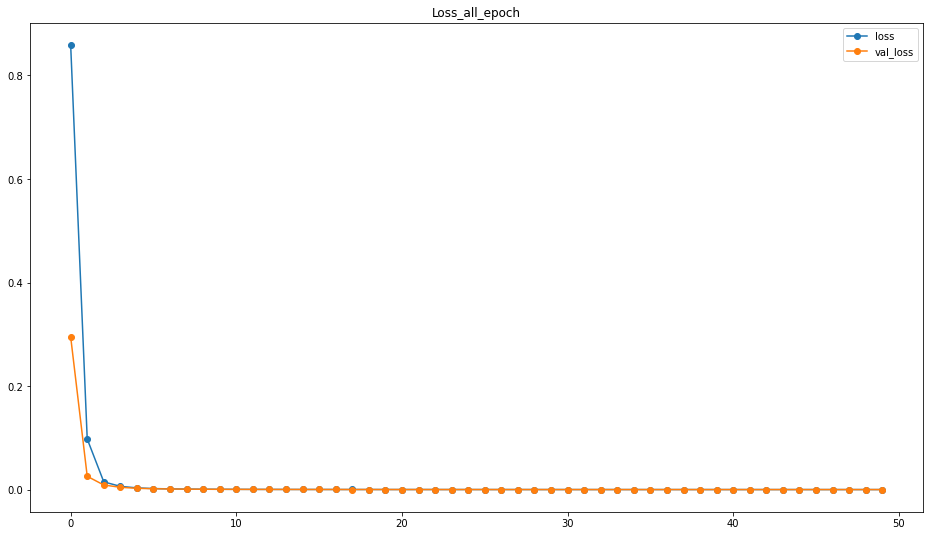

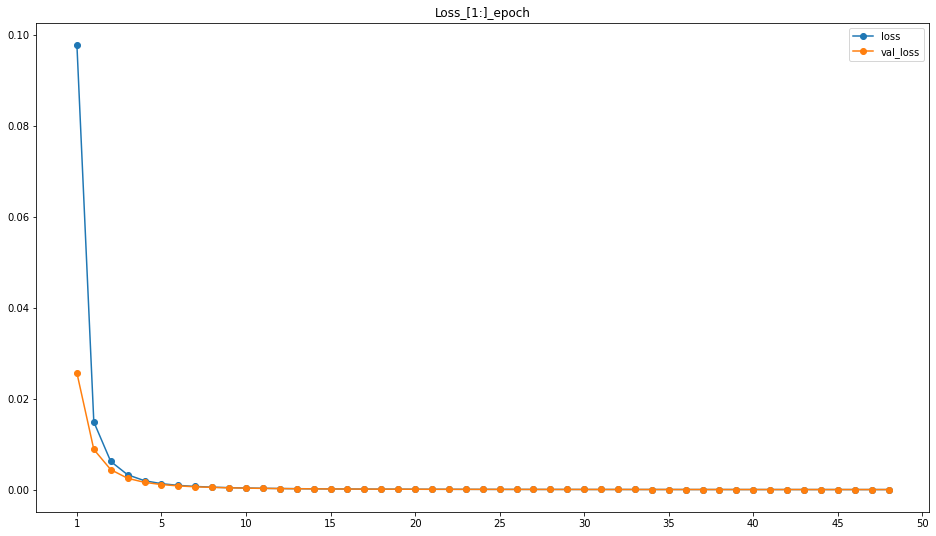

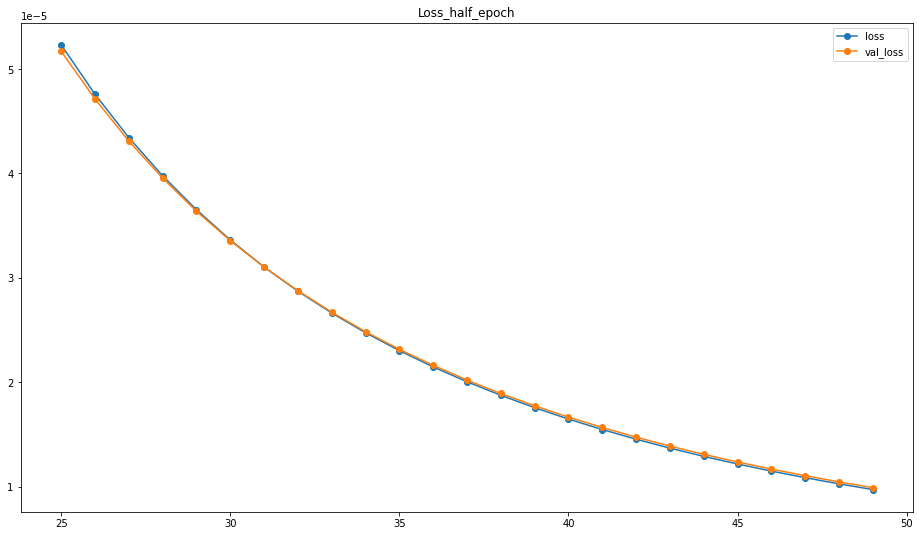

In [65]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [66]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 68us/step


In [67]:
print (scores)

[0.3603395639833593, 0.9588943123817444]


In [68]:
prediction = model.predict(test_data)

In [69]:
print(prediction)

[[9.9998677e-01 2.8297400e-06 7.9128422e-06 2.4451112e-06]
 [9.9999440e-01 1.3048243e-06 2.5499364e-06 1.7930936e-06]
 [9.9998701e-01 4.8872839e-06 6.2122608e-06 1.9453978e-06]
 ...
 [1.8858001e-06 1.8465288e-06 3.1915686e-06 9.9999309e-01]
 [1.1723014e-06 1.0561570e-06 3.3616593e-06 9.9999440e-01]
 [3.3134586e-06 4.6742915e-07 6.3587584e-07 9.9999559e-01]]


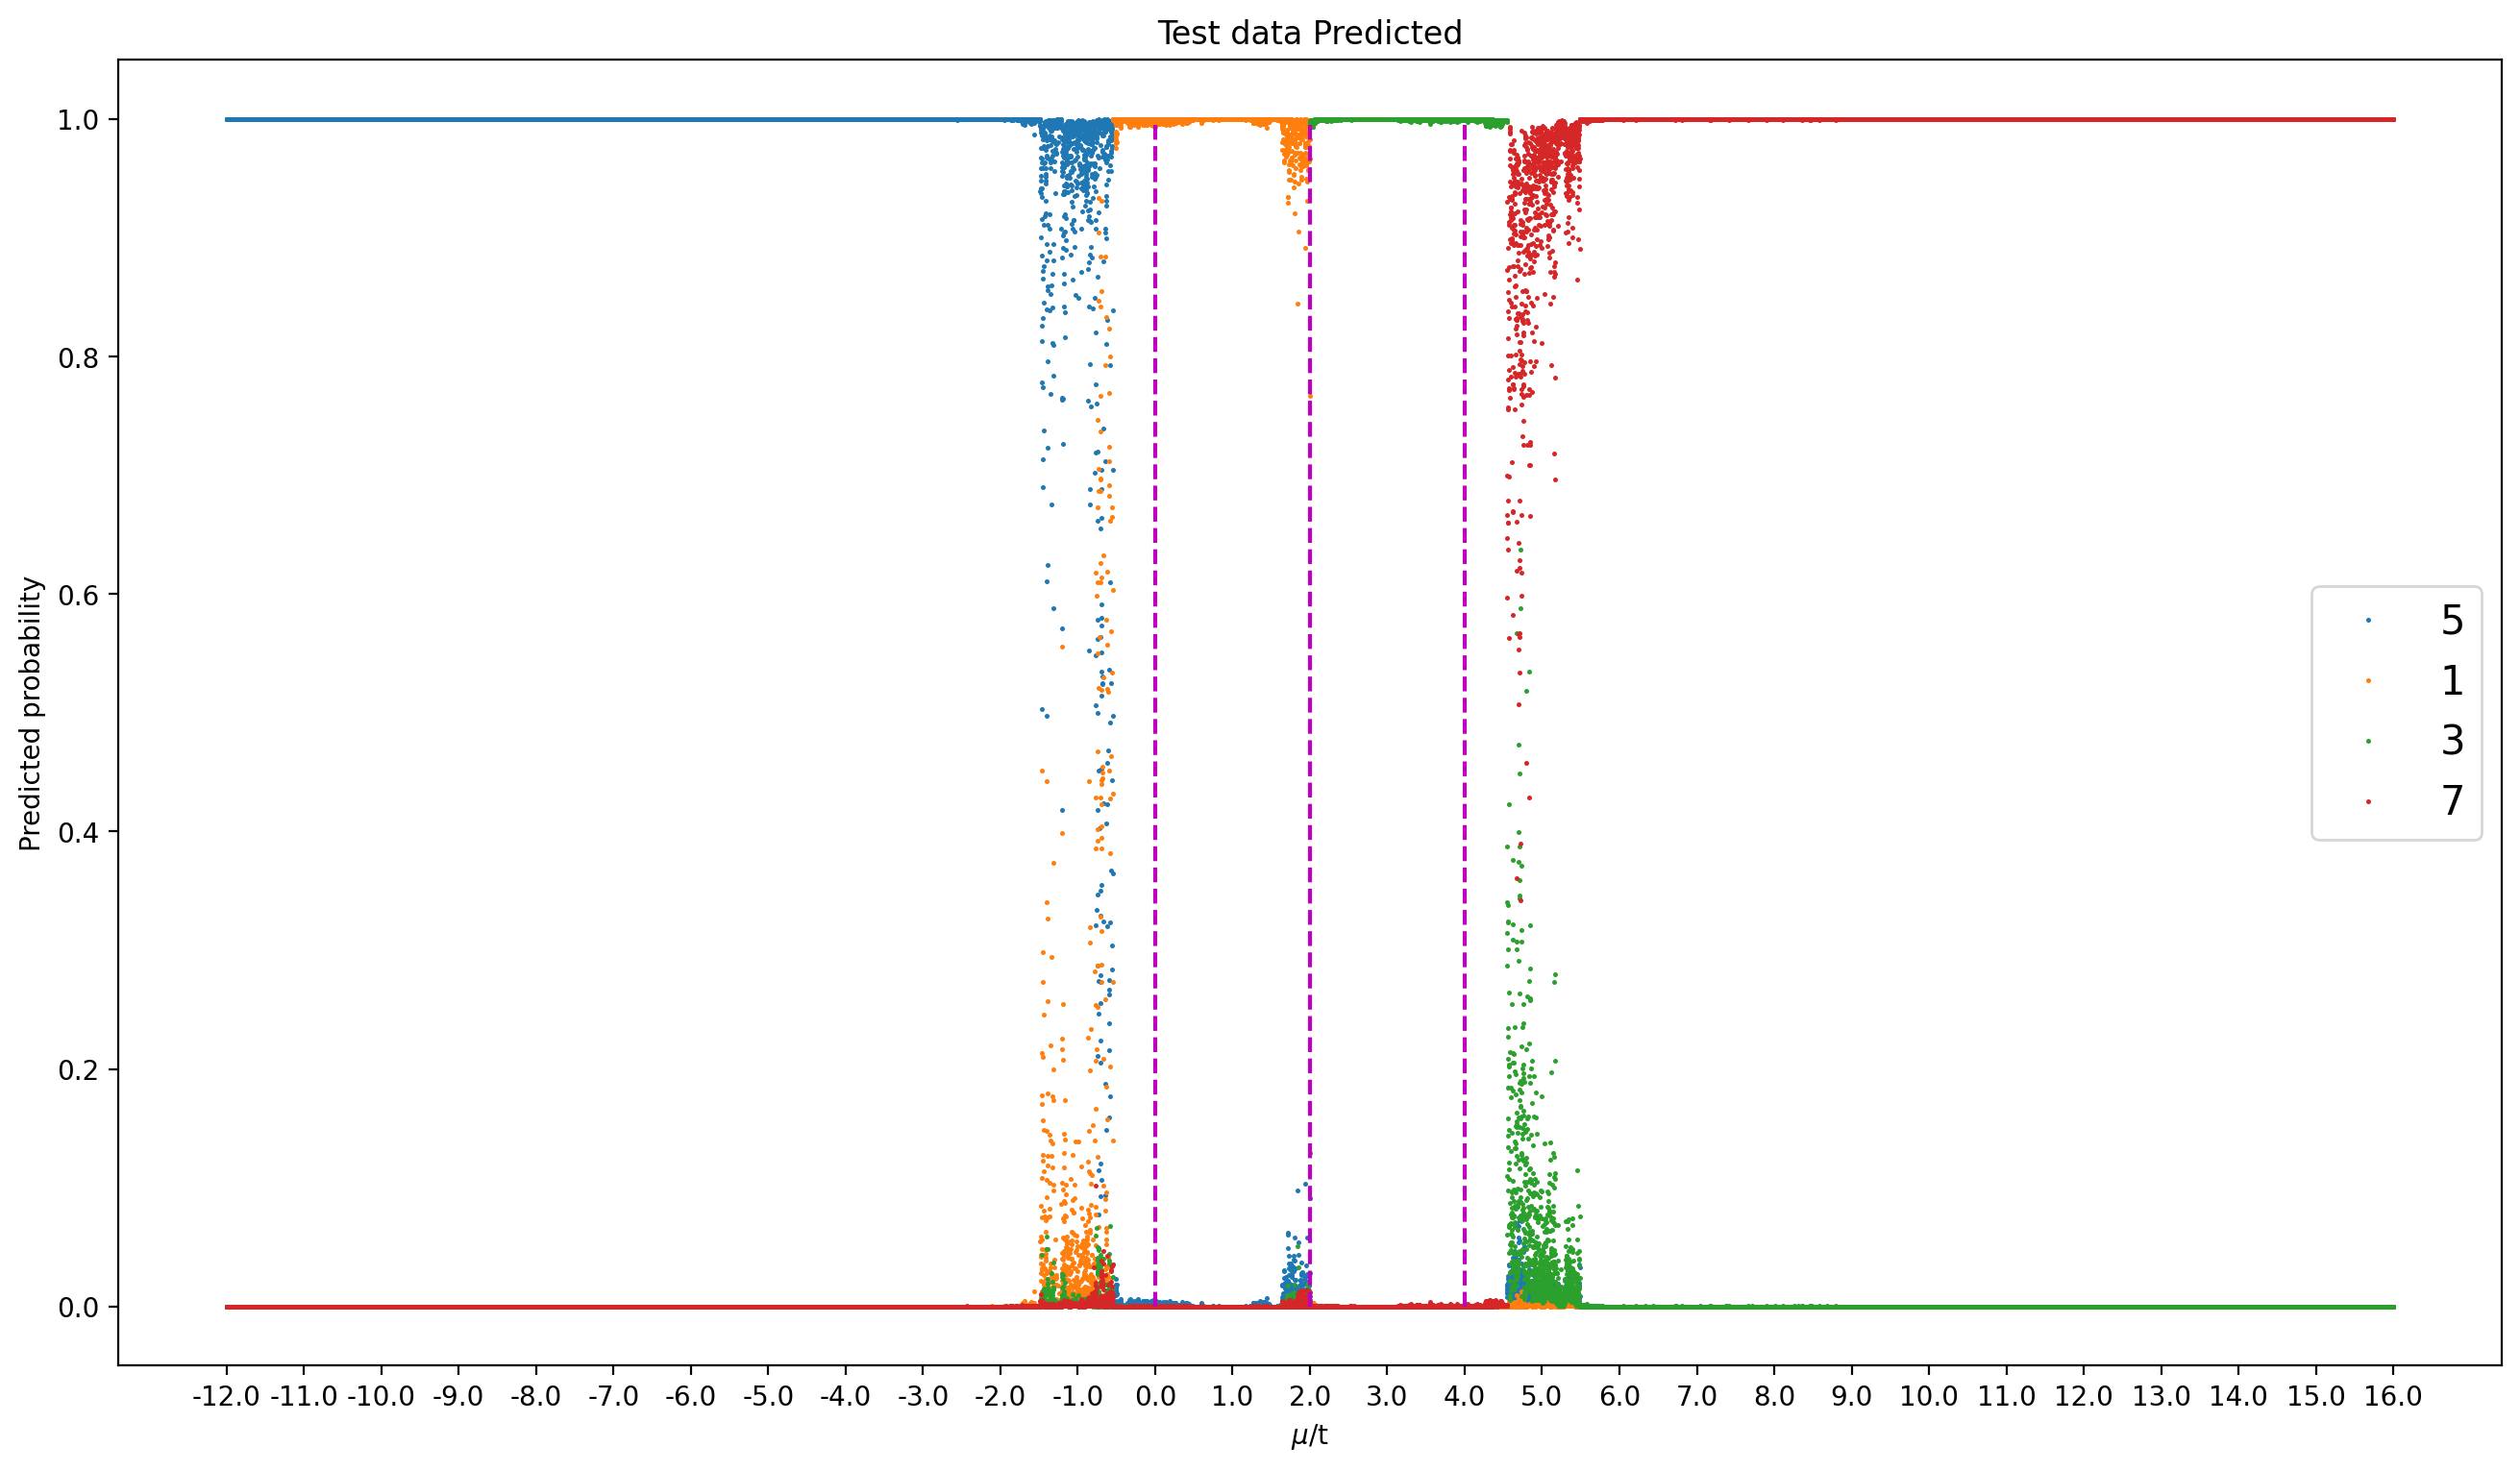

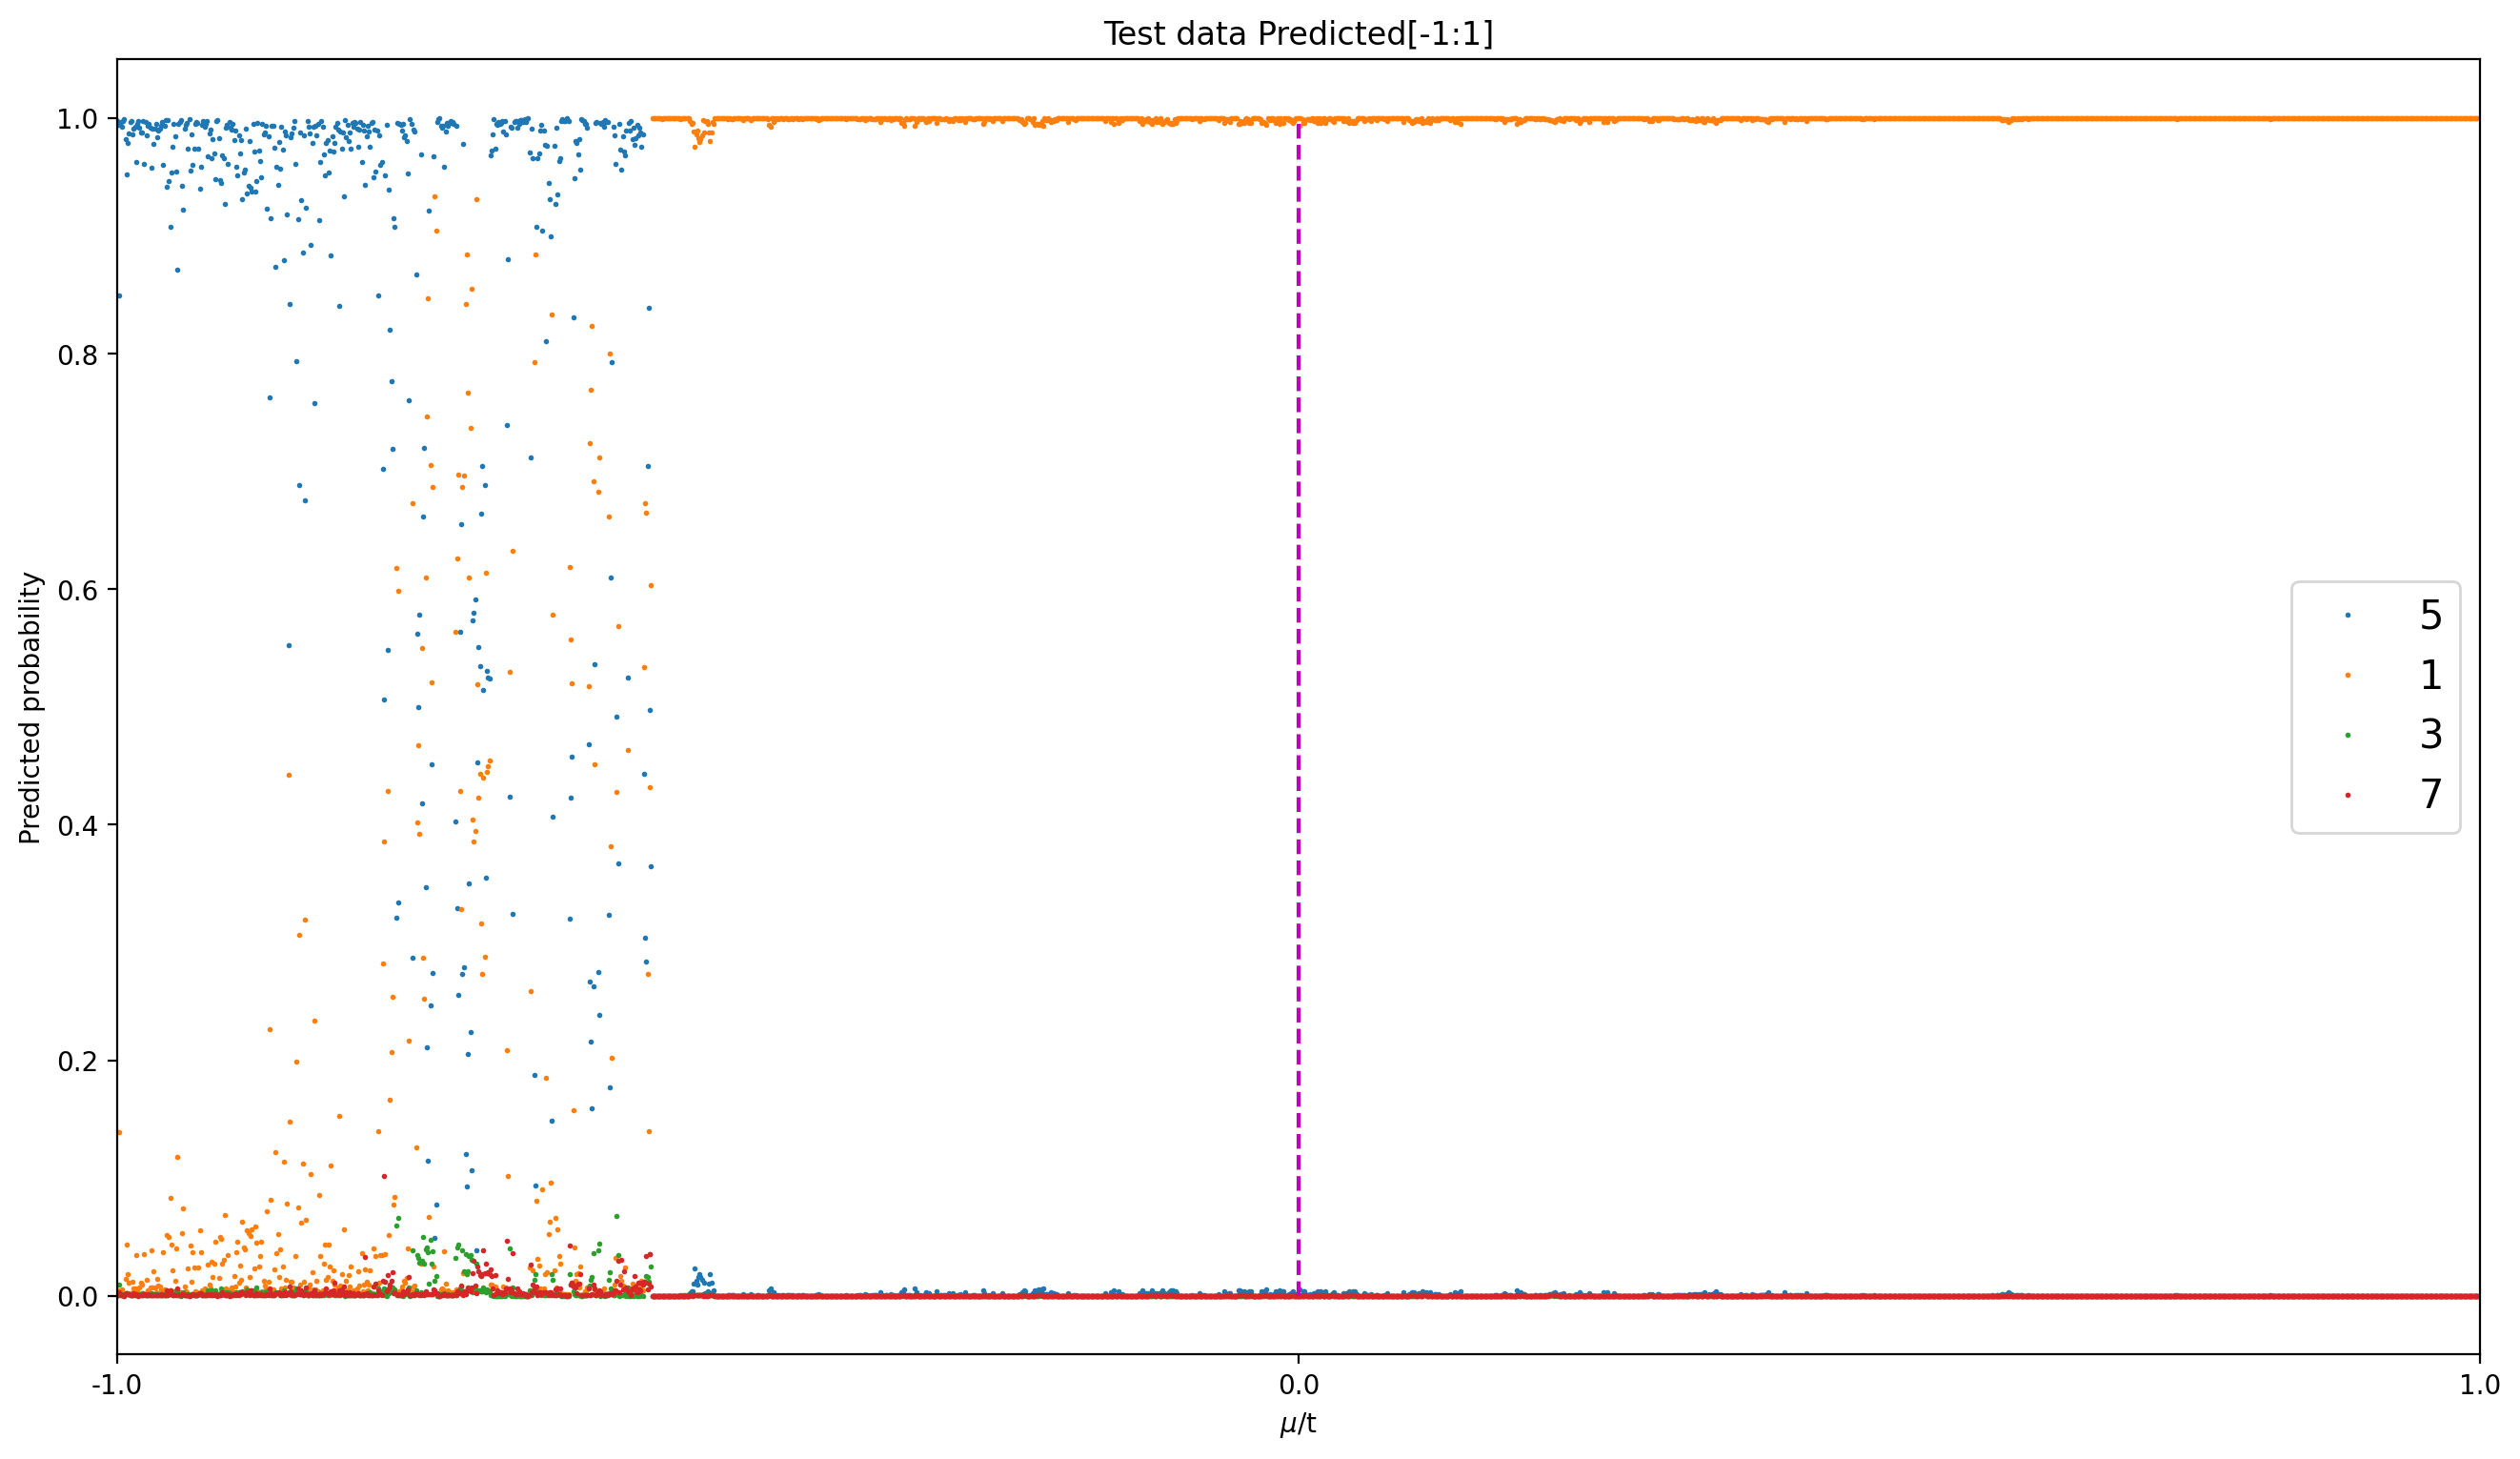

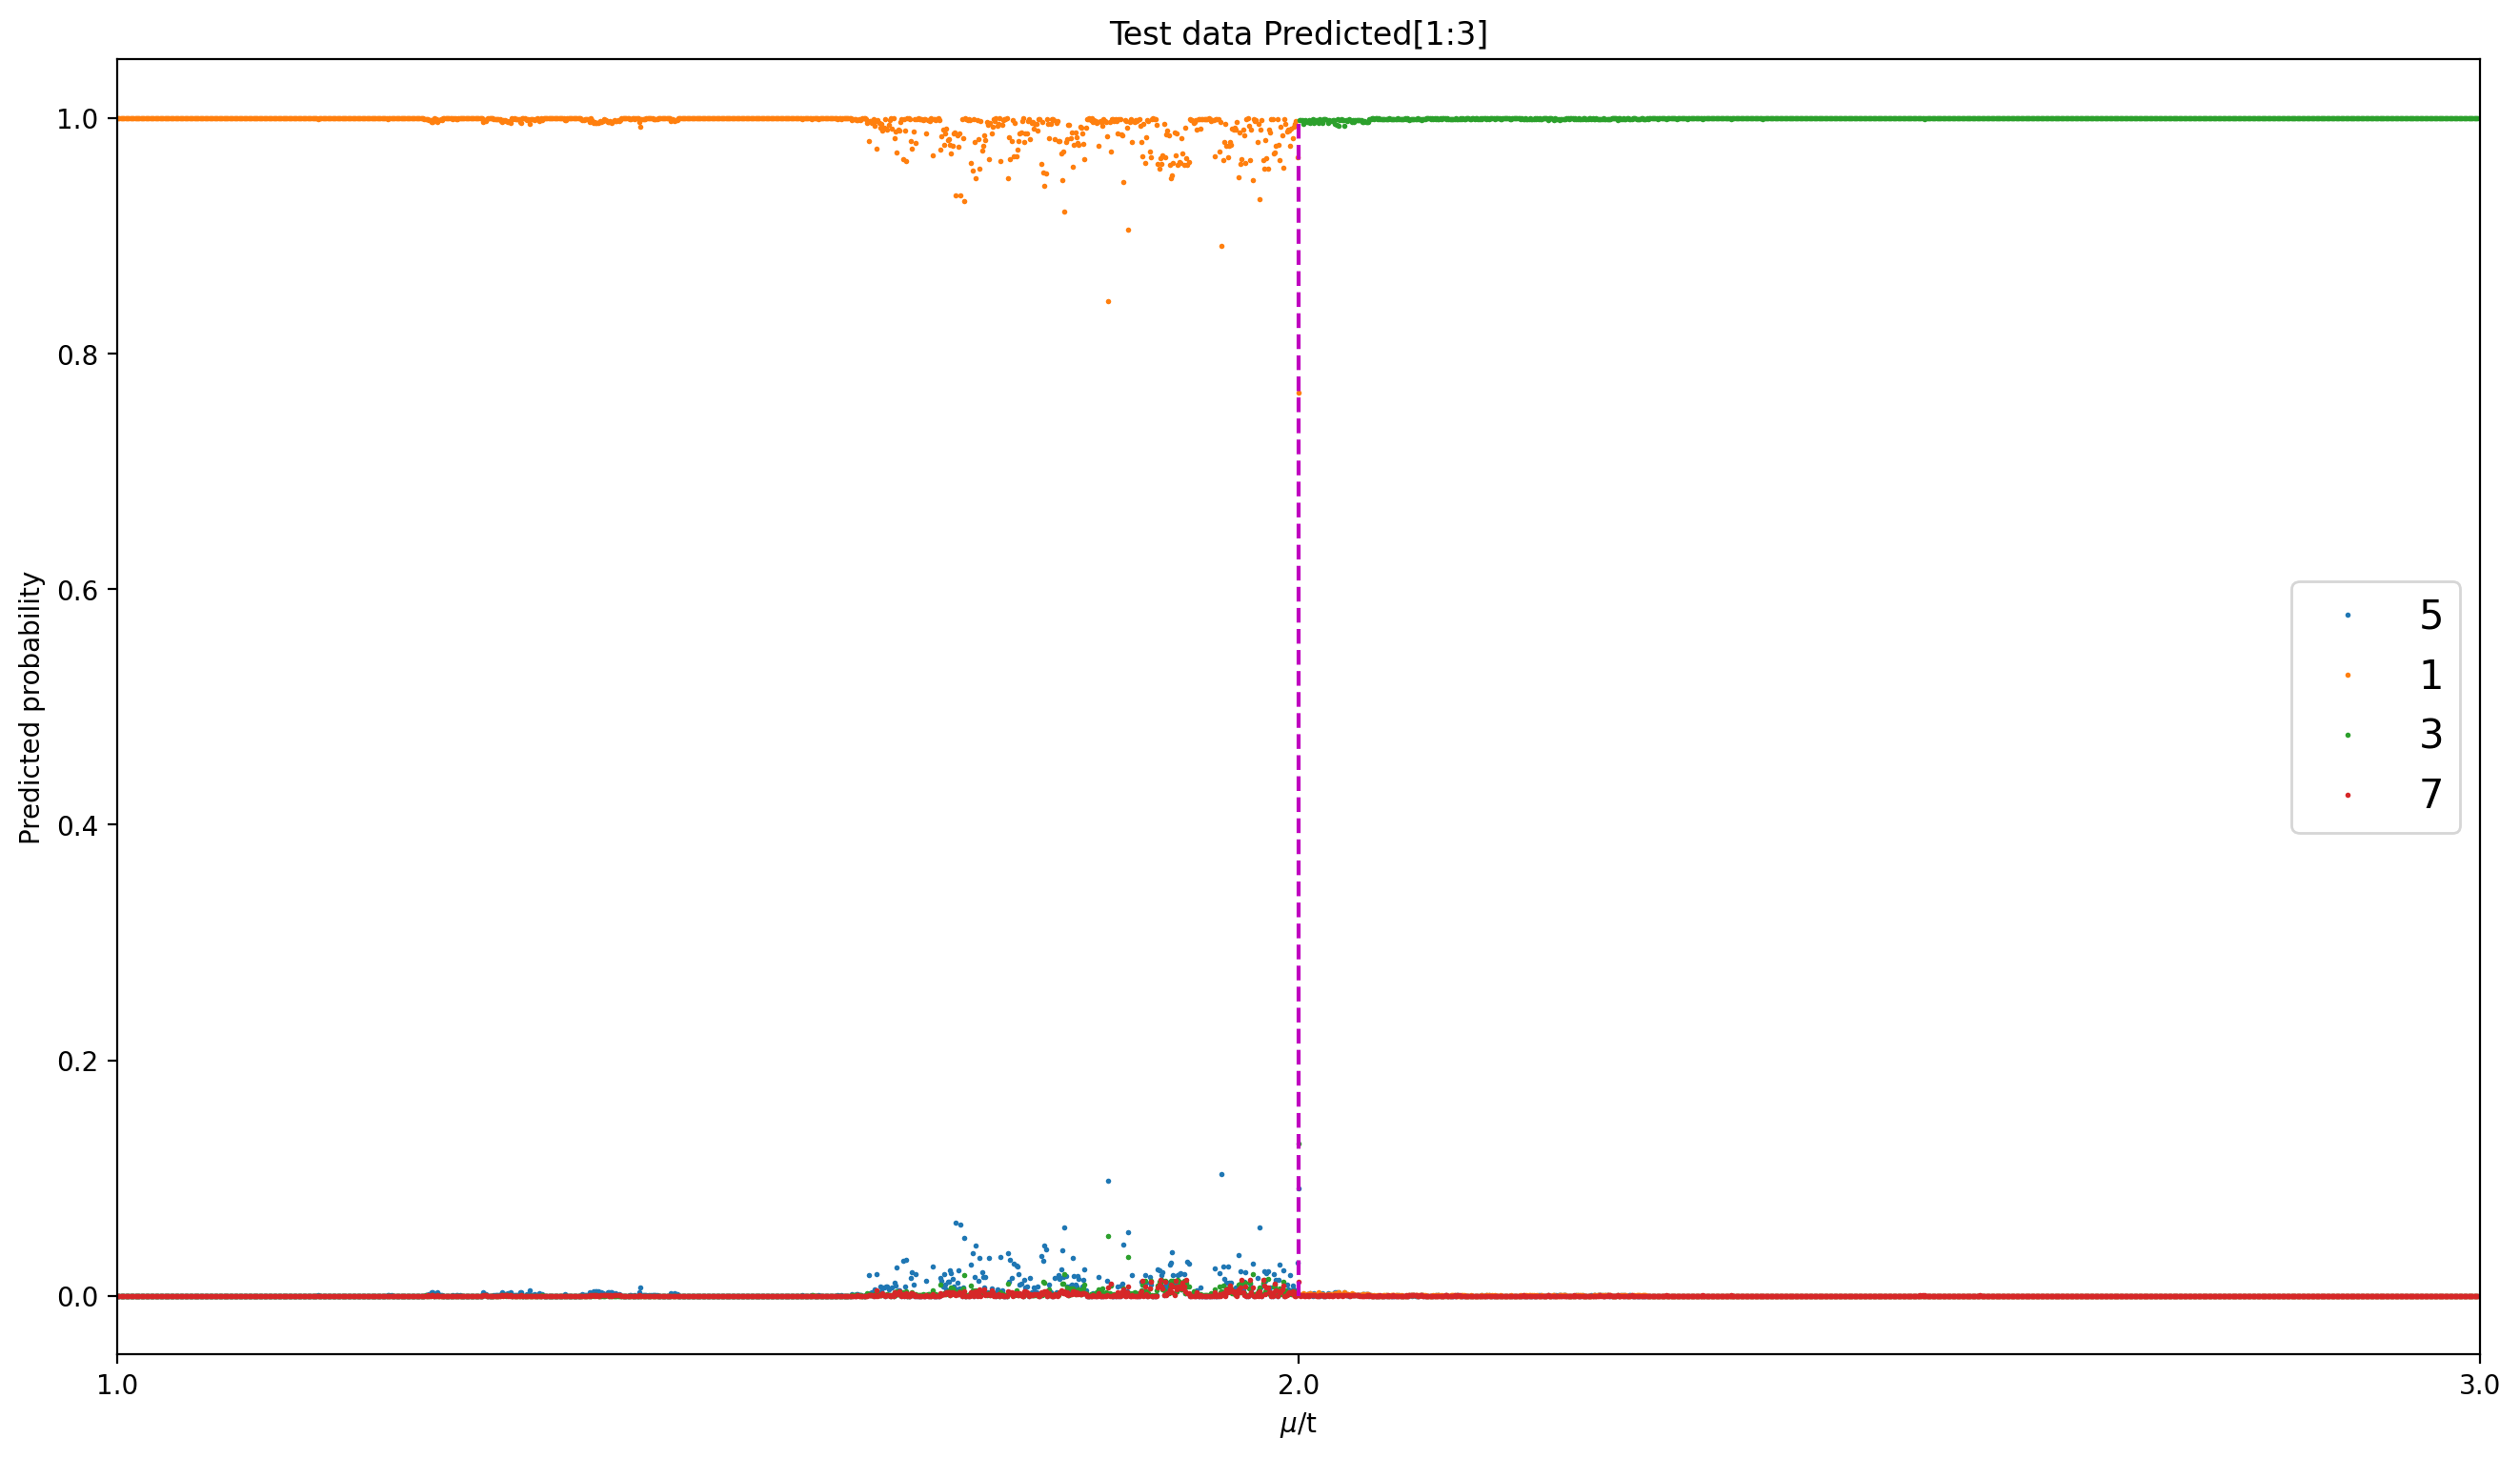

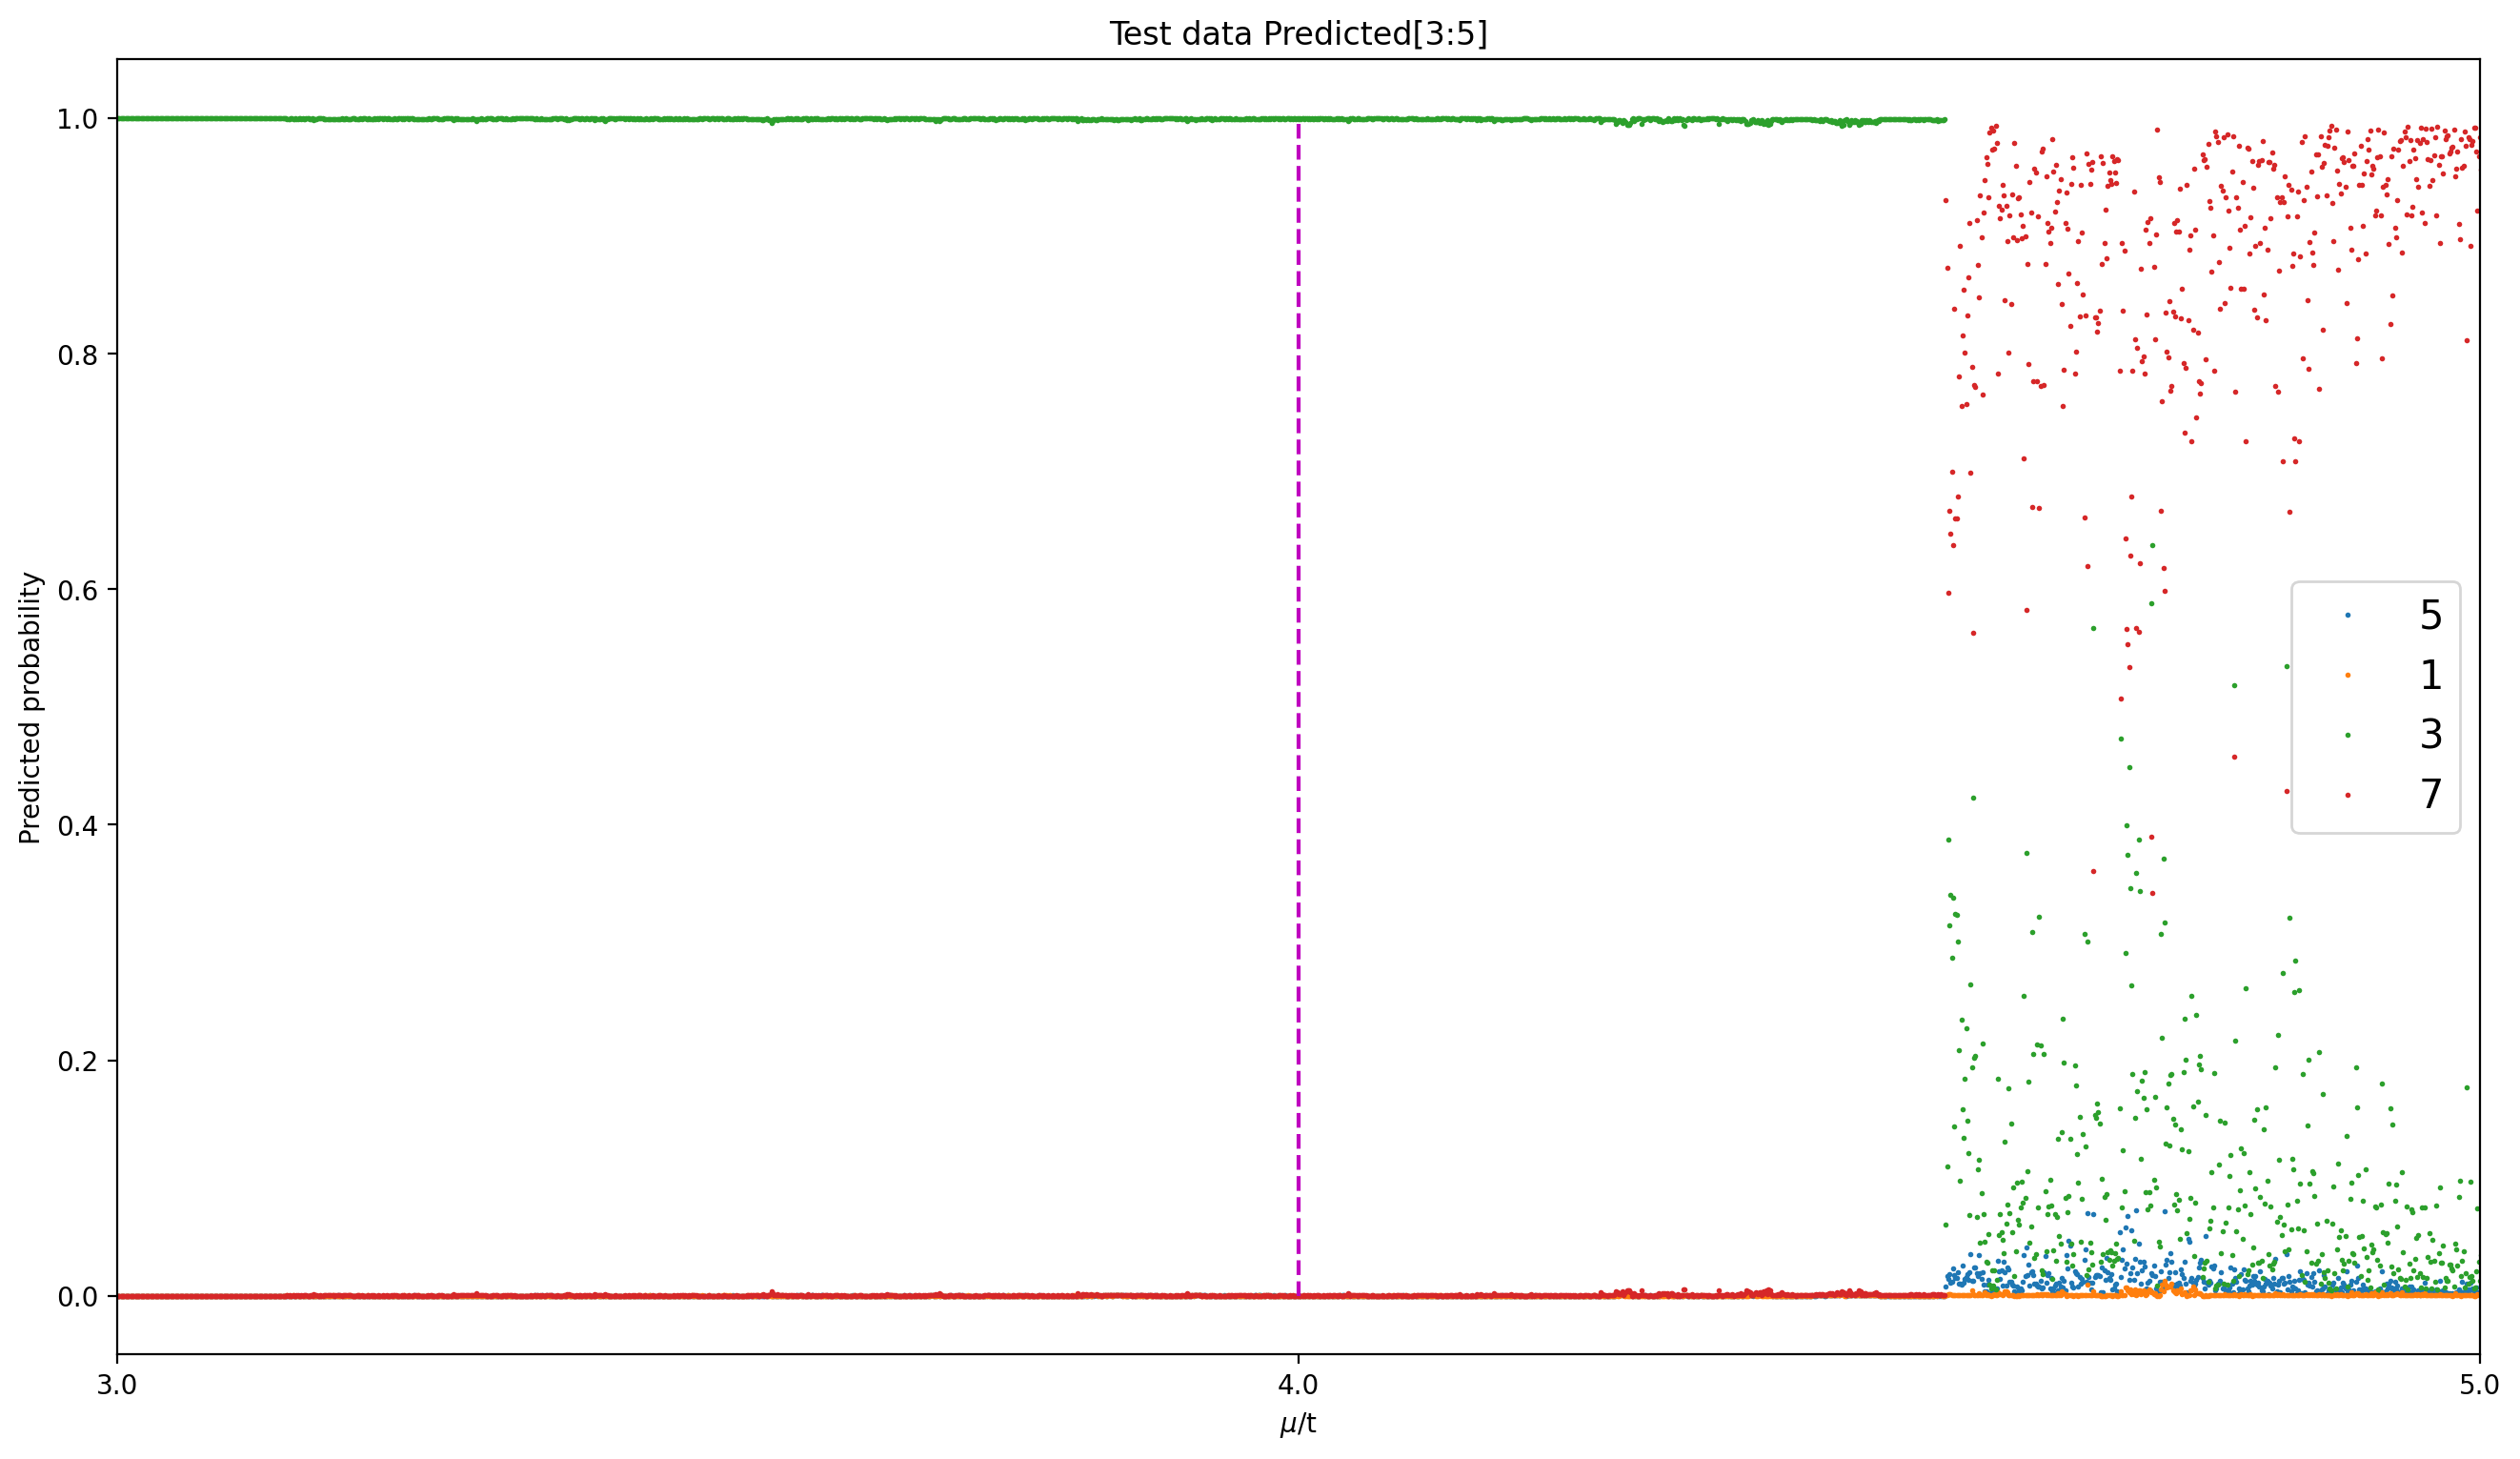

In [70]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_3D 添加濾波器

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確
在這版本，為資料添加了濾波器，作法為保留-0.2~0.2的資料其餘的轉為1

In [71]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

for k in arange(4000):
    for i in (arange(0,(2*NN**2)*3,3)):
        train_data[k,i][train_data[k,i] > 0.2] = 1
        train_data[k,i][train_data[k,i] < -0.2] = 1

for k in arange(28001):
    for i in (arange(0,(2*NN**2)*3,3)):
        test_data[k,i][test_data[k,i] > 0.2] = 1
        test_data[k,i][test_data[k,i] < -0.2] = 1       
        

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 150, 5, 5)
(4000,)
(4000, 4)
(28001, 150, 5, 5)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [72]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [73]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 150, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 150, 5, 5)
(3200, 4)
Number validation data = 
(800, 150, 5, 5)
(800, 4)


開始架構網路

In [74]:
channel = 2*(NN**2)*3

model = Sequential()

model.add(Conv2D(batch_input_shape = (None, channel, NN, NN),
                 filters = 2*channel,
                 kernel_size = (3,3),
                 activation = 'relu',
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size = (2,2),
                       padding = 'same',
                       data_format = 'channels_first')
         )

model.add(Conv2D(filters = 3*channel, 
                 kernel_size = (3,3), 
                 activation = 'relu', 
                 padding = 'same',
                 data_format = 'channels_first')
         )

model.add(MaxPooling2D(pool_size=(2,2),
                       padding = 'same',
                       data_format='channels_first')
         )

model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 300, 5, 5)         405300    
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 300, 3, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 450, 3, 3)         1215450   
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 450, 2, 2)         0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1800)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               922112    
_________________________________________________________________
dense_14 (Dense)             (None, 4)                

In [75]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [76]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 190us/step - loss: 0.1107 - accuracy: 0.9725 - val_loss: 2.6801e-04 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 0s 129us/step - loss: 1.9681e-04 - accuracy: 1.0000 - val_loss: 1.3993e-04 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 0s 129us/step - loss: 1.0875e-04 - accuracy: 1.0000 - val_loss: 7.9544e-05 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 0s 134us/step - loss: 6.4726e-05 - accuracy: 1.0000 - val_loss: 4.9250e-05 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 0s 133us/step - loss: 4.0674e-05 - accuracy: 1.0000 - val_loss: 3.1793e-05 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 0s 135us/step - loss: 2.7069e-05 - accuracy: 1.0000 - val_loss: 2.1877e-05 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===========

訓練完成  
開始提取模型資料

In [77]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


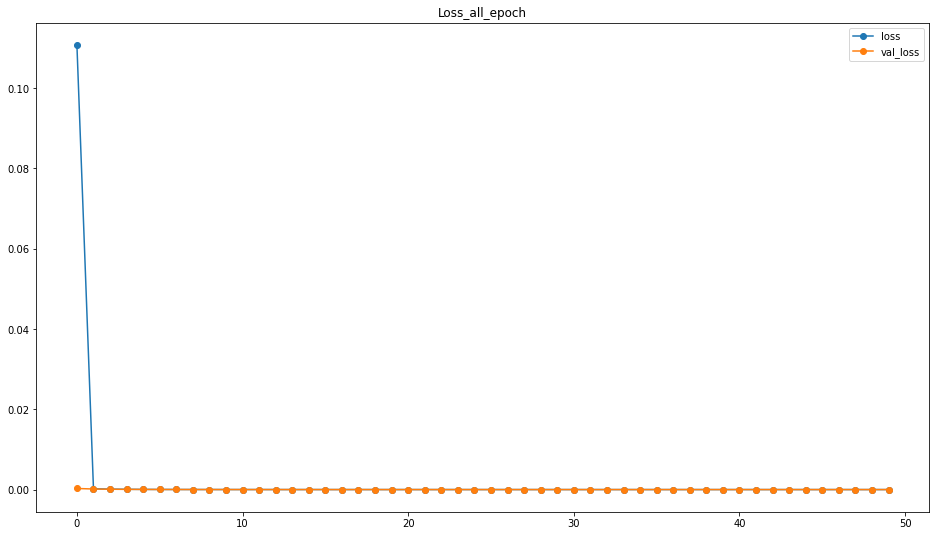

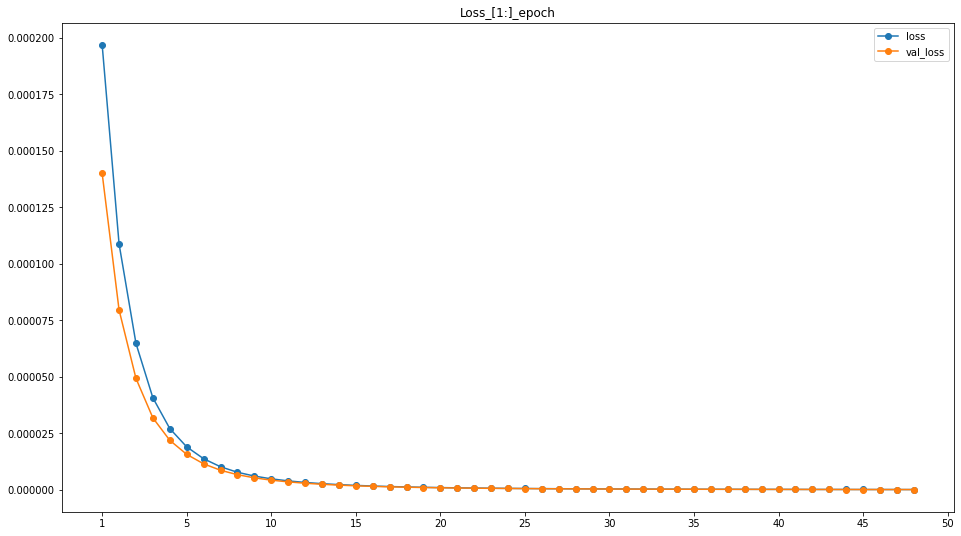

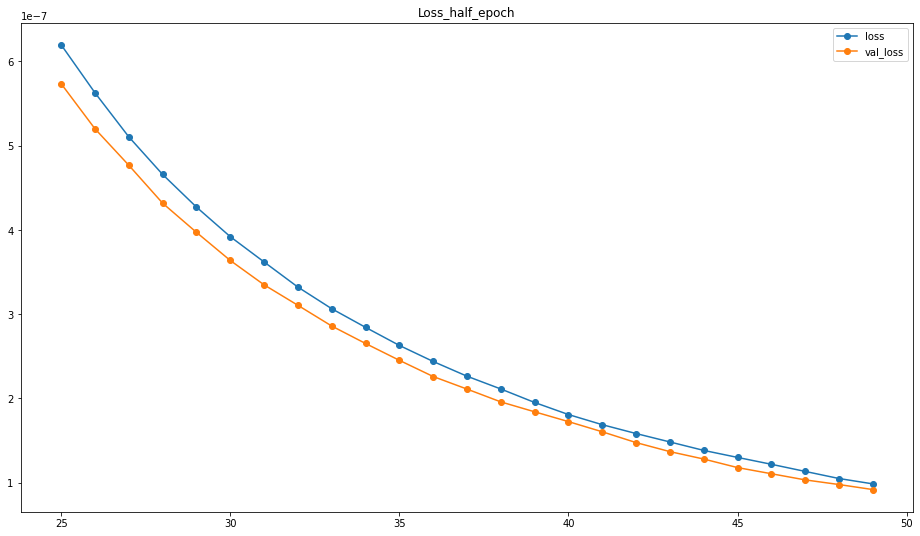

In [78]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [79]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 88us/step


In [80]:
print (scores)

[0.022736662793566852, 0.9892503619194031]


In [81]:
prediction = model.predict(test_data)

In [82]:
print(prediction)

[[9.99999166e-01 3.49980041e-07 1.74954238e-07 3.00969987e-07]
 [9.99998450e-01 6.87819181e-07 5.89650824e-07 2.34132301e-07]
 [9.99999404e-01 3.45593463e-07 1.52890919e-07 1.41448993e-07]
 ...
 [9.91545676e-07 7.02576983e-07 2.64546361e-06 9.99995708e-01]
 [7.96505901e-07 7.66435790e-07 1.79426752e-06 9.99996662e-01]
 [2.25589233e-07 1.13510005e-07 5.01059901e-07 9.99999166e-01]]


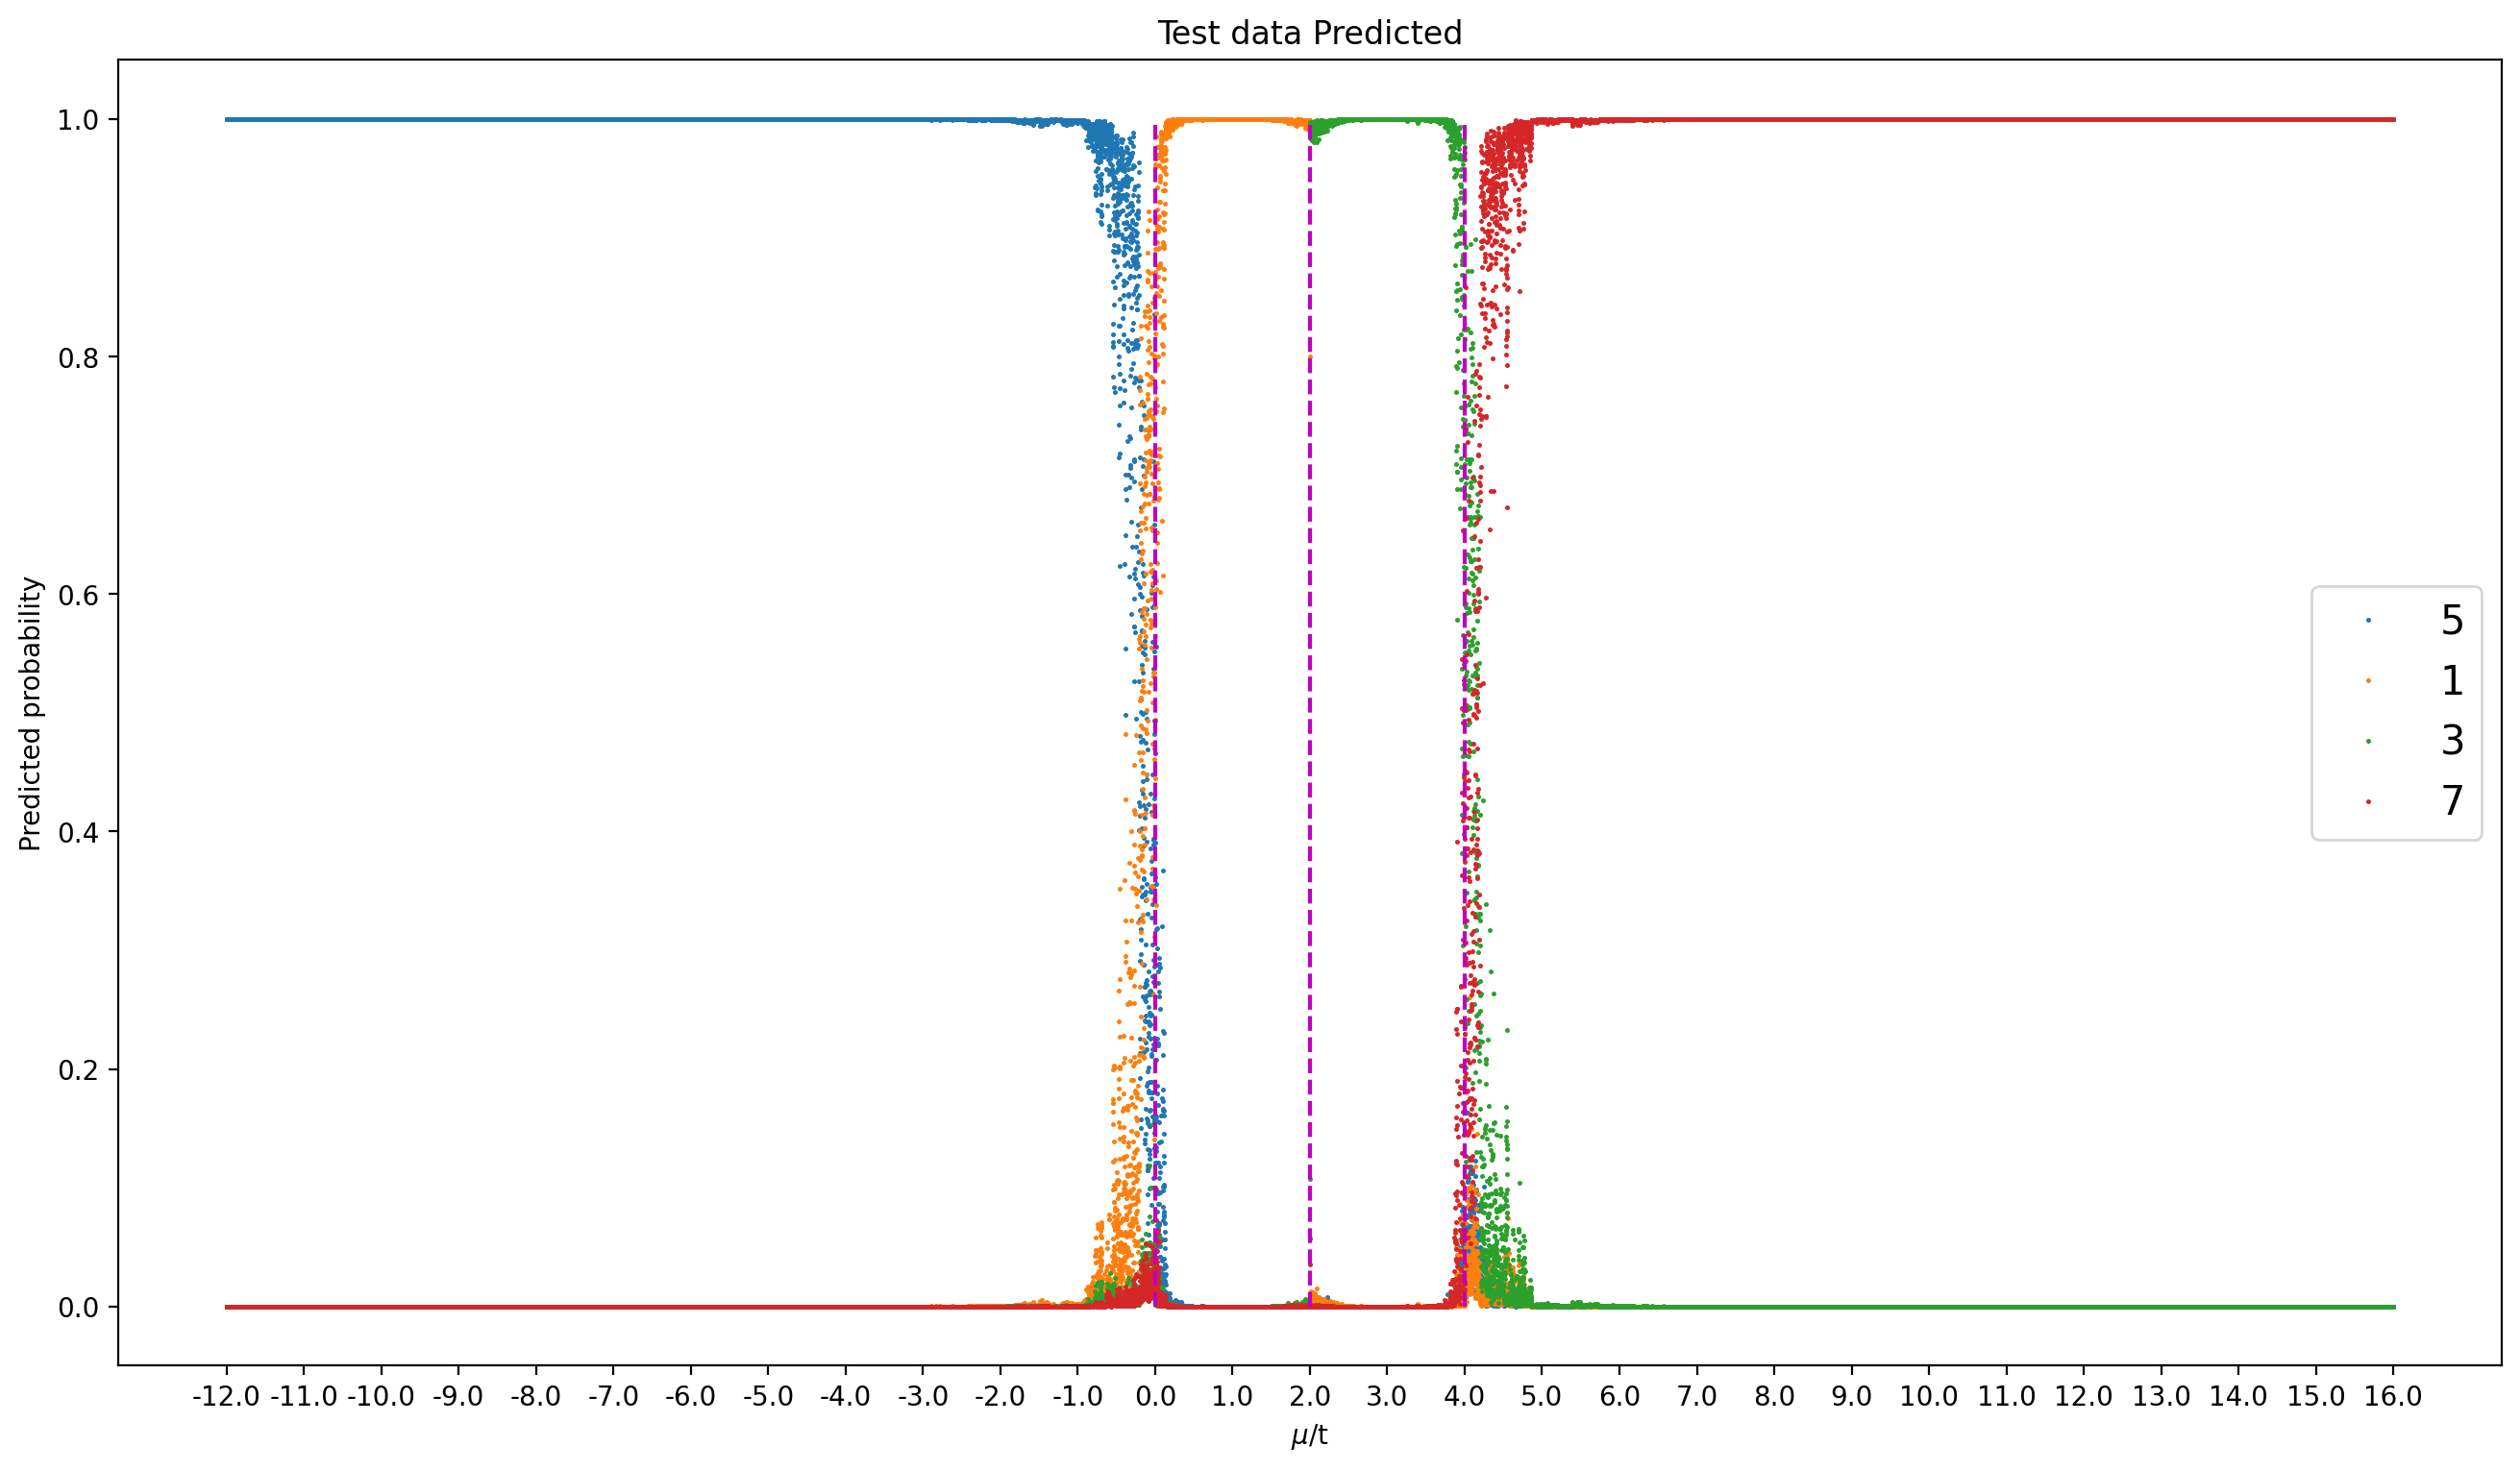

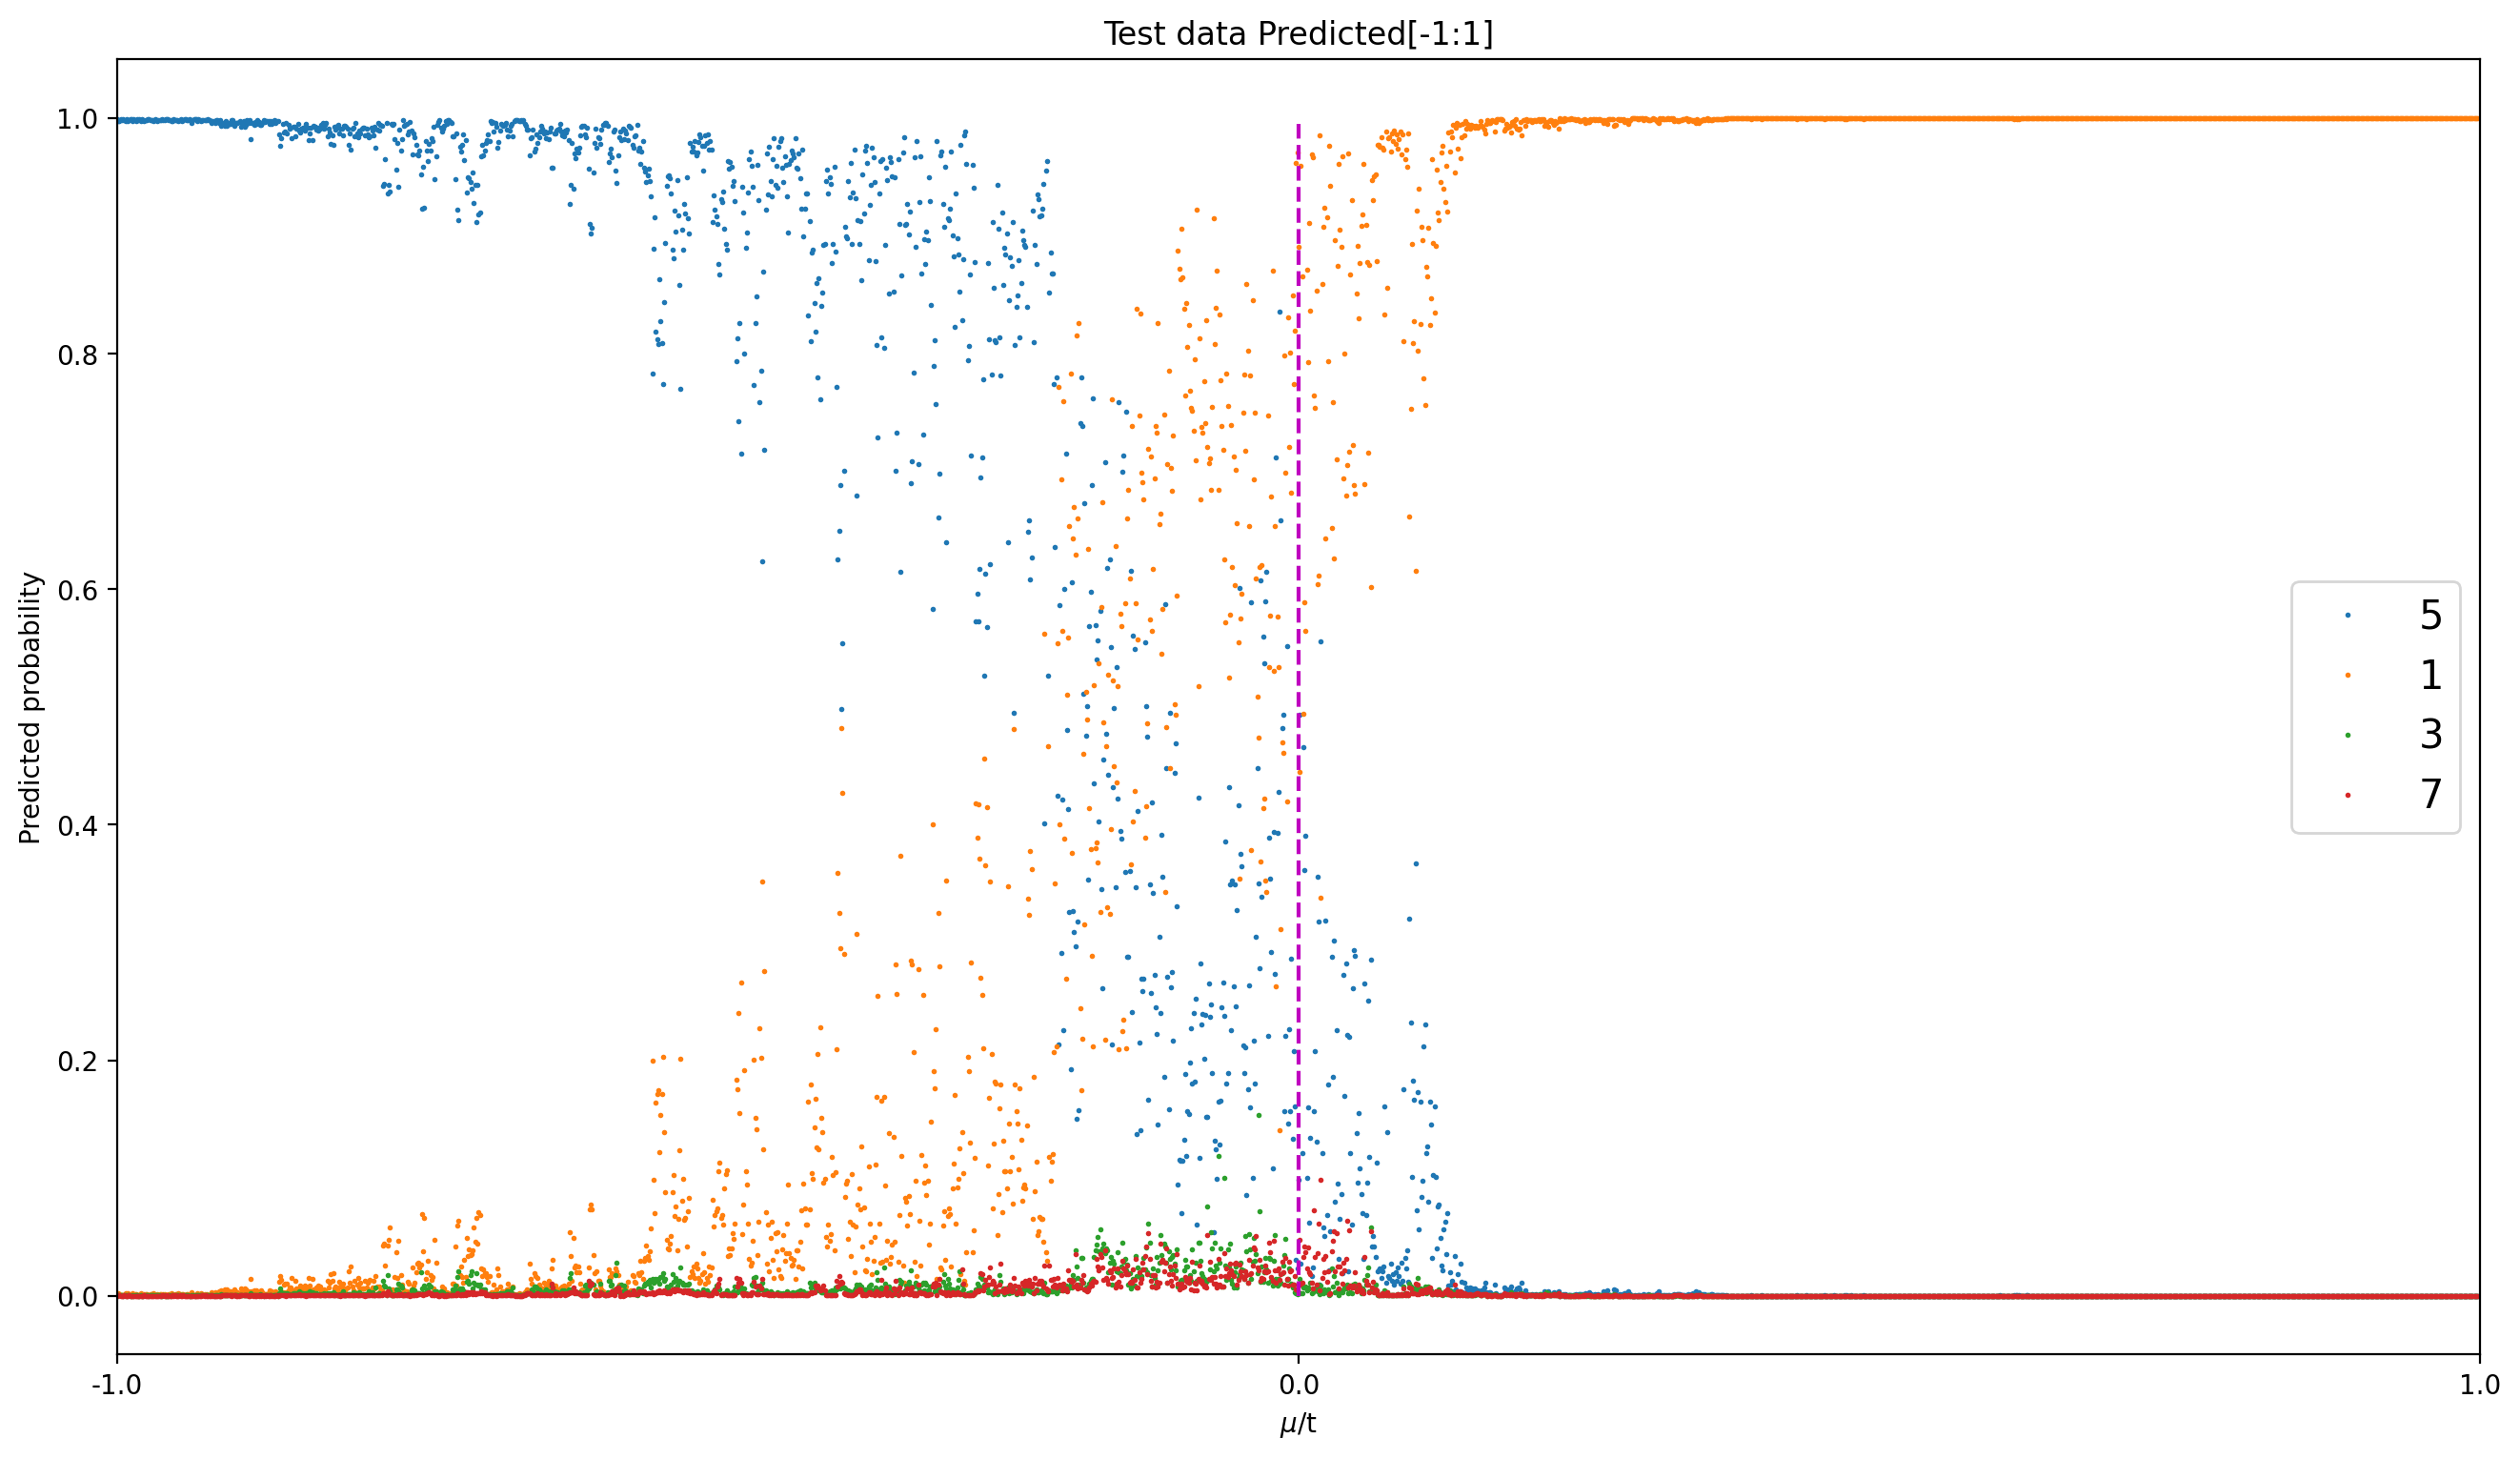

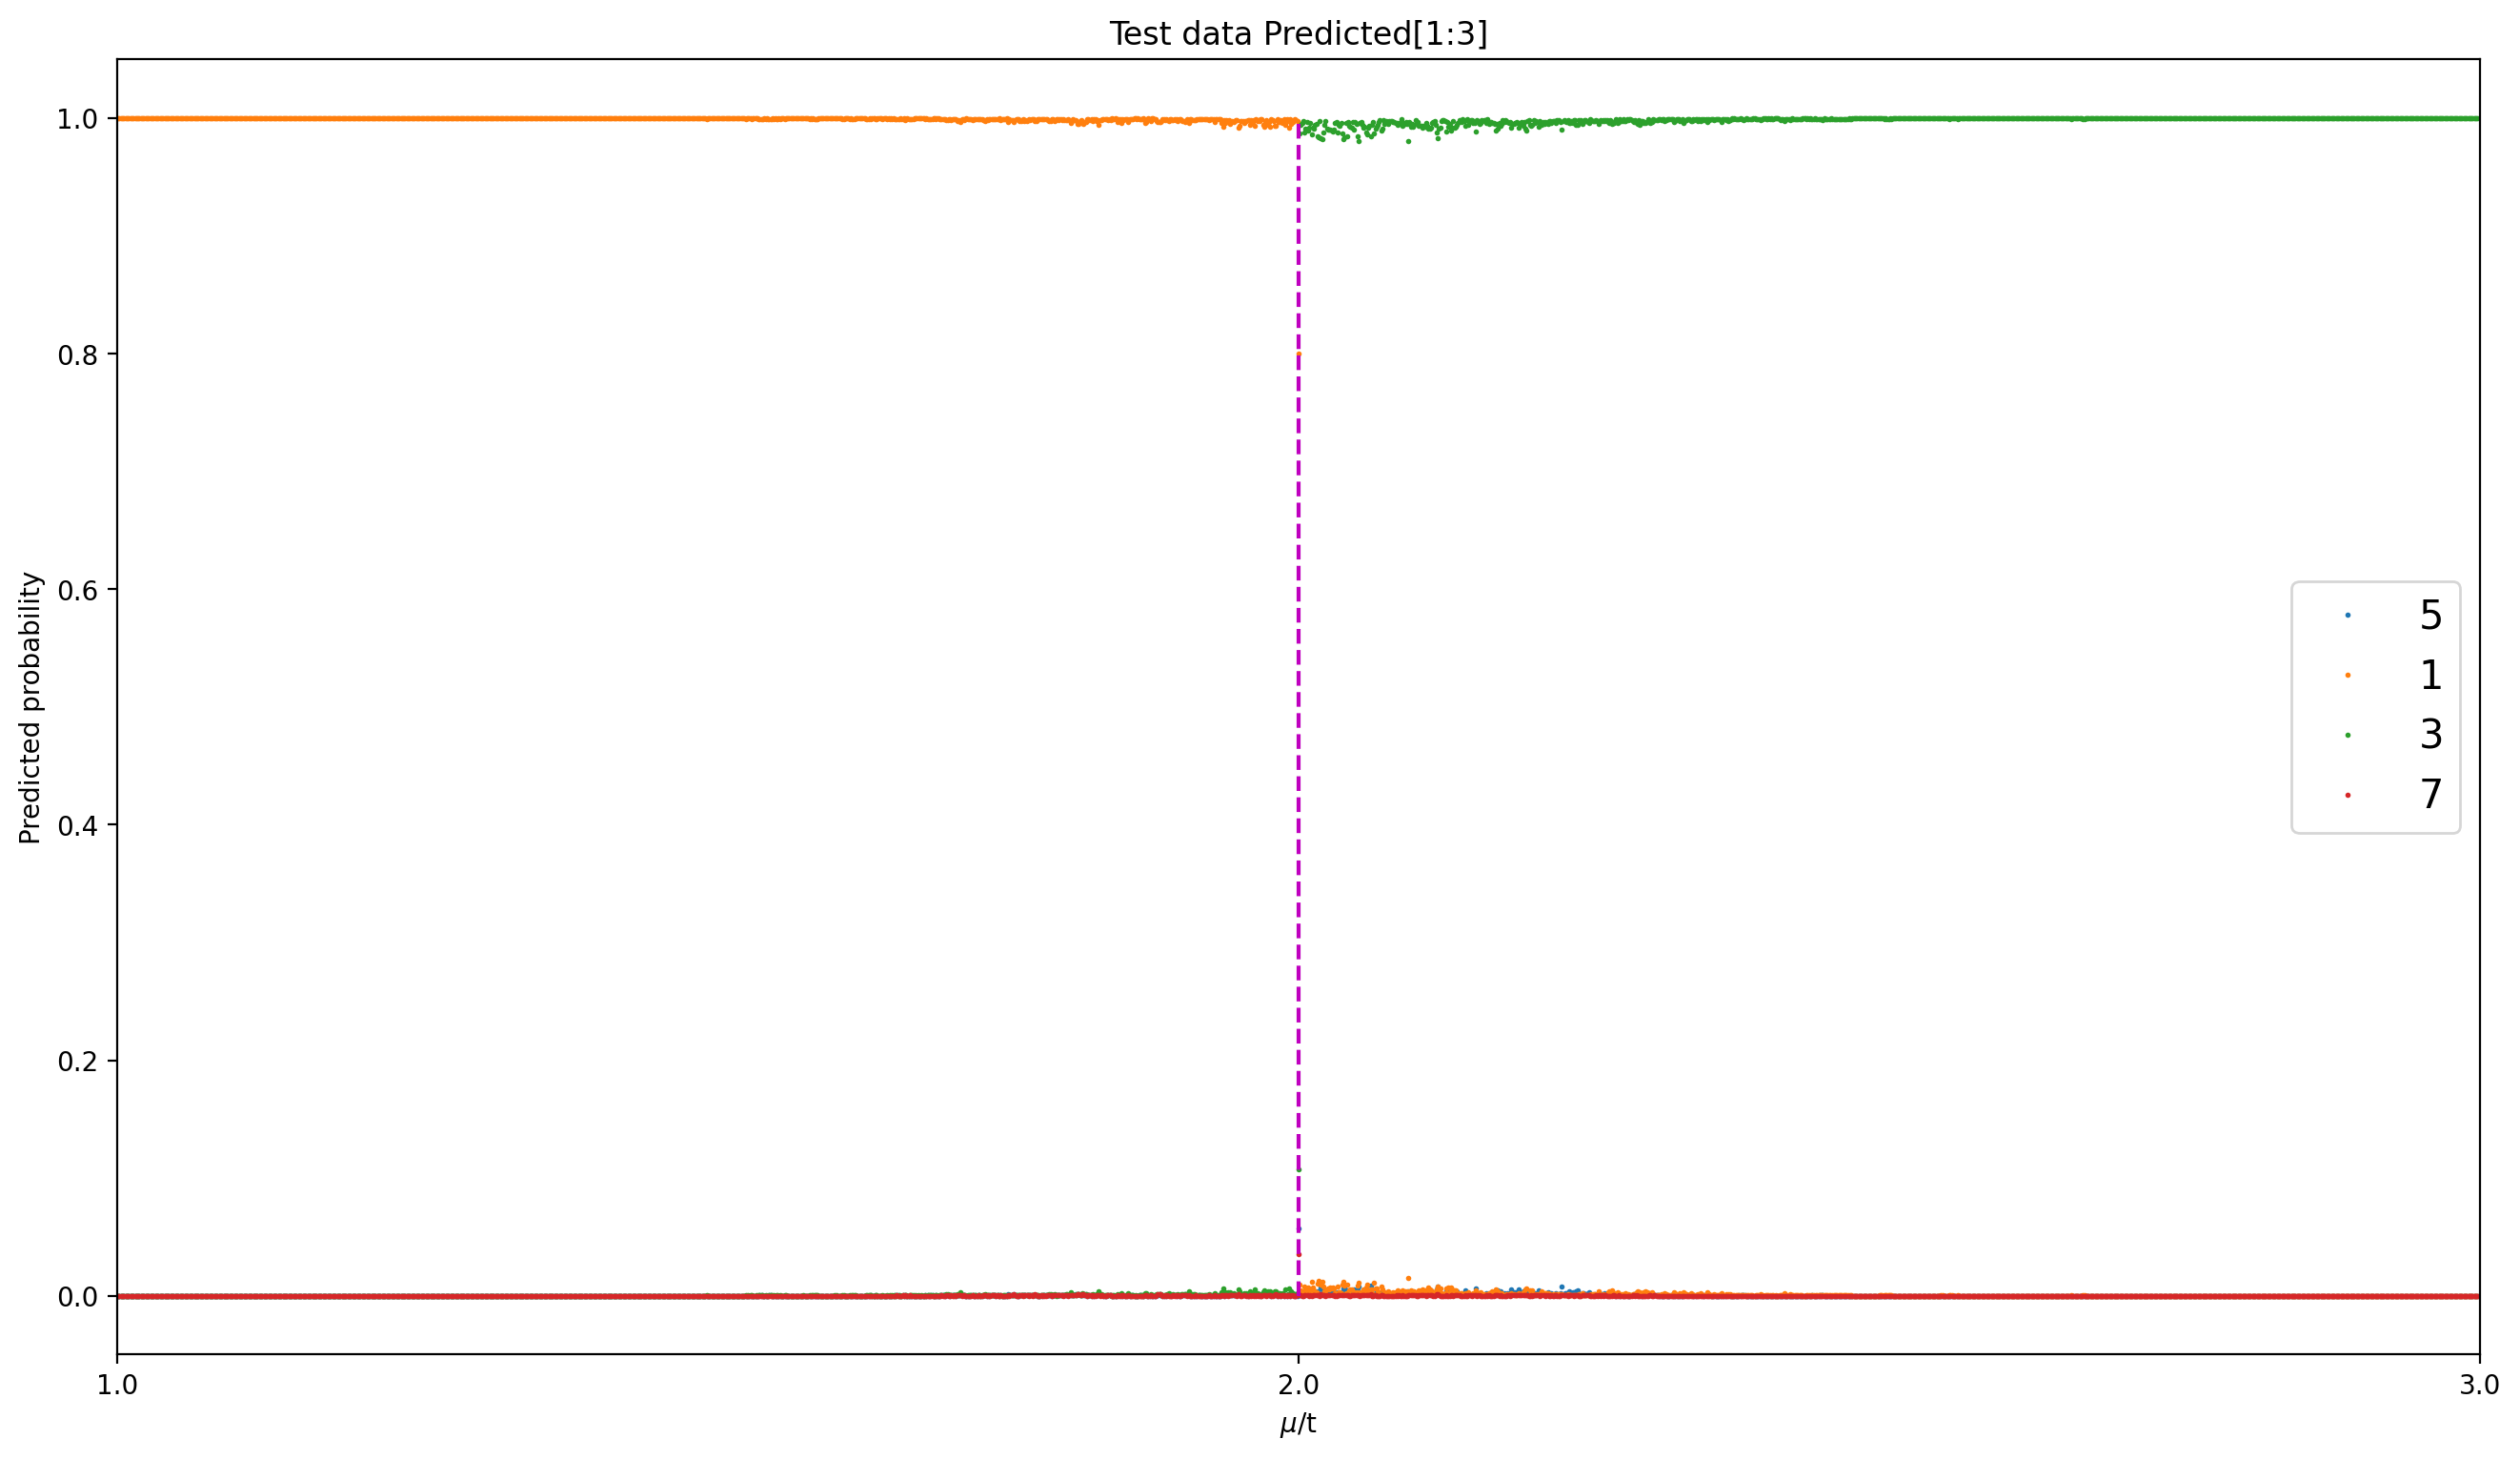

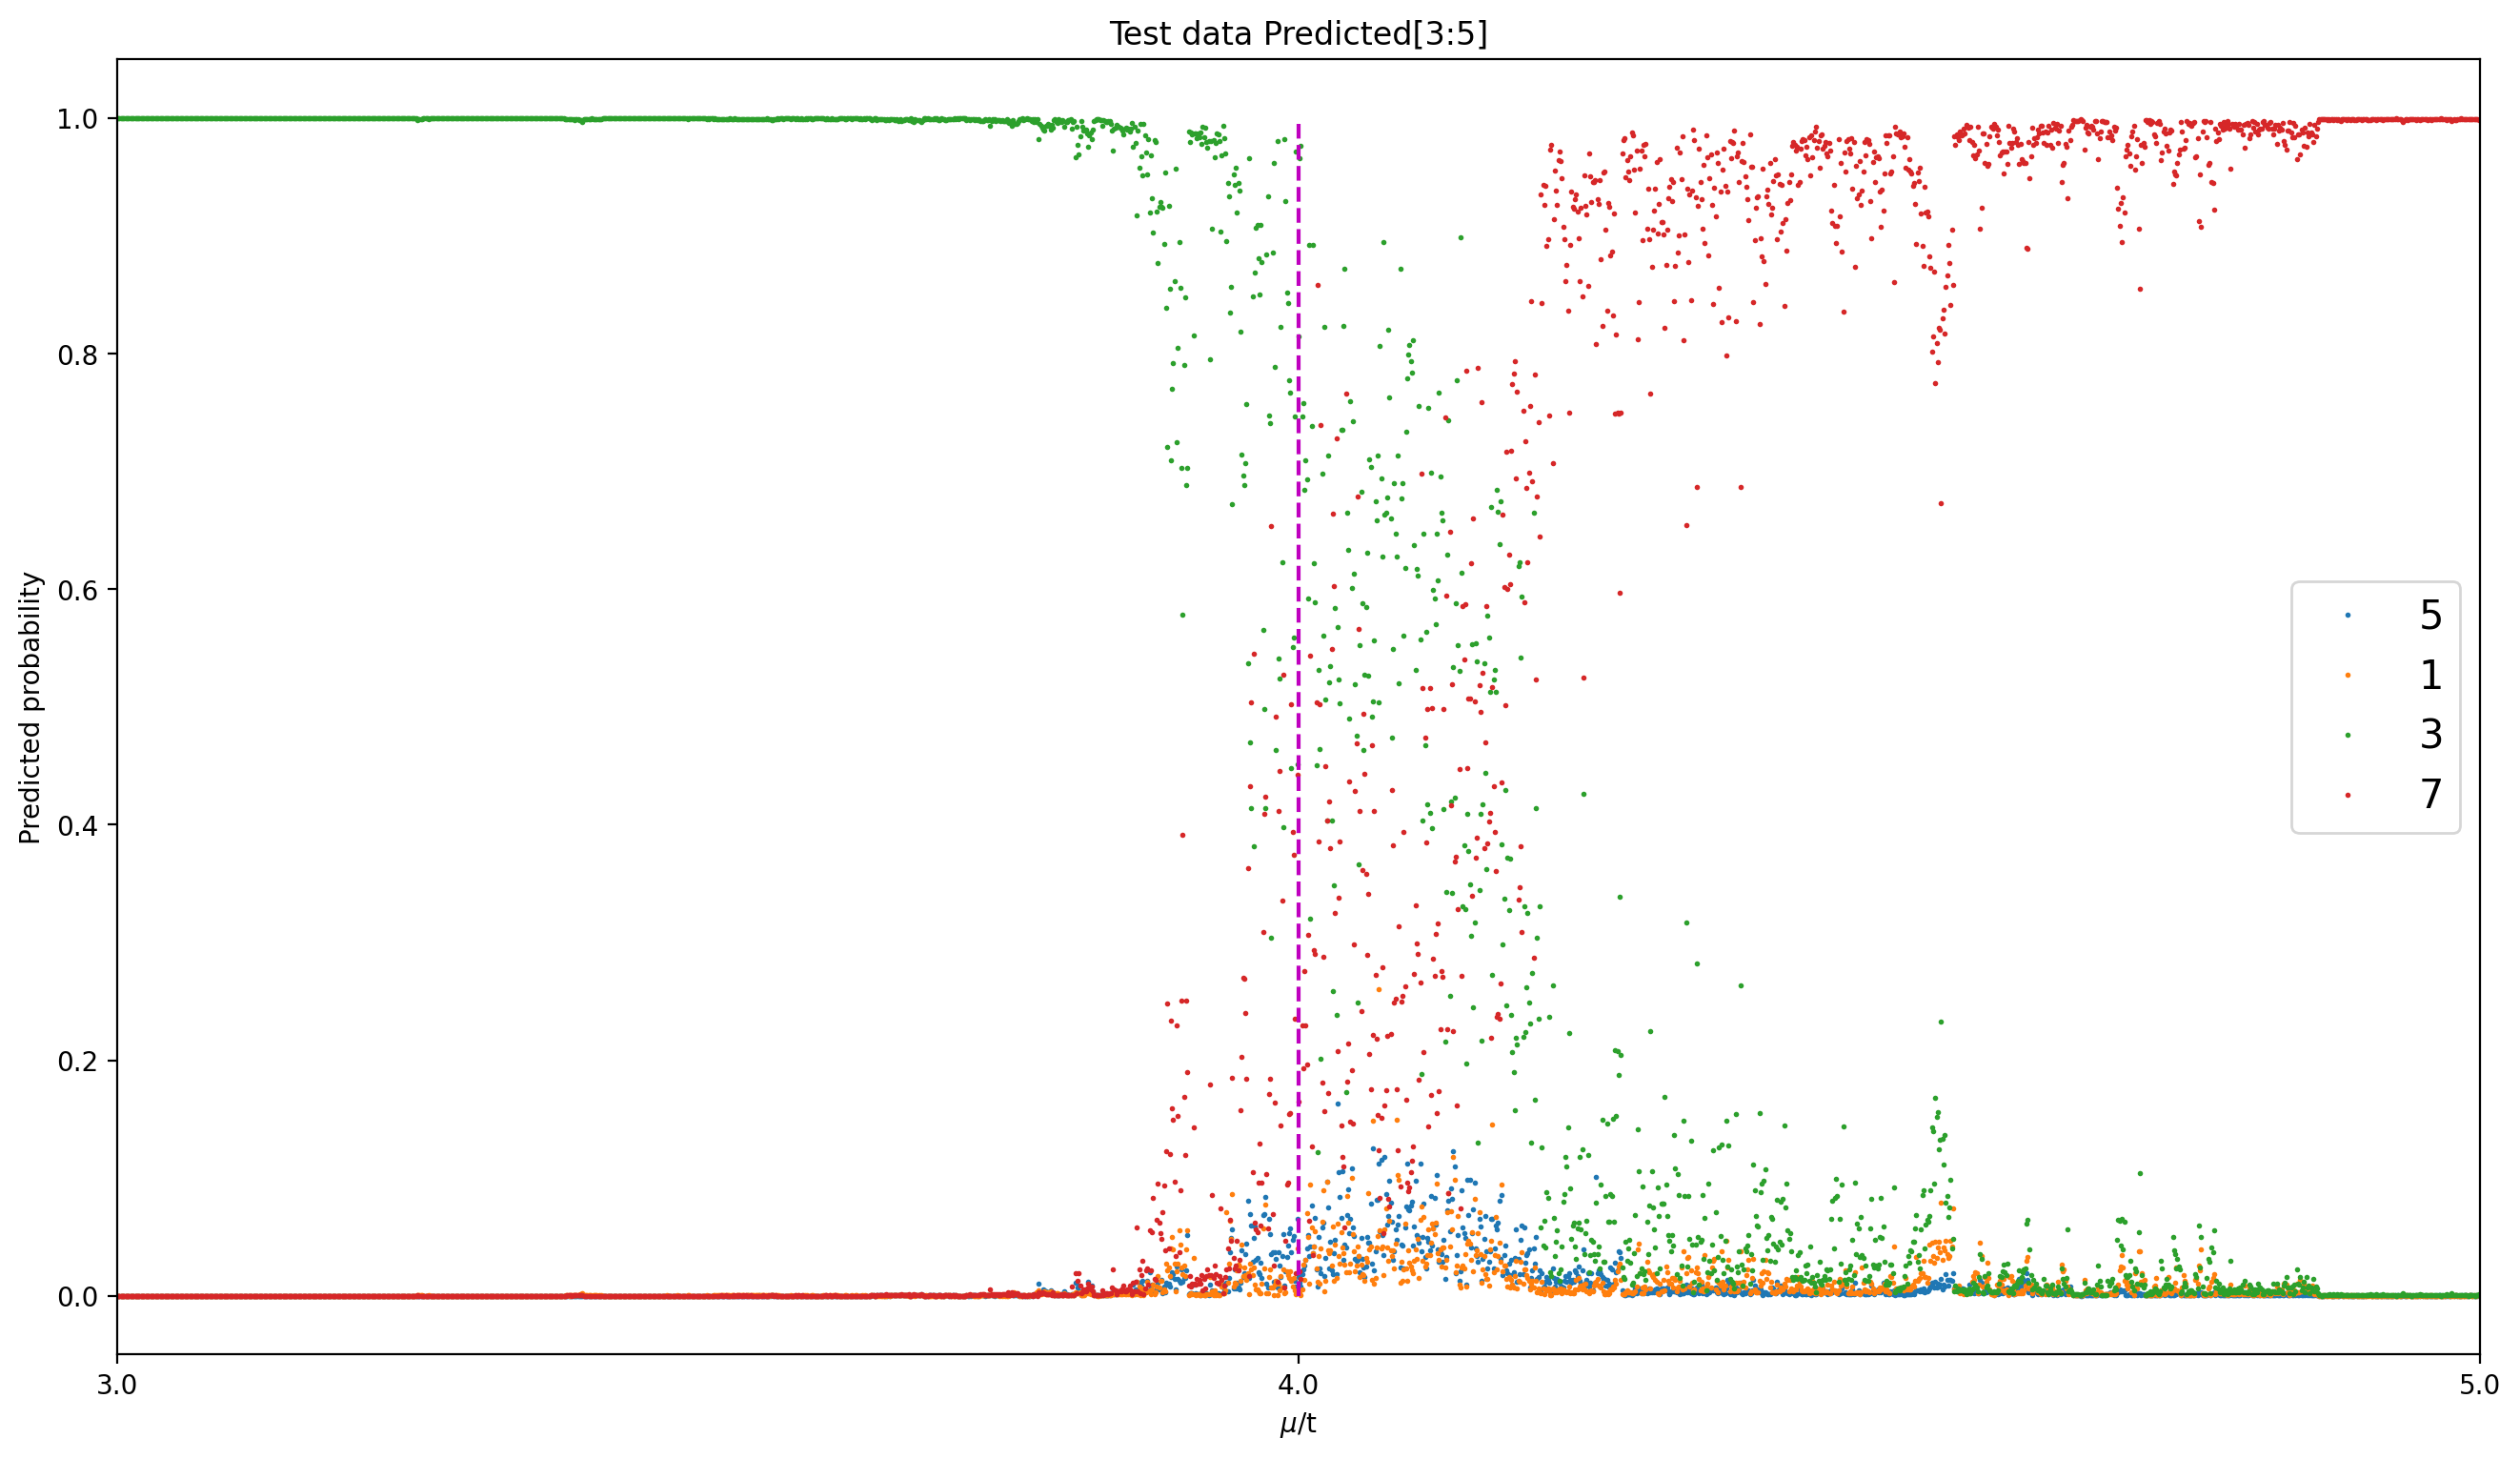

In [83]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# Test resnet

# eigenvector_r_theta_3D_resnet

開始獲取eigenvector_r_theta_3D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [84]:
train_data = get_train_data(train_data_path, date, N, delta)[6]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 150, 5, 5)
(4000,)
(4000, 4)
(28001, 150, 5, 5)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [98]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [99]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 150, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 150, 5, 5)
(3200, 4)
Number validation data = 
(800, 150, 5, 5)
(800, 4)


開始架構網路

In [100]:
def resnet(input_shape):
    
    channel = 2*(NN**2)*3
    
    inputs = Input(shape=input_shape)
    
    x = Convolution2D(batch_input_shape = (None, channel, NN, NN), 
                      filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution2D(filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 2*(NN**2)*3
model = resnet((channel, NN, NN))

In [101]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 150, 5, 5)    0                                            
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 150, 5, 5)    202650      input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 150, 5, 5)    20          conv2d_14[0][0]                  
__________________________________________________________________________________________________
activation_4 (Activation)       (None, 150, 5, 5)    0           batch_normalization_3[0][0]      
____________________________________________________________________________________________

In [102]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [103]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 343us/step - loss: 0.0347 - accuracy: 0.9859 - val_loss: 0.0010 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 187us/step - loss: 5.0962e-08 - accuracy: 1.0000 - val_loss: 3.4724e-04 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 189us/step - loss: 5.0925e-08 - accuracy: 1.0000 - val_loss: 6.6811e-05 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 184us/step - loss: 5.0329e-08 - accuracy: 1.0000 - val_loss: 9.7964e-06 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 181us/step - loss: 4.9546e-08 - accuracy: 1.0000 - val_loss: 1.6317e-06 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 188us/step - loss: 5.0291e-08 - accuracy: 1.0000 - val_loss: 4.0412e-07 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [===============

訓練完成  
開始提取模型資料

In [104]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


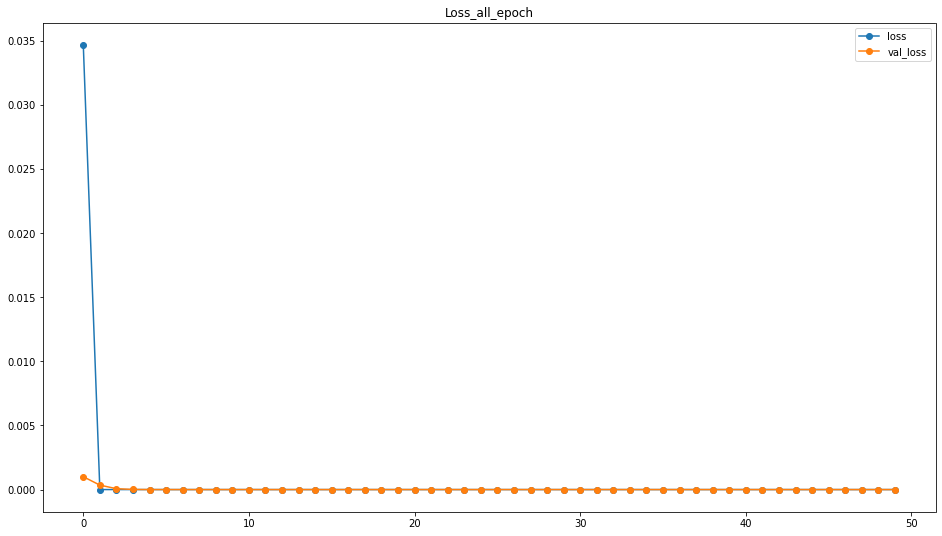

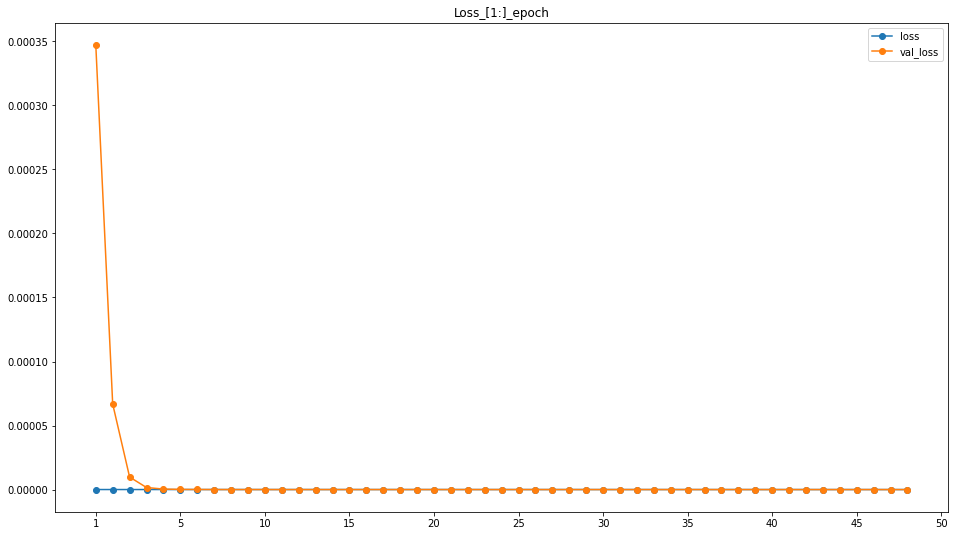

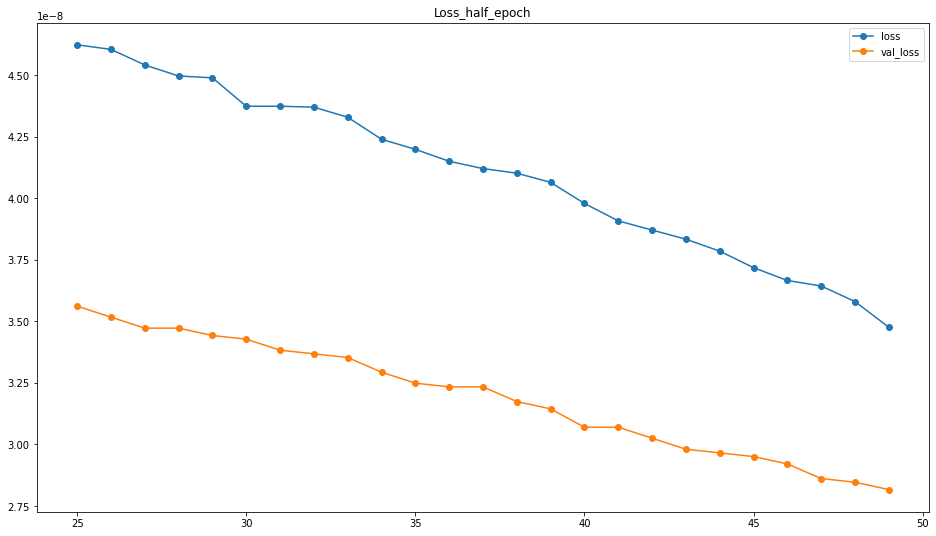

In [105]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [106]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 3s 92us/step


In [107]:
print (scores)

[0.03524358503480922, 0.9861790537834167]


In [108]:
prediction = model.predict(test_data)

In [109]:
print(prediction)

[[1.0000000e+00 4.8123699e-08 3.4980276e-11 7.8231597e-12]
 [1.0000000e+00 2.6561885e-08 3.9133649e-10 4.8843412e-12]
 [1.0000000e+00 1.0020924e-08 4.3302608e-11 2.4953638e-11]
 ...
 [3.0413805e-08 3.2860832e-08 5.0063875e-07 9.9999940e-01]
 [1.1197729e-06 1.1871100e-07 2.2441352e-06 9.9999654e-01]
 [3.5486144e-07 3.5933391e-07 2.8499035e-06 9.9999642e-01]]


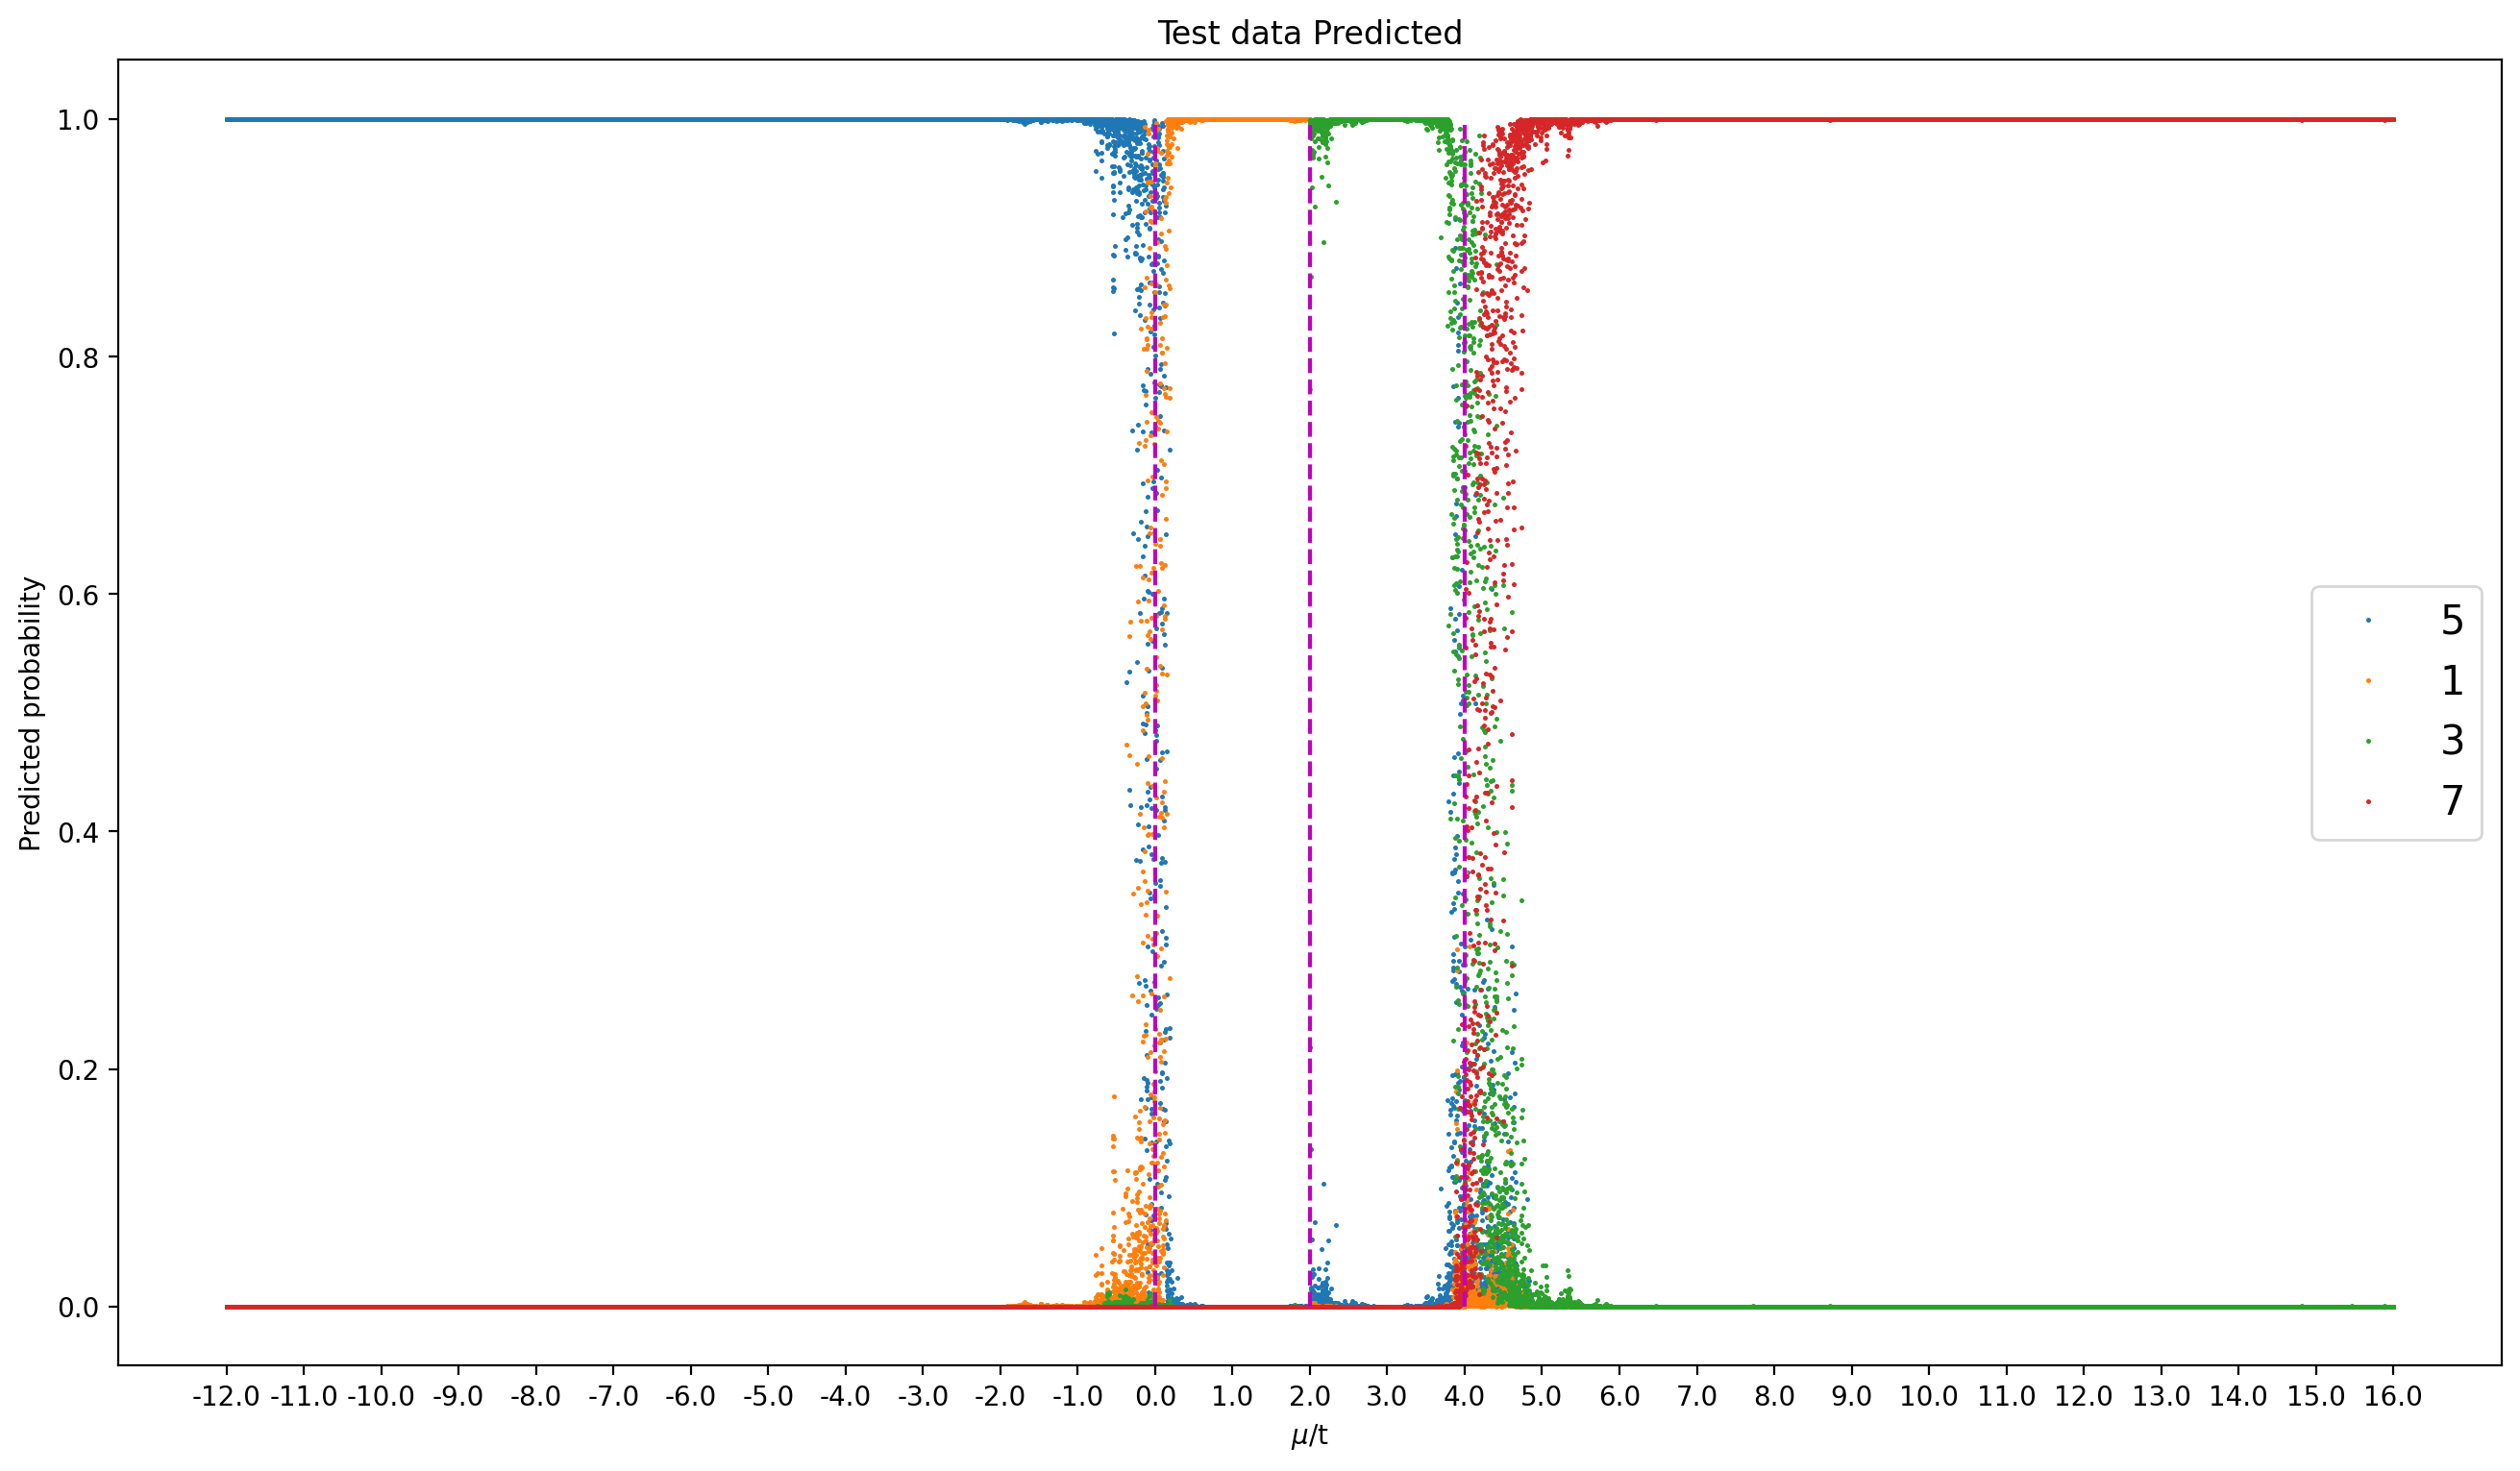

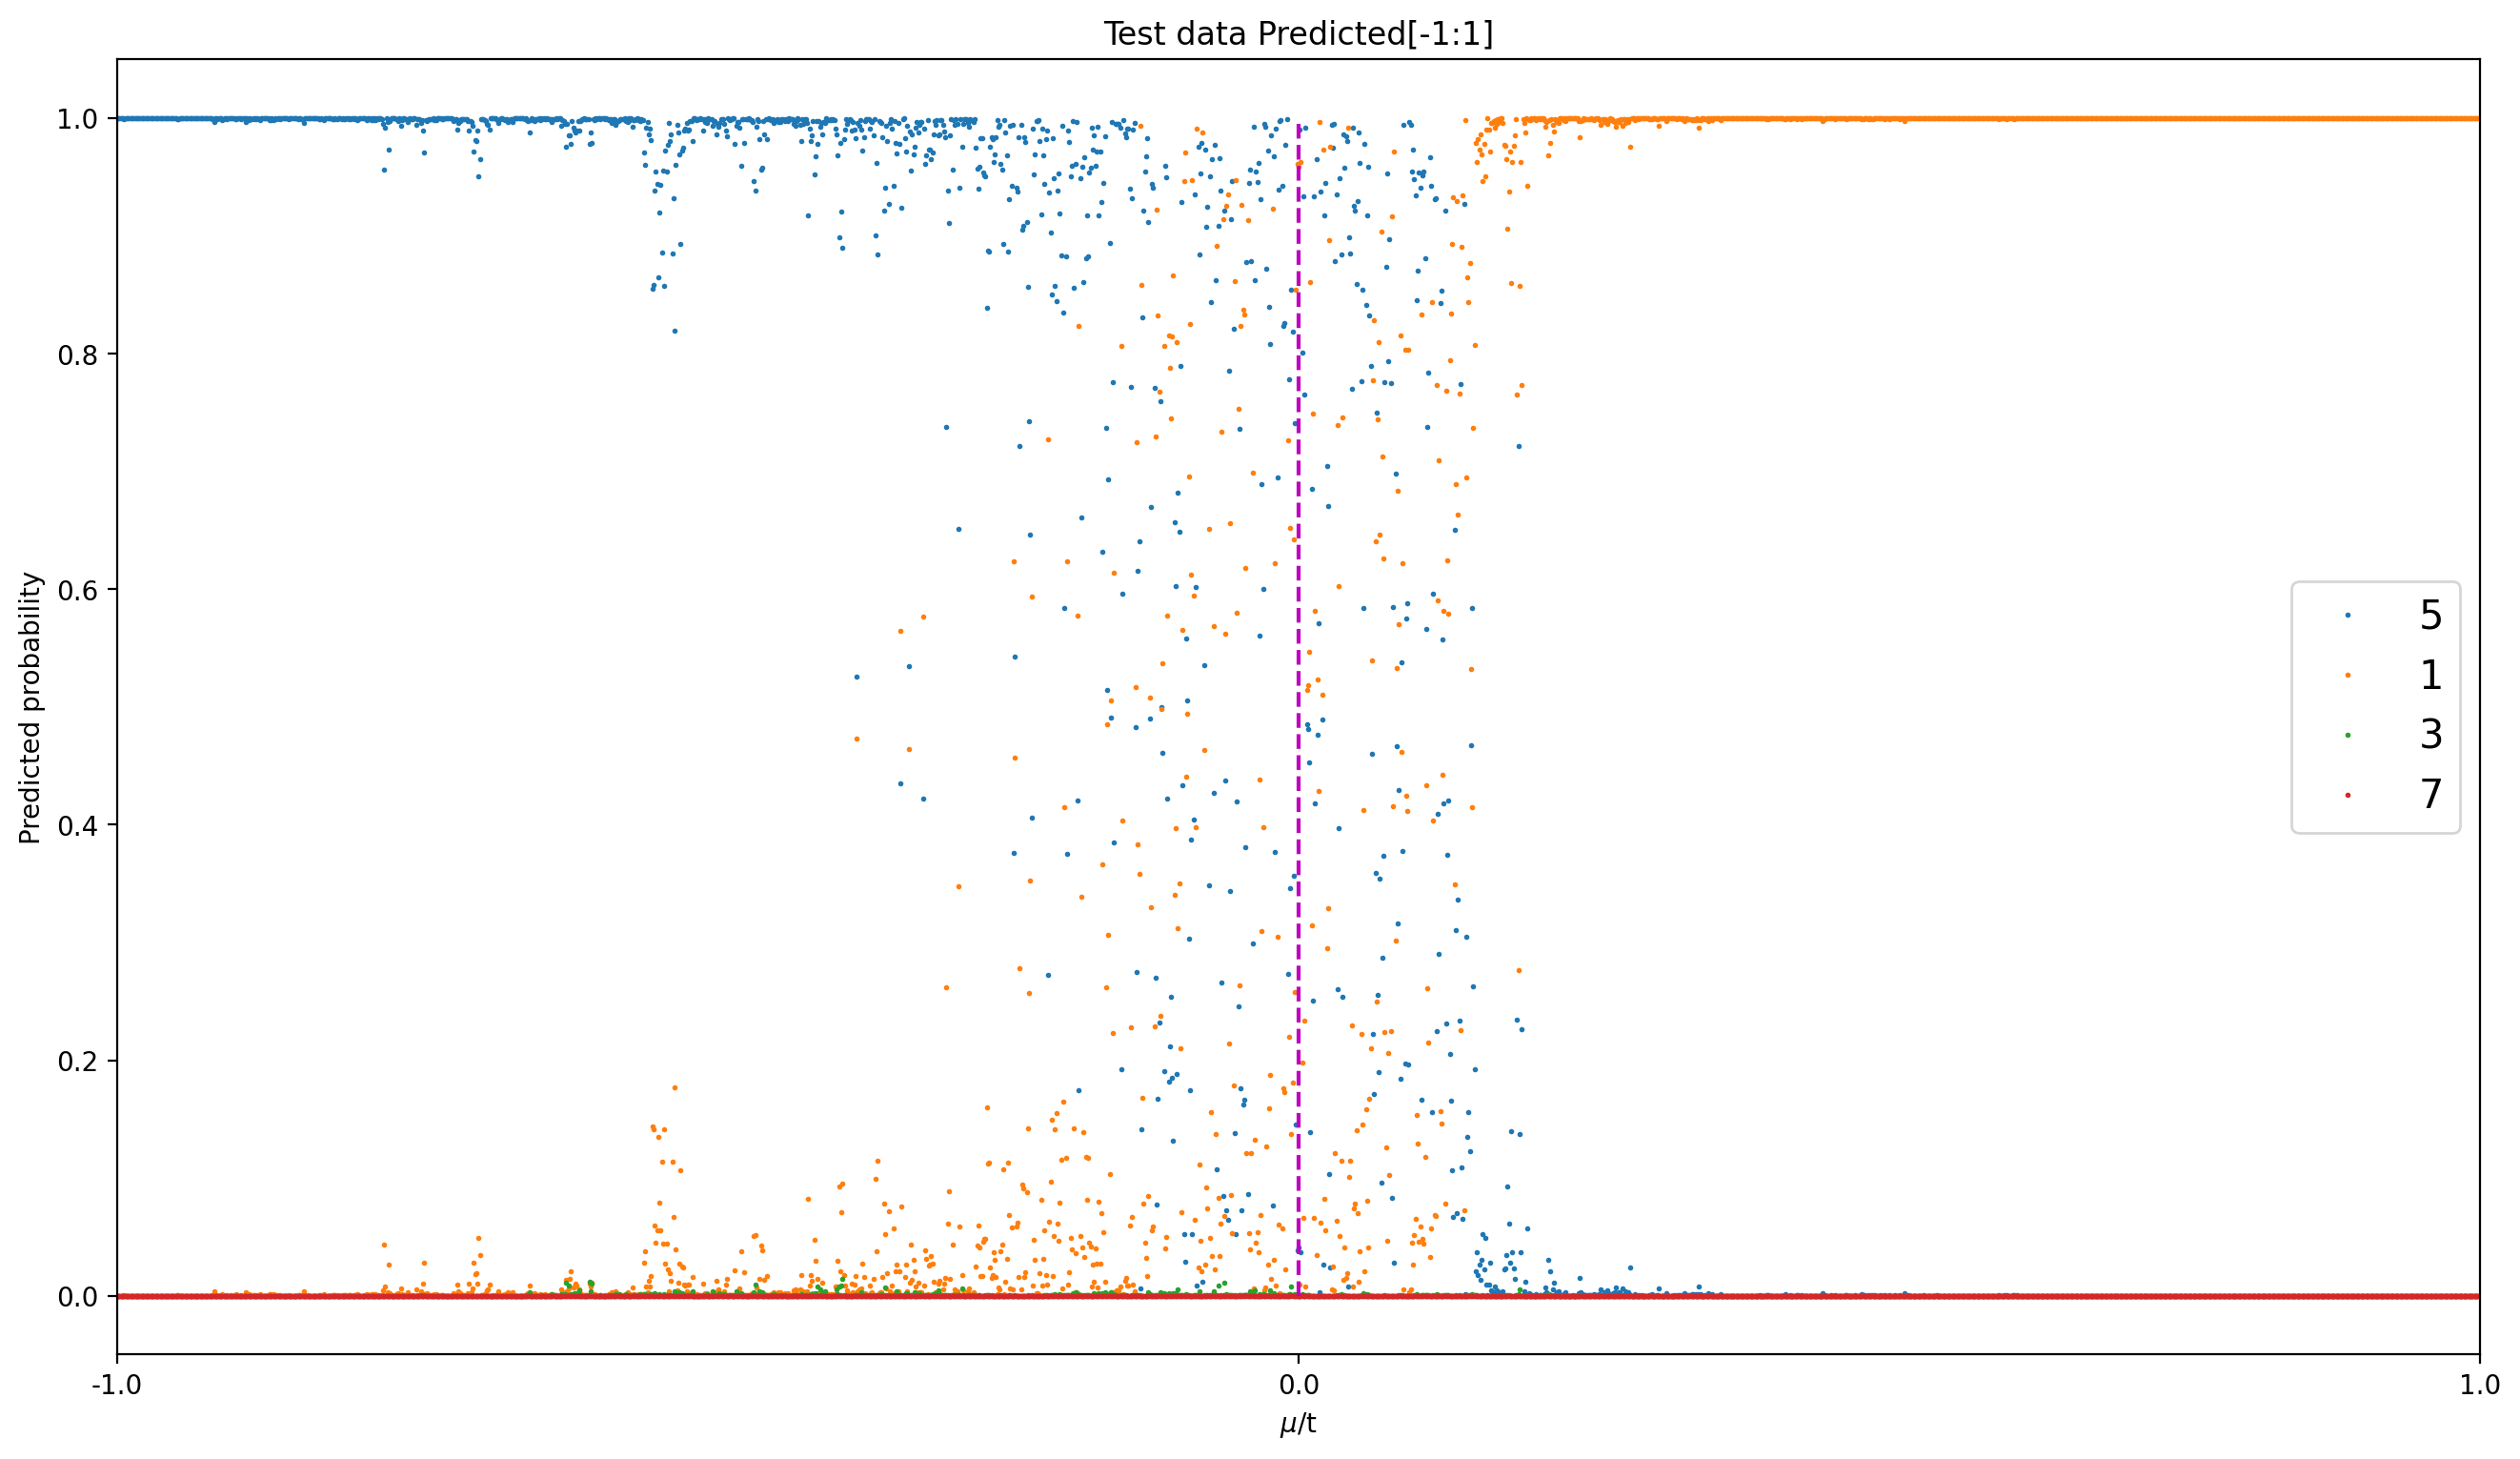

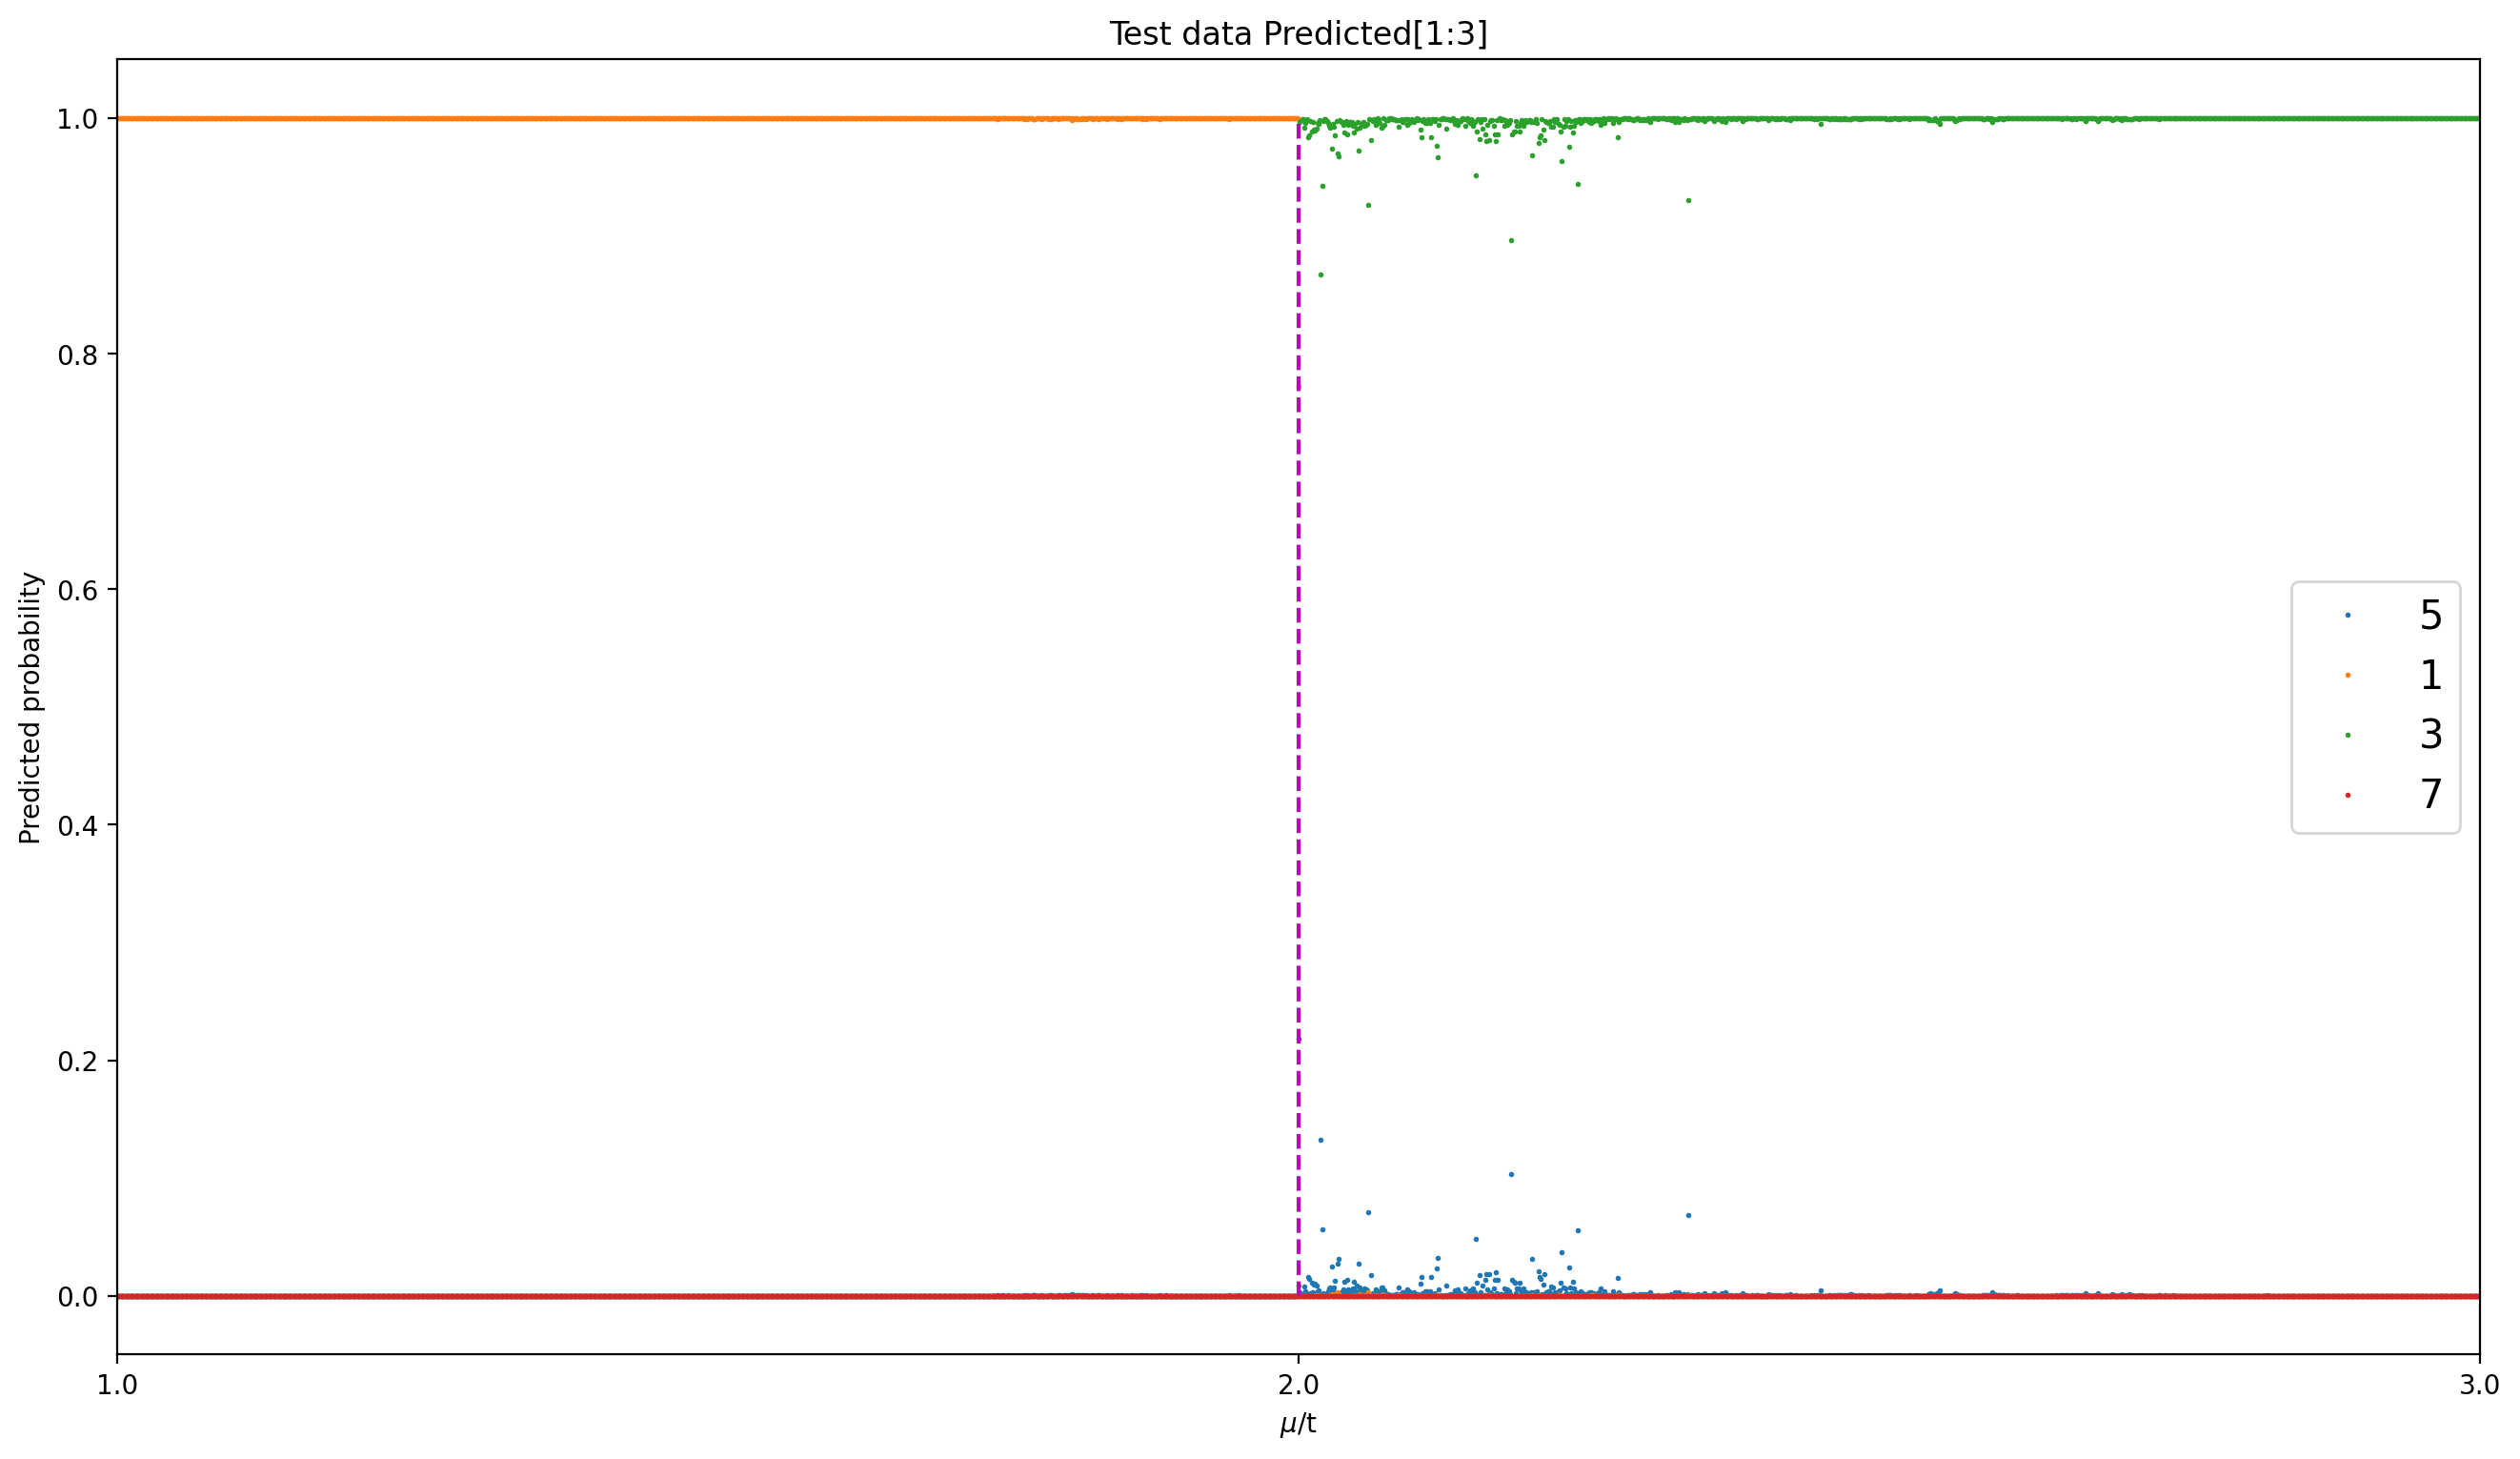

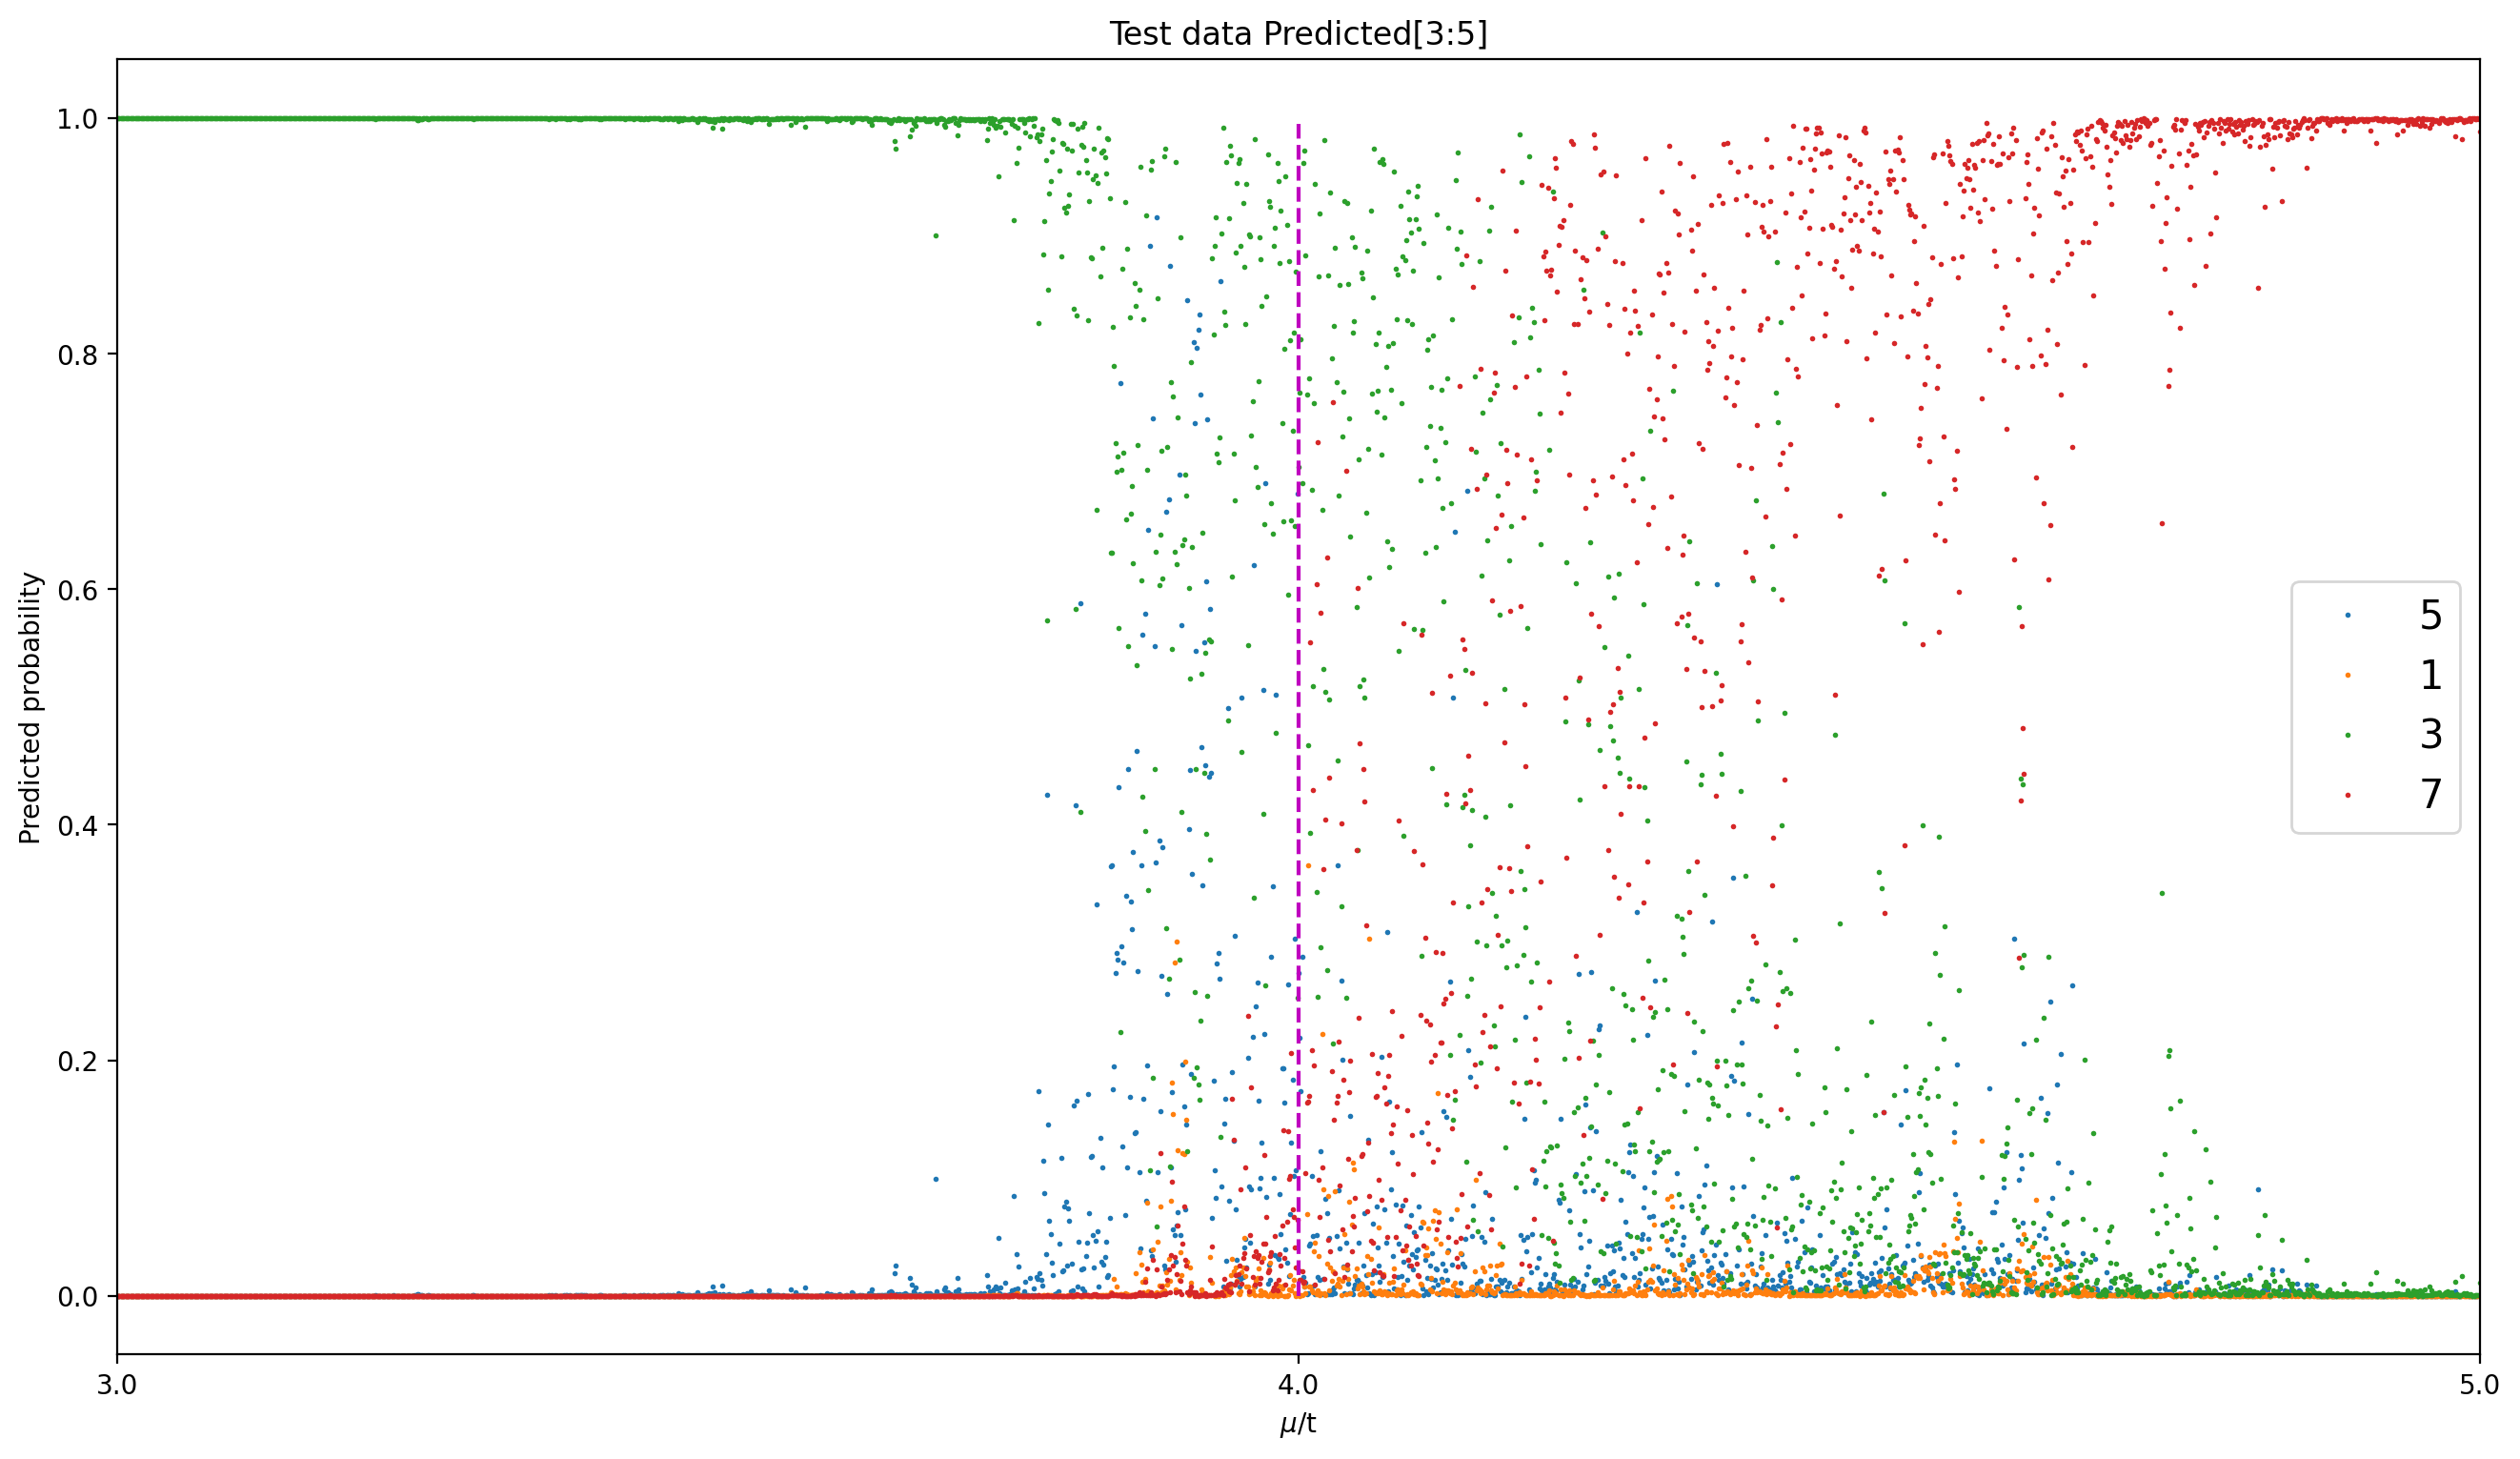

In [110]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# eigenvector_r_theta_4D_resnet

開始獲取eigenvector_r_theta_4D的資料，並將phase轉成label  
並印出形狀確認是否正確

In [111]:
train_data = get_train_data(train_data_path, date, N, delta)[4]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[4]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)

(4000, 50, 5, 5, 3)
(4000,)
(4000, 4)
(28001, 50, 5, 5, 3)
(28001,)
(28001, 4)


將train data, train_one_hot_label 同步打亂

In [112]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [113]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 50, 5, 5, 3)
(4000, 4)
Number of real trian data = 
(3200, 50, 5, 5, 3)
(3200, 4)
Number validation data = 
(800, 50, 5, 5, 3)
(800, 4)


開始架構網路

In [120]:
def resnet(input_shape):
    
    channel = 2*(NN**2)
    
    inputs = Input(shape=input_shape)
    
    x = Convolution3D(batch_input_shape = (None, channel, NN, NN, 3), 
                      filters = channel,
                      kernel_size = (3,3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution3D(filters = channel,
                      kernel_size = (3,3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 2*(NN**2)
model = resnet((channel, NN, NN, 3))

In [121]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 50, 5, 5, 3)  0                                            
__________________________________________________________________________________________________
conv3d_7 (Conv3D)               (None, 50, 5, 5, 3)  67550       input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 50, 5, 5, 3)  12          conv3d_7[0][0]                   
__________________________________________________________________________________________________
activation_10 (Activation)      (None, 50, 5, 5, 3)  0           batch_normalization_7[0][0]      
____________________________________________________________________________________________

In [122]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [123]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 372us/step - loss: 0.0928 - accuracy: 0.9781 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 189us/step - loss: 1.4661e-06 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 191us/step - loss: 1.4475e-06 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 188us/step - loss: 1.4344e-06 - accuracy: 1.0000 - val_loss: 2.1546e-04 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 193us/step - loss: 1.4043e-06 - accuracy: 1.0000 - val_loss: 4.4809e-05 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 190us/step - loss: 1.3827e-06 - accuracy: 1.0000 - val_loss: 1.2590e-05 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [=======================

訓練完成  
開始提取模型資料

In [124]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


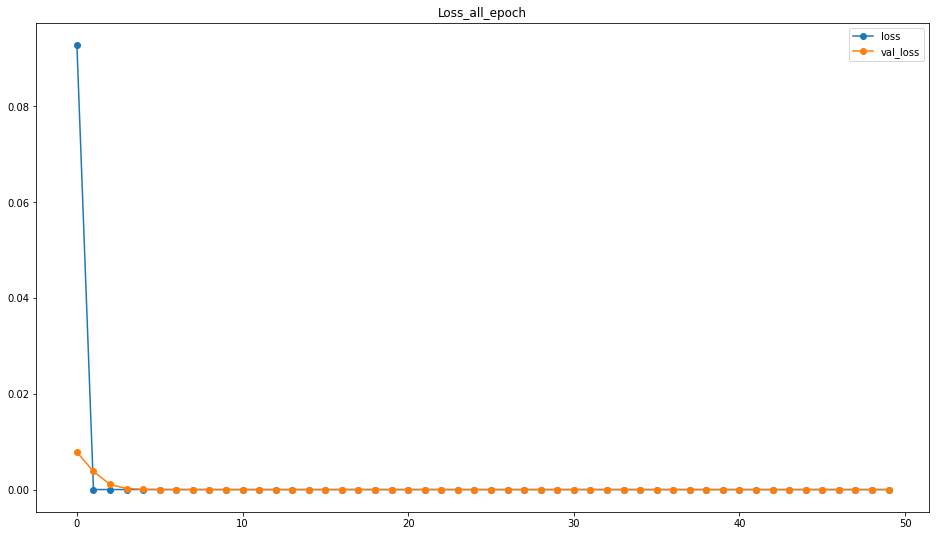

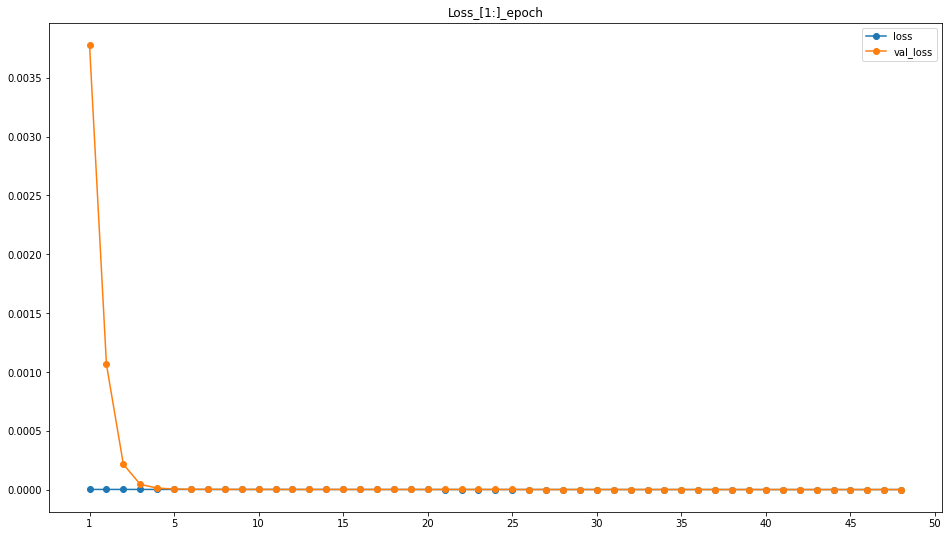

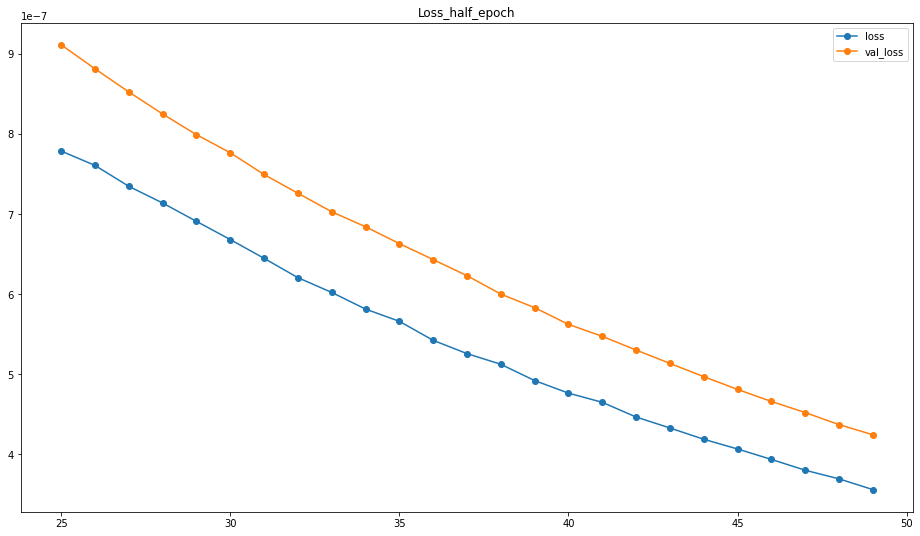

In [125]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [126]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 3s 97us/step


In [127]:
print (scores)

[0.0775084895927017, 0.9767508506774902]


In [128]:
prediction = model.predict(test_data)

In [129]:
print(prediction)

[[9.9999964e-01 2.4216587e-07 6.2953106e-08 7.8876206e-10]
 [9.9999511e-01 4.0212840e-06 6.8668112e-07 1.9822109e-07]
 [9.9999917e-01 2.2267226e-07 3.4023546e-07 3.0972259e-07]
 ...
 [8.8788404e-08 7.5359742e-07 2.6620208e-05 9.9997258e-01]
 [8.1682111e-07 4.9240862e-07 2.5988777e-05 9.9997270e-01]
 [1.3115314e-09 1.4258171e-07 1.5262760e-05 9.9998462e-01]]


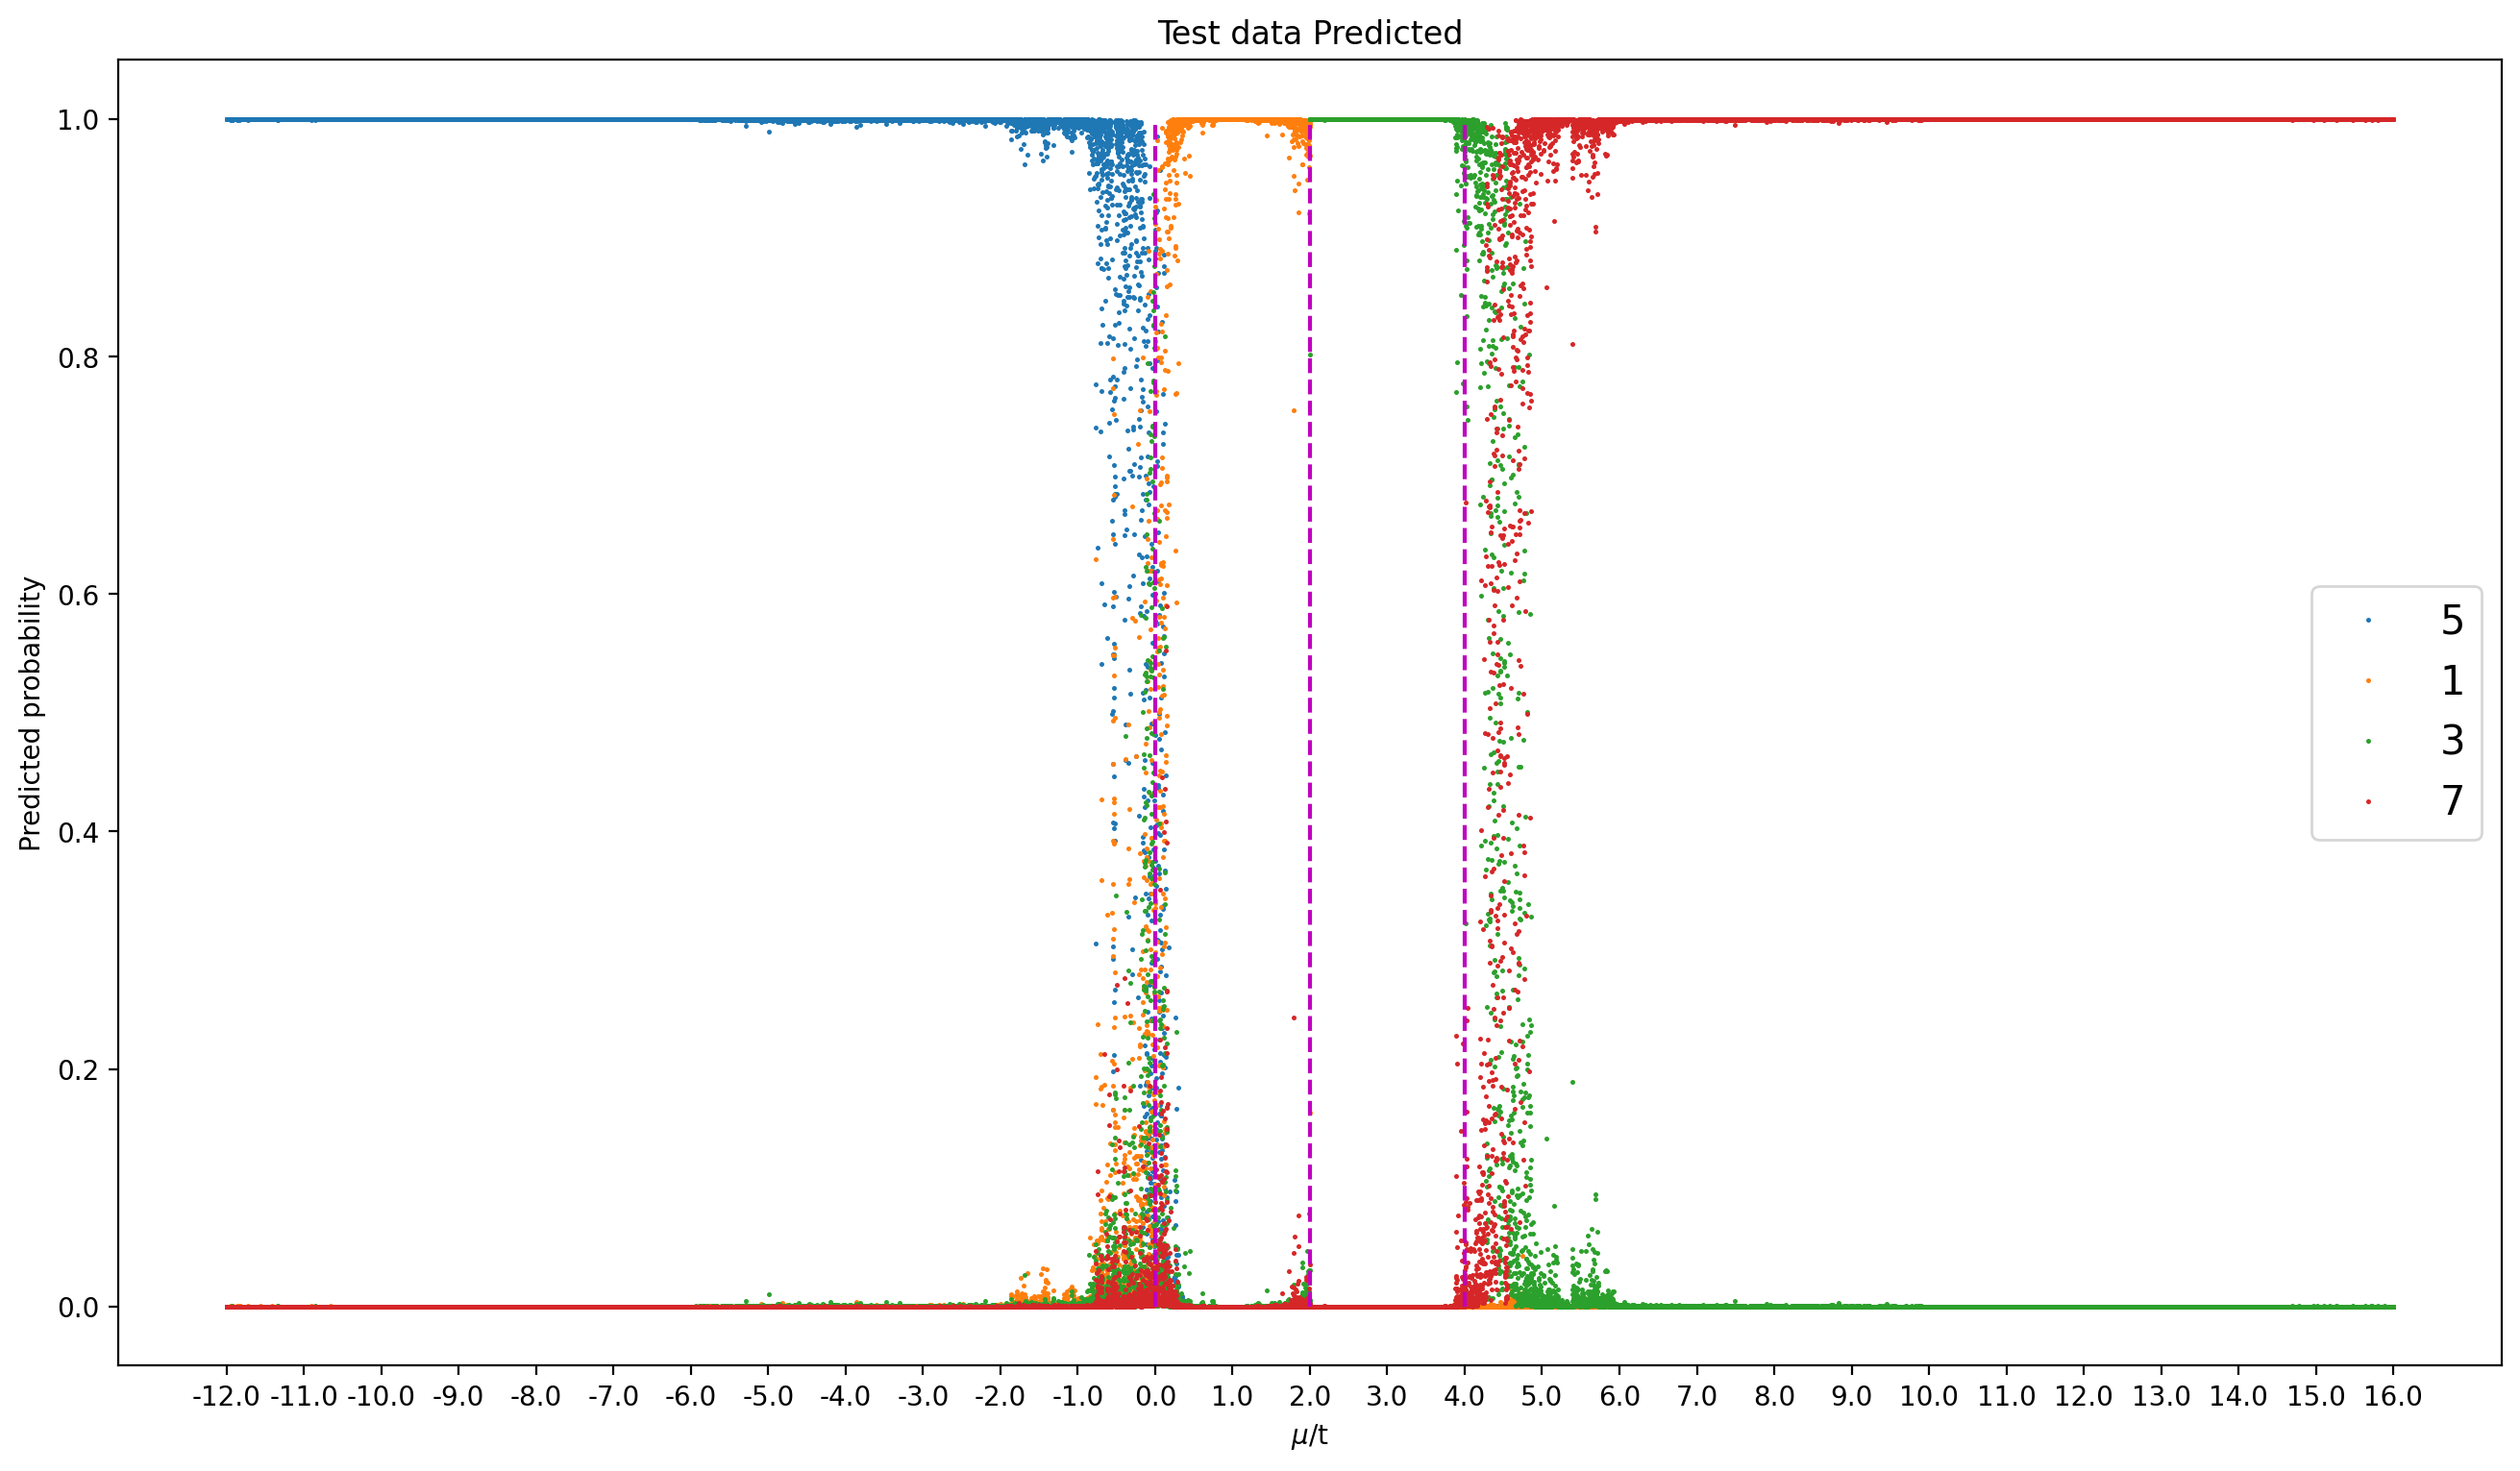

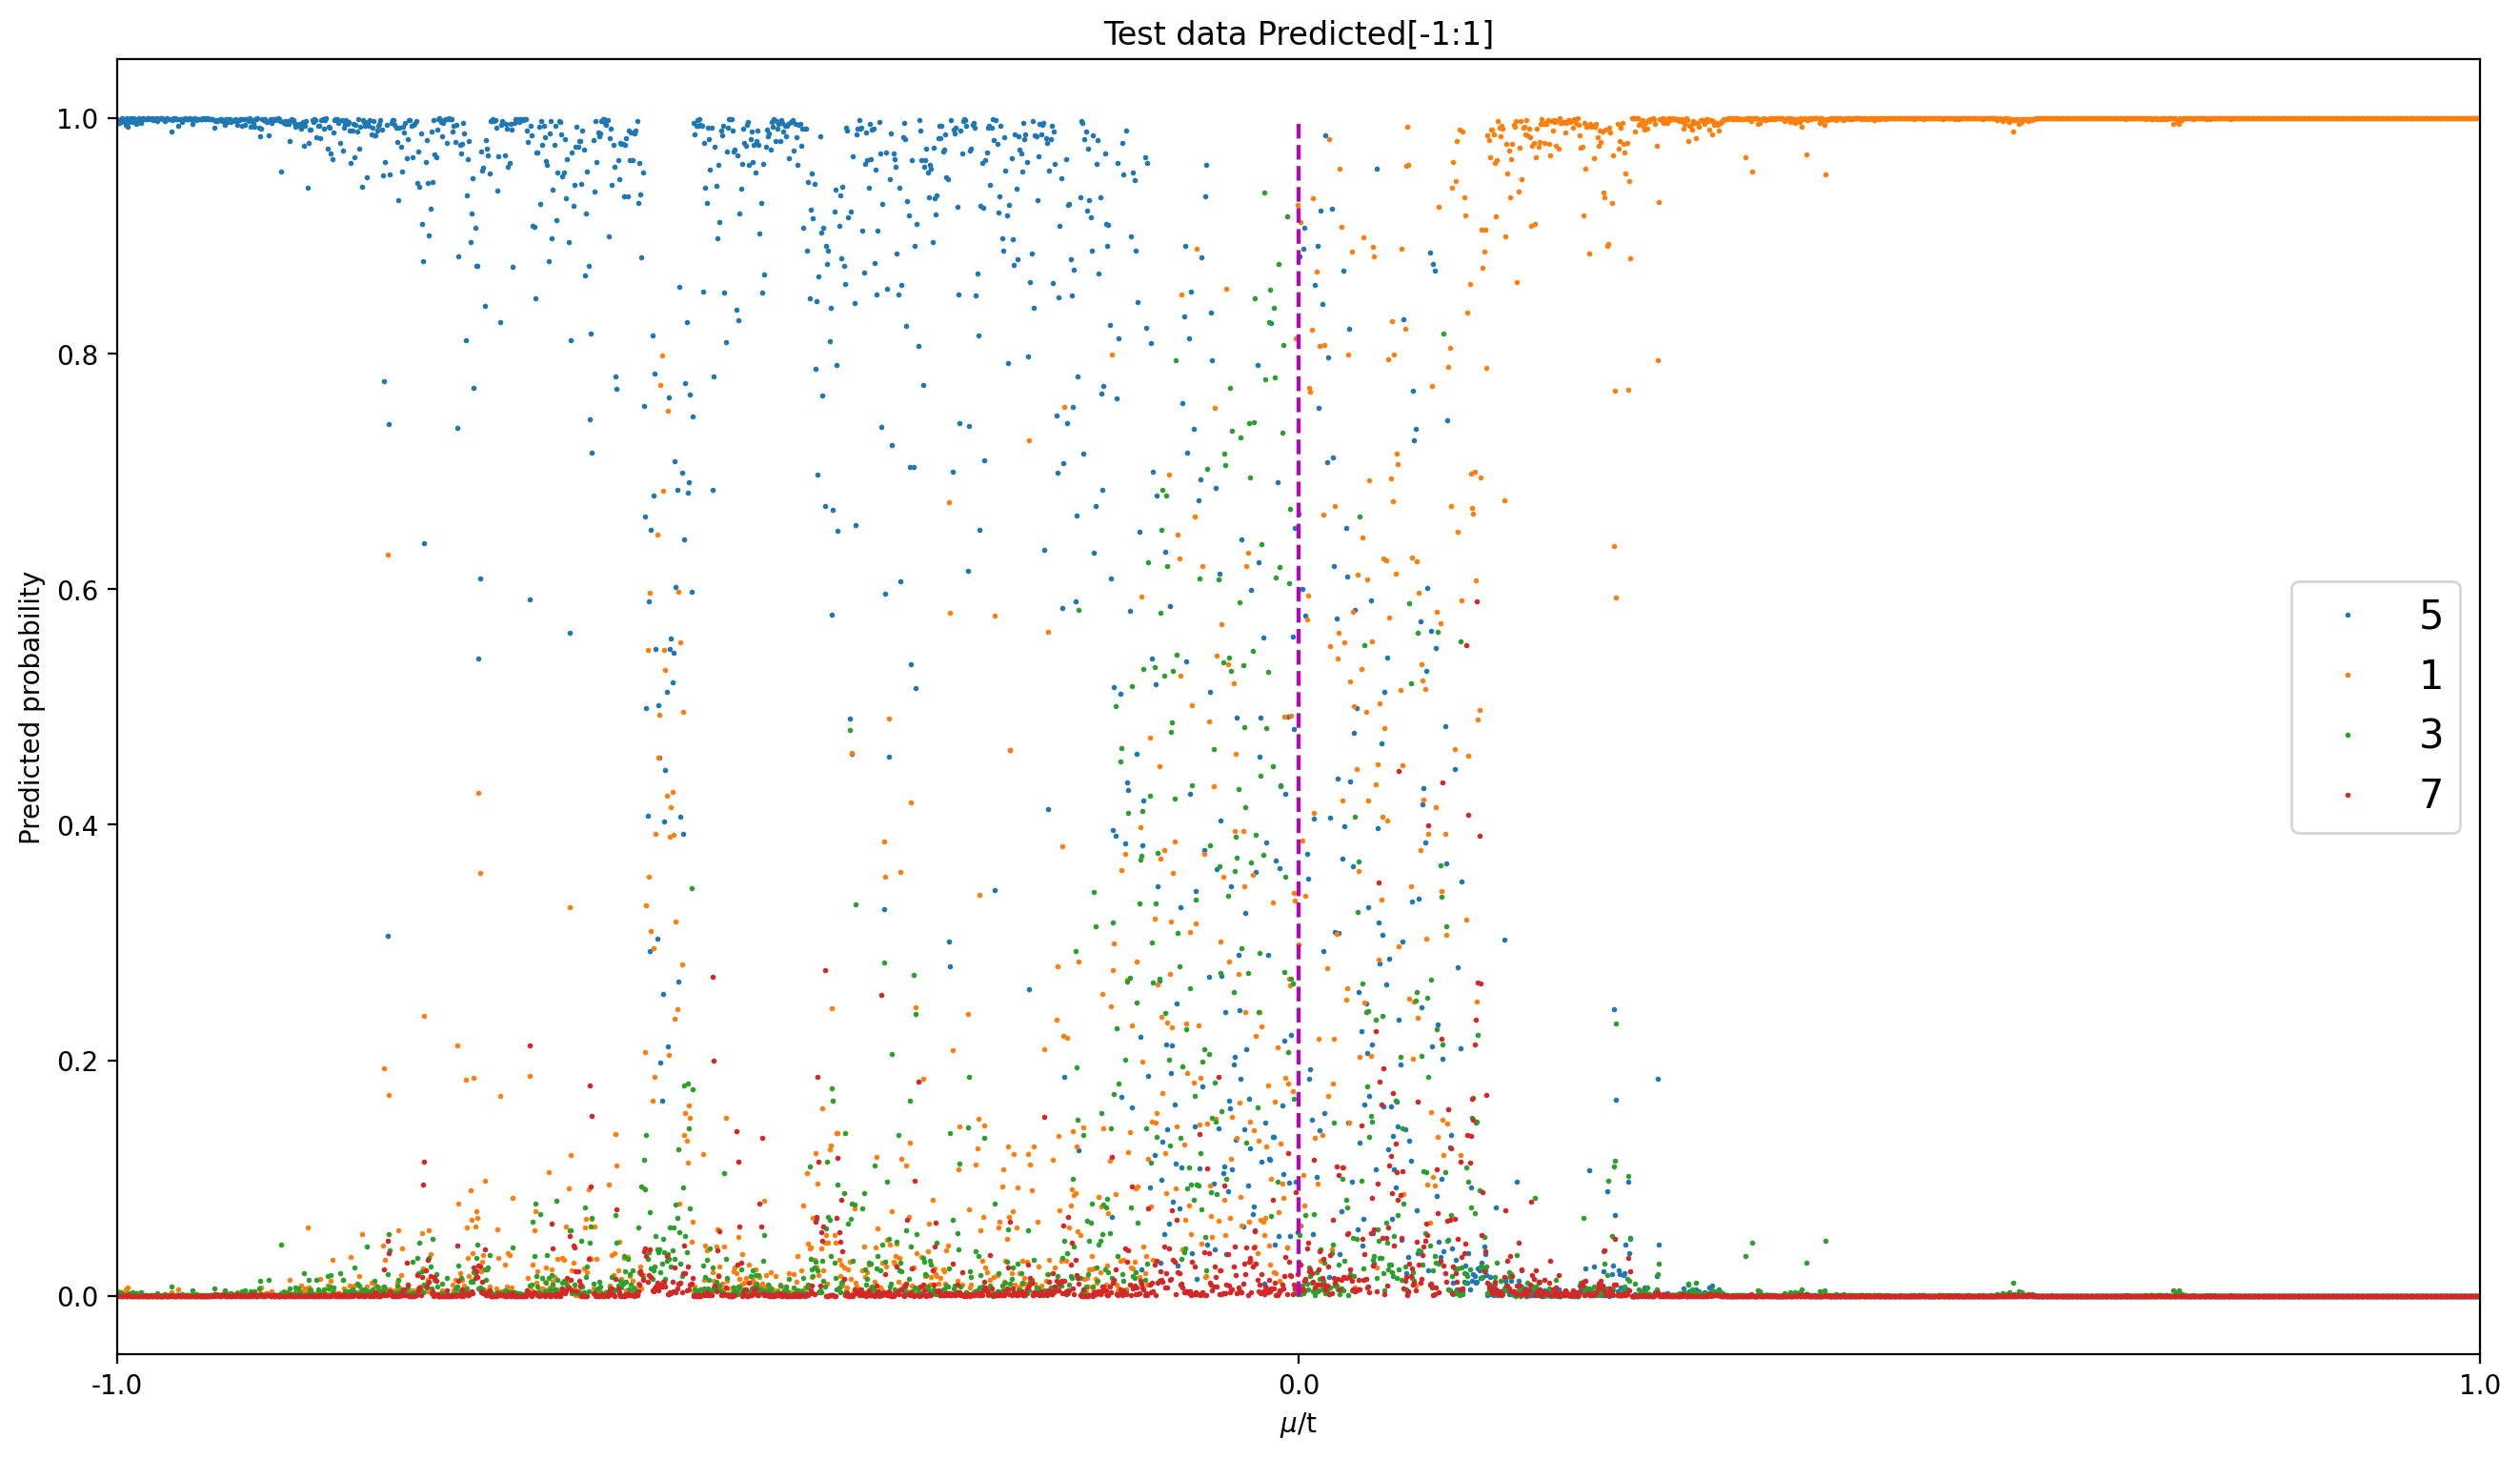

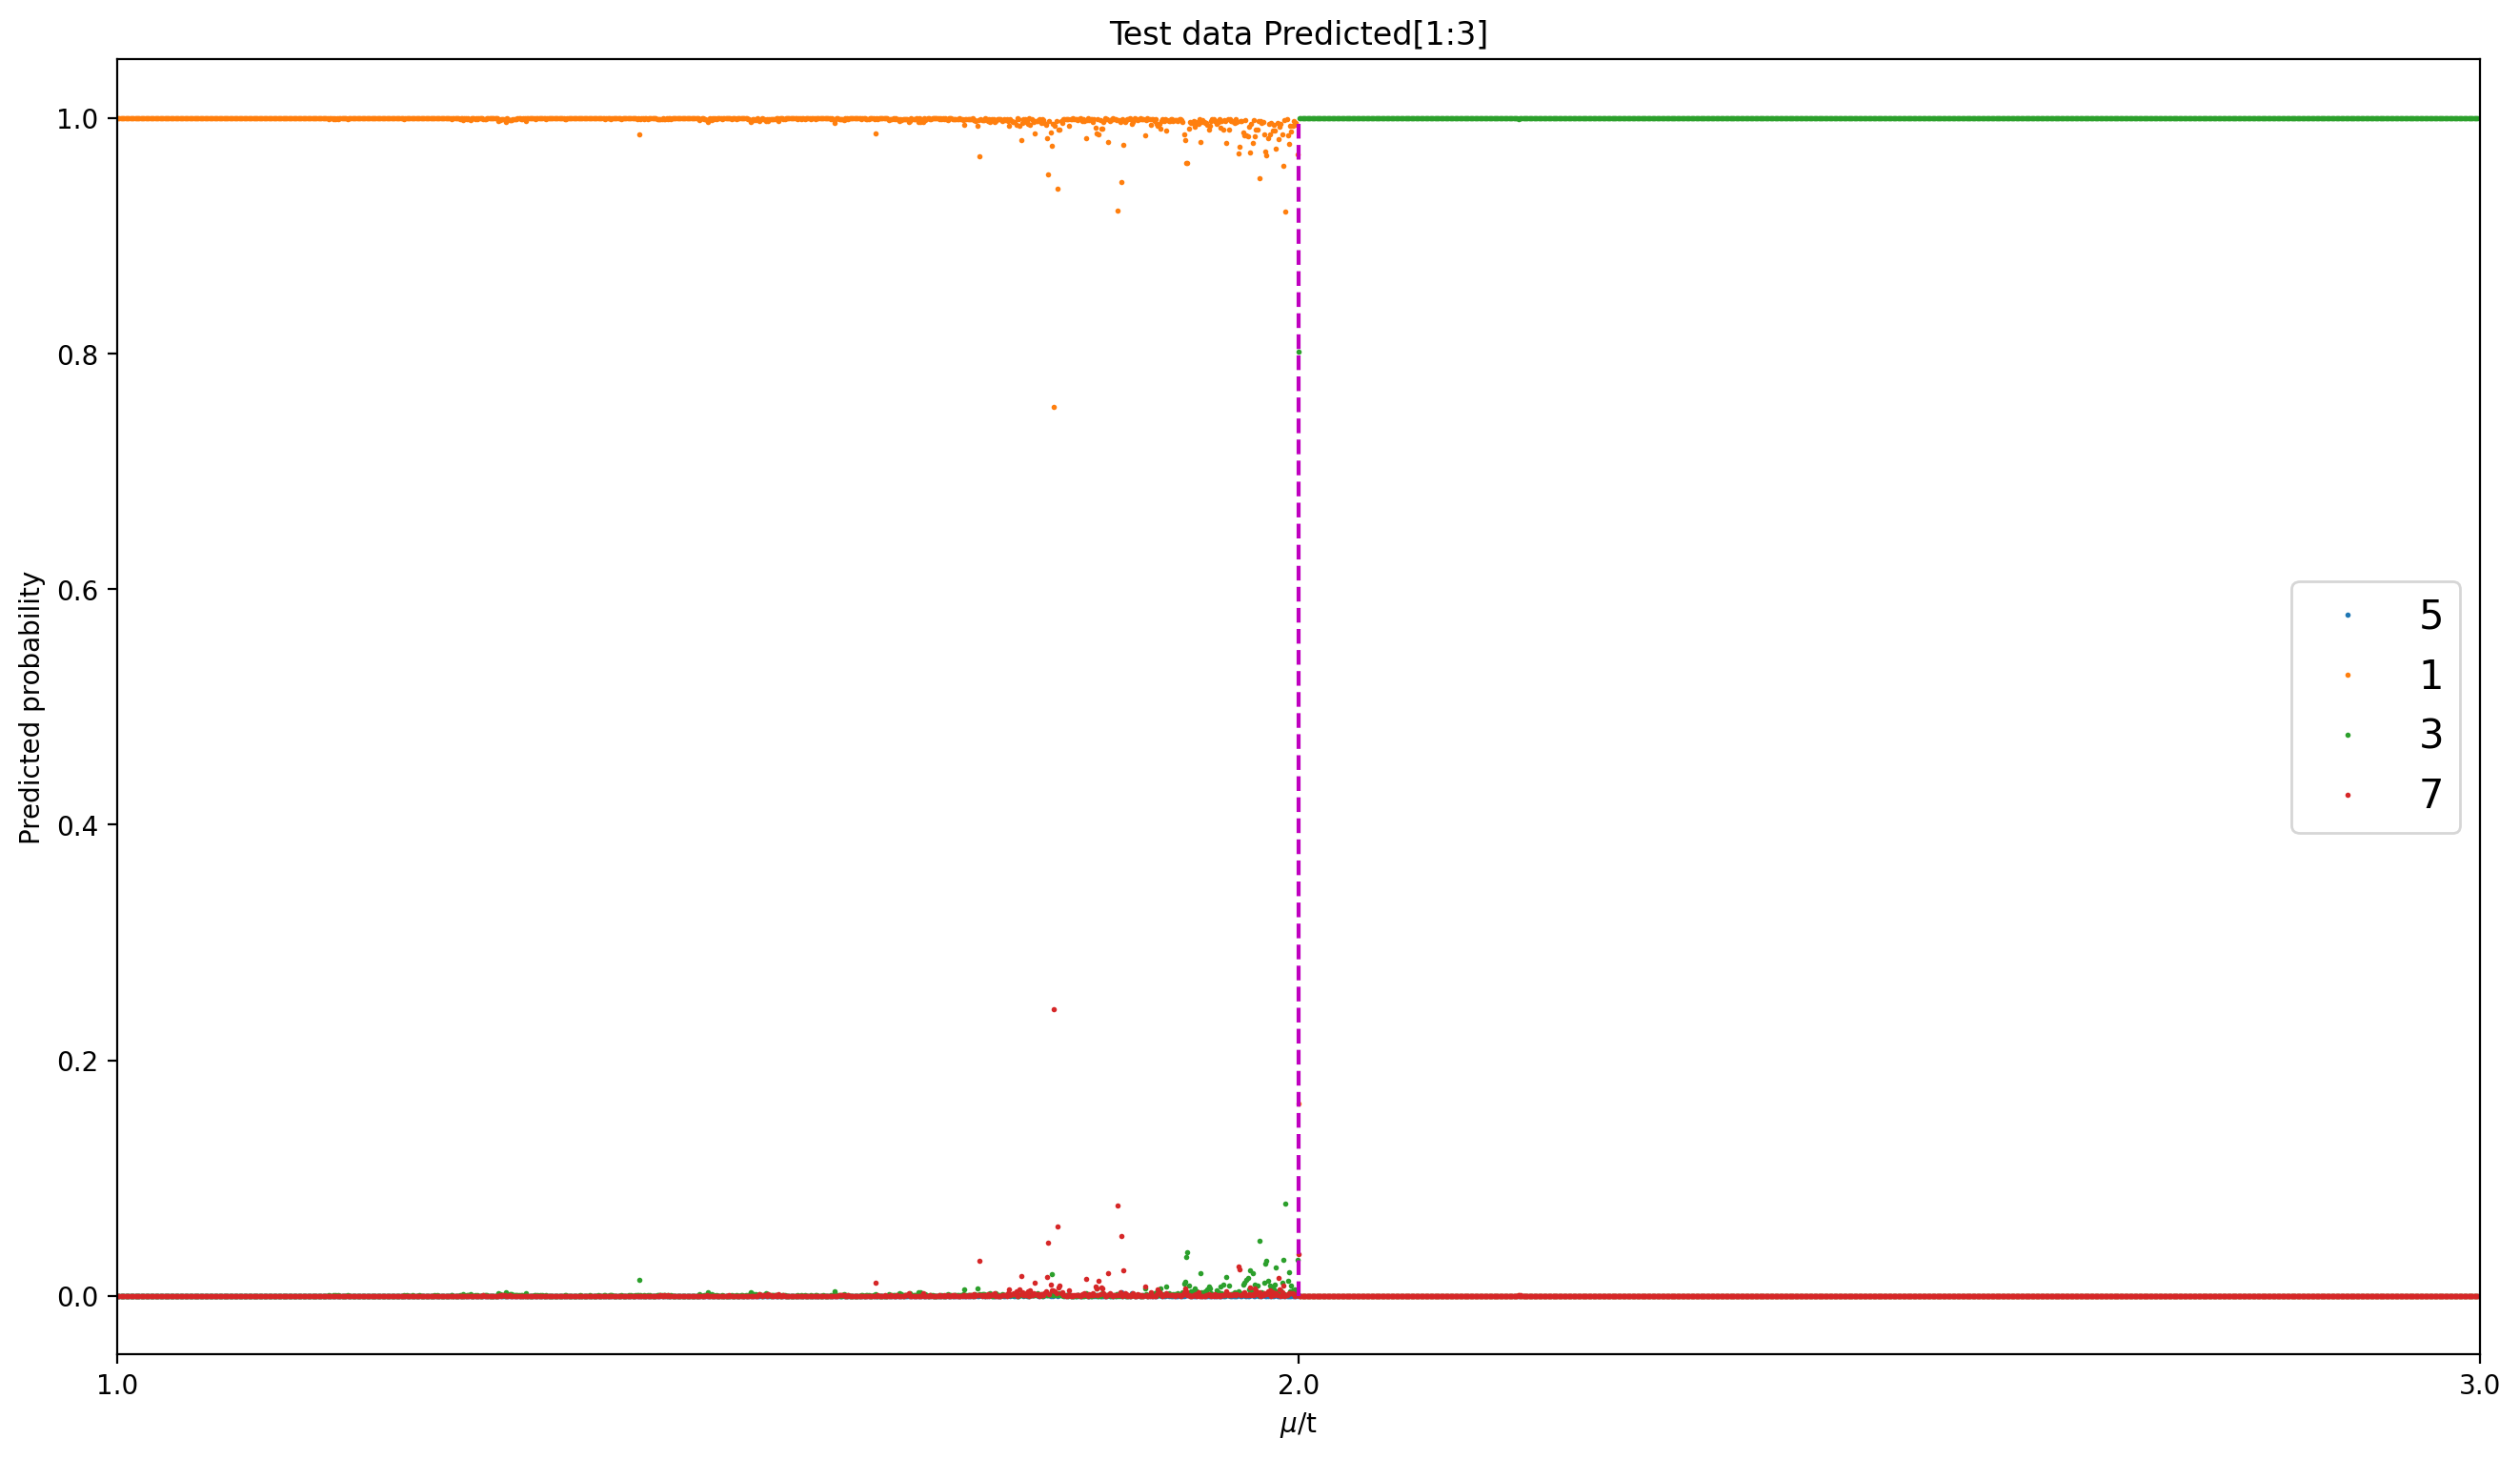

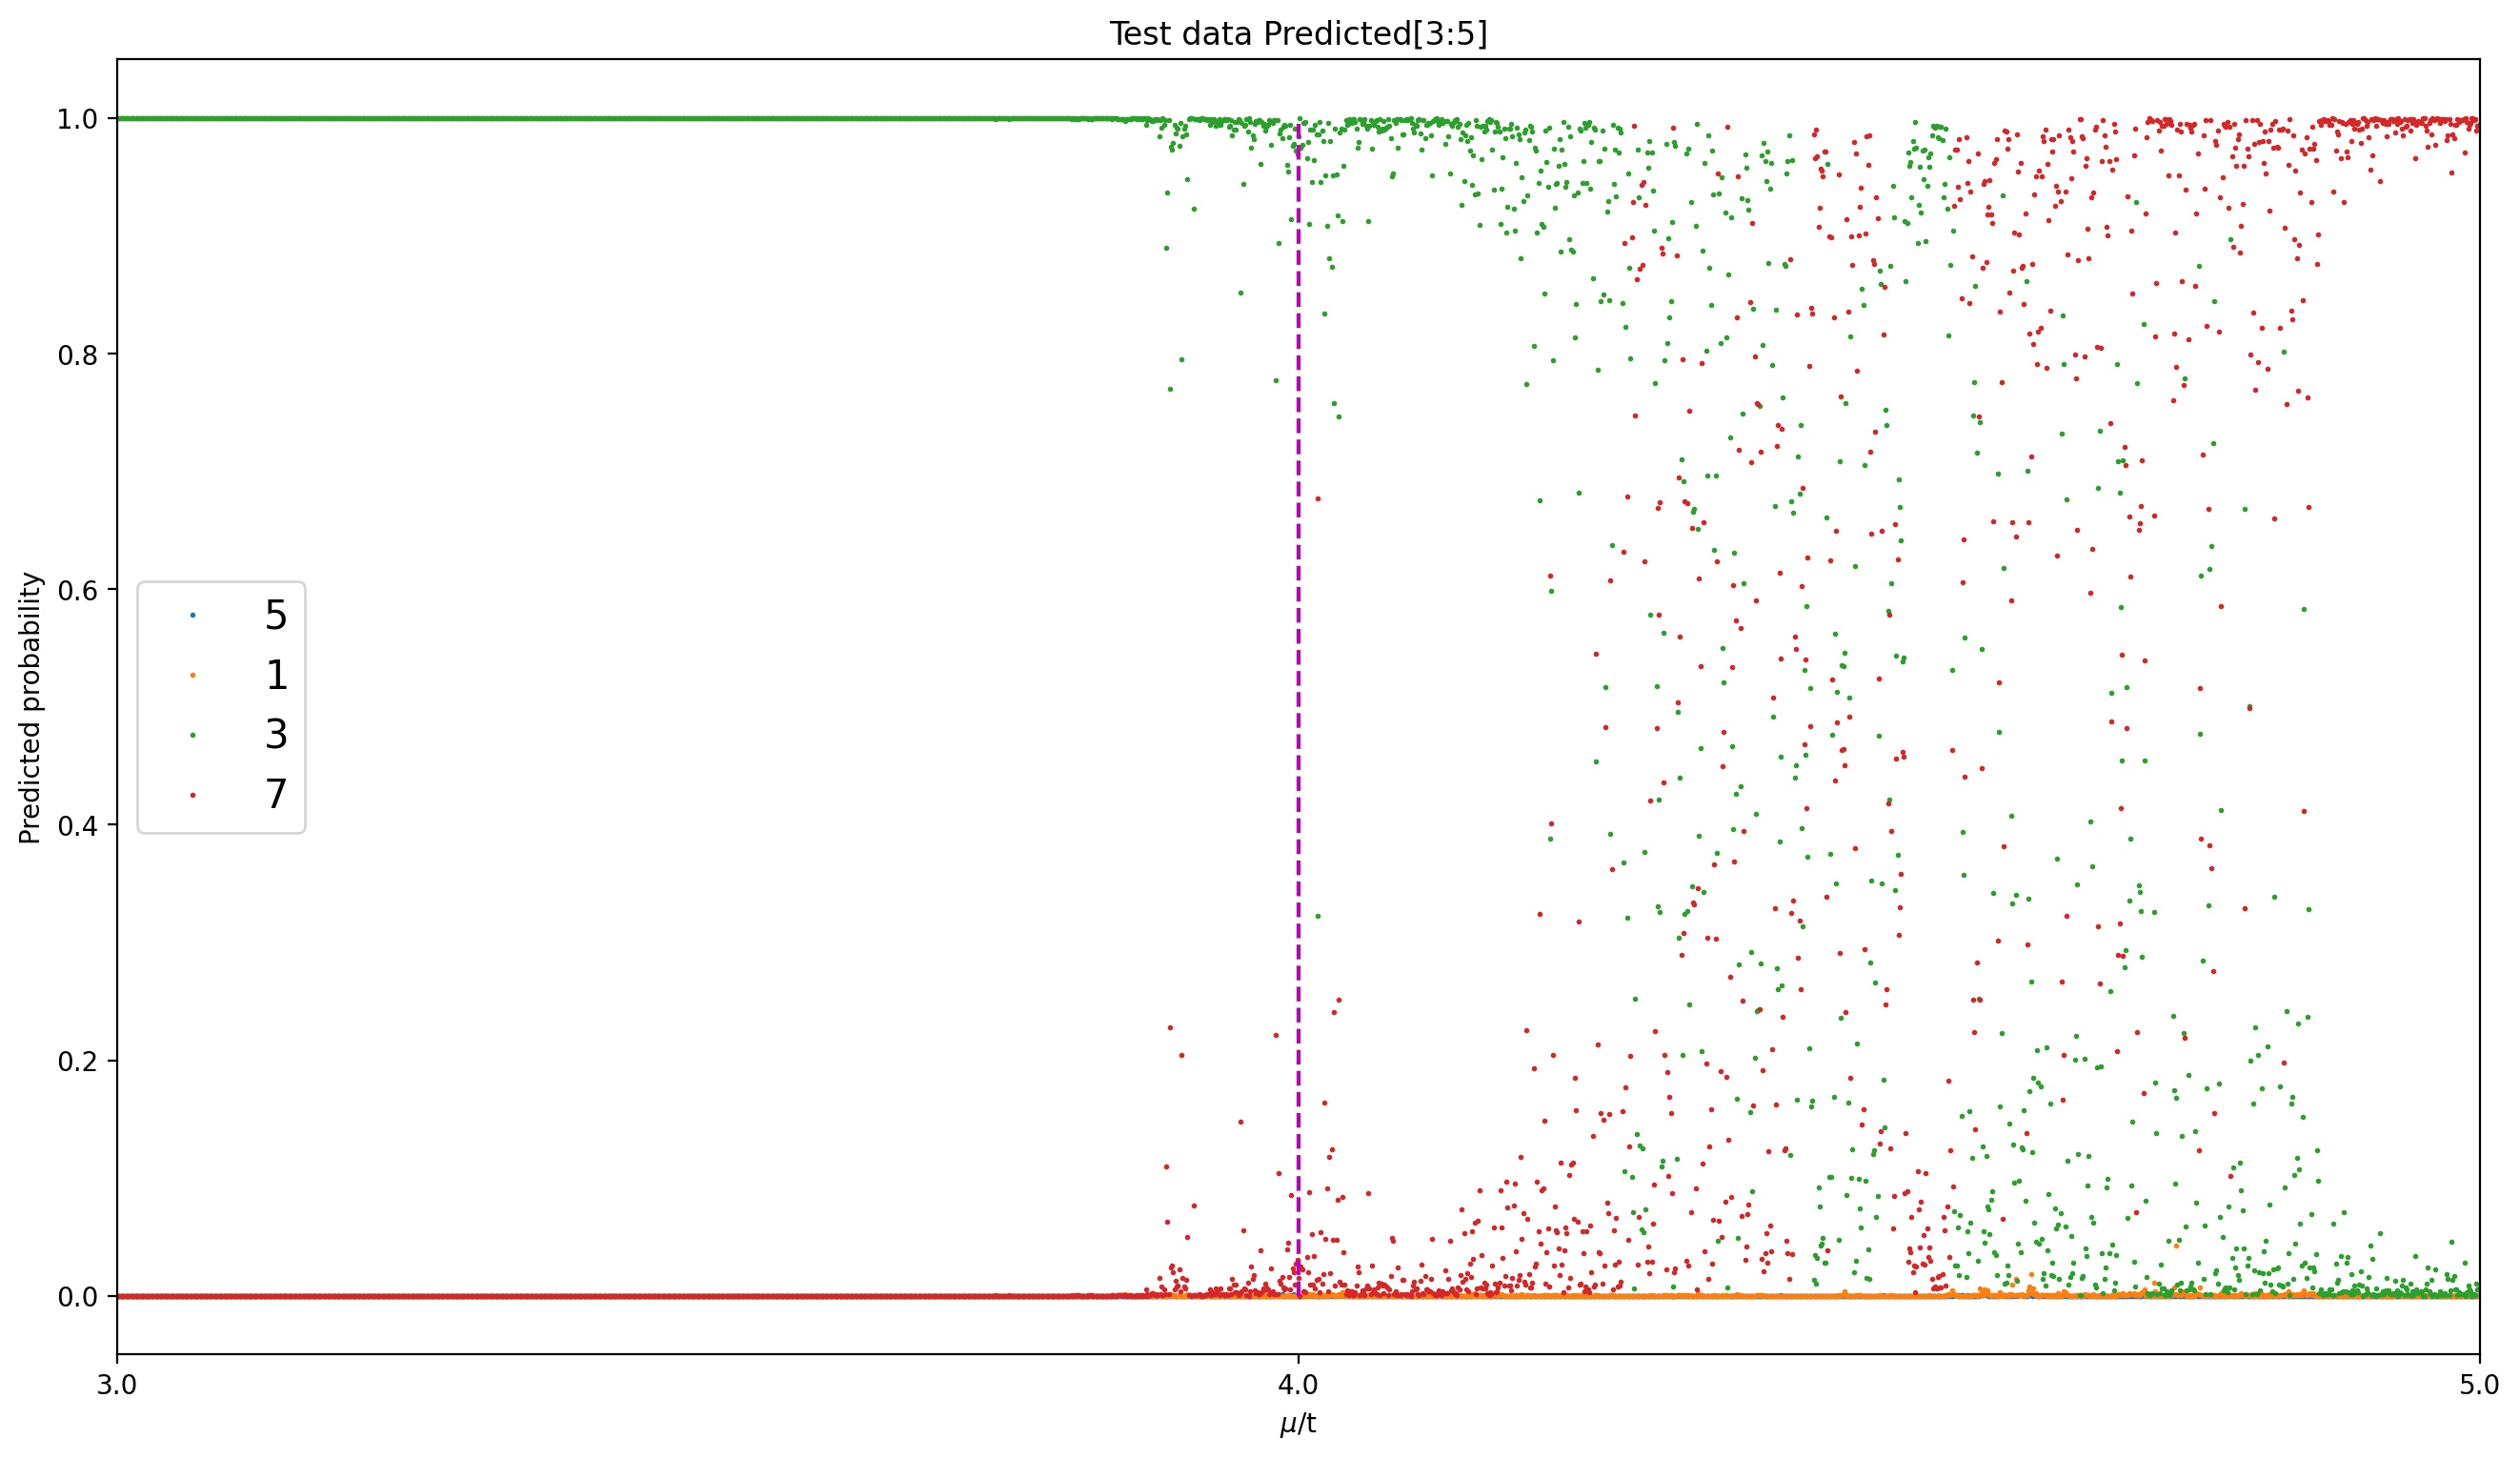

In [130]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()

# Resnet_eigenvector_r_theta_3D 抽中間兩根eigenvector

開始獲取eigenvector_r_theta_3D的資料，並抽出中間兩根eigenvector，並將phase轉成label  
並印出形狀確認是否正確

In [131]:
draw_out_parameters = int(((2*(NN**2)/2)-1)*3)

train_data = get_train_data(train_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
train_label = get_train_data(train_data_path, date, N, delta)[1]
train_one_hot_label = transform_phase_into_onehot(train_label)

test_data = get_test_data(test_data_path, date, N, delta)[6][:,draw_out_parameters:draw_out_parameters+6,:,:]
test_label = get_test_data(test_data_path, date, N, delta)[1]
test_one_hot_label = transform_phase_into_onehot(test_label)

print(train_data.shape)
print(train_label.shape)
print(train_one_hot_label.shape)
print(test_data.shape)
print(test_label.shape)
print(test_one_hot_label.shape)
print('draw_out_parameters = ' + str(draw_out_parameters))

(4000, 6, 5, 5)
(4000,)
(4000, 4)
(28001, 6, 5, 5)
(28001,)
(28001, 4)
draw_out_parameters = 72


將train data, train_one_hot_label 同步打亂

In [132]:
train_data_shuffle,train_one_hot_label_shuffle = shuffle(train_data,train_one_hot_label, random_state=0)

print(train_one_hot_label_shuffle)

[[0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 ...
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 1. 0.]]


In [133]:
print('Number of train data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)

data_number = train_data_shuffle.shape[0]
valid_ratio = 0.2
split_parameter = round(data_number*valid_ratio)

train_data_shuffle_valid = copy(train_data_shuffle[:split_parameter])
train_one_hot_label_shuffle_valid = copy(train_one_hot_label_shuffle[:split_parameter])

train_data_shuffle = train_data_shuffle[split_parameter:]
train_one_hot_label_shuffle = train_one_hot_label_shuffle[split_parameter:]

print('Number of real trian data = ')
print(train_data_shuffle.shape)
print(train_one_hot_label_shuffle.shape)
print('Number validation data = ')
print(train_data_shuffle_valid.shape)
print(train_one_hot_label_shuffle_valid.shape)

Number of train data = 
(4000, 6, 5, 5)
(4000, 4)
Number of real trian data = 
(3200, 6, 5, 5)
(3200, 4)
Number validation data = 
(800, 6, 5, 5)
(800, 4)


開始架構網路

In [137]:
def resnet(input_shape):
    
    channel = 6
    
    inputs = Input(shape=input_shape)
    
    x = Convolution2D(batch_input_shape = (None, channel, NN, NN, 3), 
                      filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(inputs)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = Convolution2D(filters = channel,
                      kernel_size = (3,3),
                      activation = 'relu',
                      padding = 'same',
                      data_format = 'channels_first')(x)
    
    x = BatchNormalization()(x)
    
    x = Activation('relu')(x)
    
    x = keras.layers.add([x,inputs])
    
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Dense(4)(x)
    
    outputs = Activation('softmax')(x)
    
    return Model(inputs=inputs,outputs=outputs)

channel = 6
model = resnet((channel, NN, NN))

In [138]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 6, 5, 5)      0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 6, 5, 5)      330         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_11 (BatchNo (None, 6, 5, 5)      20          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 6, 5, 5)      0           batch_normalization_11[0][0]     
____________________________________________________________________________________________

In [139]:
epochs = 50
adam_op = adam(lr=.0001)
model.compile(loss='categorical_crossentropy', optimizer=adam_op, metrics=['accuracy'])

開始train

In [140]:
train_history = model.fit(train_data_shuffle, train_one_hot_label_shuffle,
                          batch_size=50, epochs = epochs, verbose=1,
                          validation_data = (train_data_shuffle_valid,train_one_hot_label_shuffle_valid)
                         )

Train on 3200 samples, validate on 800 samples
Epoch 1/50
3200/3200 [==============================] - 1s 320us/step - loss: 0.3726 - accuracy: 0.9159 - val_loss: 0.2517 - val_accuracy: 1.0000
Epoch 2/50
3200/3200 [==============================] - 1s 157us/step - loss: 0.0450 - accuracy: 1.0000 - val_loss: 0.1252 - val_accuracy: 1.0000
Epoch 3/50
3200/3200 [==============================] - 1s 164us/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 0.0644 - val_accuracy: 1.0000
Epoch 4/50
3200/3200 [==============================] - 1s 163us/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.0312 - val_accuracy: 1.0000
Epoch 5/50
3200/3200 [==============================] - 1s 160us/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.0151 - val_accuracy: 1.0000
Epoch 6/50
3200/3200 [==============================] - 1s 157us/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 0.0077 - val_accuracy: 1.0000
Epoch 7/50
3200/3200 [==============================] - 1s 162us/step - loss:

訓練完成  
開始提取模型資料

In [141]:
print(train_history.history.keys())

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


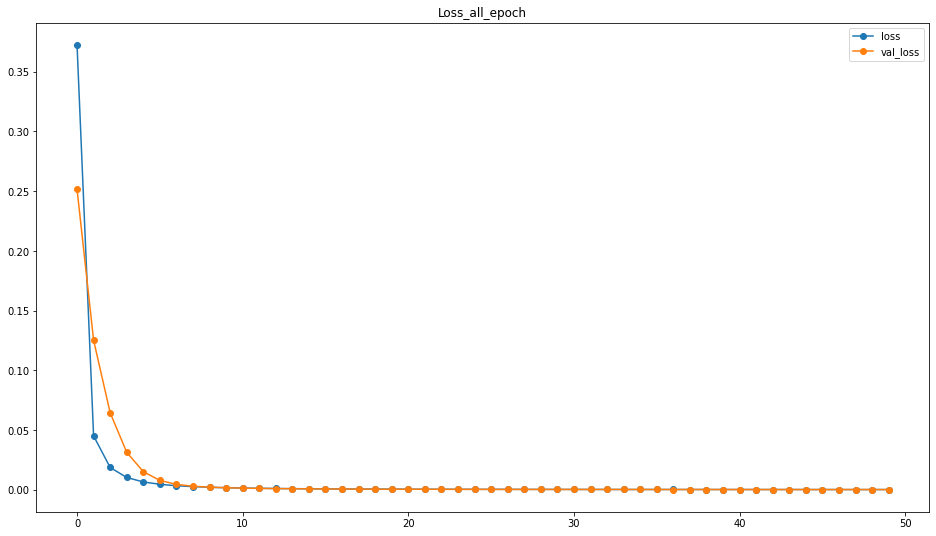

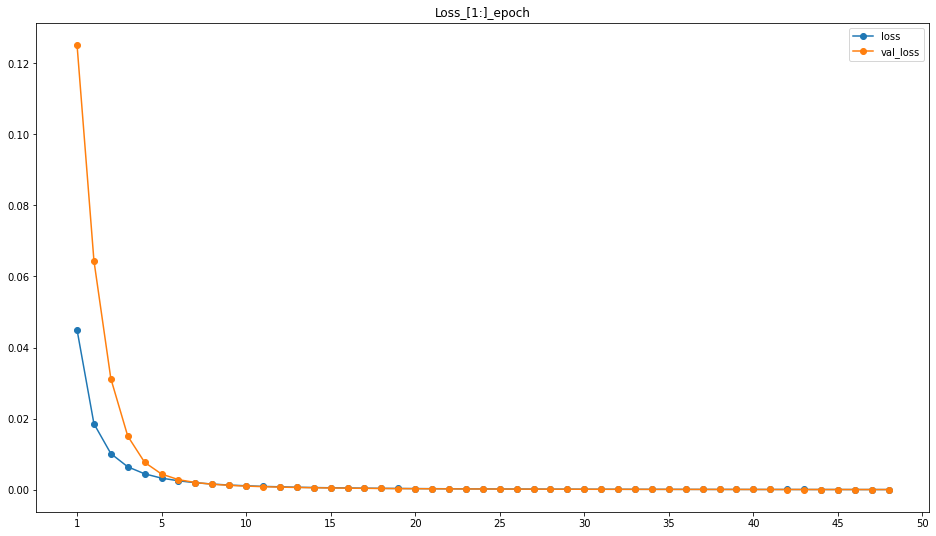

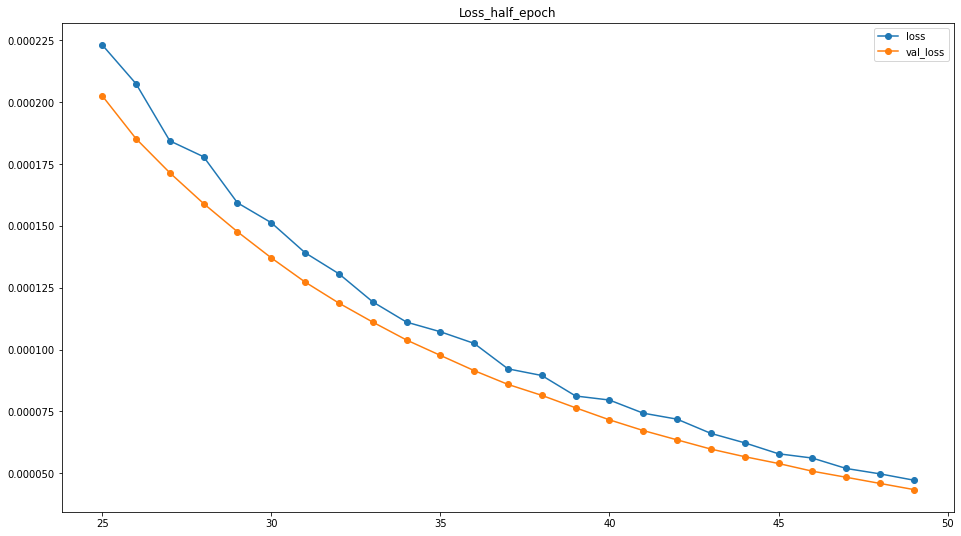

In [142]:
figure_x, figure_y = 16, 9

figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'],'o-',label='loss')
plot(train_history.history['val_loss'],'o-',label='val_loss')
legend()
title('Loss_all_epoch')
show()

xticks_list = array([1])
xticks_list = append(xticks_list, arange(0, epochs+1, step = 5)[1:])
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][1:],'o-',label='loss')
plot(train_history.history['val_loss'][1:],'o-',label='val_loss')
xticks(arange(0, epochs+1, step = 5), xticks_list)
legend()
title('Loss_[1:]_epoch')
show()

half_epoch = round(len(train_history.history['loss'])*0.5)
figure(figsize=(figure_x, figure_y))
plot(train_history.history['loss'][half_epoch:],'o-',label='loss')
plot(train_history.history['val_loss'][half_epoch:],'o-',label='val_loss')
xticks(arange(0, half_epoch+1, step = 5),
       arange(half_epoch, half_epoch*2+1, step = 5)) 
legend()
title('Loss_half_epoch')
show()

開始預測test data  
並畫圖

In [143]:
scores = model.evaluate(test_data, test_one_hot_label, verbose=1)

28001/28001 [==============================] - 2s 82us/step


In [144]:
print (scores)

[0.4956434029473223, 0.9453591108322144]


In [145]:
prediction = model.predict(test_data)

In [146]:
print(prediction)

[[9.9997818e-01 8.8372059e-07 1.9905360e-06 1.9024184e-05]
 [9.9998653e-01 4.4123547e-07 2.3682987e-06 1.0639374e-05]
 [9.9999321e-01 2.9129819e-06 2.8454676e-06 1.0610401e-06]
 ...
 [5.8074861e-06 1.8658656e-06 1.6004984e-06 9.9999082e-01]
 [2.3033583e-06 1.3745046e-05 6.1334094e-06 9.9997783e-01]
 [1.7438680e-06 1.4019784e-07 6.6171515e-07 9.9999738e-01]]


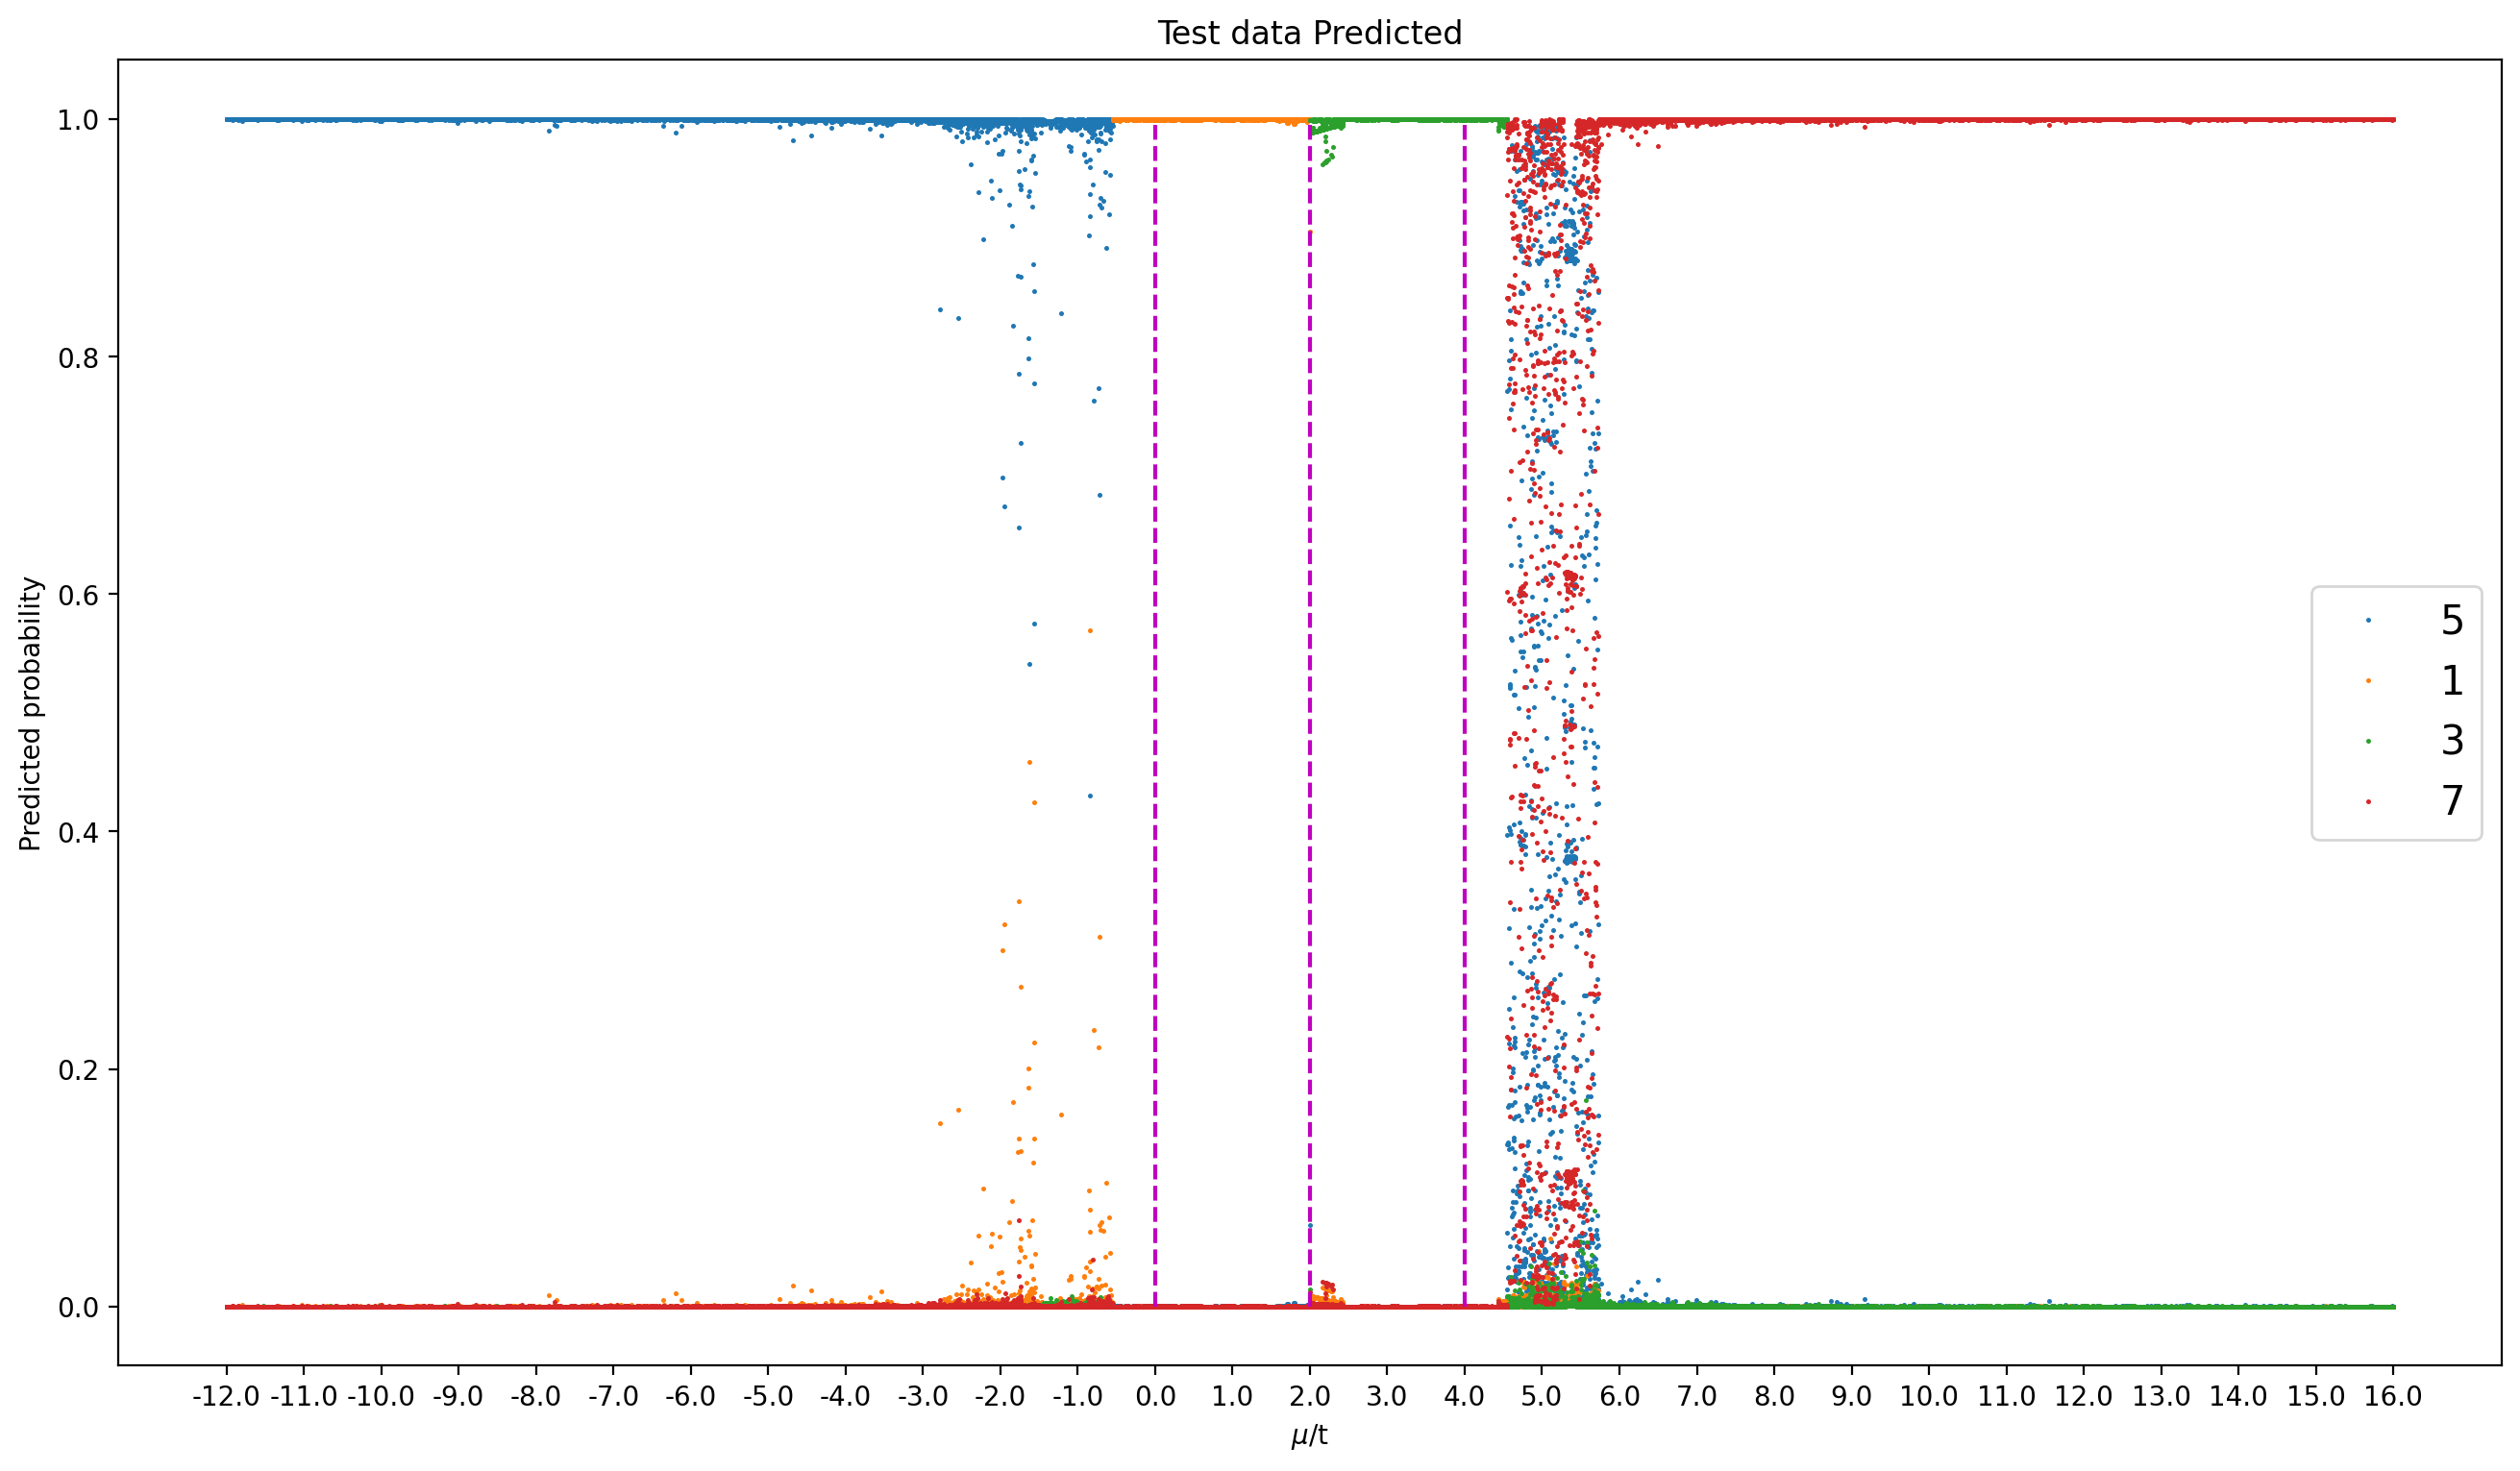

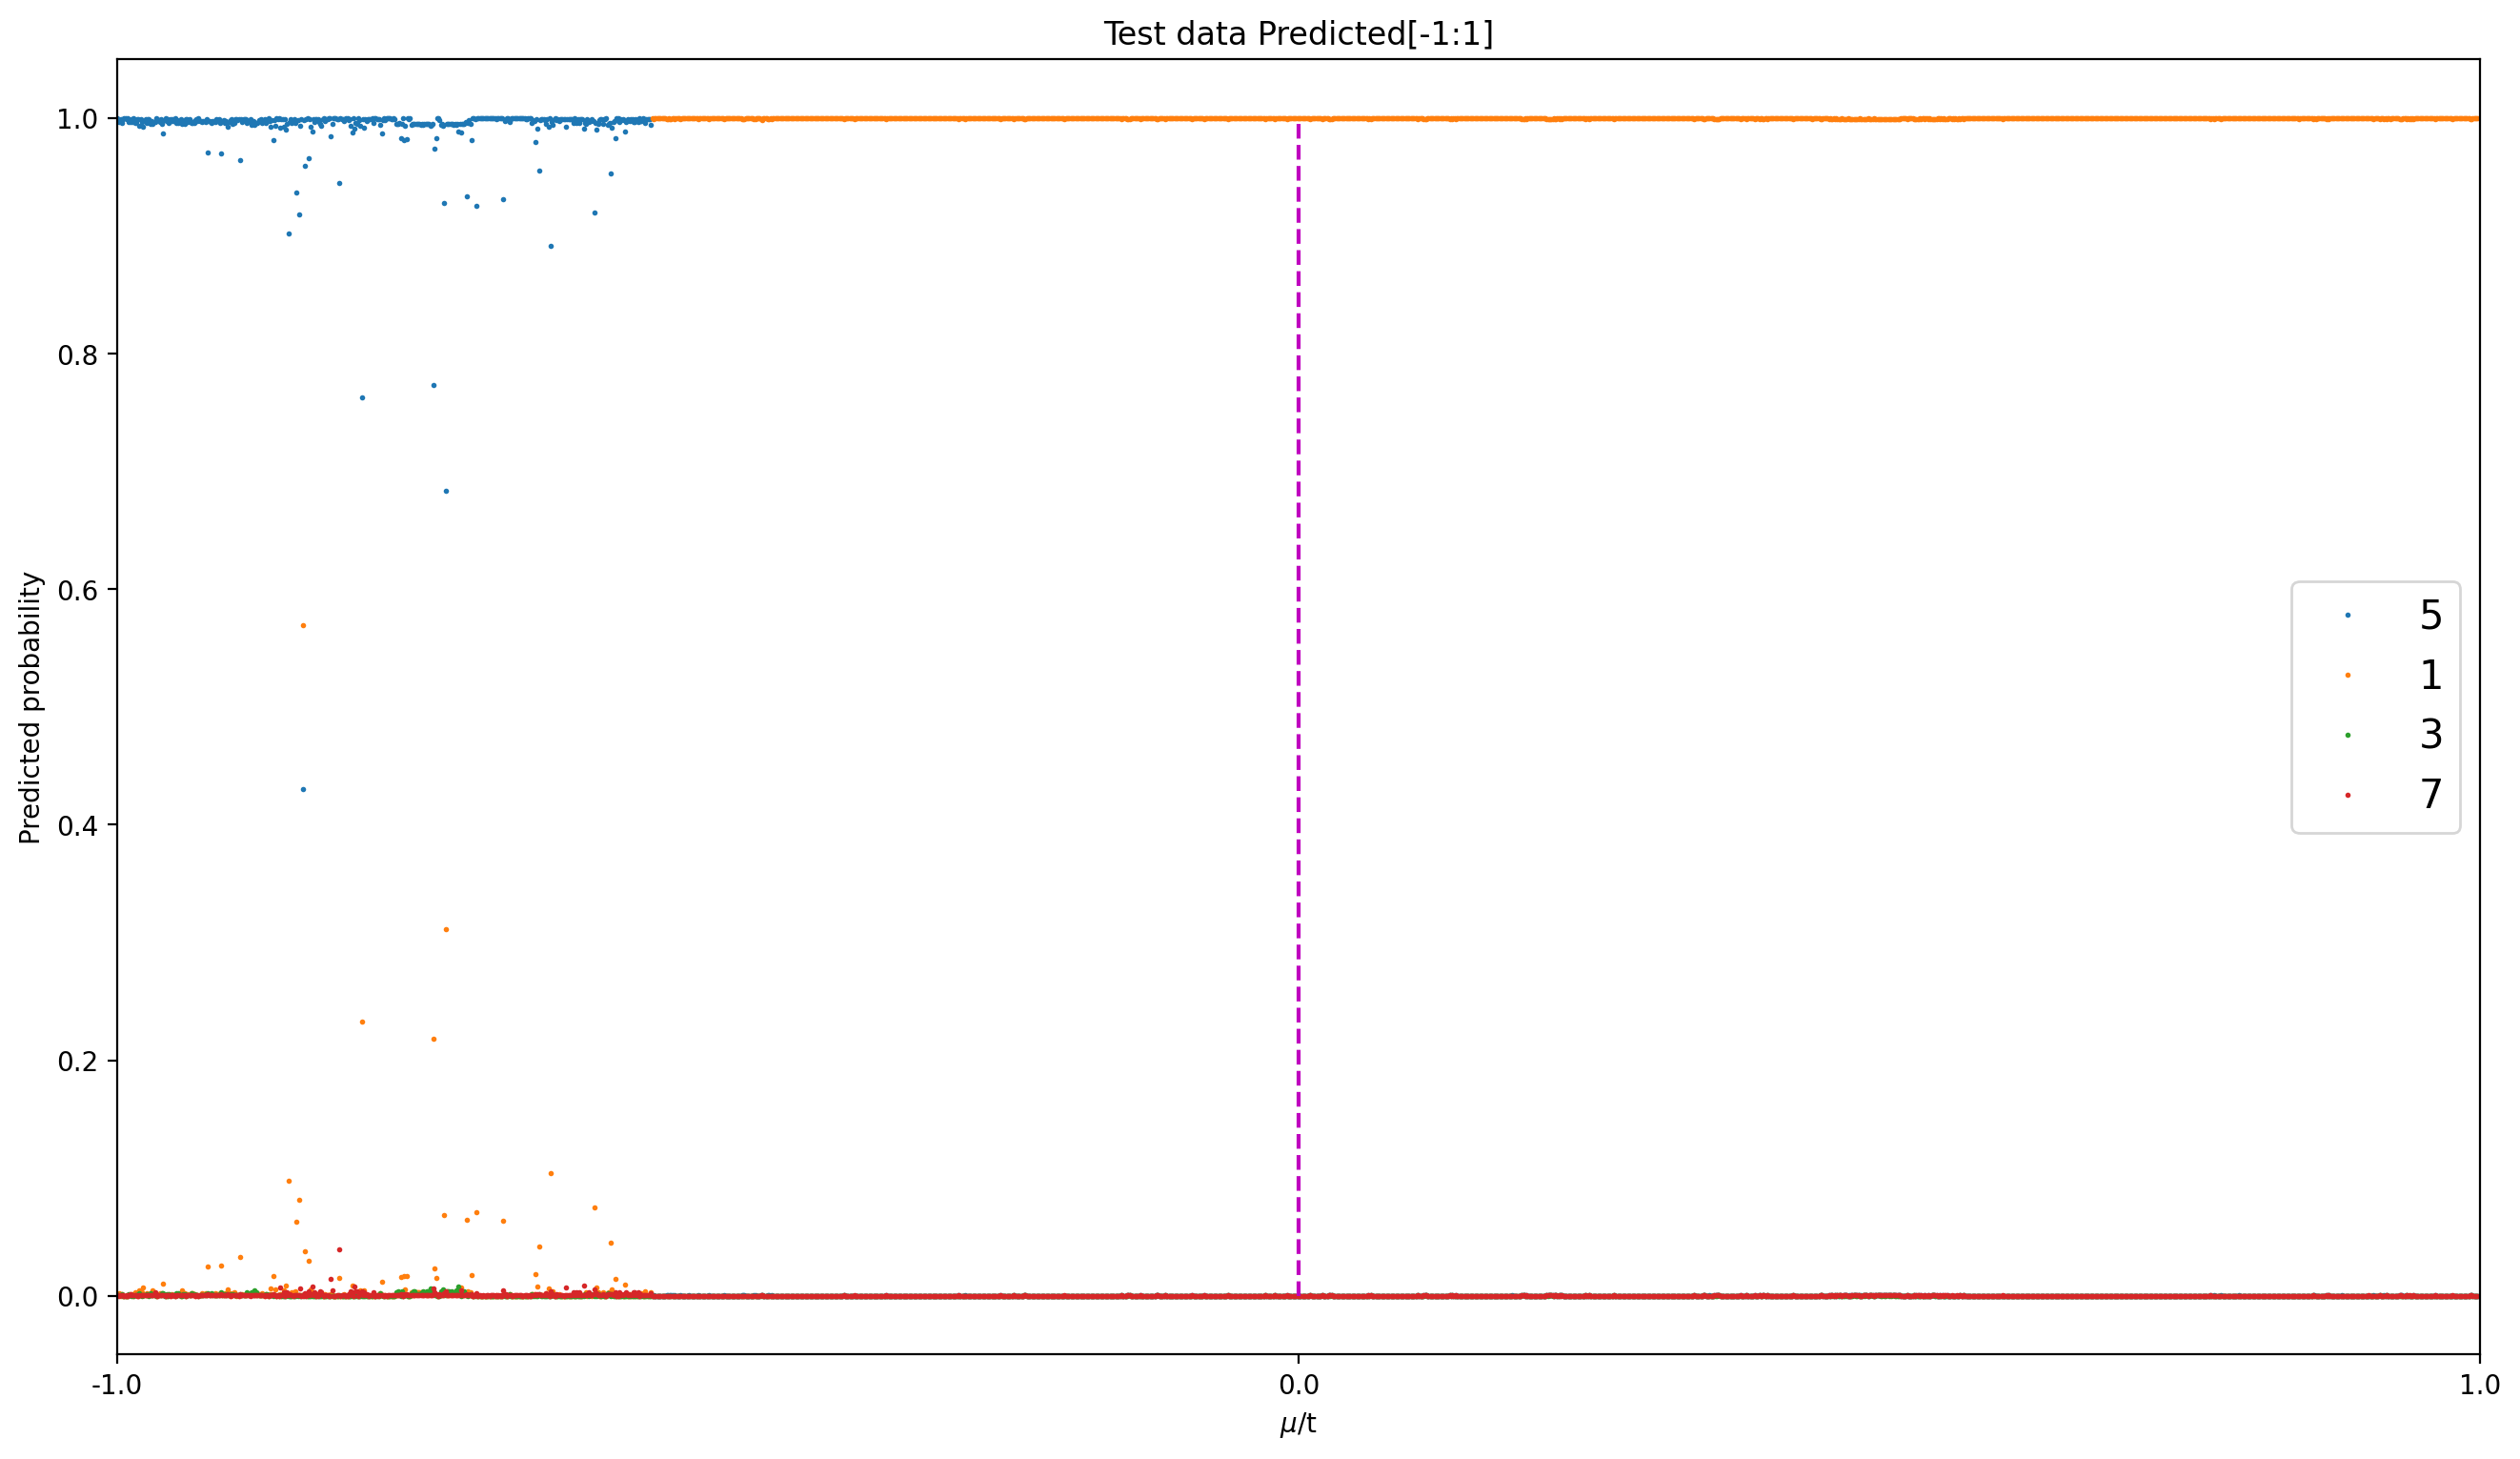

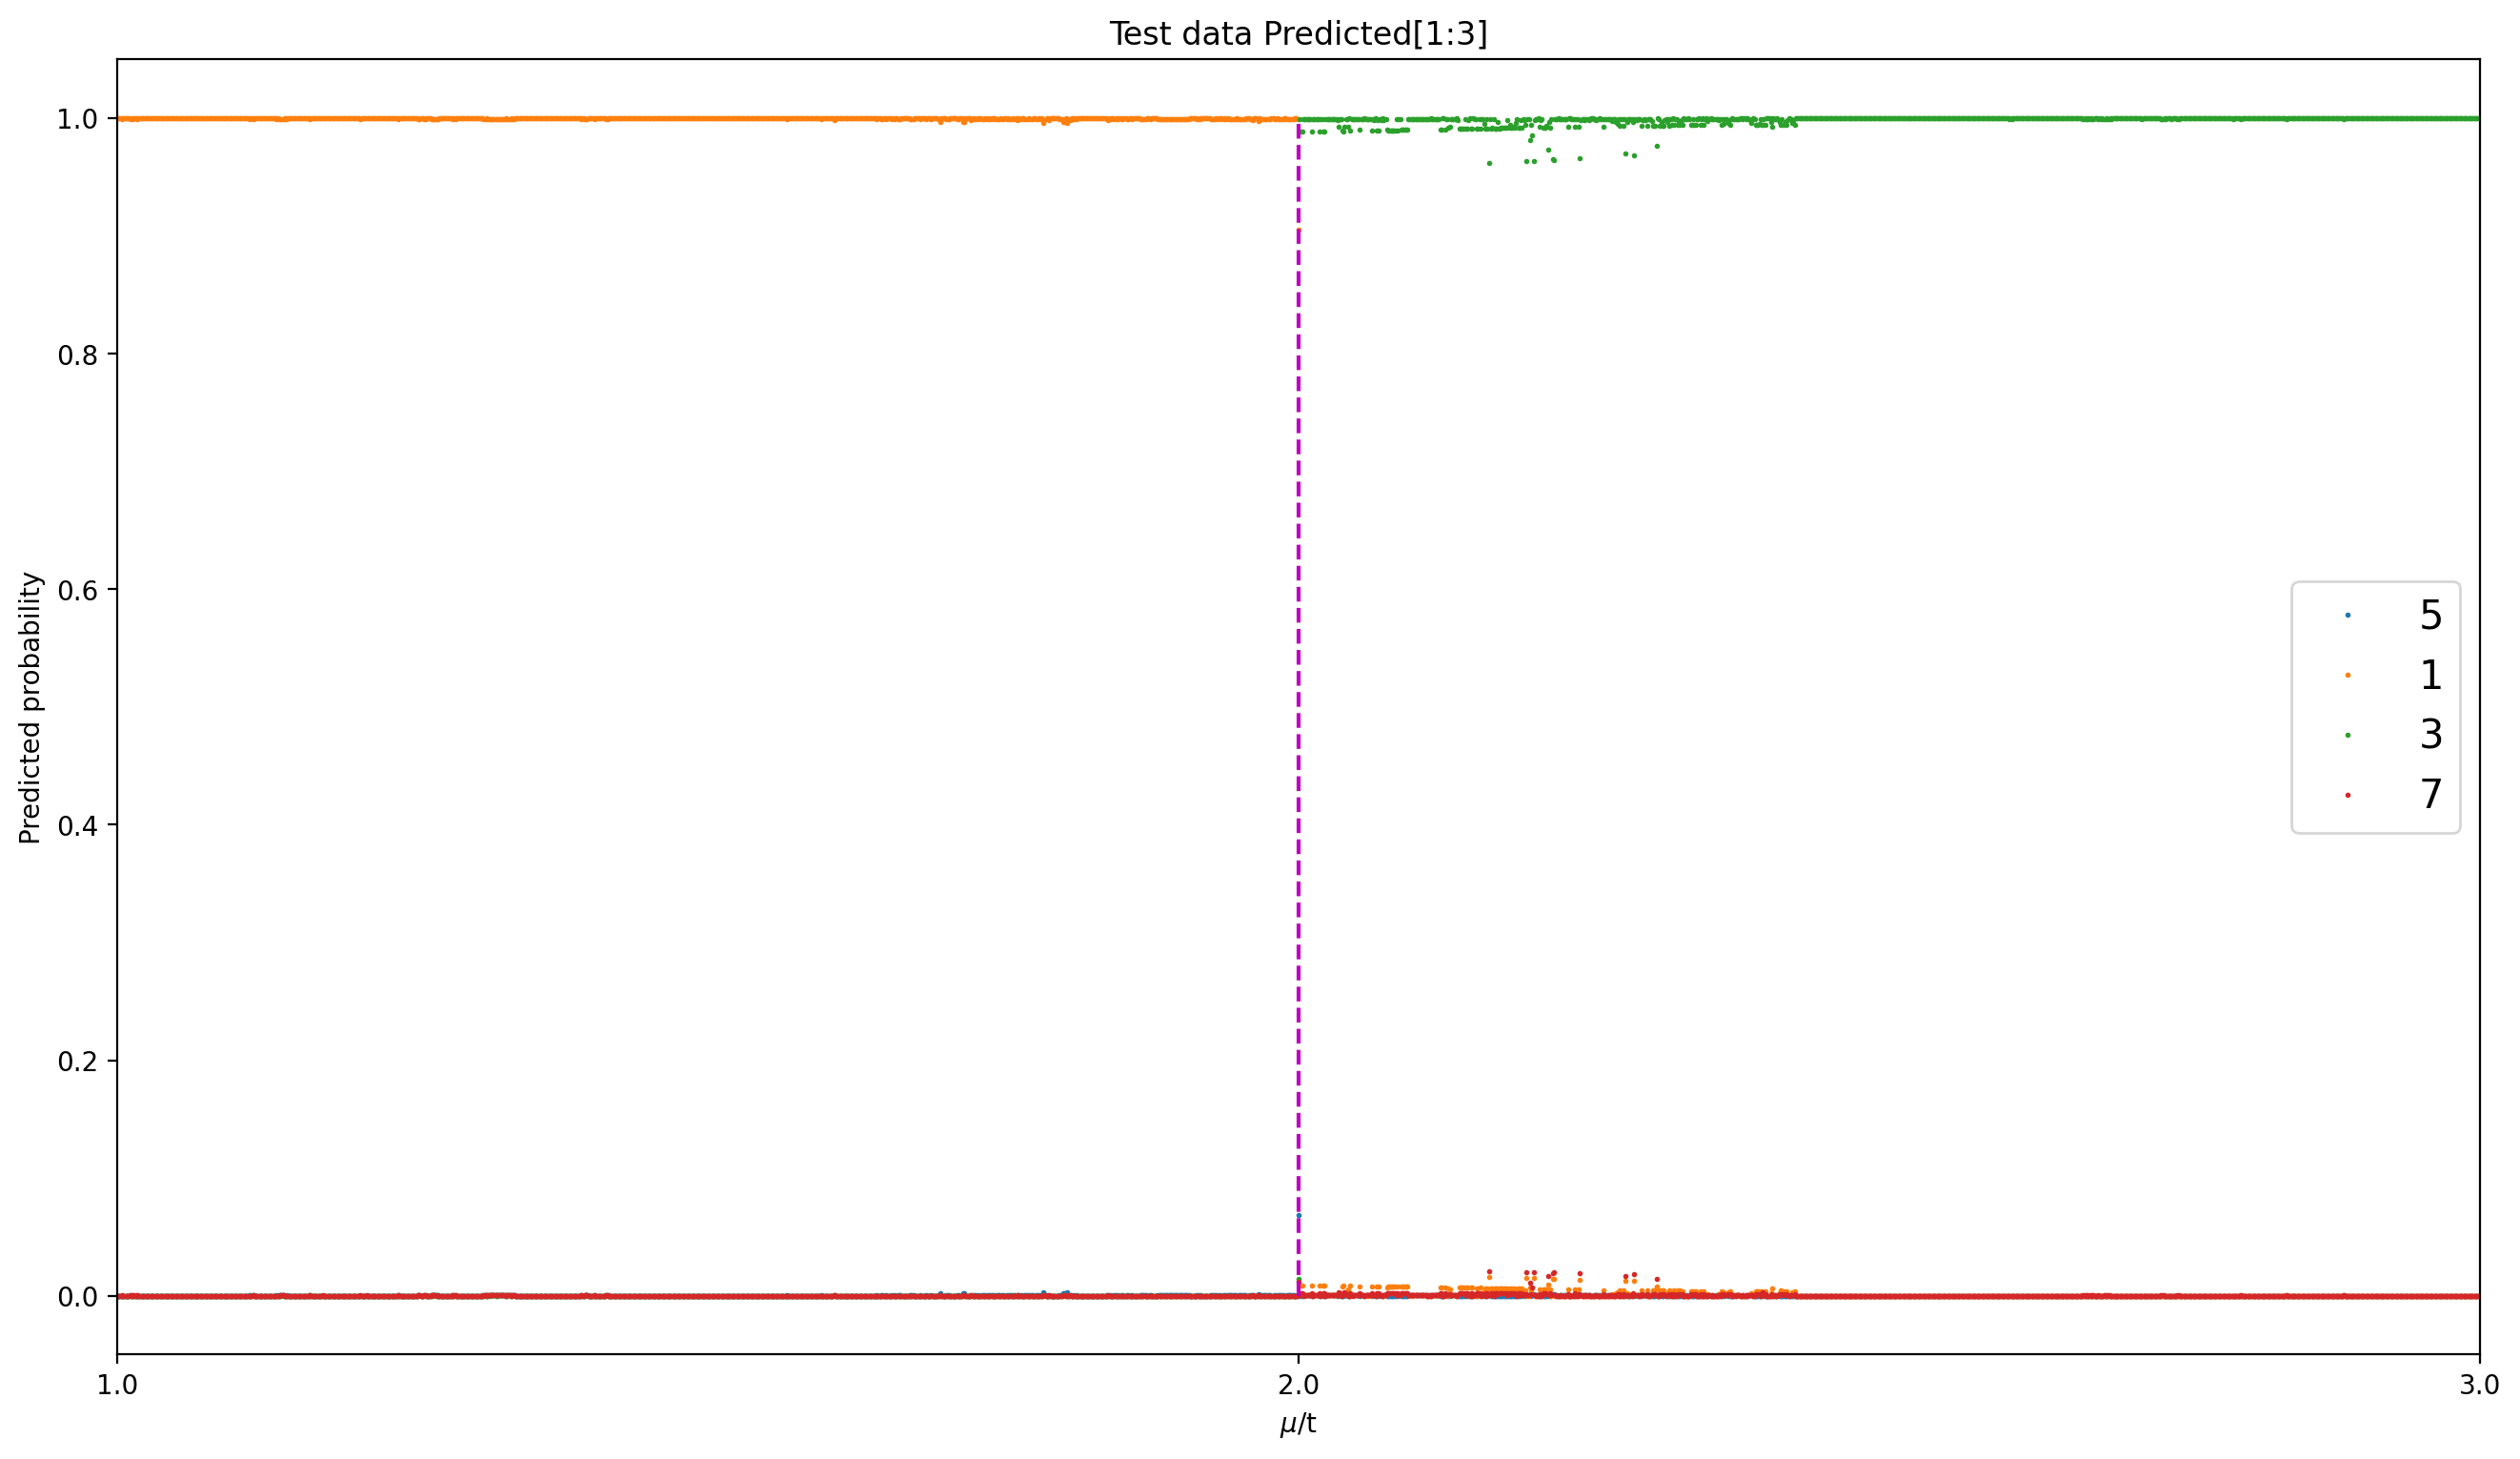

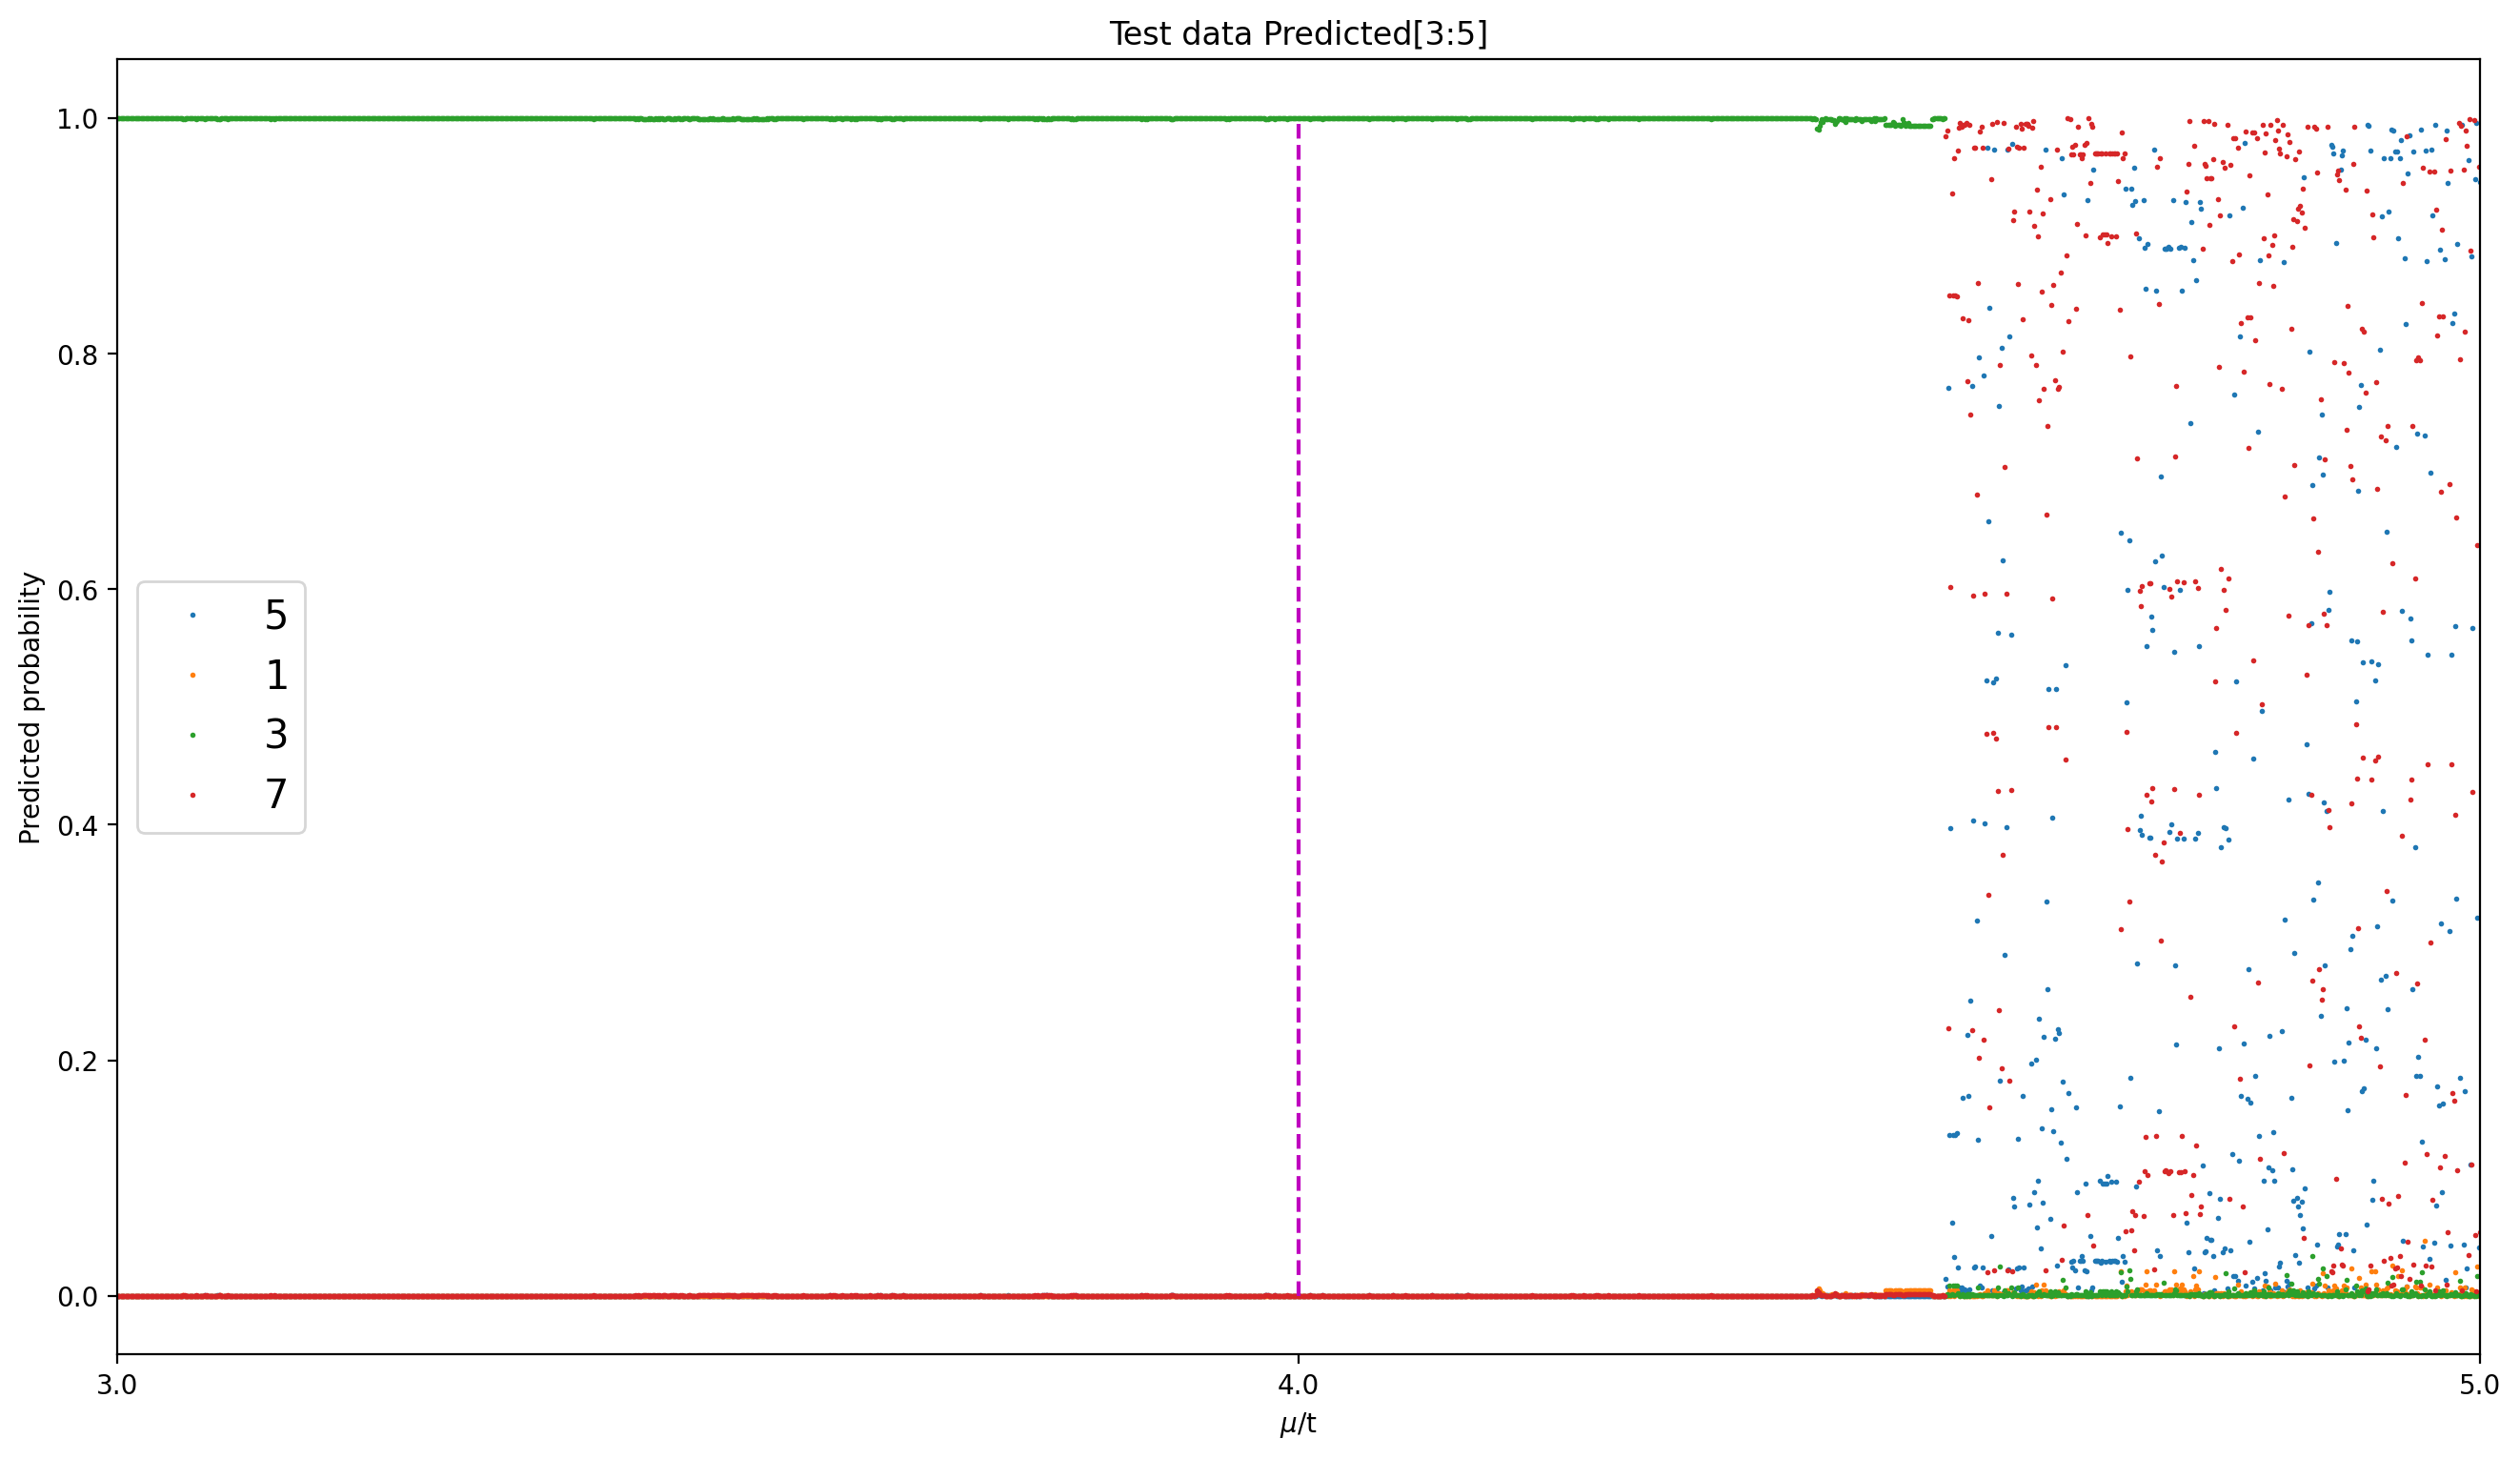

In [147]:
def x_ticks(label_phase_1):
    # 為X軸改寫座標，從數據點改為mu
    # 第一項給數據點用
    # 第二項給mu用
    # print(len(file["phase1"]))
    return arange(0, 28001, 1000), linspace(-12, 16, 29)

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
P = plot(prediction ,'o',markersize=0.8)
plot([12000,12000],[0,1],'m--')
plot([14000,14000],[0,1],'m--')
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[-1:1]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([12000,12000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(11000,13000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[1:3]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([14000,14000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(13000,15000)
show()

figure(figsize=(16, 9),dpi=200)
title('Test data Predicted[3:5]')
xlabel(r'$ \mu $/t')
ylabel('Predicted probability')
plot(prediction ,'o',markersize=1)
plot([16000,16000],[0,1],'m--')
xticks(x_ticks(0)[0], x_ticks(0)[1])
legend(('5', '1', '3', '7'),prop={'size':15})
xlim(15000,17000)
show()